In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import pymysql
import numpy as np

host="127.0.0.1"
user="root"
password="root123"
database="bods_bus_database"

conn = pymysql.connect(host=host, user=user, password=password, db=database)

def get_table_names(connection):
    query = "SHOW TABLES;"
    cursor = connection.cursor()
    cursor.execute(query)
    table_names = [table[0] for table in cursor.fetchall()]
    return table_names

def get_data_from_tables(connection, table_names):
    df = pd.DataFrame()
    for table_name in table_names:
        query = f"SELECT * FROM {table_name};"
        table_data = pd.read_sql(query, connection)
        df = df.append(table_data, ignore_index=True)
    return df

all_table_names = get_table_names(conn)

df = get_data_from_tables(conn, all_table_names)

conn.close()

In [3]:
df['RecordedAtTime'] = pd.to_datetime(df['RecordedAtTime'])

df['hour'] = df['RecordedAtTime'].dt.hour

In [4]:
df

id            RecordedAtTime OperatorRef LineRef DirectionRef  \
0      1 2023-07-28 07:48:31+00:00        ADER     904      inbound   
1      1 2023-07-28 22:59:10+00:00        BRTB     cal     outbound   
2      2 2023-07-28 23:06:14+00:00        BRTB     cal     outbound   
3      1 2023-07-27 16:51:29+00:00        BRTB     cal     outbound   
4      2 2023-07-27 16:57:59+00:00        BRTB     cal     outbound   
...   ..                       ...         ...     ...          ...   
4951  13 2023-07-28 19:19:03+00:00        VECT      92     outbound   
4952  14 2023-07-28 19:25:44+00:00        VECT      92     outbound   
4953  15 2023-07-28 21:08:15+00:00        VECT      92     outbound   
4954  16 2023-07-28 21:15:22+00:00        VECT      92     outbound   
4955  17 2023-07-28 21:22:23+00:00        VECT      92     outbound   

         OriginRef DestinationRef DatedVehicleJourneyRef  \
0     109000009001       3390UN42                   2002   
1           3390P1     3300GE0300                 502400   
2           3390P1     3300GE0300                 502400   
3           3390P1     3300NS0816                 101750   
4           3390P1     3300NS0816                 101750   
...            ...            ...                    ...   
4951        3390B1     3300RU0313                  92013   
4952        3390B1     3300RU0313                  92013   
4953        3390B1     3300RU0313                  92017   
4954        3390B1     3300RU0313                  92017   
4955        3390B1     3300RU0313                  92017   

       OriginAimedDepartureTime DestinationAimedArrivalTime  Longitude  \
0     2023-07-28T07:05:00+00:00   2023-07-28T07:50:00+00:00   -1.19552   
1     2023-07-28T23:00:00+00:00   2023-07-28T23:29:00+00:00   -1.15011   
2     2023-07-28T23:00:00+00:00   2023-07-28T23:29:00+00:00   -1.15023   
3     2023-07-27T16:50:00+00:00   2023-07-27T17:54:00+00:00   -1.14980   
4     2023-07-27T16:50:00+00:00   2023-07-27T17:54:00+00:00   -1.15235   
...                         ...                         ...        ...   
4951  2023-07-28T19:15:00+00:00   2023-07-28T20:09:00+00:00   -1.15121   
4952  2023-07-28T19:15:00+00:00   2023-07-28T20:09:00+00:00   -1.14377   
4953  2023-07-28T21:15:00+00:00   2023-07-28T22:09:00+00:00   -1.15141   
4954  2023-07-28T21:15:00+00:00   2023-07-28T22:09:00+00:00   -1.15177   
4955  2023-07-28T21:15:00+00:00   2023-07-28T22:09:00+00:00   -1.14030   

      Latitude                 Degree  hour  
0      52.9389      13.58851851851852     7  
1      52.9551   0.026881720430107527    22  
2      52.9755     0.2010752688172043    23  
3      52.9550   0.024316939890710383    16  
4      52.9642    0.09808743169398908    16  
...        ...                    ...   ...  
4951   52.9532                  0.075    19  
4952   52.9447   0.050617283950617285    19  
4953   52.9534                  0.125    21  
4954   52.9538  0.0067901234567901226    21  
4955   52.9440     0.1367283950617284    21  

[4956 rows x 14 columns]

In [5]:
# Prediction
df['OperatorRef'] = df['OperatorRef'].astype(str)
df['LineRef'] = df['LineRef'].astype(str)
df['DirectionRef'] = df['DirectionRef'].astype(str)
df['OriginRef'] = df['OriginRef'].astype(str)
df['DestinationRef'] = df['DestinationRef'].astype(str)
df['Degree'] = df['Degree'].astype(float)

In [6]:
df.replace('', np.nan, inplace=True)  

df.dropna(subset=['Degree'], inplace=True)

In [7]:
df.loc[df['Degree'] < 0.03, 'Delay'] = 0
df.loc[(df['Degree'] >= 0.03) & (df['Degree'] < 0.08), 'Delay'] = 1
df.loc[(df['Degree'] >= 0.08) & (df['Degree'] < 0.15), 'Delay'] = 2
df.loc[df['Degree'] >= 0.15, 'Delay'] = 3

In [8]:
df.columns = df.columns.str.replace('OperatorRef', 'OpR')
df.columns = df.columns.str.replace('LineRef', 'LR')
df.columns = df.columns.str.replace('DirectionRef', 'DiR')
df.columns = df.columns.str.replace('OriginRef', 'OrR')
df.columns = df.columns.str.replace('DestinationRef', 'DeR')

In [9]:
df_X = df[['OpR', 'LR', 'DiR', 'OrR', 'DeR']]
X = pd.get_dummies(df_X, columns=['OpR', 'LR', 'DiR', 'OrR', 'DeR'])
y = df['Degree']

In [10]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [51]:
from sklearn.model_selection import RandomizedSearchCV


df['Delay'] = df['Delay'].astype(int)
X = pd.get_dummies(df_X, columns=['OpR', 'LR', 'DiR', 'OrR', 'DeR'])
y = df['Delay']

param_dist = {
    'iterations': [500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
}

print("Start RandomizedSearchCV")
random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=10, random_state=42)
print("End RandomizedSearchCV")
random_search.fit(X,y)
print("Best parameters: ", random_search.best_params_)
print("Best accuracy: {:.2f}%".format(random_search.best_score_ * 100))


best_model = random_search
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)



Start RandomizedSearchCV
End RandomizedSearchCV
0:	learn: 0.6916551	total: 10.5ms	remaining: 5.23s
1:	learn: 0.6898020	total: 12.2ms	remaining: 3.05s
2:	learn: 0.6882131	total: 13.9ms	remaining: 2.3s
3:	learn: 0.6873281	total: 15.1ms	remaining: 1.87s
4:	learn: 0.6852219	total: 16.6ms	remaining: 1.64s
5:	learn: 0.6835579	total: 18.1ms	remaining: 1.49s
6:	learn: 0.6819072	total: 19.7ms	remaining: 1.39s
7:	learn: 0.6802289	total: 21ms	remaining: 1.29s
8:	learn: 0.6789580	total: 22.5ms	remaining: 1.23s
9:	learn: 0.6774435	total: 23.7ms	remaining: 1.16s
10:	learn: 0.6758876	total: 25.1ms	remaining: 1.11s
11:	learn: 0.6739994	total: 26.5ms	remaining: 1.08s
12:	learn: 0.6724988	total: 27.9ms	remaining: 1.05s
13:	learn: 0.6711059	total: 29.3ms	remaining: 1.02s
14:	learn: 0.6699226	total: 30.8ms	remaining: 995ms
15:	learn: 0.6684383	total: 32.1ms	remaining: 970ms
16:	learn: 0.6670975	total: 33.6ms	remaining: 955ms
17:	learn: 0.6662193	total: 34.6ms	remaining: 926ms
18:	learn: 0.6655777	total: 3

171:	learn: 0.5911586	total: 255ms	remaining: 486ms
172:	learn: 0.5910438	total: 256ms	remaining: 485ms
173:	learn: 0.5909075	total: 258ms	remaining: 483ms
174:	learn: 0.5907187	total: 259ms	remaining: 481ms
175:	learn: 0.5905130	total: 261ms	remaining: 480ms
176:	learn: 0.5904108	total: 262ms	remaining: 478ms
177:	learn: 0.5902298	total: 263ms	remaining: 477ms
178:	learn: 0.5900964	total: 265ms	remaining: 475ms
179:	learn: 0.5899732	total: 266ms	remaining: 473ms
180:	learn: 0.5897961	total: 267ms	remaining: 471ms
181:	learn: 0.5897074	total: 269ms	remaining: 469ms
182:	learn: 0.5895415	total: 270ms	remaining: 468ms
183:	learn: 0.5894272	total: 271ms	remaining: 466ms
184:	learn: 0.5892381	total: 273ms	remaining: 464ms
185:	learn: 0.5891083	total: 274ms	remaining: 462ms
186:	learn: 0.5889824	total: 275ms	remaining: 460ms
187:	learn: 0.5888281	total: 276ms	remaining: 458ms
188:	learn: 0.5887369	total: 277ms	remaining: 456ms
189:	learn: 0.5886282	total: 279ms	remaining: 454ms
190:	learn: 

404:	learn: 0.5729376	total: 573ms	remaining: 134ms
405:	learn: 0.5728869	total: 574ms	remaining: 133ms
406:	learn: 0.5728545	total: 576ms	remaining: 132ms
407:	learn: 0.5727868	total: 577ms	remaining: 130ms
408:	learn: 0.5727293	total: 579ms	remaining: 129ms
409:	learn: 0.5726885	total: 580ms	remaining: 127ms
410:	learn: 0.5726627	total: 581ms	remaining: 126ms
411:	learn: 0.5726293	total: 582ms	remaining: 124ms
412:	learn: 0.5726114	total: 584ms	remaining: 123ms
413:	learn: 0.5725637	total: 585ms	remaining: 122ms
414:	learn: 0.5725172	total: 586ms	remaining: 120ms
415:	learn: 0.5724686	total: 588ms	remaining: 119ms
416:	learn: 0.5724141	total: 589ms	remaining: 117ms
417:	learn: 0.5723901	total: 591ms	remaining: 116ms
418:	learn: 0.5723274	total: 592ms	remaining: 114ms
419:	learn: 0.5723070	total: 593ms	remaining: 113ms
420:	learn: 0.5722687	total: 594ms	remaining: 112ms
421:	learn: 0.5722462	total: 595ms	remaining: 110ms
422:	learn: 0.5722038	total: 597ms	remaining: 109ms
423:	learn: 

120:	learn: 0.5961058	total: 203ms	remaining: 635ms
121:	learn: 0.5957440	total: 205ms	remaining: 634ms
122:	learn: 0.5955037	total: 206ms	remaining: 631ms
123:	learn: 0.5951174	total: 207ms	remaining: 629ms
124:	learn: 0.5948157	total: 209ms	remaining: 627ms
125:	learn: 0.5946846	total: 210ms	remaining: 624ms
126:	learn: 0.5945764	total: 212ms	remaining: 621ms
127:	learn: 0.5942769	total: 213ms	remaining: 620ms
128:	learn: 0.5940847	total: 215ms	remaining: 618ms
129:	learn: 0.5936846	total: 216ms	remaining: 616ms
130:	learn: 0.5935802	total: 217ms	remaining: 612ms
131:	learn: 0.5934509	total: 219ms	remaining: 610ms
132:	learn: 0.5932516	total: 221ms	remaining: 608ms
133:	learn: 0.5930507	total: 222ms	remaining: 607ms
134:	learn: 0.5928099	total: 224ms	remaining: 606ms
135:	learn: 0.5925585	total: 226ms	remaining: 604ms
136:	learn: 0.5922934	total: 227ms	remaining: 602ms
137:	learn: 0.5922015	total: 229ms	remaining: 600ms
138:	learn: 0.5919226	total: 230ms	remaining: 598ms
139:	learn: 

345:	learn: 0.5687248	total: 576ms	remaining: 256ms
346:	learn: 0.5686751	total: 578ms	remaining: 255ms
347:	learn: 0.5685886	total: 581ms	remaining: 254ms
348:	learn: 0.5685331	total: 582ms	remaining: 252ms
349:	learn: 0.5684838	total: 584ms	remaining: 250ms
350:	learn: 0.5684205	total: 586ms	remaining: 249ms
351:	learn: 0.5683402	total: 587ms	remaining: 247ms
352:	learn: 0.5682992	total: 589ms	remaining: 245ms
353:	learn: 0.5682713	total: 592ms	remaining: 244ms
354:	learn: 0.5682026	total: 594ms	remaining: 243ms
355:	learn: 0.5681605	total: 596ms	remaining: 241ms
356:	learn: 0.5681398	total: 597ms	remaining: 239ms
357:	learn: 0.5680894	total: 599ms	remaining: 238ms
358:	learn: 0.5680468	total: 601ms	remaining: 236ms
359:	learn: 0.5679532	total: 603ms	remaining: 234ms
360:	learn: 0.5679166	total: 605ms	remaining: 233ms
361:	learn: 0.5678590	total: 607ms	remaining: 231ms
362:	learn: 0.5678263	total: 608ms	remaining: 230ms
363:	learn: 0.5677827	total: 610ms	remaining: 228ms
364:	learn: 

30:	learn: 0.6442911	total: 45.6ms	remaining: 690ms
31:	learn: 0.6435447	total: 46.9ms	remaining: 687ms
32:	learn: 0.6424666	total: 48.4ms	remaining: 685ms
33:	learn: 0.6414126	total: 49.7ms	remaining: 682ms
34:	learn: 0.6401877	total: 51.1ms	remaining: 680ms
35:	learn: 0.6391372	total: 52.5ms	remaining: 677ms
36:	learn: 0.6380960	total: 54ms	remaining: 676ms
37:	learn: 0.6374192	total: 55.4ms	remaining: 673ms
38:	learn: 0.6364155	total: 56.5ms	remaining: 668ms
39:	learn: 0.6355551	total: 57.8ms	remaining: 664ms
40:	learn: 0.6349412	total: 59.2ms	remaining: 663ms
41:	learn: 0.6343899	total: 60.1ms	remaining: 656ms
42:	learn: 0.6337513	total: 61.4ms	remaining: 653ms
43:	learn: 0.6325426	total: 62.8ms	remaining: 651ms
44:	learn: 0.6315516	total: 64.1ms	remaining: 648ms
45:	learn: 0.6305047	total: 65.4ms	remaining: 645ms
46:	learn: 0.6295590	total: 66.6ms	remaining: 642ms
47:	learn: 0.6288507	total: 68ms	remaining: 641ms
48:	learn: 0.6283326	total: 69.3ms	remaining: 638ms
49:	learn: 0.627

238:	learn: 0.5764843	total: 310ms	remaining: 339ms
239:	learn: 0.5763835	total: 312ms	remaining: 338ms
240:	learn: 0.5762932	total: 313ms	remaining: 337ms
241:	learn: 0.5761409	total: 315ms	remaining: 336ms
242:	learn: 0.5760911	total: 316ms	remaining: 334ms
243:	learn: 0.5759778	total: 317ms	remaining: 333ms
244:	learn: 0.5759233	total: 319ms	remaining: 332ms
245:	learn: 0.5758590	total: 320ms	remaining: 331ms
246:	learn: 0.5757480	total: 322ms	remaining: 329ms
247:	learn: 0.5756890	total: 323ms	remaining: 328ms
248:	learn: 0.5756390	total: 324ms	remaining: 327ms
249:	learn: 0.5755658	total: 326ms	remaining: 326ms
250:	learn: 0.5755118	total: 327ms	remaining: 324ms
251:	learn: 0.5754439	total: 328ms	remaining: 323ms
252:	learn: 0.5753811	total: 329ms	remaining: 322ms
253:	learn: 0.5753000	total: 331ms	remaining: 321ms
254:	learn: 0.5752224	total: 332ms	remaining: 319ms
255:	learn: 0.5751568	total: 333ms	remaining: 318ms
256:	learn: 0.5750529	total: 335ms	remaining: 316ms
257:	learn: 

499:	learn: 0.5645525	total: 635ms	remaining: 0us
0:	learn: 0.6907385	total: 7.95ms	remaining: 3.97s
1:	learn: 0.6877591	total: 9.21ms	remaining: 2.29s
2:	learn: 0.6861467	total: 10.2ms	remaining: 1.68s
3:	learn: 0.6836131	total: 11.4ms	remaining: 1.42s
4:	learn: 0.6811029	total: 12.6ms	remaining: 1.25s
5:	learn: 0.6784888	total: 13.8ms	remaining: 1.14s
6:	learn: 0.6759060	total: 15.1ms	remaining: 1.06s
7:	learn: 0.6735436	total: 16.3ms	remaining: 1s
8:	learn: 0.6713200	total: 17.6ms	remaining: 957ms
9:	learn: 0.6688459	total: 19ms	remaining: 932ms
10:	learn: 0.6674706	total: 20.1ms	remaining: 895ms
11:	learn: 0.6651817	total: 21.4ms	remaining: 872ms
12:	learn: 0.6634939	total: 22.7ms	remaining: 852ms
13:	learn: 0.6614447	total: 24.1ms	remaining: 836ms
14:	learn: 0.6601013	total: 25.4ms	remaining: 822ms
15:	learn: 0.6579848	total: 26.7ms	remaining: 809ms
16:	learn: 0.6559426	total: 28ms	remaining: 794ms
17:	learn: 0.6540363	total: 29.3ms	remaining: 785ms
18:	learn: 0.6520656	total: 30.

160:	learn: 0.5664508	total: 208ms	remaining: 437ms
161:	learn: 0.5662617	total: 209ms	remaining: 437ms
162:	learn: 0.5660589	total: 211ms	remaining: 436ms
163:	learn: 0.5658178	total: 212ms	remaining: 435ms
164:	learn: 0.5656491	total: 214ms	remaining: 434ms
165:	learn: 0.5655103	total: 215ms	remaining: 433ms
166:	learn: 0.5653335	total: 217ms	remaining: 432ms
167:	learn: 0.5650957	total: 218ms	remaining: 431ms
168:	learn: 0.5649332	total: 219ms	remaining: 430ms
169:	learn: 0.5648346	total: 220ms	remaining: 428ms
170:	learn: 0.5646743	total: 222ms	remaining: 427ms
171:	learn: 0.5645204	total: 223ms	remaining: 425ms
172:	learn: 0.5643406	total: 224ms	remaining: 424ms
173:	learn: 0.5642662	total: 226ms	remaining: 422ms
174:	learn: 0.5640333	total: 227ms	remaining: 421ms
175:	learn: 0.5639222	total: 228ms	remaining: 420ms
176:	learn: 0.5636629	total: 229ms	remaining: 419ms
177:	learn: 0.5635285	total: 231ms	remaining: 417ms
178:	learn: 0.5634192	total: 232ms	remaining: 416ms
179:	learn: 

401:	learn: 0.5468499	total: 535ms	remaining: 130ms
402:	learn: 0.5468111	total: 536ms	remaining: 129ms
403:	learn: 0.5467817	total: 538ms	remaining: 128ms
404:	learn: 0.5467397	total: 539ms	remaining: 126ms
405:	learn: 0.5467199	total: 540ms	remaining: 125ms
406:	learn: 0.5466928	total: 542ms	remaining: 124ms
407:	learn: 0.5466600	total: 543ms	remaining: 122ms
408:	learn: 0.5466400	total: 545ms	remaining: 121ms
409:	learn: 0.5465997	total: 546ms	remaining: 120ms
410:	learn: 0.5465621	total: 547ms	remaining: 118ms
411:	learn: 0.5465236	total: 548ms	remaining: 117ms
412:	learn: 0.5464901	total: 550ms	remaining: 116ms
413:	learn: 0.5464626	total: 551ms	remaining: 114ms
414:	learn: 0.5464387	total: 552ms	remaining: 113ms
415:	learn: 0.5464075	total: 553ms	remaining: 112ms
416:	learn: 0.5463920	total: 554ms	remaining: 110ms
417:	learn: 0.5463743	total: 556ms	remaining: 109ms
418:	learn: 0.5463238	total: 557ms	remaining: 108ms
419:	learn: 0.5462915	total: 558ms	remaining: 106ms
420:	learn: 

134:	learn: 0.5895074	total: 193ms	remaining: 523ms
135:	learn: 0.5891514	total: 195ms	remaining: 522ms
136:	learn: 0.5889004	total: 196ms	remaining: 520ms
137:	learn: 0.5886166	total: 198ms	remaining: 518ms
138:	learn: 0.5883630	total: 199ms	remaining: 517ms
139:	learn: 0.5879484	total: 201ms	remaining: 516ms
140:	learn: 0.5876381	total: 202ms	remaining: 514ms
141:	learn: 0.5874055	total: 203ms	remaining: 513ms
142:	learn: 0.5870489	total: 205ms	remaining: 512ms
143:	learn: 0.5867952	total: 207ms	remaining: 511ms
144:	learn: 0.5866227	total: 208ms	remaining: 510ms
145:	learn: 0.5864771	total: 210ms	remaining: 508ms
146:	learn: 0.5863320	total: 211ms	remaining: 507ms
147:	learn: 0.5861268	total: 213ms	remaining: 506ms
148:	learn: 0.5858874	total: 214ms	remaining: 504ms
149:	learn: 0.5856487	total: 215ms	remaining: 503ms
150:	learn: 0.5855260	total: 217ms	remaining: 501ms
151:	learn: 0.5853569	total: 218ms	remaining: 499ms
152:	learn: 0.5850421	total: 220ms	remaining: 498ms
153:	learn: 

320:	learn: 0.5631946	total: 463ms	remaining: 258ms
321:	learn: 0.5631734	total: 464ms	remaining: 257ms
322:	learn: 0.5631065	total: 466ms	remaining: 255ms
323:	learn: 0.5630076	total: 467ms	remaining: 254ms
324:	learn: 0.5629315	total: 469ms	remaining: 252ms
325:	learn: 0.5628622	total: 470ms	remaining: 251ms
326:	learn: 0.5627629	total: 472ms	remaining: 250ms
327:	learn: 0.5626328	total: 474ms	remaining: 248ms
328:	learn: 0.5625841	total: 475ms	remaining: 247ms
329:	learn: 0.5624485	total: 477ms	remaining: 246ms
330:	learn: 0.5624199	total: 478ms	remaining: 244ms
331:	learn: 0.5623665	total: 480ms	remaining: 243ms
332:	learn: 0.5623238	total: 481ms	remaining: 241ms
333:	learn: 0.5622660	total: 483ms	remaining: 240ms
334:	learn: 0.5621838	total: 484ms	remaining: 239ms
335:	learn: 0.5621107	total: 486ms	remaining: 237ms
336:	learn: 0.5620566	total: 487ms	remaining: 236ms
337:	learn: 0.5620234	total: 489ms	remaining: 234ms
338:	learn: 0.5619811	total: 491ms	remaining: 233ms
339:	learn: 

0:	learn: 0.6916549	total: 1.1ms	remaining: 549ms
1:	learn: 0.6900783	total: 2.17ms	remaining: 542ms
2:	learn: 0.6884818	total: 3.17ms	remaining: 526ms
3:	learn: 0.6869997	total: 4.1ms	remaining: 508ms
4:	learn: 0.6852222	total: 5.15ms	remaining: 510ms
5:	learn: 0.6843071	total: 6.21ms	remaining: 511ms
6:	learn: 0.6830079	total: 7.04ms	remaining: 496ms
7:	learn: 0.6817511	total: 7.91ms	remaining: 486ms
8:	learn: 0.6805669	total: 8.83ms	remaining: 482ms
9:	learn: 0.6791052	total: 9.78ms	remaining: 479ms
10:	learn: 0.6780060	total: 10.8ms	remaining: 479ms
11:	learn: 0.6766981	total: 11.8ms	remaining: 478ms
12:	learn: 0.6753074	total: 12.8ms	remaining: 478ms
13:	learn: 0.6740329	total: 13.8ms	remaining: 479ms
14:	learn: 0.6727469	total: 14.8ms	remaining: 479ms
15:	learn: 0.6715924	total: 15.7ms	remaining: 476ms
16:	learn: 0.6701754	total: 16.8ms	remaining: 477ms
17:	learn: 0.6695064	total: 17.6ms	remaining: 471ms
18:	learn: 0.6682469	total: 18.5ms	remaining: 470ms
19:	learn: 0.6669771	tot

177:	learn: 0.5970064	total: 197ms	remaining: 357ms
178:	learn: 0.5968144	total: 199ms	remaining: 356ms
179:	learn: 0.5966802	total: 200ms	remaining: 355ms
180:	learn: 0.5965563	total: 201ms	remaining: 354ms
181:	learn: 0.5964532	total: 202ms	remaining: 354ms
182:	learn: 0.5963440	total: 204ms	remaining: 353ms
183:	learn: 0.5962287	total: 205ms	remaining: 352ms
184:	learn: 0.5960661	total: 206ms	remaining: 351ms
185:	learn: 0.5959631	total: 207ms	remaining: 350ms
186:	learn: 0.5958566	total: 208ms	remaining: 349ms
187:	learn: 0.5956937	total: 210ms	remaining: 348ms
188:	learn: 0.5955095	total: 211ms	remaining: 347ms
189:	learn: 0.5953612	total: 212ms	remaining: 346ms
190:	learn: 0.5952436	total: 213ms	remaining: 345ms
191:	learn: 0.5950791	total: 214ms	remaining: 344ms
192:	learn: 0.5948969	total: 215ms	remaining: 342ms
193:	learn: 0.5948761	total: 216ms	remaining: 341ms
194:	learn: 0.5947431	total: 217ms	remaining: 340ms
195:	learn: 0.5945864	total: 219ms	remaining: 339ms
196:	learn: 

339:	learn: 0.5810544	total: 390ms	remaining: 184ms
340:	learn: 0.5809754	total: 392ms	remaining: 183ms
341:	learn: 0.5809391	total: 393ms	remaining: 181ms
342:	learn: 0.5808981	total: 394ms	remaining: 180ms
343:	learn: 0.5808471	total: 395ms	remaining: 179ms
344:	learn: 0.5807850	total: 396ms	remaining: 178ms
345:	learn: 0.5807175	total: 398ms	remaining: 177ms
346:	learn: 0.5806559	total: 399ms	remaining: 176ms
347:	learn: 0.5805459	total: 400ms	remaining: 175ms
348:	learn: 0.5805089	total: 401ms	remaining: 174ms
349:	learn: 0.5804701	total: 402ms	remaining: 172ms
350:	learn: 0.5804053	total: 404ms	remaining: 171ms
351:	learn: 0.5803367	total: 405ms	remaining: 170ms
352:	learn: 0.5802902	total: 406ms	remaining: 169ms
353:	learn: 0.5801912	total: 407ms	remaining: 168ms
354:	learn: 0.5801259	total: 408ms	remaining: 167ms
355:	learn: 0.5800434	total: 410ms	remaining: 166ms
356:	learn: 0.5799866	total: 411ms	remaining: 165ms
357:	learn: 0.5798946	total: 412ms	remaining: 164ms
358:	learn: 

0:	learn: 0.6914980	total: 1.32ms	remaining: 658ms
1:	learn: 0.6897725	total: 2.8ms	remaining: 697ms
2:	learn: 0.6874780	total: 3.95ms	remaining: 655ms
3:	learn: 0.6860132	total: 5.03ms	remaining: 624ms
4:	learn: 0.6843417	total: 6.12ms	remaining: 606ms
5:	learn: 0.6827105	total: 7.22ms	remaining: 594ms
6:	learn: 0.6813302	total: 8.3ms	remaining: 585ms
7:	learn: 0.6794064	total: 9.48ms	remaining: 583ms
8:	learn: 0.6779501	total: 10.7ms	remaining: 583ms
9:	learn: 0.6766477	total: 11.9ms	remaining: 584ms
10:	learn: 0.6751707	total: 13.2ms	remaining: 585ms
11:	learn: 0.6742454	total: 14.3ms	remaining: 582ms
12:	learn: 0.6726302	total: 15.5ms	remaining: 581ms
13:	learn: 0.6711800	total: 16.6ms	remaining: 578ms
14:	learn: 0.6698546	total: 18ms	remaining: 582ms
15:	learn: 0.6684740	total: 19.1ms	remaining: 578ms
16:	learn: 0.6670597	total: 20.2ms	remaining: 575ms
17:	learn: 0.6660647	total: 21.4ms	remaining: 573ms
18:	learn: 0.6645994	total: 22.6ms	remaining: 571ms
19:	learn: 0.6634115	total

162:	learn: 0.5934464	total: 196ms	remaining: 406ms
163:	learn: 0.5931706	total: 198ms	remaining: 405ms
164:	learn: 0.5930337	total: 199ms	remaining: 404ms
165:	learn: 0.5929076	total: 200ms	remaining: 402ms
166:	learn: 0.5926287	total: 201ms	remaining: 401ms
167:	learn: 0.5923816	total: 202ms	remaining: 399ms
168:	learn: 0.5922328	total: 203ms	remaining: 398ms
169:	learn: 0.5920585	total: 204ms	remaining: 396ms
170:	learn: 0.5919197	total: 205ms	remaining: 395ms
171:	learn: 0.5916644	total: 206ms	remaining: 393ms
172:	learn: 0.5914774	total: 207ms	remaining: 392ms
173:	learn: 0.5912775	total: 208ms	remaining: 390ms
174:	learn: 0.5910298	total: 209ms	remaining: 389ms
175:	learn: 0.5908560	total: 210ms	remaining: 387ms
176:	learn: 0.5907230	total: 212ms	remaining: 386ms
177:	learn: 0.5905701	total: 213ms	remaining: 385ms
178:	learn: 0.5904420	total: 214ms	remaining: 383ms
179:	learn: 0.5901467	total: 215ms	remaining: 382ms
180:	learn: 0.5899631	total: 216ms	remaining: 381ms
181:	learn: 

330:	learn: 0.5747274	total: 390ms	remaining: 199ms
331:	learn: 0.5746775	total: 392ms	remaining: 198ms
332:	learn: 0.5746187	total: 393ms	remaining: 197ms
333:	learn: 0.5745146	total: 394ms	remaining: 196ms
334:	learn: 0.5744325	total: 395ms	remaining: 195ms
335:	learn: 0.5743613	total: 396ms	remaining: 193ms
336:	learn: 0.5743267	total: 397ms	remaining: 192ms
337:	learn: 0.5742932	total: 398ms	remaining: 191ms
338:	learn: 0.5742419	total: 399ms	remaining: 190ms
339:	learn: 0.5741797	total: 400ms	remaining: 188ms
340:	learn: 0.5741227	total: 401ms	remaining: 187ms
341:	learn: 0.5740835	total: 402ms	remaining: 186ms
342:	learn: 0.5739978	total: 404ms	remaining: 185ms
343:	learn: 0.5739260	total: 404ms	remaining: 183ms
344:	learn: 0.5738790	total: 405ms	remaining: 182ms
345:	learn: 0.5737917	total: 406ms	remaining: 181ms
346:	learn: 0.5737633	total: 408ms	remaining: 180ms
347:	learn: 0.5736845	total: 409ms	remaining: 178ms
348:	learn: 0.5736463	total: 410ms	remaining: 177ms
349:	learn: 

498:	learn: 0.5667034	total: 584ms	remaining: 1.17ms
499:	learn: 0.5666774	total: 585ms	remaining: 0us
0:	learn: 0.6910252	total: 1.22ms	remaining: 606ms
1:	learn: 0.6885309	total: 2.3ms	remaining: 573ms
2:	learn: 0.6868469	total: 3.29ms	remaining: 545ms
3:	learn: 0.6851075	total: 4.32ms	remaining: 535ms
4:	learn: 0.6835807	total: 5.37ms	remaining: 532ms
5:	learn: 0.6822475	total: 6.31ms	remaining: 520ms
6:	learn: 0.6808688	total: 7.26ms	remaining: 511ms
7:	learn: 0.6790566	total: 8.31ms	remaining: 511ms
8:	learn: 0.6771774	total: 9.39ms	remaining: 512ms
9:	learn: 0.6749429	total: 10.4ms	remaining: 510ms
10:	learn: 0.6732414	total: 11.4ms	remaining: 509ms
11:	learn: 0.6721394	total: 12.2ms	remaining: 497ms
12:	learn: 0.6710717	total: 13.1ms	remaining: 493ms
13:	learn: 0.6700676	total: 14.2ms	remaining: 492ms
14:	learn: 0.6684454	total: 15.2ms	remaining: 493ms
15:	learn: 0.6669068	total: 16.3ms	remaining: 493ms
16:	learn: 0.6651572	total: 17.3ms	remaining: 493ms
17:	learn: 0.6638339	tot

292:	learn: 0.5780984	total: 336ms	remaining: 237ms
293:	learn: 0.5780172	total: 337ms	remaining: 236ms
294:	learn: 0.5779638	total: 338ms	remaining: 235ms
295:	learn: 0.5779154	total: 339ms	remaining: 234ms
296:	learn: 0.5777887	total: 340ms	remaining: 233ms
297:	learn: 0.5777047	total: 341ms	remaining: 231ms
298:	learn: 0.5776208	total: 343ms	remaining: 230ms
299:	learn: 0.5775985	total: 344ms	remaining: 229ms
300:	learn: 0.5775181	total: 345ms	remaining: 228ms
301:	learn: 0.5774088	total: 346ms	remaining: 227ms
302:	learn: 0.5773424	total: 346ms	remaining: 225ms
303:	learn: 0.5772873	total: 347ms	remaining: 224ms
304:	learn: 0.5771870	total: 348ms	remaining: 223ms
305:	learn: 0.5771456	total: 349ms	remaining: 222ms
306:	learn: 0.5771016	total: 350ms	remaining: 220ms
307:	learn: 0.5769810	total: 352ms	remaining: 219ms
308:	learn: 0.5769294	total: 353ms	remaining: 218ms
309:	learn: 0.5768774	total: 354ms	remaining: 217ms
310:	learn: 0.5768159	total: 355ms	remaining: 215ms
311:	learn: 

458:	learn: 0.5697115	total: 525ms	remaining: 46.9ms
459:	learn: 0.5696938	total: 526ms	remaining: 45.7ms
460:	learn: 0.5696654	total: 527ms	remaining: 44.6ms
461:	learn: 0.5696386	total: 528ms	remaining: 43.4ms
462:	learn: 0.5696020	total: 529ms	remaining: 42.3ms
463:	learn: 0.5695550	total: 530ms	remaining: 41.1ms
464:	learn: 0.5695316	total: 531ms	remaining: 40ms
465:	learn: 0.5695123	total: 532ms	remaining: 38.8ms
466:	learn: 0.5694856	total: 533ms	remaining: 37.7ms
467:	learn: 0.5694667	total: 534ms	remaining: 36.5ms
468:	learn: 0.5694114	total: 535ms	remaining: 35.4ms
469:	learn: 0.5693974	total: 536ms	remaining: 34.2ms
470:	learn: 0.5693547	total: 537ms	remaining: 33.1ms
471:	learn: 0.5693203	total: 539ms	remaining: 32ms
472:	learn: 0.5692551	total: 540ms	remaining: 30.8ms
473:	learn: 0.5692354	total: 541ms	remaining: 29.7ms
474:	learn: 0.5691906	total: 542ms	remaining: 28.5ms
475:	learn: 0.5691613	total: 543ms	remaining: 27.4ms
476:	learn: 0.5691118	total: 545ms	remaining: 26.3

261:	learn: 0.5602983	total: 288ms	remaining: 262ms
262:	learn: 0.5602495	total: 289ms	remaining: 261ms
263:	learn: 0.5601836	total: 290ms	remaining: 260ms
264:	learn: 0.5601367	total: 292ms	remaining: 259ms
265:	learn: 0.5600571	total: 293ms	remaining: 258ms
266:	learn: 0.5599147	total: 294ms	remaining: 257ms
267:	learn: 0.5598181	total: 295ms	remaining: 256ms
268:	learn: 0.5597483	total: 297ms	remaining: 255ms
269:	learn: 0.5596207	total: 298ms	remaining: 254ms
270:	learn: 0.5595169	total: 299ms	remaining: 253ms
271:	learn: 0.5594358	total: 300ms	remaining: 251ms
272:	learn: 0.5593452	total: 301ms	remaining: 250ms
273:	learn: 0.5593100	total: 302ms	remaining: 249ms
274:	learn: 0.5592075	total: 303ms	remaining: 248ms
275:	learn: 0.5591201	total: 304ms	remaining: 247ms
276:	learn: 0.5590539	total: 305ms	remaining: 246ms
277:	learn: 0.5590084	total: 306ms	remaining: 245ms
278:	learn: 0.5589575	total: 307ms	remaining: 244ms
279:	learn: 0.5588498	total: 309ms	remaining: 242ms
280:	learn: 

427:	learn: 0.5510155	total: 480ms	remaining: 80.8ms
428:	learn: 0.5509698	total: 482ms	remaining: 79.7ms
429:	learn: 0.5509280	total: 483ms	remaining: 78.6ms
430:	learn: 0.5509062	total: 484ms	remaining: 77.5ms
431:	learn: 0.5508010	total: 485ms	remaining: 76.4ms
432:	learn: 0.5507760	total: 486ms	remaining: 75.3ms
433:	learn: 0.5507377	total: 488ms	remaining: 74.1ms
434:	learn: 0.5507123	total: 489ms	remaining: 73.1ms
435:	learn: 0.5506391	total: 490ms	remaining: 72ms
436:	learn: 0.5506158	total: 492ms	remaining: 70.9ms
437:	learn: 0.5505924	total: 493ms	remaining: 69.8ms
438:	learn: 0.5505645	total: 494ms	remaining: 68.6ms
439:	learn: 0.5505500	total: 495ms	remaining: 67.5ms
440:	learn: 0.5505324	total: 496ms	remaining: 66.4ms
441:	learn: 0.5505020	total: 497ms	remaining: 65.3ms
442:	learn: 0.5504595	total: 498ms	remaining: 64.1ms
443:	learn: 0.5504257	total: 500ms	remaining: 63ms
444:	learn: 0.5503869	total: 501ms	remaining: 61.9ms
445:	learn: 0.5503478	total: 502ms	remaining: 60.8

208:	learn: 0.5830826	total: 239ms	remaining: 332ms
209:	learn: 0.5829378	total: 240ms	remaining: 331ms
210:	learn: 0.5827858	total: 241ms	remaining: 330ms
211:	learn: 0.5826364	total: 242ms	remaining: 329ms
212:	learn: 0.5824699	total: 243ms	remaining: 327ms
213:	learn: 0.5823188	total: 244ms	remaining: 326ms
214:	learn: 0.5822109	total: 245ms	remaining: 325ms
215:	learn: 0.5820795	total: 246ms	remaining: 323ms
216:	learn: 0.5819479	total: 247ms	remaining: 322ms
217:	learn: 0.5817747	total: 248ms	remaining: 321ms
218:	learn: 0.5816592	total: 249ms	remaining: 320ms
219:	learn: 0.5814924	total: 250ms	remaining: 319ms
220:	learn: 0.5814173	total: 252ms	remaining: 318ms
221:	learn: 0.5813615	total: 253ms	remaining: 316ms
222:	learn: 0.5812829	total: 254ms	remaining: 315ms
223:	learn: 0.5811364	total: 255ms	remaining: 314ms
224:	learn: 0.5810205	total: 256ms	remaining: 312ms
225:	learn: 0.5807944	total: 257ms	remaining: 311ms
226:	learn: 0.5806377	total: 258ms	remaining: 310ms
227:	learn: 

384:	learn: 0.5657711	total: 426ms	remaining: 127ms
385:	learn: 0.5657179	total: 427ms	remaining: 126ms
386:	learn: 0.5656673	total: 428ms	remaining: 125ms
387:	learn: 0.5656150	total: 429ms	remaining: 124ms
388:	learn: 0.5655402	total: 430ms	remaining: 123ms
389:	learn: 0.5654712	total: 431ms	remaining: 122ms
390:	learn: 0.5654127	total: 432ms	remaining: 121ms
391:	learn: 0.5653693	total: 434ms	remaining: 119ms
392:	learn: 0.5652333	total: 435ms	remaining: 118ms
393:	learn: 0.5652036	total: 436ms	remaining: 117ms
394:	learn: 0.5651547	total: 437ms	remaining: 116ms
395:	learn: 0.5650928	total: 438ms	remaining: 115ms
396:	learn: 0.5650496	total: 439ms	remaining: 114ms
397:	learn: 0.5649536	total: 440ms	remaining: 113ms
398:	learn: 0.5649366	total: 441ms	remaining: 112ms
399:	learn: 0.5648564	total: 442ms	remaining: 111ms
400:	learn: 0.5648179	total: 443ms	remaining: 109ms
401:	learn: 0.5647848	total: 444ms	remaining: 108ms
402:	learn: 0.5647304	total: 445ms	remaining: 107ms
403:	learn: 

210:	learn: 0.5641682	total: 223ms	remaining: 1.89s
211:	learn: 0.5641175	total: 224ms	remaining: 1.89s
212:	learn: 0.5640598	total: 226ms	remaining: 1.89s
213:	learn: 0.5639659	total: 227ms	remaining: 1.89s
214:	learn: 0.5639421	total: 228ms	remaining: 1.89s
215:	learn: 0.5638753	total: 229ms	remaining: 1.9s
216:	learn: 0.5637888	total: 231ms	remaining: 1.89s
217:	learn: 0.5637358	total: 232ms	remaining: 1.9s
218:	learn: 0.5636627	total: 233ms	remaining: 1.89s
219:	learn: 0.5636044	total: 234ms	remaining: 1.89s
220:	learn: 0.5635564	total: 235ms	remaining: 1.89s
221:	learn: 0.5635237	total: 236ms	remaining: 1.89s
222:	learn: 0.5634206	total: 238ms	remaining: 1.9s
223:	learn: 0.5633856	total: 239ms	remaining: 1.9s
224:	learn: 0.5633568	total: 241ms	remaining: 1.9s
225:	learn: 0.5633092	total: 242ms	remaining: 1.9s
226:	learn: 0.5632887	total: 243ms	remaining: 1.9s
227:	learn: 0.5632490	total: 244ms	remaining: 1.9s
228:	learn: 0.5632202	total: 245ms	remaining: 1.9s
229:	learn: 0.5631656

376:	learn: 0.5600451	total: 419ms	remaining: 1.8s
377:	learn: 0.5600407	total: 421ms	remaining: 1.8s
378:	learn: 0.5600347	total: 422ms	remaining: 1.8s
379:	learn: 0.5600310	total: 423ms	remaining: 1.8s
380:	learn: 0.5600260	total: 424ms	remaining: 1.8s
381:	learn: 0.5600074	total: 425ms	remaining: 1.8s
382:	learn: 0.5600032	total: 427ms	remaining: 1.8s
383:	learn: 0.5599972	total: 428ms	remaining: 1.8s
384:	learn: 0.5599875	total: 429ms	remaining: 1.8s
385:	learn: 0.5599743	total: 430ms	remaining: 1.8s
386:	learn: 0.5599668	total: 432ms	remaining: 1.8s
387:	learn: 0.5599632	total: 433ms	remaining: 1.8s
388:	learn: 0.5599566	total: 434ms	remaining: 1.8s
389:	learn: 0.5599460	total: 435ms	remaining: 1.8s
390:	learn: 0.5599433	total: 436ms	remaining: 1.79s
391:	learn: 0.5599339	total: 437ms	remaining: 1.79s
392:	learn: 0.5599278	total: 439ms	remaining: 1.79s
393:	learn: 0.5599256	total: 440ms	remaining: 1.79s
394:	learn: 0.5599179	total: 441ms	remaining: 1.79s
395:	learn: 0.5599064	tota

699:	learn: 0.5587686	total: 802ms	remaining: 1.49s
700:	learn: 0.5587673	total: 804ms	remaining: 1.49s
701:	learn: 0.5587670	total: 805ms	remaining: 1.49s
702:	learn: 0.5587673	total: 806ms	remaining: 1.49s
703:	learn: 0.5587617	total: 807ms	remaining: 1.49s
704:	learn: 0.5587618	total: 808ms	remaining: 1.48s
705:	learn: 0.5587626	total: 809ms	remaining: 1.48s
706:	learn: 0.5587601	total: 810ms	remaining: 1.48s
707:	learn: 0.5587599	total: 811ms	remaining: 1.48s
708:	learn: 0.5587599	total: 812ms	remaining: 1.48s
709:	learn: 0.5587571	total: 813ms	remaining: 1.48s
710:	learn: 0.5587568	total: 815ms	remaining: 1.48s
711:	learn: 0.5587541	total: 816ms	remaining: 1.48s
712:	learn: 0.5587525	total: 817ms	remaining: 1.48s
713:	learn: 0.5587502	total: 819ms	remaining: 1.47s
714:	learn: 0.5587500	total: 820ms	remaining: 1.47s
715:	learn: 0.5587480	total: 821ms	remaining: 1.47s
716:	learn: 0.5587475	total: 822ms	remaining: 1.47s
717:	learn: 0.5587460	total: 823ms	remaining: 1.47s
718:	learn: 

871:	learn: 0.5586006	total: 995ms	remaining: 1.29s
872:	learn: 0.5586005	total: 996ms	remaining: 1.28s
873:	learn: 0.5586018	total: 997ms	remaining: 1.28s
874:	learn: 0.5586016	total: 998ms	remaining: 1.28s
875:	learn: 0.5586011	total: 999ms	remaining: 1.28s
876:	learn: 0.5586008	total: 1000ms	remaining: 1.28s
877:	learn: 0.5586009	total: 1s	remaining: 1.28s
878:	learn: 0.5586010	total: 1s	remaining: 1.28s
879:	learn: 0.5585985	total: 1s	remaining: 1.28s
880:	learn: 0.5585978	total: 1s	remaining: 1.27s
881:	learn: 0.5585979	total: 1s	remaining: 1.27s
882:	learn: 0.5585958	total: 1.01s	remaining: 1.27s
883:	learn: 0.5585954	total: 1.01s	remaining: 1.27s
884:	learn: 0.5585955	total: 1.01s	remaining: 1.27s
885:	learn: 0.5585947	total: 1.01s	remaining: 1.27s
886:	learn: 0.5585931	total: 1.01s	remaining: 1.27s
887:	learn: 0.5585926	total: 1.01s	remaining: 1.27s
888:	learn: 0.5585927	total: 1.01s	remaining: 1.26s
889:	learn: 0.5585930	total: 1.01s	remaining: 1.26s
890:	learn: 0.5585924	tota

1043:	learn: 0.5585059	total: 1.19s	remaining: 1.09s
1044:	learn: 0.5585051	total: 1.19s	remaining: 1.09s
1045:	learn: 0.5585042	total: 1.19s	remaining: 1.08s
1046:	learn: 0.5585026	total: 1.19s	remaining: 1.08s
1047:	learn: 0.5585009	total: 1.19s	remaining: 1.08s
1048:	learn: 0.5584982	total: 1.19s	remaining: 1.08s
1049:	learn: 0.5584980	total: 1.19s	remaining: 1.08s
1050:	learn: 0.5584986	total: 1.2s	remaining: 1.08s
1051:	learn: 0.5584974	total: 1.2s	remaining: 1.08s
1052:	learn: 0.5584986	total: 1.2s	remaining: 1.08s
1053:	learn: 0.5584966	total: 1.2s	remaining: 1.07s
1054:	learn: 0.5584975	total: 1.2s	remaining: 1.07s
1055:	learn: 0.5584968	total: 1.2s	remaining: 1.07s
1056:	learn: 0.5584962	total: 1.2s	remaining: 1.07s
1057:	learn: 0.5584947	total: 1.2s	remaining: 1.07s
1058:	learn: 0.5584942	total: 1.2s	remaining: 1.07s
1059:	learn: 0.5584956	total: 1.21s	remaining: 1.07s
1060:	learn: 0.5584938	total: 1.21s	remaining: 1.07s
1061:	learn: 0.5584937	total: 1.21s	remaining: 1.07s
10

1224:	learn: 0.5584267	total: 1.38s	remaining: 873ms
1225:	learn: 0.5584271	total: 1.38s	remaining: 871ms
1226:	learn: 0.5584175	total: 1.38s	remaining: 870ms
1227:	learn: 0.5584181	total: 1.38s	remaining: 869ms
1228:	learn: 0.5584170	total: 1.38s	remaining: 868ms
1229:	learn: 0.5584150	total: 1.38s	remaining: 867ms
1230:	learn: 0.5584149	total: 1.39s	remaining: 865ms
1231:	learn: 0.5584143	total: 1.39s	remaining: 864ms
1232:	learn: 0.5584142	total: 1.39s	remaining: 863ms
1233:	learn: 0.5584147	total: 1.39s	remaining: 861ms
1234:	learn: 0.5584150	total: 1.39s	remaining: 860ms
1235:	learn: 0.5584163	total: 1.39s	remaining: 859ms
1236:	learn: 0.5584130	total: 1.39s	remaining: 858ms
1237:	learn: 0.5584149	total: 1.39s	remaining: 857ms
1238:	learn: 0.5584142	total: 1.39s	remaining: 856ms
1239:	learn: 0.5584116	total: 1.39s	remaining: 855ms
1240:	learn: 0.5584116	total: 1.4s	remaining: 853ms
1241:	learn: 0.5584115	total: 1.4s	remaining: 852ms
1242:	learn: 0.5584124	total: 1.4s	remaining: 85

1417:	learn: 0.5583656	total: 1.58s	remaining: 647ms
1418:	learn: 0.5583653	total: 1.58s	remaining: 646ms
1419:	learn: 0.5583644	total: 1.58s	remaining: 645ms
1420:	learn: 0.5583639	total: 1.58s	remaining: 644ms
1421:	learn: 0.5583633	total: 1.58s	remaining: 643ms
1422:	learn: 0.5583624	total: 1.58s	remaining: 642ms
1423:	learn: 0.5583623	total: 1.58s	remaining: 640ms
1424:	learn: 0.5583623	total: 1.58s	remaining: 639ms
1425:	learn: 0.5583623	total: 1.58s	remaining: 638ms
1426:	learn: 0.5583623	total: 1.59s	remaining: 637ms
1427:	learn: 0.5583623	total: 1.59s	remaining: 636ms
1428:	learn: 0.5583623	total: 1.59s	remaining: 634ms
1429:	learn: 0.5583623	total: 1.59s	remaining: 633ms
1430:	learn: 0.5583624	total: 1.59s	remaining: 632ms
1431:	learn: 0.5583623	total: 1.59s	remaining: 631ms
1432:	learn: 0.5583623	total: 1.59s	remaining: 630ms
1433:	learn: 0.5583623	total: 1.59s	remaining: 629ms
1434:	learn: 0.5583622	total: 1.59s	remaining: 627ms
1435:	learn: 0.5583629	total: 1.59s	remaining:

1604:	learn: 0.5583324	total: 1.76s	remaining: 434ms
1605:	learn: 0.5583324	total: 1.76s	remaining: 433ms
1606:	learn: 0.5583324	total: 1.76s	remaining: 432ms
1607:	learn: 0.5583323	total: 1.77s	remaining: 431ms
1608:	learn: 0.5583331	total: 1.77s	remaining: 429ms
1609:	learn: 0.5583331	total: 1.77s	remaining: 428ms
1610:	learn: 0.5583331	total: 1.77s	remaining: 427ms
1611:	learn: 0.5583325	total: 1.77s	remaining: 426ms
1612:	learn: 0.5583319	total: 1.77s	remaining: 425ms
1613:	learn: 0.5583322	total: 1.77s	remaining: 424ms
1614:	learn: 0.5583326	total: 1.77s	remaining: 423ms
1615:	learn: 0.5583328	total: 1.77s	remaining: 421ms
1616:	learn: 0.5583319	total: 1.77s	remaining: 420ms
1617:	learn: 0.5583319	total: 1.77s	remaining: 419ms
1618:	learn: 0.5583319	total: 1.78s	remaining: 418ms
1619:	learn: 0.5583322	total: 1.78s	remaining: 417ms
1620:	learn: 0.5583317	total: 1.78s	remaining: 416ms
1621:	learn: 0.5583310	total: 1.78s	remaining: 415ms
1622:	learn: 0.5583322	total: 1.78s	remaining:

1802:	learn: 0.5582902	total: 1.96s	remaining: 214ms
1803:	learn: 0.5582902	total: 1.96s	remaining: 213ms
1804:	learn: 0.5582890	total: 1.96s	remaining: 212ms
1805:	learn: 0.5582895	total: 1.96s	remaining: 211ms
1806:	learn: 0.5582897	total: 1.96s	remaining: 210ms
1807:	learn: 0.5582891	total: 1.96s	remaining: 208ms
1808:	learn: 0.5582895	total: 1.96s	remaining: 207ms
1809:	learn: 0.5582893	total: 1.97s	remaining: 206ms
1810:	learn: 0.5582891	total: 1.97s	remaining: 205ms
1811:	learn: 0.5582892	total: 1.97s	remaining: 204ms
1812:	learn: 0.5582887	total: 1.97s	remaining: 203ms
1813:	learn: 0.5582889	total: 1.97s	remaining: 202ms
1814:	learn: 0.5582883	total: 1.97s	remaining: 201ms
1815:	learn: 0.5582890	total: 1.97s	remaining: 200ms
1816:	learn: 0.5582872	total: 1.97s	remaining: 199ms
1817:	learn: 0.5582830	total: 1.97s	remaining: 198ms
1818:	learn: 0.5582826	total: 1.98s	remaining: 197ms
1819:	learn: 0.5582826	total: 1.98s	remaining: 196ms
1820:	learn: 0.5582830	total: 1.98s	remaining:

1971:	learn: 0.5582668	total: 2.14s	remaining: 30.4ms
1972:	learn: 0.5582651	total: 2.14s	remaining: 29.3ms
1973:	learn: 0.5582671	total: 2.14s	remaining: 28.2ms
1974:	learn: 0.5582647	total: 2.14s	remaining: 27.1ms
1975:	learn: 0.5582647	total: 2.14s	remaining: 26ms
1976:	learn: 0.5582647	total: 2.14s	remaining: 24.9ms
1977:	learn: 0.5582652	total: 2.14s	remaining: 23.8ms
1978:	learn: 0.5582653	total: 2.14s	remaining: 22.8ms
1979:	learn: 0.5582653	total: 2.15s	remaining: 21.7ms
1980:	learn: 0.5582653	total: 2.15s	remaining: 20.6ms
1981:	learn: 0.5582656	total: 2.15s	remaining: 19.5ms
1982:	learn: 0.5582655	total: 2.15s	remaining: 18.4ms
1983:	learn: 0.5582655	total: 2.15s	remaining: 17.3ms
1984:	learn: 0.5582655	total: 2.15s	remaining: 16.3ms
1985:	learn: 0.5582655	total: 2.15s	remaining: 15.2ms
1986:	learn: 0.5582655	total: 2.15s	remaining: 14.1ms
1987:	learn: 0.5582665	total: 2.15s	remaining: 13ms
1988:	learn: 0.5582662	total: 2.15s	remaining: 11.9ms
1989:	learn: 0.5582657	total: 2.

223:	learn: 0.5561467	total: 299ms	remaining: 2.37s
224:	learn: 0.5560920	total: 300ms	remaining: 2.37s
225:	learn: 0.5560649	total: 302ms	remaining: 2.37s
226:	learn: 0.5559923	total: 303ms	remaining: 2.37s
227:	learn: 0.5559309	total: 305ms	remaining: 2.37s
228:	learn: 0.5558587	total: 306ms	remaining: 2.37s
229:	learn: 0.5558072	total: 307ms	remaining: 2.37s
230:	learn: 0.5557553	total: 309ms	remaining: 2.36s
231:	learn: 0.5557047	total: 310ms	remaining: 2.36s
232:	learn: 0.5556328	total: 311ms	remaining: 2.36s
233:	learn: 0.5555710	total: 312ms	remaining: 2.36s
234:	learn: 0.5555381	total: 314ms	remaining: 2.36s
235:	learn: 0.5554911	total: 315ms	remaining: 2.35s
236:	learn: 0.5554635	total: 316ms	remaining: 2.35s
237:	learn: 0.5554239	total: 318ms	remaining: 2.35s
238:	learn: 0.5554011	total: 319ms	remaining: 2.35s
239:	learn: 0.5553809	total: 320ms	remaining: 2.35s
240:	learn: 0.5553603	total: 321ms	remaining: 2.34s
241:	learn: 0.5553330	total: 322ms	remaining: 2.34s
242:	learn: 

566:	learn: 0.5515864	total: 689ms	remaining: 1.74s
567:	learn: 0.5515849	total: 690ms	remaining: 1.74s
568:	learn: 0.5515828	total: 692ms	remaining: 1.74s
569:	learn: 0.5515803	total: 693ms	remaining: 1.74s
570:	learn: 0.5515770	total: 694ms	remaining: 1.74s
571:	learn: 0.5515561	total: 695ms	remaining: 1.73s
572:	learn: 0.5515504	total: 696ms	remaining: 1.73s
573:	learn: 0.5515440	total: 697ms	remaining: 1.73s
574:	learn: 0.5515412	total: 698ms	remaining: 1.73s
575:	learn: 0.5515389	total: 699ms	remaining: 1.73s
576:	learn: 0.5515349	total: 700ms	remaining: 1.73s
577:	learn: 0.5515170	total: 701ms	remaining: 1.73s
578:	learn: 0.5515137	total: 702ms	remaining: 1.72s
579:	learn: 0.5515129	total: 704ms	remaining: 1.72s
580:	learn: 0.5515119	total: 704ms	remaining: 1.72s
581:	learn: 0.5515125	total: 705ms	remaining: 1.72s
582:	learn: 0.5515095	total: 706ms	remaining: 1.72s
583:	learn: 0.5515059	total: 707ms	remaining: 1.72s
584:	learn: 0.5515033	total: 708ms	remaining: 1.71s
585:	learn: 

758:	learn: 0.5510864	total: 885ms	remaining: 1.45s
759:	learn: 0.5510858	total: 886ms	remaining: 1.45s
760:	learn: 0.5510832	total: 887ms	remaining: 1.44s
761:	learn: 0.5510829	total: 888ms	remaining: 1.44s
762:	learn: 0.5510820	total: 889ms	remaining: 1.44s
763:	learn: 0.5510830	total: 890ms	remaining: 1.44s
764:	learn: 0.5510820	total: 891ms	remaining: 1.44s
765:	learn: 0.5510813	total: 892ms	remaining: 1.44s
766:	learn: 0.5510824	total: 893ms	remaining: 1.44s
767:	learn: 0.5510815	total: 894ms	remaining: 1.43s
768:	learn: 0.5510807	total: 896ms	remaining: 1.43s
769:	learn: 0.5510807	total: 897ms	remaining: 1.43s
770:	learn: 0.5510807	total: 897ms	remaining: 1.43s
771:	learn: 0.5510780	total: 899ms	remaining: 1.43s
772:	learn: 0.5510772	total: 900ms	remaining: 1.43s
773:	learn: 0.5510771	total: 901ms	remaining: 1.43s
774:	learn: 0.5510769	total: 902ms	remaining: 1.43s
775:	learn: 0.5510763	total: 903ms	remaining: 1.42s
776:	learn: 0.5510761	total: 904ms	remaining: 1.42s
777:	learn: 

953:	learn: 0.5508789	total: 1.08s	remaining: 1.18s
954:	learn: 0.5508777	total: 1.08s	remaining: 1.18s
955:	learn: 0.5508787	total: 1.08s	remaining: 1.18s
956:	learn: 0.5508790	total: 1.08s	remaining: 1.18s
957:	learn: 0.5508780	total: 1.08s	remaining: 1.18s
958:	learn: 0.5508753	total: 1.08s	remaining: 1.18s
959:	learn: 0.5508720	total: 1.08s	remaining: 1.17s
960:	learn: 0.5508720	total: 1.08s	remaining: 1.17s
961:	learn: 0.5508724	total: 1.08s	remaining: 1.17s
962:	learn: 0.5508724	total: 1.09s	remaining: 1.17s
963:	learn: 0.5508714	total: 1.09s	remaining: 1.17s
964:	learn: 0.5508696	total: 1.09s	remaining: 1.17s
965:	learn: 0.5508705	total: 1.09s	remaining: 1.17s
966:	learn: 0.5508713	total: 1.09s	remaining: 1.17s
967:	learn: 0.5508701	total: 1.09s	remaining: 1.16s
968:	learn: 0.5508621	total: 1.09s	remaining: 1.16s
969:	learn: 0.5508606	total: 1.09s	remaining: 1.16s
970:	learn: 0.5508619	total: 1.09s	remaining: 1.16s
971:	learn: 0.5508542	total: 1.09s	remaining: 1.16s
972:	learn: 

1145:	learn: 0.5507591	total: 1.26s	remaining: 942ms
1146:	learn: 0.5507582	total: 1.26s	remaining: 941ms
1147:	learn: 0.5507568	total: 1.26s	remaining: 940ms
1148:	learn: 0.5507570	total: 1.27s	remaining: 938ms
1149:	learn: 0.5507567	total: 1.27s	remaining: 938ms
1150:	learn: 0.5507554	total: 1.27s	remaining: 937ms
1151:	learn: 0.5507553	total: 1.27s	remaining: 935ms
1152:	learn: 0.5507558	total: 1.27s	remaining: 934ms
1153:	learn: 0.5507547	total: 1.27s	remaining: 933ms
1154:	learn: 0.5507559	total: 1.27s	remaining: 932ms
1155:	learn: 0.5507552	total: 1.27s	remaining: 931ms
1156:	learn: 0.5507563	total: 1.27s	remaining: 929ms
1157:	learn: 0.5507525	total: 1.28s	remaining: 928ms
1158:	learn: 0.5507529	total: 1.28s	remaining: 927ms
1159:	learn: 0.5507534	total: 1.28s	remaining: 926ms
1160:	learn: 0.5507532	total: 1.28s	remaining: 925ms
1161:	learn: 0.5507532	total: 1.28s	remaining: 924ms
1162:	learn: 0.5507531	total: 1.28s	remaining: 922ms
1163:	learn: 0.5507533	total: 1.28s	remaining:

1334:	learn: 0.5506551	total: 1.46s	remaining: 725ms
1335:	learn: 0.5506543	total: 1.46s	remaining: 724ms
1336:	learn: 0.5506546	total: 1.46s	remaining: 723ms
1337:	learn: 0.5506537	total: 1.46s	remaining: 722ms
1338:	learn: 0.5506534	total: 1.46s	remaining: 721ms
1339:	learn: 0.5506541	total: 1.46s	remaining: 720ms
1340:	learn: 0.5506538	total: 1.46s	remaining: 719ms
1341:	learn: 0.5506537	total: 1.46s	remaining: 717ms
1342:	learn: 0.5506535	total: 1.46s	remaining: 716ms
1343:	learn: 0.5506530	total: 1.47s	remaining: 715ms
1344:	learn: 0.5506515	total: 1.47s	remaining: 714ms
1345:	learn: 0.5506521	total: 1.47s	remaining: 713ms
1346:	learn: 0.5506528	total: 1.47s	remaining: 712ms
1347:	learn: 0.5506521	total: 1.47s	remaining: 711ms
1348:	learn: 0.5506521	total: 1.47s	remaining: 710ms
1349:	learn: 0.5506520	total: 1.47s	remaining: 709ms
1350:	learn: 0.5506516	total: 1.47s	remaining: 707ms
1351:	learn: 0.5506502	total: 1.47s	remaining: 706ms
1352:	learn: 0.5506504	total: 1.47s	remaining:

1532:	learn: 0.5505900	total: 1.65s	remaining: 502ms
1533:	learn: 0.5505906	total: 1.65s	remaining: 501ms
1534:	learn: 0.5505899	total: 1.65s	remaining: 500ms
1535:	learn: 0.5505905	total: 1.65s	remaining: 498ms
1536:	learn: 0.5505888	total: 1.65s	remaining: 497ms
1537:	learn: 0.5505888	total: 1.65s	remaining: 496ms
1538:	learn: 0.5505900	total: 1.65s	remaining: 495ms
1539:	learn: 0.5505841	total: 1.65s	remaining: 494ms
1540:	learn: 0.5505841	total: 1.66s	remaining: 493ms
1541:	learn: 0.5505841	total: 1.66s	remaining: 492ms
1542:	learn: 0.5505840	total: 1.66s	remaining: 491ms
1543:	learn: 0.5505843	total: 1.66s	remaining: 490ms
1544:	learn: 0.5505830	total: 1.66s	remaining: 489ms
1545:	learn: 0.5505835	total: 1.66s	remaining: 488ms
1546:	learn: 0.5505844	total: 1.66s	remaining: 486ms
1547:	learn: 0.5505835	total: 1.66s	remaining: 485ms
1548:	learn: 0.5505833	total: 1.66s	remaining: 484ms
1549:	learn: 0.5505840	total: 1.66s	remaining: 483ms
1550:	learn: 0.5505842	total: 1.67s	remaining:

1737:	learn: 0.5505492	total: 1.84s	remaining: 277ms
1738:	learn: 0.5505491	total: 1.84s	remaining: 276ms
1739:	learn: 0.5505485	total: 1.84s	remaining: 275ms
1740:	learn: 0.5505491	total: 1.84s	remaining: 274ms
1741:	learn: 0.5505482	total: 1.84s	remaining: 273ms
1742:	learn: 0.5505487	total: 1.84s	remaining: 272ms
1743:	learn: 0.5505485	total: 1.84s	remaining: 271ms
1744:	learn: 0.5505466	total: 1.84s	remaining: 270ms
1745:	learn: 0.5505465	total: 1.85s	remaining: 269ms
1746:	learn: 0.5505467	total: 1.85s	remaining: 267ms
1747:	learn: 0.5505477	total: 1.85s	remaining: 266ms
1748:	learn: 0.5505469	total: 1.85s	remaining: 265ms
1749:	learn: 0.5505477	total: 1.85s	remaining: 264ms
1750:	learn: 0.5505461	total: 1.85s	remaining: 263ms
1751:	learn: 0.5505462	total: 1.85s	remaining: 262ms
1752:	learn: 0.5505464	total: 1.85s	remaining: 261ms
1753:	learn: 0.5505462	total: 1.85s	remaining: 260ms
1754:	learn: 0.5505463	total: 1.85s	remaining: 259ms
1755:	learn: 0.5505460	total: 1.85s	remaining:

1936:	learn: 0.5504923	total: 2.03s	remaining: 66ms
1937:	learn: 0.5504925	total: 2.03s	remaining: 65ms
1938:	learn: 0.5504935	total: 2.03s	remaining: 63.9ms
1939:	learn: 0.5504931	total: 2.03s	remaining: 62.9ms
1940:	learn: 0.5504925	total: 2.03s	remaining: 61.8ms
1941:	learn: 0.5504937	total: 2.03s	remaining: 60.8ms
1942:	learn: 0.5504922	total: 2.04s	remaining: 59.7ms
1943:	learn: 0.5504938	total: 2.04s	remaining: 58.7ms
1944:	learn: 0.5504933	total: 2.04s	remaining: 57.6ms
1945:	learn: 0.5504925	total: 2.04s	remaining: 56.6ms
1946:	learn: 0.5504919	total: 2.04s	remaining: 55.5ms
1947:	learn: 0.5504919	total: 2.04s	remaining: 54.5ms
1948:	learn: 0.5504919	total: 2.04s	remaining: 53.4ms
1949:	learn: 0.5504935	total: 2.04s	remaining: 52.4ms
1950:	learn: 0.5504928	total: 2.04s	remaining: 51.3ms
1951:	learn: 0.5504924	total: 2.04s	remaining: 50.2ms
1952:	learn: 0.5504925	total: 2.04s	remaining: 49.2ms
1953:	learn: 0.5504932	total: 2.04s	remaining: 48.1ms
1954:	learn: 0.5504903	total: 2.

264:	learn: 0.5589433	total: 276ms	remaining: 1.8s
265:	learn: 0.5589334	total: 277ms	remaining: 1.8s
266:	learn: 0.5589217	total: 278ms	remaining: 1.8s
267:	learn: 0.5588254	total: 279ms	remaining: 1.8s
268:	learn: 0.5587989	total: 280ms	remaining: 1.8s
269:	learn: 0.5587837	total: 281ms	remaining: 1.8s
270:	learn: 0.5587661	total: 282ms	remaining: 1.8s
271:	learn: 0.5587434	total: 283ms	remaining: 1.8s
272:	learn: 0.5586672	total: 284ms	remaining: 1.8s
273:	learn: 0.5586468	total: 285ms	remaining: 1.79s
274:	learn: 0.5586353	total: 286ms	remaining: 1.79s
275:	learn: 0.5586243	total: 287ms	remaining: 1.79s
276:	learn: 0.5586144	total: 288ms	remaining: 1.79s
277:	learn: 0.5585963	total: 289ms	remaining: 1.79s
278:	learn: 0.5585820	total: 290ms	remaining: 1.79s
279:	learn: 0.5585750	total: 291ms	remaining: 1.79s
280:	learn: 0.5585590	total: 293ms	remaining: 1.79s
281:	learn: 0.5585381	total: 294ms	remaining: 1.79s
282:	learn: 0.5585257	total: 295ms	remaining: 1.79s
283:	learn: 0.5585163

438:	learn: 0.5569398	total: 467ms	remaining: 1.66s
439:	learn: 0.5569365	total: 468ms	remaining: 1.66s
440:	learn: 0.5569343	total: 469ms	remaining: 1.66s
441:	learn: 0.5569322	total: 470ms	remaining: 1.66s
442:	learn: 0.5569259	total: 471ms	remaining: 1.66s
443:	learn: 0.5569236	total: 472ms	remaining: 1.65s
444:	learn: 0.5569202	total: 473ms	remaining: 1.65s
445:	learn: 0.5569184	total: 474ms	remaining: 1.65s
446:	learn: 0.5569147	total: 475ms	remaining: 1.65s
447:	learn: 0.5569134	total: 477ms	remaining: 1.65s
448:	learn: 0.5569122	total: 478ms	remaining: 1.65s
449:	learn: 0.5569127	total: 479ms	remaining: 1.65s
450:	learn: 0.5569109	total: 480ms	remaining: 1.65s
451:	learn: 0.5569097	total: 481ms	remaining: 1.65s
452:	learn: 0.5569079	total: 482ms	remaining: 1.64s
453:	learn: 0.5568734	total: 483ms	remaining: 1.64s
454:	learn: 0.5568670	total: 484ms	remaining: 1.64s
455:	learn: 0.5568630	total: 485ms	remaining: 1.64s
456:	learn: 0.5568604	total: 486ms	remaining: 1.64s
457:	learn: 

635:	learn: 0.5564857	total: 661ms	remaining: 1.42s
636:	learn: 0.5564856	total: 662ms	remaining: 1.42s
637:	learn: 0.5564839	total: 663ms	remaining: 1.41s
638:	learn: 0.5564802	total: 664ms	remaining: 1.41s
639:	learn: 0.5564812	total: 665ms	remaining: 1.41s
640:	learn: 0.5564792	total: 666ms	remaining: 1.41s
641:	learn: 0.5564761	total: 668ms	remaining: 1.41s
642:	learn: 0.5564748	total: 669ms	remaining: 1.41s
643:	learn: 0.5564775	total: 670ms	remaining: 1.41s
644:	learn: 0.5564749	total: 671ms	remaining: 1.41s
645:	learn: 0.5564746	total: 672ms	remaining: 1.41s
646:	learn: 0.5564744	total: 673ms	remaining: 1.41s
647:	learn: 0.5564724	total: 674ms	remaining: 1.41s
648:	learn: 0.5564704	total: 675ms	remaining: 1.4s
649:	learn: 0.5564482	total: 676ms	remaining: 1.4s
650:	learn: 0.5564450	total: 677ms	remaining: 1.4s
651:	learn: 0.5564460	total: 678ms	remaining: 1.4s
652:	learn: 0.5564458	total: 679ms	remaining: 1.4s
653:	learn: 0.5564415	total: 680ms	remaining: 1.4s
654:	learn: 0.5564

848:	learn: 0.5562942	total: 855ms	remaining: 1.16s
849:	learn: 0.5562940	total: 856ms	remaining: 1.16s
850:	learn: 0.5562935	total: 857ms	remaining: 1.16s
851:	learn: 0.5562932	total: 858ms	remaining: 1.16s
852:	learn: 0.5562937	total: 859ms	remaining: 1.16s
853:	learn: 0.5562914	total: 861ms	remaining: 1.15s
854:	learn: 0.5562914	total: 862ms	remaining: 1.15s
855:	learn: 0.5562916	total: 863ms	remaining: 1.15s
856:	learn: 0.5562897	total: 864ms	remaining: 1.15s
857:	learn: 0.5562907	total: 865ms	remaining: 1.15s
858:	learn: 0.5562899	total: 866ms	remaining: 1.15s
859:	learn: 0.5562907	total: 867ms	remaining: 1.15s
860:	learn: 0.5562908	total: 868ms	remaining: 1.15s
861:	learn: 0.5562905	total: 869ms	remaining: 1.15s
862:	learn: 0.5562891	total: 870ms	remaining: 1.15s
863:	learn: 0.5562890	total: 871ms	remaining: 1.15s
864:	learn: 0.5562894	total: 873ms	remaining: 1.14s
865:	learn: 0.5562889	total: 874ms	remaining: 1.14s
866:	learn: 0.5562874	total: 875ms	remaining: 1.14s
867:	learn: 

1044:	learn: 0.5561854	total: 1.04s	remaining: 954ms
1045:	learn: 0.5561854	total: 1.04s	remaining: 953ms
1046:	learn: 0.5561852	total: 1.04s	remaining: 952ms
1047:	learn: 0.5561860	total: 1.05s	remaining: 951ms
1048:	learn: 0.5561851	total: 1.05s	remaining: 950ms
1049:	learn: 0.5561843	total: 1.05s	remaining: 948ms
1050:	learn: 0.5561853	total: 1.05s	remaining: 947ms
1051:	learn: 0.5561841	total: 1.05s	remaining: 946ms
1052:	learn: 0.5561841	total: 1.05s	remaining: 945ms
1053:	learn: 0.5561849	total: 1.05s	remaining: 944ms
1054:	learn: 0.5561851	total: 1.05s	remaining: 943ms
1055:	learn: 0.5561830	total: 1.05s	remaining: 942ms
1056:	learn: 0.5561667	total: 1.05s	remaining: 941ms
1057:	learn: 0.5561668	total: 1.05s	remaining: 940ms
1058:	learn: 0.5561664	total: 1.06s	remaining: 939ms
1059:	learn: 0.5561668	total: 1.06s	remaining: 938ms
1060:	learn: 0.5561658	total: 1.06s	remaining: 936ms
1061:	learn: 0.5561662	total: 1.06s	remaining: 935ms
1062:	learn: 0.5561663	total: 1.06s	remaining:

1271:	learn: 0.5560689	total: 1.24s	remaining: 709ms
1272:	learn: 0.5560691	total: 1.24s	remaining: 708ms
1273:	learn: 0.5560678	total: 1.24s	remaining: 707ms
1274:	learn: 0.5560698	total: 1.24s	remaining: 706ms
1275:	learn: 0.5560694	total: 1.24s	remaining: 705ms
1276:	learn: 0.5560690	total: 1.24s	remaining: 704ms
1277:	learn: 0.5560697	total: 1.24s	remaining: 703ms
1278:	learn: 0.5560694	total: 1.24s	remaining: 701ms
1279:	learn: 0.5560693	total: 1.25s	remaining: 700ms
1280:	learn: 0.5560690	total: 1.25s	remaining: 699ms
1281:	learn: 0.5560687	total: 1.25s	remaining: 698ms
1282:	learn: 0.5560682	total: 1.25s	remaining: 697ms
1283:	learn: 0.5560690	total: 1.25s	remaining: 696ms
1284:	learn: 0.5560689	total: 1.25s	remaining: 695ms
1285:	learn: 0.5560687	total: 1.25s	remaining: 694ms
1286:	learn: 0.5560694	total: 1.25s	remaining: 693ms
1287:	learn: 0.5560657	total: 1.25s	remaining: 692ms
1288:	learn: 0.5560667	total: 1.25s	remaining: 691ms
1289:	learn: 0.5560659	total: 1.25s	remaining:

1486:	learn: 0.5560169	total: 1.43s	remaining: 492ms
1487:	learn: 0.5560171	total: 1.43s	remaining: 491ms
1488:	learn: 0.5560169	total: 1.43s	remaining: 490ms
1489:	learn: 0.5560160	total: 1.43s	remaining: 489ms
1490:	learn: 0.5560158	total: 1.43s	remaining: 488ms
1491:	learn: 0.5560169	total: 1.43s	remaining: 487ms
1492:	learn: 0.5560176	total: 1.43s	remaining: 486ms
1493:	learn: 0.5560169	total: 1.43s	remaining: 485ms
1494:	learn: 0.5560165	total: 1.43s	remaining: 484ms
1495:	learn: 0.5560160	total: 1.43s	remaining: 483ms
1496:	learn: 0.5560156	total: 1.43s	remaining: 482ms
1497:	learn: 0.5560156	total: 1.43s	remaining: 481ms
1498:	learn: 0.5560158	total: 1.44s	remaining: 480ms
1499:	learn: 0.5560156	total: 1.44s	remaining: 479ms
1500:	learn: 0.5560157	total: 1.44s	remaining: 478ms
1501:	learn: 0.5560161	total: 1.44s	remaining: 477ms
1502:	learn: 0.5560148	total: 1.44s	remaining: 476ms
1503:	learn: 0.5560145	total: 1.44s	remaining: 475ms
1504:	learn: 0.5560145	total: 1.44s	remaining:

1705:	learn: 0.5559790	total: 1.61s	remaining: 278ms
1706:	learn: 0.5559781	total: 1.61s	remaining: 277ms
1707:	learn: 0.5559790	total: 1.61s	remaining: 276ms
1708:	learn: 0.5559784	total: 1.62s	remaining: 275ms
1709:	learn: 0.5559793	total: 1.62s	remaining: 274ms
1710:	learn: 0.5559792	total: 1.62s	remaining: 273ms
1711:	learn: 0.5559786	total: 1.62s	remaining: 272ms
1712:	learn: 0.5559780	total: 1.62s	remaining: 271ms
1713:	learn: 0.5559779	total: 1.62s	remaining: 270ms
1714:	learn: 0.5559768	total: 1.62s	remaining: 269ms
1715:	learn: 0.5559773	total: 1.62s	remaining: 268ms
1716:	learn: 0.5559763	total: 1.62s	remaining: 268ms
1717:	learn: 0.5559770	total: 1.62s	remaining: 267ms
1718:	learn: 0.5559746	total: 1.62s	remaining: 266ms
1719:	learn: 0.5559746	total: 1.63s	remaining: 265ms
1720:	learn: 0.5559746	total: 1.63s	remaining: 264ms
1721:	learn: 0.5559745	total: 1.63s	remaining: 263ms
1722:	learn: 0.5559747	total: 1.63s	remaining: 262ms
1723:	learn: 0.5559759	total: 1.63s	remaining:

1925:	learn: 0.5559543	total: 1.8s	remaining: 69.2ms
1926:	learn: 0.5559545	total: 1.8s	remaining: 68.2ms
1927:	learn: 0.5559544	total: 1.8s	remaining: 67.3ms
1928:	learn: 0.5559555	total: 1.8s	remaining: 66.3ms
1929:	learn: 0.5559550	total: 1.8s	remaining: 65.4ms
1930:	learn: 0.5559540	total: 1.8s	remaining: 64.5ms
1931:	learn: 0.5559534	total: 1.8s	remaining: 63.6ms
1932:	learn: 0.5559552	total: 1.81s	remaining: 62.6ms
1933:	learn: 0.5559532	total: 1.81s	remaining: 61.7ms
1934:	learn: 0.5559554	total: 1.81s	remaining: 60.8ms
1935:	learn: 0.5559548	total: 1.81s	remaining: 59.8ms
1936:	learn: 0.5559541	total: 1.81s	remaining: 58.9ms
1937:	learn: 0.5559541	total: 1.81s	remaining: 58ms
1938:	learn: 0.5559537	total: 1.81s	remaining: 57ms
1939:	learn: 0.5559520	total: 1.81s	remaining: 56.1ms
1940:	learn: 0.5559520	total: 1.81s	remaining: 55.2ms
1941:	learn: 0.5559527	total: 1.81s	remaining: 54.2ms
1942:	learn: 0.5559514	total: 1.82s	remaining: 53.3ms
1943:	learn: 0.5559523	total: 1.82s	rem

258:	learn: 0.5368899	total: 272ms	remaining: 1.83s
259:	learn: 0.5368651	total: 273ms	remaining: 1.83s
260:	learn: 0.5368474	total: 274ms	remaining: 1.83s
261:	learn: 0.5368109	total: 275ms	remaining: 1.83s
262:	learn: 0.5367887	total: 276ms	remaining: 1.82s
263:	learn: 0.5367739	total: 277ms	remaining: 1.82s
264:	learn: 0.5367441	total: 278ms	remaining: 1.82s
265:	learn: 0.5367250	total: 279ms	remaining: 1.82s
266:	learn: 0.5367106	total: 281ms	remaining: 1.82s
267:	learn: 0.5366854	total: 282ms	remaining: 1.82s
268:	learn: 0.5366595	total: 283ms	remaining: 1.82s
269:	learn: 0.5366410	total: 284ms	remaining: 1.82s
270:	learn: 0.5366252	total: 285ms	remaining: 1.82s
271:	learn: 0.5366033	total: 286ms	remaining: 1.81s
272:	learn: 0.5365727	total: 287ms	remaining: 1.81s
273:	learn: 0.5365581	total: 288ms	remaining: 1.81s
274:	learn: 0.5365325	total: 289ms	remaining: 1.81s
275:	learn: 0.5365098	total: 290ms	remaining: 1.81s
276:	learn: 0.5364970	total: 291ms	remaining: 1.81s
277:	learn: 

445:	learn: 0.5346307	total: 469ms	remaining: 1.63s
446:	learn: 0.5346265	total: 470ms	remaining: 1.63s
447:	learn: 0.5346175	total: 471ms	remaining: 1.63s
448:	learn: 0.5346052	total: 473ms	remaining: 1.63s
449:	learn: 0.5346056	total: 474ms	remaining: 1.63s
450:	learn: 0.5346032	total: 476ms	remaining: 1.63s
451:	learn: 0.5345968	total: 477ms	remaining: 1.63s
452:	learn: 0.5345941	total: 478ms	remaining: 1.63s
453:	learn: 0.5345892	total: 480ms	remaining: 1.63s
454:	learn: 0.5345870	total: 481ms	remaining: 1.63s
455:	learn: 0.5345764	total: 482ms	remaining: 1.63s
456:	learn: 0.5345718	total: 483ms	remaining: 1.63s
457:	learn: 0.5345653	total: 485ms	remaining: 1.63s
458:	learn: 0.5345598	total: 486ms	remaining: 1.63s
459:	learn: 0.5345566	total: 487ms	remaining: 1.63s
460:	learn: 0.5345504	total: 488ms	remaining: 1.63s
461:	learn: 0.5345457	total: 489ms	remaining: 1.63s
462:	learn: 0.5345453	total: 491ms	remaining: 1.63s
463:	learn: 0.5345401	total: 492ms	remaining: 1.63s
464:	learn: 

632:	learn: 0.5338655	total: 666ms	remaining: 1.44s
633:	learn: 0.5338601	total: 667ms	remaining: 1.44s
634:	learn: 0.5338563	total: 668ms	remaining: 1.44s
635:	learn: 0.5338544	total: 670ms	remaining: 1.44s
636:	learn: 0.5338532	total: 670ms	remaining: 1.43s
637:	learn: 0.5338522	total: 671ms	remaining: 1.43s
638:	learn: 0.5338499	total: 673ms	remaining: 1.43s
639:	learn: 0.5338441	total: 674ms	remaining: 1.43s
640:	learn: 0.5338440	total: 674ms	remaining: 1.43s
641:	learn: 0.5338441	total: 675ms	remaining: 1.43s
642:	learn: 0.5338411	total: 676ms	remaining: 1.43s
643:	learn: 0.5338401	total: 677ms	remaining: 1.43s
644:	learn: 0.5338363	total: 678ms	remaining: 1.43s
645:	learn: 0.5338339	total: 679ms	remaining: 1.42s
646:	learn: 0.5338326	total: 680ms	remaining: 1.42s
647:	learn: 0.5338325	total: 681ms	remaining: 1.42s
648:	learn: 0.5338307	total: 682ms	remaining: 1.42s
649:	learn: 0.5338301	total: 683ms	remaining: 1.42s
650:	learn: 0.5338312	total: 684ms	remaining: 1.42s
651:	learn: 

820:	learn: 0.5335353	total: 855ms	remaining: 1.23s
821:	learn: 0.5335349	total: 856ms	remaining: 1.23s
822:	learn: 0.5335356	total: 857ms	remaining: 1.23s
823:	learn: 0.5335356	total: 858ms	remaining: 1.22s
824:	learn: 0.5335336	total: 859ms	remaining: 1.22s
825:	learn: 0.5335326	total: 860ms	remaining: 1.22s
826:	learn: 0.5335312	total: 861ms	remaining: 1.22s
827:	learn: 0.5335313	total: 862ms	remaining: 1.22s
828:	learn: 0.5335321	total: 863ms	remaining: 1.22s
829:	learn: 0.5335306	total: 864ms	remaining: 1.22s
830:	learn: 0.5335316	total: 865ms	remaining: 1.22s
831:	learn: 0.5335287	total: 866ms	remaining: 1.22s
832:	learn: 0.5335292	total: 867ms	remaining: 1.21s
833:	learn: 0.5335272	total: 868ms	remaining: 1.21s
834:	learn: 0.5335261	total: 869ms	remaining: 1.21s
835:	learn: 0.5335263	total: 870ms	remaining: 1.21s
836:	learn: 0.5335249	total: 871ms	remaining: 1.21s
837:	learn: 0.5335252	total: 872ms	remaining: 1.21s
838:	learn: 0.5335251	total: 873ms	remaining: 1.21s
839:	learn: 

1005:	learn: 0.5334032	total: 1.04s	remaining: 1.03s
1006:	learn: 0.5334029	total: 1.05s	remaining: 1.03s
1007:	learn: 0.5334031	total: 1.05s	remaining: 1.03s
1008:	learn: 0.5334019	total: 1.05s	remaining: 1.03s
1009:	learn: 0.5333994	total: 1.05s	remaining: 1.03s
1010:	learn: 0.5333985	total: 1.05s	remaining: 1.03s
1011:	learn: 0.5333973	total: 1.05s	remaining: 1.03s
1012:	learn: 0.5333966	total: 1.05s	remaining: 1.02s
1013:	learn: 0.5333963	total: 1.05s	remaining: 1.02s
1014:	learn: 0.5333928	total: 1.05s	remaining: 1.02s
1015:	learn: 0.5333930	total: 1.05s	remaining: 1.02s
1016:	learn: 0.5333921	total: 1.06s	remaining: 1.02s
1017:	learn: 0.5333899	total: 1.06s	remaining: 1.02s
1018:	learn: 0.5333895	total: 1.06s	remaining: 1.02s
1019:	learn: 0.5333902	total: 1.06s	remaining: 1.02s
1020:	learn: 0.5333894	total: 1.06s	remaining: 1.02s
1021:	learn: 0.5333890	total: 1.06s	remaining: 1.02s
1022:	learn: 0.5333892	total: 1.06s	remaining: 1.01s
1023:	learn: 0.5333892	total: 1.06s	remaining:

1193:	learn: 0.5332988	total: 1.23s	remaining: 833ms
1194:	learn: 0.5332983	total: 1.24s	remaining: 832ms
1195:	learn: 0.5332989	total: 1.24s	remaining: 831ms
1196:	learn: 0.5332982	total: 1.24s	remaining: 830ms
1197:	learn: 0.5332989	total: 1.24s	remaining: 829ms
1198:	learn: 0.5332975	total: 1.24s	remaining: 828ms
1199:	learn: 0.5332974	total: 1.24s	remaining: 827ms
1200:	learn: 0.5332981	total: 1.24s	remaining: 826ms
1201:	learn: 0.5332982	total: 1.24s	remaining: 825ms
1202:	learn: 0.5332983	total: 1.24s	remaining: 824ms
1203:	learn: 0.5332975	total: 1.24s	remaining: 823ms
1204:	learn: 0.5332978	total: 1.25s	remaining: 822ms
1205:	learn: 0.5332977	total: 1.25s	remaining: 821ms
1206:	learn: 0.5332970	total: 1.25s	remaining: 820ms
1207:	learn: 0.5332963	total: 1.25s	remaining: 819ms
1208:	learn: 0.5332964	total: 1.25s	remaining: 818ms
1209:	learn: 0.5332955	total: 1.25s	remaining: 817ms
1210:	learn: 0.5332949	total: 1.25s	remaining: 816ms
1211:	learn: 0.5332951	total: 1.25s	remaining:

1377:	learn: 0.5332084	total: 1.43s	remaining: 644ms
1378:	learn: 0.5332084	total: 1.43s	remaining: 643ms
1379:	learn: 0.5332094	total: 1.43s	remaining: 642ms
1380:	learn: 0.5332094	total: 1.43s	remaining: 641ms
1381:	learn: 0.5332089	total: 1.43s	remaining: 640ms
1382:	learn: 0.5332055	total: 1.43s	remaining: 639ms
1383:	learn: 0.5332067	total: 1.43s	remaining: 638ms
1384:	learn: 0.5332066	total: 1.43s	remaining: 637ms
1385:	learn: 0.5332083	total: 1.44s	remaining: 636ms
1386:	learn: 0.5332079	total: 1.44s	remaining: 635ms
1387:	learn: 0.5332068	total: 1.44s	remaining: 634ms
1388:	learn: 0.5332058	total: 1.44s	remaining: 633ms
1389:	learn: 0.5332051	total: 1.44s	remaining: 632ms
1390:	learn: 0.5332048	total: 1.44s	remaining: 631ms
1391:	learn: 0.5332062	total: 1.44s	remaining: 630ms
1392:	learn: 0.5332037	total: 1.44s	remaining: 629ms
1393:	learn: 0.5332039	total: 1.44s	remaining: 628ms
1394:	learn: 0.5332042	total: 1.44s	remaining: 627ms
1395:	learn: 0.5332033	total: 1.45s	remaining:

1585:	learn: 0.5331506	total: 1.62s	remaining: 423ms
1586:	learn: 0.5331507	total: 1.62s	remaining: 422ms
1587:	learn: 0.5331521	total: 1.62s	remaining: 421ms
1588:	learn: 0.5331511	total: 1.62s	remaining: 420ms
1589:	learn: 0.5331490	total: 1.63s	remaining: 419ms
1590:	learn: 0.5331499	total: 1.63s	remaining: 418ms
1591:	learn: 0.5331479	total: 1.63s	remaining: 417ms
1592:	learn: 0.5331479	total: 1.63s	remaining: 416ms
1593:	learn: 0.5331473	total: 1.63s	remaining: 415ms
1594:	learn: 0.5331472	total: 1.63s	remaining: 414ms
1595:	learn: 0.5331470	total: 1.63s	remaining: 413ms
1596:	learn: 0.5331483	total: 1.63s	remaining: 412ms
1597:	learn: 0.5331472	total: 1.63s	remaining: 411ms
1598:	learn: 0.5331476	total: 1.64s	remaining: 410ms
1599:	learn: 0.5331458	total: 1.64s	remaining: 409ms
1600:	learn: 0.5331460	total: 1.64s	remaining: 408ms
1601:	learn: 0.5331460	total: 1.64s	remaining: 407ms
1602:	learn: 0.5331460	total: 1.64s	remaining: 406ms
1603:	learn: 0.5331460	total: 1.64s	remaining:

1766:	learn: 0.5331191	total: 1.81s	remaining: 238ms
1767:	learn: 0.5331191	total: 1.81s	remaining: 237ms
1768:	learn: 0.5331183	total: 1.81s	remaining: 236ms
1769:	learn: 0.5331181	total: 1.81s	remaining: 235ms
1770:	learn: 0.5331194	total: 1.81s	remaining: 234ms
1771:	learn: 0.5331180	total: 1.81s	remaining: 233ms
1772:	learn: 0.5331169	total: 1.81s	remaining: 232ms
1773:	learn: 0.5331178	total: 1.81s	remaining: 231ms
1774:	learn: 0.5331164	total: 1.82s	remaining: 230ms
1775:	learn: 0.5331159	total: 1.82s	remaining: 229ms
1776:	learn: 0.5331161	total: 1.82s	remaining: 228ms
1777:	learn: 0.5331155	total: 1.82s	remaining: 227ms
1778:	learn: 0.5331154	total: 1.82s	remaining: 226ms
1779:	learn: 0.5331162	total: 1.82s	remaining: 225ms
1780:	learn: 0.5331151	total: 1.82s	remaining: 224ms
1781:	learn: 0.5331176	total: 1.82s	remaining: 223ms
1782:	learn: 0.5331179	total: 1.82s	remaining: 222ms
1783:	learn: 0.5331164	total: 1.83s	remaining: 221ms
1784:	learn: 0.5331158	total: 1.83s	remaining:

1951:	learn: 0.5330954	total: 2s	remaining: 49.2ms
1952:	learn: 0.5330953	total: 2s	remaining: 48.2ms
1953:	learn: 0.5330958	total: 2s	remaining: 47.1ms
1954:	learn: 0.5330954	total: 2s	remaining: 46.1ms
1955:	learn: 0.5330955	total: 2s	remaining: 45.1ms
1956:	learn: 0.5330951	total: 2s	remaining: 44ms
1957:	learn: 0.5330958	total: 2s	remaining: 43ms
1958:	learn: 0.5330968	total: 2.01s	remaining: 42ms
1959:	learn: 0.5330961	total: 2.01s	remaining: 41ms
1960:	learn: 0.5330962	total: 2.01s	remaining: 39.9ms
1961:	learn: 0.5330953	total: 2.01s	remaining: 38.9ms
1962:	learn: 0.5330958	total: 2.01s	remaining: 37.9ms
1963:	learn: 0.5330950	total: 2.01s	remaining: 36.9ms
1964:	learn: 0.5330953	total: 2.02s	remaining: 35.9ms
1965:	learn: 0.5330952	total: 2.02s	remaining: 34.9ms
1966:	learn: 0.5330950	total: 2.02s	remaining: 33.9ms
1967:	learn: 0.5330949	total: 2.02s	remaining: 32.8ms
1968:	learn: 0.5330945	total: 2.02s	remaining: 31.8ms
1969:	learn: 0.5330948	total: 2.02s	remaining: 30.8ms
197

265:	learn: 0.5449707	total: 292ms	remaining: 1.91s
266:	learn: 0.5449368	total: 293ms	remaining: 1.9s
267:	learn: 0.5449161	total: 295ms	remaining: 1.9s
268:	learn: 0.5448877	total: 296ms	remaining: 1.9s
269:	learn: 0.5448659	total: 297ms	remaining: 1.9s
270:	learn: 0.5448378	total: 298ms	remaining: 1.9s
271:	learn: 0.5448137	total: 300ms	remaining: 1.9s
272:	learn: 0.5447813	total: 301ms	remaining: 1.9s
273:	learn: 0.5447606	total: 302ms	remaining: 1.9s
274:	learn: 0.5447354	total: 303ms	remaining: 1.9s
275:	learn: 0.5447169	total: 305ms	remaining: 1.9s
276:	learn: 0.5446920	total: 306ms	remaining: 1.9s
277:	learn: 0.5446767	total: 307ms	remaining: 1.9s
278:	learn: 0.5446559	total: 308ms	remaining: 1.9s
279:	learn: 0.5446328	total: 309ms	remaining: 1.9s
280:	learn: 0.5446178	total: 310ms	remaining: 1.89s
281:	learn: 0.5446023	total: 311ms	remaining: 1.89s
282:	learn: 0.5445825	total: 312ms	remaining: 1.89s
283:	learn: 0.5445638	total: 313ms	remaining: 1.89s
284:	learn: 0.5445421	tota

440:	learn: 0.5425415	total: 480ms	remaining: 1.7s
441:	learn: 0.5425398	total: 481ms	remaining: 1.7s
442:	learn: 0.5425341	total: 482ms	remaining: 1.69s
443:	learn: 0.5425309	total: 483ms	remaining: 1.69s
444:	learn: 0.5425287	total: 484ms	remaining: 1.69s
445:	learn: 0.5425225	total: 485ms	remaining: 1.69s
446:	learn: 0.5425144	total: 487ms	remaining: 1.69s
447:	learn: 0.5425142	total: 488ms	remaining: 1.69s
448:	learn: 0.5425119	total: 489ms	remaining: 1.69s
449:	learn: 0.5425093	total: 490ms	remaining: 1.69s
450:	learn: 0.5425050	total: 491ms	remaining: 1.69s
451:	learn: 0.5425022	total: 492ms	remaining: 1.69s
452:	learn: 0.5424950	total: 494ms	remaining: 1.69s
453:	learn: 0.5424943	total: 495ms	remaining: 1.68s
454:	learn: 0.5424815	total: 496ms	remaining: 1.68s
455:	learn: 0.5424766	total: 497ms	remaining: 1.68s
456:	learn: 0.5424767	total: 498ms	remaining: 1.68s
457:	learn: 0.5424720	total: 499ms	remaining: 1.68s
458:	learn: 0.5424678	total: 501ms	remaining: 1.68s
459:	learn: 0.

622:	learn: 0.5419910	total: 668ms	remaining: 1.48s
623:	learn: 0.5419843	total: 669ms	remaining: 1.48s
624:	learn: 0.5419830	total: 671ms	remaining: 1.48s
625:	learn: 0.5419788	total: 672ms	remaining: 1.47s
626:	learn: 0.5419788	total: 673ms	remaining: 1.47s
627:	learn: 0.5419755	total: 674ms	remaining: 1.47s
628:	learn: 0.5419727	total: 675ms	remaining: 1.47s
629:	learn: 0.5419709	total: 676ms	remaining: 1.47s
630:	learn: 0.5419702	total: 677ms	remaining: 1.47s
631:	learn: 0.5419705	total: 678ms	remaining: 1.47s
632:	learn: 0.5419678	total: 679ms	remaining: 1.47s
633:	learn: 0.5419685	total: 679ms	remaining: 1.46s
634:	learn: 0.5419677	total: 680ms	remaining: 1.46s
635:	learn: 0.5419682	total: 681ms	remaining: 1.46s
636:	learn: 0.5419681	total: 682ms	remaining: 1.46s
637:	learn: 0.5419665	total: 683ms	remaining: 1.46s
638:	learn: 0.5419636	total: 684ms	remaining: 1.46s
639:	learn: 0.5419628	total: 685ms	remaining: 1.46s
640:	learn: 0.5419628	total: 686ms	remaining: 1.45s
641:	learn: 

821:	learn: 0.5416510	total: 860ms	remaining: 1.23s
822:	learn: 0.5416504	total: 861ms	remaining: 1.23s
823:	learn: 0.5416497	total: 862ms	remaining: 1.23s
824:	learn: 0.5416487	total: 863ms	remaining: 1.23s
825:	learn: 0.5416482	total: 864ms	remaining: 1.23s
826:	learn: 0.5416485	total: 865ms	remaining: 1.23s
827:	learn: 0.5416484	total: 866ms	remaining: 1.23s
828:	learn: 0.5416482	total: 867ms	remaining: 1.22s
829:	learn: 0.5416477	total: 868ms	remaining: 1.22s
830:	learn: 0.5416477	total: 868ms	remaining: 1.22s
831:	learn: 0.5416482	total: 869ms	remaining: 1.22s
832:	learn: 0.5416480	total: 870ms	remaining: 1.22s
833:	learn: 0.5416477	total: 872ms	remaining: 1.22s
834:	learn: 0.5416468	total: 873ms	remaining: 1.22s
835:	learn: 0.5416475	total: 874ms	remaining: 1.22s
836:	learn: 0.5416470	total: 875ms	remaining: 1.22s
837:	learn: 0.5416474	total: 876ms	remaining: 1.21s
838:	learn: 0.5416473	total: 877ms	remaining: 1.21s
839:	learn: 0.5416470	total: 878ms	remaining: 1.21s
840:	learn: 

1015:	learn: 0.5415154	total: 1.05s	remaining: 1.02s
1016:	learn: 0.5415152	total: 1.05s	remaining: 1.01s
1017:	learn: 0.5415156	total: 1.05s	remaining: 1.01s
1018:	learn: 0.5415151	total: 1.05s	remaining: 1.01s
1019:	learn: 0.5415157	total: 1.05s	remaining: 1.01s
1020:	learn: 0.5415156	total: 1.05s	remaining: 1.01s
1021:	learn: 0.5415138	total: 1.05s	remaining: 1.01s
1022:	learn: 0.5415132	total: 1.05s	remaining: 1.01s
1023:	learn: 0.5415133	total: 1.06s	remaining: 1.01s
1024:	learn: 0.5415135	total: 1.06s	remaining: 1s
1025:	learn: 0.5415119	total: 1.06s	remaining: 1s
1026:	learn: 0.5415119	total: 1.06s	remaining: 1s
1027:	learn: 0.5415127	total: 1.06s	remaining: 1s
1028:	learn: 0.5415126	total: 1.06s	remaining: 1s
1029:	learn: 0.5415119	total: 1.06s	remaining: 1000ms
1030:	learn: 0.5415138	total: 1.06s	remaining: 998ms
1031:	learn: 0.5415129	total: 1.06s	remaining: 997ms
1032:	learn: 0.5415121	total: 1.06s	remaining: 996ms
1033:	learn: 0.5415097	total: 1.06s	remaining: 995ms
1034:	l

1226:	learn: 0.5414330	total: 1.24s	remaining: 784ms
1227:	learn: 0.5414329	total: 1.25s	remaining: 783ms
1228:	learn: 0.5414337	total: 1.25s	remaining: 782ms
1229:	learn: 0.5414176	total: 1.25s	remaining: 781ms
1230:	learn: 0.5414168	total: 1.25s	remaining: 780ms
1231:	learn: 0.5414168	total: 1.25s	remaining: 779ms
1232:	learn: 0.5414176	total: 1.25s	remaining: 777ms
1233:	learn: 0.5414176	total: 1.25s	remaining: 776ms
1234:	learn: 0.5414179	total: 1.25s	remaining: 775ms
1235:	learn: 0.5414182	total: 1.25s	remaining: 774ms
1236:	learn: 0.5414174	total: 1.25s	remaining: 773ms
1237:	learn: 0.5414170	total: 1.25s	remaining: 772ms
1238:	learn: 0.5414170	total: 1.25s	remaining: 771ms
1239:	learn: 0.5414176	total: 1.26s	remaining: 770ms
1240:	learn: 0.5414165	total: 1.26s	remaining: 769ms
1241:	learn: 0.5414167	total: 1.26s	remaining: 768ms
1242:	learn: 0.5414177	total: 1.26s	remaining: 767ms
1243:	learn: 0.5414165	total: 1.26s	remaining: 766ms
1244:	learn: 0.5414159	total: 1.26s	remaining:

1432:	learn: 0.5413811	total: 1.44s	remaining: 569ms
1433:	learn: 0.5413808	total: 1.44s	remaining: 568ms
1434:	learn: 0.5413808	total: 1.44s	remaining: 567ms
1435:	learn: 0.5413808	total: 1.44s	remaining: 566ms
1436:	learn: 0.5413807	total: 1.44s	remaining: 565ms
1437:	learn: 0.5413801	total: 1.44s	remaining: 564ms
1438:	learn: 0.5413804	total: 1.44s	remaining: 563ms
1439:	learn: 0.5413805	total: 1.45s	remaining: 562ms
1440:	learn: 0.5413819	total: 1.45s	remaining: 561ms
1441:	learn: 0.5413816	total: 1.45s	remaining: 560ms
1442:	learn: 0.5413807	total: 1.45s	remaining: 559ms
1443:	learn: 0.5413821	total: 1.45s	remaining: 558ms
1444:	learn: 0.5413823	total: 1.45s	remaining: 557ms
1445:	learn: 0.5413820	total: 1.45s	remaining: 556ms
1446:	learn: 0.5413821	total: 1.45s	remaining: 555ms
1447:	learn: 0.5413821	total: 1.45s	remaining: 554ms
1448:	learn: 0.5413815	total: 1.45s	remaining: 553ms
1449:	learn: 0.5413820	total: 1.45s	remaining: 551ms
1450:	learn: 0.5413816	total: 1.45s	remaining:

1641:	learn: 0.5413470	total: 1.63s	remaining: 355ms
1642:	learn: 0.5413472	total: 1.63s	remaining: 354ms
1643:	learn: 0.5413477	total: 1.63s	remaining: 353ms
1644:	learn: 0.5413475	total: 1.63s	remaining: 352ms
1645:	learn: 0.5413474	total: 1.63s	remaining: 351ms
1646:	learn: 0.5413482	total: 1.63s	remaining: 350ms
1647:	learn: 0.5413469	total: 1.63s	remaining: 349ms
1648:	learn: 0.5413467	total: 1.63s	remaining: 348ms
1649:	learn: 0.5413469	total: 1.63s	remaining: 347ms
1650:	learn: 0.5413465	total: 1.64s	remaining: 346ms
1651:	learn: 0.5413468	total: 1.64s	remaining: 345ms
1652:	learn: 0.5413455	total: 1.64s	remaining: 344ms
1653:	learn: 0.5413455	total: 1.64s	remaining: 343ms
1654:	learn: 0.5413455	total: 1.64s	remaining: 342ms
1655:	learn: 0.5413465	total: 1.64s	remaining: 341ms
1656:	learn: 0.5413463	total: 1.64s	remaining: 340ms
1657:	learn: 0.5413463	total: 1.64s	remaining: 339ms
1658:	learn: 0.5413463	total: 1.64s	remaining: 338ms
1659:	learn: 0.5413453	total: 1.65s	remaining:

1851:	learn: 0.5413250	total: 1.82s	remaining: 145ms
1852:	learn: 0.5413255	total: 1.82s	remaining: 144ms
1853:	learn: 0.5413255	total: 1.82s	remaining: 143ms
1854:	learn: 0.5413262	total: 1.82s	remaining: 142ms
1855:	learn: 0.5413241	total: 1.82s	remaining: 141ms
1856:	learn: 0.5413244	total: 1.82s	remaining: 140ms
1857:	learn: 0.5413237	total: 1.82s	remaining: 139ms
1858:	learn: 0.5413234	total: 1.82s	remaining: 138ms
1859:	learn: 0.5413241	total: 1.82s	remaining: 137ms
1860:	learn: 0.5413241	total: 1.82s	remaining: 136ms
1861:	learn: 0.5413246	total: 1.83s	remaining: 135ms
1862:	learn: 0.5413250	total: 1.83s	remaining: 134ms
1863:	learn: 0.5413253	total: 1.83s	remaining: 133ms
1864:	learn: 0.5413245	total: 1.83s	remaining: 132ms
1865:	learn: 0.5413227	total: 1.83s	remaining: 131ms
1866:	learn: 0.5413223	total: 1.83s	remaining: 130ms
1867:	learn: 0.5413223	total: 1.83s	remaining: 129ms
1868:	learn: 0.5413229	total: 1.83s	remaining: 129ms
1869:	learn: 0.5413228	total: 1.83s	remaining:

150:	learn: 0.5651681	total: 215ms	remaining: 497ms
151:	learn: 0.5651225	total: 216ms	remaining: 495ms
152:	learn: 0.5650513	total: 218ms	remaining: 494ms
153:	learn: 0.5649801	total: 219ms	remaining: 493ms
154:	learn: 0.5649234	total: 221ms	remaining: 491ms
155:	learn: 0.5648518	total: 222ms	remaining: 490ms
156:	learn: 0.5647922	total: 223ms	remaining: 488ms
157:	learn: 0.5647434	total: 225ms	remaining: 487ms
158:	learn: 0.5646984	total: 226ms	remaining: 485ms
159:	learn: 0.5646348	total: 228ms	remaining: 484ms
160:	learn: 0.5645755	total: 229ms	remaining: 483ms
161:	learn: 0.5644935	total: 231ms	remaining: 481ms
162:	learn: 0.5644612	total: 232ms	remaining: 480ms
163:	learn: 0.5643575	total: 234ms	remaining: 479ms
164:	learn: 0.5643173	total: 235ms	remaining: 477ms
165:	learn: 0.5642890	total: 236ms	remaining: 475ms
166:	learn: 0.5641725	total: 238ms	remaining: 474ms
167:	learn: 0.5641427	total: 239ms	remaining: 472ms
168:	learn: 0.5641152	total: 240ms	remaining: 470ms
169:	learn: 

443:	learn: 0.5587248	total: 609ms	remaining: 76.8ms
444:	learn: 0.5587235	total: 610ms	remaining: 75.4ms
445:	learn: 0.5587213	total: 612ms	remaining: 74ms
446:	learn: 0.5587166	total: 613ms	remaining: 72.7ms
447:	learn: 0.5587134	total: 614ms	remaining: 71.3ms
448:	learn: 0.5587099	total: 616ms	remaining: 70ms
449:	learn: 0.5587004	total: 617ms	remaining: 68.6ms
450:	learn: 0.5586970	total: 619ms	remaining: 67.2ms
451:	learn: 0.5586844	total: 620ms	remaining: 65.8ms
452:	learn: 0.5586801	total: 621ms	remaining: 64.5ms
453:	learn: 0.5586797	total: 623ms	remaining: 63.1ms
454:	learn: 0.5586784	total: 624ms	remaining: 61.7ms
455:	learn: 0.5586772	total: 625ms	remaining: 60.3ms
456:	learn: 0.5586752	total: 627ms	remaining: 59ms
457:	learn: 0.5586692	total: 628ms	remaining: 57.6ms
458:	learn: 0.5586578	total: 629ms	remaining: 56.2ms
459:	learn: 0.5586557	total: 630ms	remaining: 54.8ms
460:	learn: 0.5586501	total: 632ms	remaining: 53.4ms
461:	learn: 0.5586485	total: 633ms	remaining: 52.1ms

196:	learn: 0.5547248	total: 272ms	remaining: 418ms
197:	learn: 0.5546874	total: 274ms	remaining: 417ms
198:	learn: 0.5546335	total: 275ms	remaining: 417ms
199:	learn: 0.5546017	total: 277ms	remaining: 416ms
200:	learn: 0.5545257	total: 279ms	remaining: 414ms
201:	learn: 0.5544938	total: 280ms	remaining: 413ms
202:	learn: 0.5544254	total: 282ms	remaining: 412ms
203:	learn: 0.5543676	total: 283ms	remaining: 411ms
204:	learn: 0.5543290	total: 285ms	remaining: 409ms
205:	learn: 0.5542856	total: 286ms	remaining: 408ms
206:	learn: 0.5542535	total: 287ms	remaining: 407ms
207:	learn: 0.5541907	total: 289ms	remaining: 406ms
208:	learn: 0.5541576	total: 290ms	remaining: 404ms
209:	learn: 0.5541228	total: 292ms	remaining: 403ms
210:	learn: 0.5541015	total: 293ms	remaining: 402ms
211:	learn: 0.5540384	total: 295ms	remaining: 400ms
212:	learn: 0.5540061	total: 296ms	remaining: 399ms
213:	learn: 0.5539627	total: 298ms	remaining: 398ms
214:	learn: 0.5538938	total: 299ms	remaining: 397ms
215:	learn: 

489:	learn: 0.5509408	total: 673ms	remaining: 13.7ms
490:	learn: 0.5509376	total: 675ms	remaining: 12.4ms
491:	learn: 0.5509298	total: 676ms	remaining: 11ms
492:	learn: 0.5509258	total: 678ms	remaining: 9.62ms
493:	learn: 0.5509246	total: 679ms	remaining: 8.24ms
494:	learn: 0.5509228	total: 680ms	remaining: 6.87ms
495:	learn: 0.5509216	total: 682ms	remaining: 5.5ms
496:	learn: 0.5509208	total: 683ms	remaining: 4.12ms
497:	learn: 0.5509186	total: 685ms	remaining: 2.75ms
498:	learn: 0.5509188	total: 686ms	remaining: 1.37ms
499:	learn: 0.5509178	total: 687ms	remaining: 0us
0:	learn: 0.6820572	total: 4.52ms	remaining: 2.26s
1:	learn: 0.6718957	total: 5.86ms	remaining: 1.46s
2:	learn: 0.6638737	total: 7.34ms	remaining: 1.22s
3:	learn: 0.6570372	total: 8.67ms	remaining: 1.07s
4:	learn: 0.6498933	total: 10.1ms	remaining: 998ms
5:	learn: 0.6439683	total: 11.5ms	remaining: 948ms
6:	learn: 0.6402639	total: 12.7ms	remaining: 893ms
7:	learn: 0.6343905	total: 14.1ms	remaining: 866ms
8:	learn: 0.630

243:	learn: 0.5575335	total: 325ms	remaining: 341ms
244:	learn: 0.5575163	total: 326ms	remaining: 339ms
245:	learn: 0.5575005	total: 327ms	remaining: 338ms
246:	learn: 0.5574793	total: 329ms	remaining: 337ms
247:	learn: 0.5574650	total: 330ms	remaining: 335ms
248:	learn: 0.5574457	total: 331ms	remaining: 334ms
249:	learn: 0.5574290	total: 332ms	remaining: 332ms
250:	learn: 0.5574115	total: 333ms	remaining: 331ms
251:	learn: 0.5573997	total: 335ms	remaining: 329ms
252:	learn: 0.5573876	total: 336ms	remaining: 328ms
253:	learn: 0.5573787	total: 337ms	remaining: 327ms
254:	learn: 0.5573665	total: 339ms	remaining: 325ms
255:	learn: 0.5573555	total: 340ms	remaining: 324ms
256:	learn: 0.5573461	total: 341ms	remaining: 322ms
257:	learn: 0.5573115	total: 342ms	remaining: 321ms
258:	learn: 0.5573043	total: 344ms	remaining: 320ms
259:	learn: 0.5572922	total: 345ms	remaining: 318ms
260:	learn: 0.5572800	total: 346ms	remaining: 317ms
261:	learn: 0.5572714	total: 347ms	remaining: 315ms
262:	learn: 

402:	learn: 0.5564124	total: 518ms	remaining: 125ms
403:	learn: 0.5564119	total: 519ms	remaining: 123ms
404:	learn: 0.5564101	total: 520ms	remaining: 122ms
405:	learn: 0.5564103	total: 521ms	remaining: 121ms
406:	learn: 0.5564077	total: 523ms	remaining: 119ms
407:	learn: 0.5564036	total: 524ms	remaining: 118ms
408:	learn: 0.5564021	total: 525ms	remaining: 117ms
409:	learn: 0.5564030	total: 526ms	remaining: 115ms
410:	learn: 0.5563992	total: 527ms	remaining: 114ms
411:	learn: 0.5563955	total: 529ms	remaining: 113ms
412:	learn: 0.5563939	total: 530ms	remaining: 112ms
413:	learn: 0.5563929	total: 531ms	remaining: 110ms
414:	learn: 0.5563910	total: 532ms	remaining: 109ms
415:	learn: 0.5563899	total: 533ms	remaining: 108ms
416:	learn: 0.5563880	total: 535ms	remaining: 106ms
417:	learn: 0.5563843	total: 536ms	remaining: 105ms
418:	learn: 0.5563835	total: 537ms	remaining: 104ms
419:	learn: 0.5563842	total: 538ms	remaining: 102ms
420:	learn: 0.5563808	total: 539ms	remaining: 101ms
421:	learn: 

176:	learn: 0.5383066	total: 230ms	remaining: 421ms
177:	learn: 0.5382575	total: 232ms	remaining: 419ms
178:	learn: 0.5381838	total: 233ms	remaining: 418ms
179:	learn: 0.5380859	total: 235ms	remaining: 417ms
180:	learn: 0.5380501	total: 236ms	remaining: 416ms
181:	learn: 0.5380057	total: 237ms	remaining: 415ms
182:	learn: 0.5379505	total: 239ms	remaining: 414ms
183:	learn: 0.5378921	total: 240ms	remaining: 413ms
184:	learn: 0.5378154	total: 242ms	remaining: 412ms
185:	learn: 0.5377195	total: 243ms	remaining: 411ms
186:	learn: 0.5376618	total: 245ms	remaining: 410ms
187:	learn: 0.5375898	total: 246ms	remaining: 409ms
188:	learn: 0.5375655	total: 248ms	remaining: 408ms
189:	learn: 0.5375089	total: 249ms	remaining: 407ms
190:	learn: 0.5374238	total: 251ms	remaining: 405ms
191:	learn: 0.5373502	total: 252ms	remaining: 404ms
192:	learn: 0.5373126	total: 253ms	remaining: 403ms
193:	learn: 0.5372912	total: 255ms	remaining: 401ms
194:	learn: 0.5372444	total: 256ms	remaining: 400ms
195:	learn: 

468:	learn: 0.5336161	total: 620ms	remaining: 41ms
469:	learn: 0.5336087	total: 622ms	remaining: 39.7ms
470:	learn: 0.5336075	total: 623ms	remaining: 38.4ms
471:	learn: 0.5335986	total: 624ms	remaining: 37ms
472:	learn: 0.5335984	total: 626ms	remaining: 35.7ms
473:	learn: 0.5335962	total: 627ms	remaining: 34.4ms
474:	learn: 0.5335908	total: 629ms	remaining: 33.1ms
475:	learn: 0.5335913	total: 630ms	remaining: 31.8ms
476:	learn: 0.5335880	total: 632ms	remaining: 30.4ms
477:	learn: 0.5335865	total: 633ms	remaining: 29.1ms
478:	learn: 0.5335861	total: 634ms	remaining: 27.8ms
479:	learn: 0.5335838	total: 636ms	remaining: 26.5ms
480:	learn: 0.5335826	total: 637ms	remaining: 25.2ms
481:	learn: 0.5335790	total: 638ms	remaining: 23.8ms
482:	learn: 0.5335767	total: 639ms	remaining: 22.5ms
483:	learn: 0.5335784	total: 641ms	remaining: 21.2ms
484:	learn: 0.5335767	total: 642ms	remaining: 19.9ms
485:	learn: 0.5335758	total: 643ms	remaining: 18.5ms
486:	learn: 0.5335728	total: 645ms	remaining: 17.2

229:	learn: 0.5439958	total: 299ms	remaining: 351ms
230:	learn: 0.5439701	total: 300ms	remaining: 350ms
231:	learn: 0.5439471	total: 302ms	remaining: 348ms
232:	learn: 0.5439299	total: 303ms	remaining: 347ms
233:	learn: 0.5438980	total: 304ms	remaining: 346ms
234:	learn: 0.5438669	total: 305ms	remaining: 344ms
235:	learn: 0.5438399	total: 307ms	remaining: 343ms
236:	learn: 0.5438046	total: 308ms	remaining: 342ms
237:	learn: 0.5437779	total: 309ms	remaining: 340ms
238:	learn: 0.5437013	total: 310ms	remaining: 339ms
239:	learn: 0.5436543	total: 312ms	remaining: 337ms
240:	learn: 0.5436245	total: 313ms	remaining: 336ms
241:	learn: 0.5435836	total: 314ms	remaining: 335ms
242:	learn: 0.5435451	total: 316ms	remaining: 334ms
243:	learn: 0.5435196	total: 317ms	remaining: 332ms
244:	learn: 0.5434961	total: 318ms	remaining: 331ms
245:	learn: 0.5434575	total: 319ms	remaining: 330ms
246:	learn: 0.5434296	total: 321ms	remaining: 328ms
247:	learn: 0.5434138	total: 322ms	remaining: 327ms
248:	learn: 

0:	learn: 0.6916549	total: 1.13ms	remaining: 2.26s
1:	learn: 0.6900783	total: 2.2ms	remaining: 2.19s
2:	learn: 0.6884818	total: 3.25ms	remaining: 2.16s
3:	learn: 0.6869997	total: 4.22ms	remaining: 2.11s
4:	learn: 0.6852222	total: 5.35ms	remaining: 2.14s
5:	learn: 0.6843071	total: 6.57ms	remaining: 2.18s
6:	learn: 0.6830079	total: 7.42ms	remaining: 2.11s
7:	learn: 0.6817511	total: 8.31ms	remaining: 2.07s
8:	learn: 0.6805669	total: 9.27ms	remaining: 2.05s
9:	learn: 0.6791052	total: 10.3ms	remaining: 2.06s
10:	learn: 0.6780060	total: 11.5ms	remaining: 2.08s
11:	learn: 0.6766981	total: 12.5ms	remaining: 2.08s
12:	learn: 0.6753074	total: 13.6ms	remaining: 2.08s
13:	learn: 0.6740329	total: 14.8ms	remaining: 2.1s
14:	learn: 0.6727469	total: 15.8ms	remaining: 2.09s
15:	learn: 0.6715924	total: 16.8ms	remaining: 2.09s
16:	learn: 0.6701754	total: 17.9ms	remaining: 2.09s
17:	learn: 0.6695064	total: 18.8ms	remaining: 2.07s
18:	learn: 0.6682469	total: 19.8ms	remaining: 2.06s
19:	learn: 0.6669771	tot

198:	learn: 0.5942230	total: 207ms	remaining: 1.87s
199:	learn: 0.5940960	total: 208ms	remaining: 1.87s
200:	learn: 0.5939846	total: 209ms	remaining: 1.87s
201:	learn: 0.5938452	total: 210ms	remaining: 1.87s
202:	learn: 0.5937692	total: 211ms	remaining: 1.87s
203:	learn: 0.5936705	total: 212ms	remaining: 1.87s
204:	learn: 0.5935339	total: 213ms	remaining: 1.87s
205:	learn: 0.5933982	total: 215ms	remaining: 1.87s
206:	learn: 0.5932224	total: 216ms	remaining: 1.87s
207:	learn: 0.5930831	total: 217ms	remaining: 1.87s
208:	learn: 0.5928739	total: 218ms	remaining: 1.87s
209:	learn: 0.5927402	total: 219ms	remaining: 1.87s
210:	learn: 0.5925407	total: 221ms	remaining: 1.87s
211:	learn: 0.5924008	total: 222ms	remaining: 1.87s
212:	learn: 0.5922620	total: 223ms	remaining: 1.87s
213:	learn: 0.5921554	total: 224ms	remaining: 1.87s
214:	learn: 0.5920205	total: 225ms	remaining: 1.87s
215:	learn: 0.5918237	total: 227ms	remaining: 1.87s
216:	learn: 0.5916641	total: 228ms	remaining: 1.87s
217:	learn: 

532:	learn: 0.5728913	total: 590ms	remaining: 1.62s
533:	learn: 0.5728504	total: 591ms	remaining: 1.62s
534:	learn: 0.5728251	total: 592ms	remaining: 1.62s
535:	learn: 0.5727863	total: 593ms	remaining: 1.62s
536:	learn: 0.5727761	total: 594ms	remaining: 1.62s
537:	learn: 0.5727450	total: 595ms	remaining: 1.62s
538:	learn: 0.5727042	total: 596ms	remaining: 1.61s
539:	learn: 0.5726783	total: 597ms	remaining: 1.61s
540:	learn: 0.5726391	total: 598ms	remaining: 1.61s
541:	learn: 0.5726130	total: 599ms	remaining: 1.61s
542:	learn: 0.5725915	total: 600ms	remaining: 1.61s
543:	learn: 0.5725688	total: 601ms	remaining: 1.61s
544:	learn: 0.5725465	total: 602ms	remaining: 1.61s
545:	learn: 0.5725236	total: 605ms	remaining: 1.61s
546:	learn: 0.5724833	total: 606ms	remaining: 1.61s
547:	learn: 0.5724699	total: 607ms	remaining: 1.61s
548:	learn: 0.5724542	total: 608ms	remaining: 1.61s
549:	learn: 0.5724437	total: 610ms	remaining: 1.61s
550:	learn: 0.5724235	total: 611ms	remaining: 1.61s
551:	learn: 

707:	learn: 0.5687207	total: 778ms	remaining: 1.42s
708:	learn: 0.5687081	total: 780ms	remaining: 1.42s
709:	learn: 0.5686584	total: 781ms	remaining: 1.42s
710:	learn: 0.5686502	total: 782ms	remaining: 1.42s
711:	learn: 0.5686250	total: 783ms	remaining: 1.42s
712:	learn: 0.5686040	total: 784ms	remaining: 1.42s
713:	learn: 0.5685861	total: 785ms	remaining: 1.41s
714:	learn: 0.5685699	total: 786ms	remaining: 1.41s
715:	learn: 0.5685593	total: 787ms	remaining: 1.41s
716:	learn: 0.5685362	total: 788ms	remaining: 1.41s
717:	learn: 0.5685236	total: 789ms	remaining: 1.41s
718:	learn: 0.5684986	total: 790ms	remaining: 1.41s
719:	learn: 0.5684685	total: 791ms	remaining: 1.41s
720:	learn: 0.5684562	total: 792ms	remaining: 1.41s
721:	learn: 0.5684396	total: 794ms	remaining: 1.4s
722:	learn: 0.5684079	total: 795ms	remaining: 1.4s
723:	learn: 0.5683853	total: 796ms	remaining: 1.4s
724:	learn: 0.5683660	total: 797ms	remaining: 1.4s
725:	learn: 0.5683404	total: 798ms	remaining: 1.4s
726:	learn: 0.568

895:	learn: 0.5654449	total: 976ms	remaining: 1.2s
896:	learn: 0.5654312	total: 977ms	remaining: 1.2s
897:	learn: 0.5654195	total: 978ms	remaining: 1.2s
898:	learn: 0.5654103	total: 979ms	remaining: 1.2s
899:	learn: 0.5654033	total: 980ms	remaining: 1.2s
900:	learn: 0.5653851	total: 981ms	remaining: 1.2s
901:	learn: 0.5653743	total: 982ms	remaining: 1.2s
902:	learn: 0.5653639	total: 983ms	remaining: 1.19s
903:	learn: 0.5653454	total: 984ms	remaining: 1.19s
904:	learn: 0.5653336	total: 985ms	remaining: 1.19s
905:	learn: 0.5653136	total: 986ms	remaining: 1.19s
906:	learn: 0.5652986	total: 987ms	remaining: 1.19s
907:	learn: 0.5652825	total: 988ms	remaining: 1.19s
908:	learn: 0.5652651	total: 989ms	remaining: 1.19s
909:	learn: 0.5652456	total: 990ms	remaining: 1.19s
910:	learn: 0.5652276	total: 991ms	remaining: 1.18s
911:	learn: 0.5652133	total: 992ms	remaining: 1.18s
912:	learn: 0.5651991	total: 993ms	remaining: 1.18s
913:	learn: 0.5651891	total: 994ms	remaining: 1.18s
914:	learn: 0.56517

1065:	learn: 0.5632977	total: 1.17s	remaining: 1.02s
1066:	learn: 0.5632872	total: 1.17s	remaining: 1.02s
1067:	learn: 0.5632794	total: 1.17s	remaining: 1.02s
1068:	learn: 0.5632642	total: 1.18s	remaining: 1.02s
1069:	learn: 0.5632583	total: 1.18s	remaining: 1.02s
1070:	learn: 0.5632475	total: 1.18s	remaining: 1.02s
1071:	learn: 0.5632394	total: 1.18s	remaining: 1.02s
1072:	learn: 0.5632319	total: 1.18s	remaining: 1.02s
1073:	learn: 0.5632268	total: 1.18s	remaining: 1.02s
1074:	learn: 0.5632075	total: 1.18s	remaining: 1.02s
1075:	learn: 0.5631879	total: 1.18s	remaining: 1.02s
1076:	learn: 0.5631748	total: 1.19s	remaining: 1.02s
1077:	learn: 0.5631629	total: 1.19s	remaining: 1.01s
1078:	learn: 0.5631572	total: 1.19s	remaining: 1.01s
1079:	learn: 0.5631441	total: 1.19s	remaining: 1.01s
1080:	learn: 0.5631331	total: 1.19s	remaining: 1.01s
1081:	learn: 0.5631225	total: 1.19s	remaining: 1.01s
1082:	learn: 0.5631112	total: 1.19s	remaining: 1.01s
1083:	learn: 0.5630925	total: 1.2s	remaining: 

1379:	learn: 0.5611006	total: 1.56s	remaining: 699ms
1380:	learn: 0.5610970	total: 1.56s	remaining: 698ms
1381:	learn: 0.5610902	total: 1.56s	remaining: 697ms
1382:	learn: 0.5610815	total: 1.56s	remaining: 696ms
1383:	learn: 0.5610813	total: 1.56s	remaining: 695ms
1384:	learn: 0.5610778	total: 1.56s	remaining: 693ms
1385:	learn: 0.5610736	total: 1.56s	remaining: 692ms
1386:	learn: 0.5610670	total: 1.56s	remaining: 691ms
1387:	learn: 0.5610616	total: 1.56s	remaining: 690ms
1388:	learn: 0.5610569	total: 1.56s	remaining: 689ms
1389:	learn: 0.5610525	total: 1.57s	remaining: 688ms
1390:	learn: 0.5610451	total: 1.57s	remaining: 686ms
1391:	learn: 0.5610428	total: 1.57s	remaining: 685ms
1392:	learn: 0.5610349	total: 1.57s	remaining: 684ms
1393:	learn: 0.5610315	total: 1.57s	remaining: 683ms
1394:	learn: 0.5610300	total: 1.57s	remaining: 682ms
1395:	learn: 0.5610272	total: 1.57s	remaining: 681ms
1396:	learn: 0.5610262	total: 1.57s	remaining: 680ms
1397:	learn: 0.5610218	total: 1.57s	remaining:

1563:	learn: 0.5603985	total: 1.75s	remaining: 487ms
1564:	learn: 0.5603965	total: 1.75s	remaining: 486ms
1565:	learn: 0.5603940	total: 1.75s	remaining: 485ms
1566:	learn: 0.5603901	total: 1.75s	remaining: 484ms
1567:	learn: 0.5603872	total: 1.75s	remaining: 483ms
1568:	learn: 0.5603846	total: 1.75s	remaining: 482ms
1569:	learn: 0.5603846	total: 1.76s	remaining: 481ms
1570:	learn: 0.5603832	total: 1.76s	remaining: 480ms
1571:	learn: 0.5603818	total: 1.76s	remaining: 479ms
1572:	learn: 0.5603813	total: 1.76s	remaining: 478ms
1573:	learn: 0.5603741	total: 1.76s	remaining: 477ms
1574:	learn: 0.5603717	total: 1.76s	remaining: 475ms
1575:	learn: 0.5603686	total: 1.76s	remaining: 474ms
1576:	learn: 0.5603657	total: 1.76s	remaining: 473ms
1577:	learn: 0.5603611	total: 1.76s	remaining: 472ms
1578:	learn: 0.5603617	total: 1.76s	remaining: 471ms
1579:	learn: 0.5603569	total: 1.77s	remaining: 470ms
1580:	learn: 0.5603562	total: 1.77s	remaining: 469ms
1581:	learn: 0.5603553	total: 1.77s	remaining:

1747:	learn: 0.5599287	total: 1.94s	remaining: 280ms
1748:	learn: 0.5599266	total: 1.94s	remaining: 279ms
1749:	learn: 0.5599253	total: 1.94s	remaining: 277ms
1750:	learn: 0.5599222	total: 1.94s	remaining: 276ms
1751:	learn: 0.5599181	total: 1.94s	remaining: 275ms
1752:	learn: 0.5599174	total: 1.95s	remaining: 274ms
1753:	learn: 0.5599183	total: 1.95s	remaining: 273ms
1754:	learn: 0.5599163	total: 1.95s	remaining: 272ms
1755:	learn: 0.5599152	total: 1.95s	remaining: 271ms
1756:	learn: 0.5599129	total: 1.95s	remaining: 270ms
1757:	learn: 0.5599113	total: 1.95s	remaining: 269ms
1758:	learn: 0.5599089	total: 1.95s	remaining: 267ms
1759:	learn: 0.5599051	total: 1.95s	remaining: 266ms
1760:	learn: 0.5599026	total: 1.95s	remaining: 265ms
1761:	learn: 0.5599018	total: 1.96s	remaining: 264ms
1762:	learn: 0.5598995	total: 1.96s	remaining: 263ms
1763:	learn: 0.5598992	total: 1.96s	remaining: 262ms
1764:	learn: 0.5598980	total: 1.96s	remaining: 261ms
1765:	learn: 0.5598972	total: 1.96s	remaining:

1937:	learn: 0.5595961	total: 2.14s	remaining: 68.4ms
1938:	learn: 0.5595961	total: 2.14s	remaining: 67.3ms
1939:	learn: 0.5595921	total: 2.14s	remaining: 66.2ms
1940:	learn: 0.5595913	total: 2.14s	remaining: 65.1ms
1941:	learn: 0.5595905	total: 2.14s	remaining: 64ms
1942:	learn: 0.5595874	total: 2.14s	remaining: 62.9ms
1943:	learn: 0.5595856	total: 2.14s	remaining: 61.8ms
1944:	learn: 0.5595852	total: 2.15s	remaining: 60.7ms
1945:	learn: 0.5595851	total: 2.15s	remaining: 59.6ms
1946:	learn: 0.5595829	total: 2.15s	remaining: 58.5ms
1947:	learn: 0.5595819	total: 2.15s	remaining: 57.4ms
1948:	learn: 0.5595796	total: 2.15s	remaining: 56.3ms
1949:	learn: 0.5595794	total: 2.15s	remaining: 55.1ms
1950:	learn: 0.5595785	total: 2.15s	remaining: 54ms
1951:	learn: 0.5595775	total: 2.15s	remaining: 52.9ms
1952:	learn: 0.5595755	total: 2.15s	remaining: 51.8ms
1953:	learn: 0.5595734	total: 2.15s	remaining: 50.7ms
1954:	learn: 0.5595736	total: 2.15s	remaining: 49.6ms
1955:	learn: 0.5595718	total: 2.

264:	learn: 0.5799085	total: 279ms	remaining: 1.83s
265:	learn: 0.5798448	total: 280ms	remaining: 1.83s
266:	learn: 0.5796932	total: 281ms	remaining: 1.83s
267:	learn: 0.5795617	total: 282ms	remaining: 1.82s
268:	learn: 0.5794364	total: 284ms	remaining: 1.82s
269:	learn: 0.5793594	total: 285ms	remaining: 1.82s
270:	learn: 0.5792496	total: 286ms	remaining: 1.82s
271:	learn: 0.5791756	total: 287ms	remaining: 1.82s
272:	learn: 0.5790686	total: 288ms	remaining: 1.82s
273:	learn: 0.5789702	total: 289ms	remaining: 1.82s
274:	learn: 0.5789243	total: 290ms	remaining: 1.82s
275:	learn: 0.5788495	total: 291ms	remaining: 1.82s
276:	learn: 0.5787916	total: 293ms	remaining: 1.82s
277:	learn: 0.5787216	total: 294ms	remaining: 1.82s
278:	learn: 0.5786736	total: 296ms	remaining: 1.82s
279:	learn: 0.5785660	total: 297ms	remaining: 1.82s
280:	learn: 0.5784416	total: 298ms	remaining: 1.82s
281:	learn: 0.5783320	total: 299ms	remaining: 1.82s
282:	learn: 0.5782925	total: 300ms	remaining: 1.82s
283:	learn: 

449:	learn: 0.5685983	total: 474ms	remaining: 1.63s
450:	learn: 0.5685677	total: 475ms	remaining: 1.63s
451:	learn: 0.5685197	total: 476ms	remaining: 1.63s
452:	learn: 0.5684832	total: 477ms	remaining: 1.63s
453:	learn: 0.5684426	total: 478ms	remaining: 1.63s
454:	learn: 0.5683994	total: 480ms	remaining: 1.63s
455:	learn: 0.5683516	total: 481ms	remaining: 1.63s
456:	learn: 0.5683192	total: 482ms	remaining: 1.63s
457:	learn: 0.5682377	total: 483ms	remaining: 1.63s
458:	learn: 0.5681965	total: 484ms	remaining: 1.63s
459:	learn: 0.5681649	total: 486ms	remaining: 1.63s
460:	learn: 0.5681291	total: 487ms	remaining: 1.63s
461:	learn: 0.5680620	total: 488ms	remaining: 1.62s
462:	learn: 0.5680249	total: 489ms	remaining: 1.62s
463:	learn: 0.5679969	total: 490ms	remaining: 1.62s
464:	learn: 0.5679616	total: 491ms	remaining: 1.62s
465:	learn: 0.5679196	total: 492ms	remaining: 1.62s
466:	learn: 0.5679019	total: 493ms	remaining: 1.62s
467:	learn: 0.5678591	total: 494ms	remaining: 1.62s
468:	learn: 

634:	learn: 0.5629845	total: 666ms	remaining: 1.43s
635:	learn: 0.5629376	total: 668ms	remaining: 1.43s
636:	learn: 0.5629173	total: 669ms	remaining: 1.43s
637:	learn: 0.5629025	total: 670ms	remaining: 1.43s
638:	learn: 0.5628712	total: 671ms	remaining: 1.43s
639:	learn: 0.5628537	total: 672ms	remaining: 1.43s
640:	learn: 0.5628372	total: 673ms	remaining: 1.43s
641:	learn: 0.5628257	total: 674ms	remaining: 1.43s
642:	learn: 0.5627915	total: 675ms	remaining: 1.42s
643:	learn: 0.5627700	total: 676ms	remaining: 1.42s
644:	learn: 0.5627341	total: 677ms	remaining: 1.42s
645:	learn: 0.5627229	total: 679ms	remaining: 1.42s
646:	learn: 0.5627057	total: 680ms	remaining: 1.42s
647:	learn: 0.5626766	total: 681ms	remaining: 1.42s
648:	learn: 0.5626406	total: 682ms	remaining: 1.42s
649:	learn: 0.5626211	total: 683ms	remaining: 1.42s
650:	learn: 0.5626080	total: 684ms	remaining: 1.42s
651:	learn: 0.5625782	total: 685ms	remaining: 1.42s
652:	learn: 0.5625379	total: 686ms	remaining: 1.42s
653:	learn: 

818:	learn: 0.5595067	total: 859ms	remaining: 1.24s
819:	learn: 0.5594967	total: 860ms	remaining: 1.24s
820:	learn: 0.5594840	total: 861ms	remaining: 1.24s
821:	learn: 0.5594564	total: 862ms	remaining: 1.24s
822:	learn: 0.5594379	total: 863ms	remaining: 1.23s
823:	learn: 0.5594310	total: 864ms	remaining: 1.23s
824:	learn: 0.5593865	total: 865ms	remaining: 1.23s
825:	learn: 0.5593756	total: 866ms	remaining: 1.23s
826:	learn: 0.5593637	total: 868ms	remaining: 1.23s
827:	learn: 0.5593592	total: 869ms	remaining: 1.23s
828:	learn: 0.5593481	total: 870ms	remaining: 1.23s
829:	learn: 0.5593348	total: 871ms	remaining: 1.23s
830:	learn: 0.5593158	total: 872ms	remaining: 1.23s
831:	learn: 0.5592957	total: 873ms	remaining: 1.23s
832:	learn: 0.5592826	total: 874ms	remaining: 1.22s
833:	learn: 0.5592629	total: 875ms	remaining: 1.22s
834:	learn: 0.5592296	total: 876ms	remaining: 1.22s
835:	learn: 0.5592163	total: 877ms	remaining: 1.22s
836:	learn: 0.5592094	total: 878ms	remaining: 1.22s
837:	learn: 

1005:	learn: 0.5566380	total: 1.06s	remaining: 1.05s
1006:	learn: 0.5566326	total: 1.06s	remaining: 1.05s
1007:	learn: 0.5566202	total: 1.06s	remaining: 1.04s
1008:	learn: 0.5566099	total: 1.06s	remaining: 1.04s
1009:	learn: 0.5565927	total: 1.06s	remaining: 1.04s
1010:	learn: 0.5565807	total: 1.06s	remaining: 1.04s
1011:	learn: 0.5565713	total: 1.07s	remaining: 1.04s
1012:	learn: 0.5565637	total: 1.07s	remaining: 1.04s
1013:	learn: 0.5565514	total: 1.07s	remaining: 1.04s
1014:	learn: 0.5565400	total: 1.07s	remaining: 1.04s
1015:	learn: 0.5565285	total: 1.07s	remaining: 1.04s
1016:	learn: 0.5565195	total: 1.07s	remaining: 1.04s
1017:	learn: 0.5565092	total: 1.07s	remaining: 1.03s
1018:	learn: 0.5565005	total: 1.07s	remaining: 1.03s
1019:	learn: 0.5564936	total: 1.07s	remaining: 1.03s
1020:	learn: 0.5564836	total: 1.08s	remaining: 1.03s
1021:	learn: 0.5564732	total: 1.08s	remaining: 1.03s
1022:	learn: 0.5564645	total: 1.08s	remaining: 1.03s
1023:	learn: 0.5564476	total: 1.08s	remaining:

1191:	learn: 0.5548607	total: 1.25s	remaining: 850ms
1192:	learn: 0.5548538	total: 1.25s	remaining: 849ms
1193:	learn: 0.5548206	total: 1.26s	remaining: 848ms
1194:	learn: 0.5547986	total: 1.26s	remaining: 847ms
1195:	learn: 0.5547912	total: 1.26s	remaining: 846ms
1196:	learn: 0.5547813	total: 1.26s	remaining: 845ms
1197:	learn: 0.5547733	total: 1.26s	remaining: 844ms
1198:	learn: 0.5547661	total: 1.26s	remaining: 842ms
1199:	learn: 0.5547568	total: 1.26s	remaining: 841ms
1200:	learn: 0.5547462	total: 1.26s	remaining: 840ms
1201:	learn: 0.5547283	total: 1.26s	remaining: 839ms
1202:	learn: 0.5547258	total: 1.26s	remaining: 838ms
1203:	learn: 0.5547199	total: 1.27s	remaining: 837ms
1204:	learn: 0.5547124	total: 1.27s	remaining: 836ms
1205:	learn: 0.5547067	total: 1.27s	remaining: 835ms
1206:	learn: 0.5546985	total: 1.27s	remaining: 834ms
1207:	learn: 0.5546880	total: 1.27s	remaining: 833ms
1208:	learn: 0.5546841	total: 1.27s	remaining: 832ms
1209:	learn: 0.5546778	total: 1.27s	remaining:

1376:	learn: 0.5536544	total: 1.45s	remaining: 654ms
1377:	learn: 0.5536523	total: 1.45s	remaining: 653ms
1378:	learn: 0.5536489	total: 1.45s	remaining: 653ms
1379:	learn: 0.5536454	total: 1.45s	remaining: 652ms
1380:	learn: 0.5536426	total: 1.45s	remaining: 651ms
1381:	learn: 0.5536403	total: 1.45s	remaining: 650ms
1382:	learn: 0.5536366	total: 1.45s	remaining: 649ms
1383:	learn: 0.5536334	total: 1.46s	remaining: 648ms
1384:	learn: 0.5536316	total: 1.46s	remaining: 647ms
1385:	learn: 0.5536238	total: 1.46s	remaining: 646ms
1386:	learn: 0.5536182	total: 1.46s	remaining: 645ms
1387:	learn: 0.5536154	total: 1.46s	remaining: 644ms
1388:	learn: 0.5536073	total: 1.46s	remaining: 643ms
1389:	learn: 0.5536039	total: 1.46s	remaining: 642ms
1390:	learn: 0.5535899	total: 1.46s	remaining: 641ms
1391:	learn: 0.5535846	total: 1.47s	remaining: 640ms
1392:	learn: 0.5535821	total: 1.47s	remaining: 639ms
1393:	learn: 0.5535745	total: 1.47s	remaining: 639ms
1394:	learn: 0.5535713	total: 1.47s	remaining:

1549:	learn: 0.5529548	total: 1.64s	remaining: 475ms
1550:	learn: 0.5529522	total: 1.64s	remaining: 474ms
1551:	learn: 0.5529504	total: 1.64s	remaining: 473ms
1552:	learn: 0.5529503	total: 1.64s	remaining: 472ms
1553:	learn: 0.5529495	total: 1.64s	remaining: 471ms
1554:	learn: 0.5529442	total: 1.64s	remaining: 470ms
1555:	learn: 0.5529432	total: 1.64s	remaining: 469ms
1556:	learn: 0.5529388	total: 1.64s	remaining: 468ms
1557:	learn: 0.5529370	total: 1.65s	remaining: 467ms
1558:	learn: 0.5529348	total: 1.65s	remaining: 466ms
1559:	learn: 0.5529315	total: 1.65s	remaining: 465ms
1560:	learn: 0.5529305	total: 1.65s	remaining: 464ms
1561:	learn: 0.5529077	total: 1.65s	remaining: 463ms
1562:	learn: 0.5529069	total: 1.65s	remaining: 462ms
1563:	learn: 0.5529037	total: 1.65s	remaining: 461ms
1564:	learn: 0.5529019	total: 1.65s	remaining: 460ms
1565:	learn: 0.5528983	total: 1.65s	remaining: 458ms
1566:	learn: 0.5528943	total: 1.66s	remaining: 457ms
1567:	learn: 0.5528913	total: 1.66s	remaining:

1740:	learn: 0.5523556	total: 1.84s	remaining: 273ms
1741:	learn: 0.5523547	total: 1.84s	remaining: 272ms
1742:	learn: 0.5523547	total: 1.84s	remaining: 271ms
1743:	learn: 0.5523532	total: 1.84s	remaining: 270ms
1744:	learn: 0.5523506	total: 1.84s	remaining: 269ms
1745:	learn: 0.5523499	total: 1.84s	remaining: 268ms
1746:	learn: 0.5523479	total: 1.84s	remaining: 267ms
1747:	learn: 0.5523467	total: 1.84s	remaining: 266ms
1748:	learn: 0.5523460	total: 1.85s	remaining: 265ms
1749:	learn: 0.5523447	total: 1.85s	remaining: 264ms
1750:	learn: 0.5523441	total: 1.85s	remaining: 263ms
1751:	learn: 0.5523434	total: 1.85s	remaining: 262ms
1752:	learn: 0.5523404	total: 1.85s	remaining: 261ms
1753:	learn: 0.5523405	total: 1.85s	remaining: 260ms
1754:	learn: 0.5523386	total: 1.85s	remaining: 259ms
1755:	learn: 0.5523369	total: 1.85s	remaining: 258ms
1756:	learn: 0.5523345	total: 1.86s	remaining: 257ms
1757:	learn: 0.5523342	total: 1.86s	remaining: 256ms
1758:	learn: 0.5523336	total: 1.86s	remaining:

1925:	learn: 0.5520187	total: 2.03s	remaining: 78.1ms
1926:	learn: 0.5520185	total: 2.03s	remaining: 77.1ms
1927:	learn: 0.5520182	total: 2.04s	remaining: 76ms
1928:	learn: 0.5520165	total: 2.04s	remaining: 75ms
1929:	learn: 0.5520155	total: 2.04s	remaining: 73.9ms
1930:	learn: 0.5520133	total: 2.04s	remaining: 72.9ms
1931:	learn: 0.5520001	total: 2.04s	remaining: 71.8ms
1932:	learn: 0.5519942	total: 2.04s	remaining: 70.8ms
1933:	learn: 0.5519931	total: 2.04s	remaining: 69.7ms
1934:	learn: 0.5519935	total: 2.04s	remaining: 68.6ms
1935:	learn: 0.5519925	total: 2.04s	remaining: 67.6ms
1936:	learn: 0.5519911	total: 2.04s	remaining: 66.5ms
1937:	learn: 0.5519905	total: 2.05s	remaining: 65.5ms
1938:	learn: 0.5519905	total: 2.05s	remaining: 64.4ms
1939:	learn: 0.5519853	total: 2.05s	remaining: 63.4ms
1940:	learn: 0.5519840	total: 2.05s	remaining: 62.3ms
1941:	learn: 0.5519825	total: 2.05s	remaining: 61.3ms
1942:	learn: 0.5519821	total: 2.05s	remaining: 60.2ms
1943:	learn: 0.5519797	total: 2.

269:	learn: 0.5797798	total: 270ms	remaining: 1.73s
270:	learn: 0.5796770	total: 271ms	remaining: 1.73s
271:	learn: 0.5796029	total: 272ms	remaining: 1.73s
272:	learn: 0.5795650	total: 273ms	remaining: 1.73s
273:	learn: 0.5794963	total: 274ms	remaining: 1.73s
274:	learn: 0.5794489	total: 275ms	remaining: 1.73s
275:	learn: 0.5794139	total: 277ms	remaining: 1.73s
276:	learn: 0.5793570	total: 278ms	remaining: 1.73s
277:	learn: 0.5792965	total: 279ms	remaining: 1.73s
278:	learn: 0.5792425	total: 280ms	remaining: 1.73s
279:	learn: 0.5791904	total: 281ms	remaining: 1.73s
280:	learn: 0.5791262	total: 283ms	remaining: 1.73s
281:	learn: 0.5790427	total: 284ms	remaining: 1.73s
282:	learn: 0.5788256	total: 285ms	remaining: 1.73s
283:	learn: 0.5787642	total: 286ms	remaining: 1.73s
284:	learn: 0.5787052	total: 287ms	remaining: 1.73s
285:	learn: 0.5786304	total: 289ms	remaining: 1.73s
286:	learn: 0.5785596	total: 290ms	remaining: 1.73s
287:	learn: 0.5784436	total: 291ms	remaining: 1.73s
288:	learn: 

456:	learn: 0.5697951	total: 459ms	remaining: 1.55s
457:	learn: 0.5697503	total: 460ms	remaining: 1.55s
458:	learn: 0.5697115	total: 461ms	remaining: 1.55s
459:	learn: 0.5696938	total: 462ms	remaining: 1.55s
460:	learn: 0.5696654	total: 463ms	remaining: 1.55s
461:	learn: 0.5696386	total: 464ms	remaining: 1.54s
462:	learn: 0.5696020	total: 465ms	remaining: 1.54s
463:	learn: 0.5695550	total: 466ms	remaining: 1.54s
464:	learn: 0.5695316	total: 468ms	remaining: 1.54s
465:	learn: 0.5695123	total: 469ms	remaining: 1.54s
466:	learn: 0.5694856	total: 470ms	remaining: 1.54s
467:	learn: 0.5694667	total: 471ms	remaining: 1.54s
468:	learn: 0.5694114	total: 472ms	remaining: 1.54s
469:	learn: 0.5693974	total: 473ms	remaining: 1.54s
470:	learn: 0.5693547	total: 474ms	remaining: 1.54s
471:	learn: 0.5693203	total: 475ms	remaining: 1.54s
472:	learn: 0.5692551	total: 476ms	remaining: 1.54s
473:	learn: 0.5692354	total: 477ms	remaining: 1.54s
474:	learn: 0.5691906	total: 478ms	remaining: 1.54s
475:	learn: 

644:	learn: 0.5648953	total: 650ms	remaining: 1.36s
645:	learn: 0.5648760	total: 651ms	remaining: 1.36s
646:	learn: 0.5648484	total: 652ms	remaining: 1.36s
647:	learn: 0.5648339	total: 654ms	remaining: 1.36s
648:	learn: 0.5648241	total: 655ms	remaining: 1.36s
649:	learn: 0.5648095	total: 656ms	remaining: 1.36s
650:	learn: 0.5647715	total: 657ms	remaining: 1.36s
651:	learn: 0.5647650	total: 658ms	remaining: 1.36s
652:	learn: 0.5647548	total: 659ms	remaining: 1.36s
653:	learn: 0.5647404	total: 660ms	remaining: 1.36s
654:	learn: 0.5647214	total: 662ms	remaining: 1.36s
655:	learn: 0.5646975	total: 663ms	remaining: 1.36s
656:	learn: 0.5646618	total: 664ms	remaining: 1.36s
657:	learn: 0.5646490	total: 665ms	remaining: 1.36s
658:	learn: 0.5646236	total: 666ms	remaining: 1.35s
659:	learn: 0.5646045	total: 667ms	remaining: 1.35s
660:	learn: 0.5645917	total: 668ms	remaining: 1.35s
661:	learn: 0.5645777	total: 669ms	remaining: 1.35s
662:	learn: 0.5645636	total: 670ms	remaining: 1.35s
663:	learn: 

839:	learn: 0.5618549	total: 844ms	remaining: 1.17s
840:	learn: 0.5618426	total: 845ms	remaining: 1.16s
841:	learn: 0.5618205	total: 846ms	remaining: 1.16s
842:	learn: 0.5618090	total: 848ms	remaining: 1.16s
843:	learn: 0.5618039	total: 849ms	remaining: 1.16s
844:	learn: 0.5617954	total: 850ms	remaining: 1.16s
845:	learn: 0.5617820	total: 851ms	remaining: 1.16s
846:	learn: 0.5617664	total: 852ms	remaining: 1.16s
847:	learn: 0.5617506	total: 853ms	remaining: 1.16s
848:	learn: 0.5617424	total: 854ms	remaining: 1.16s
849:	learn: 0.5617334	total: 855ms	remaining: 1.16s
850:	learn: 0.5617243	total: 857ms	remaining: 1.16s
851:	learn: 0.5617111	total: 858ms	remaining: 1.16s
852:	learn: 0.5617009	total: 859ms	remaining: 1.15s
853:	learn: 0.5616861	total: 860ms	remaining: 1.15s
854:	learn: 0.5616747	total: 861ms	remaining: 1.15s
855:	learn: 0.5616709	total: 862ms	remaining: 1.15s
856:	learn: 0.5616568	total: 863ms	remaining: 1.15s
857:	learn: 0.5616485	total: 864ms	remaining: 1.15s
858:	learn: 

1023:	learn: 0.5599227	total: 1.03s	remaining: 982ms
1024:	learn: 0.5599159	total: 1.03s	remaining: 981ms
1025:	learn: 0.5599099	total: 1.03s	remaining: 981ms
1026:	learn: 0.5598994	total: 1.03s	remaining: 980ms
1027:	learn: 0.5598897	total: 1.03s	remaining: 978ms
1028:	learn: 0.5598810	total: 1.03s	remaining: 978ms
1029:	learn: 0.5598735	total: 1.04s	remaining: 977ms
1030:	learn: 0.5598669	total: 1.04s	remaining: 976ms
1031:	learn: 0.5598603	total: 1.04s	remaining: 975ms
1032:	learn: 0.5598495	total: 1.04s	remaining: 973ms
1033:	learn: 0.5598411	total: 1.04s	remaining: 972ms
1034:	learn: 0.5598314	total: 1.04s	remaining: 971ms
1035:	learn: 0.5598289	total: 1.04s	remaining: 970ms
1036:	learn: 0.5598219	total: 1.04s	remaining: 970ms
1037:	learn: 0.5598170	total: 1.04s	remaining: 969ms
1038:	learn: 0.5598102	total: 1.05s	remaining: 967ms
1039:	learn: 0.5598014	total: 1.05s	remaining: 966ms
1040:	learn: 0.5597931	total: 1.05s	remaining: 965ms
1041:	learn: 0.5597833	total: 1.05s	remaining:

1218:	learn: 0.5587253	total: 1.22s	remaining: 784ms
1219:	learn: 0.5587238	total: 1.22s	remaining: 783ms
1220:	learn: 0.5587171	total: 1.23s	remaining: 782ms
1221:	learn: 0.5587132	total: 1.23s	remaining: 781ms
1222:	learn: 0.5587096	total: 1.23s	remaining: 780ms
1223:	learn: 0.5587037	total: 1.23s	remaining: 779ms
1224:	learn: 0.5587013	total: 1.23s	remaining: 778ms
1225:	learn: 0.5586982	total: 1.23s	remaining: 777ms
1226:	learn: 0.5586951	total: 1.23s	remaining: 776ms
1227:	learn: 0.5586883	total: 1.23s	remaining: 775ms
1228:	learn: 0.5586855	total: 1.23s	remaining: 774ms
1229:	learn: 0.5586789	total: 1.23s	remaining: 773ms
1230:	learn: 0.5586740	total: 1.24s	remaining: 772ms
1231:	learn: 0.5586705	total: 1.24s	remaining: 771ms
1232:	learn: 0.5586651	total: 1.24s	remaining: 770ms
1233:	learn: 0.5586626	total: 1.24s	remaining: 769ms
1234:	learn: 0.5586568	total: 1.24s	remaining: 768ms
1235:	learn: 0.5586535	total: 1.24s	remaining: 767ms
1236:	learn: 0.5586467	total: 1.24s	remaining:

1417:	learn: 0.5580060	total: 1.42s	remaining: 584ms
1418:	learn: 0.5580028	total: 1.42s	remaining: 583ms
1419:	learn: 0.5580020	total: 1.42s	remaining: 582ms
1420:	learn: 0.5579994	total: 1.43s	remaining: 581ms
1421:	learn: 0.5579962	total: 1.43s	remaining: 580ms
1422:	learn: 0.5579949	total: 1.43s	remaining: 579ms
1423:	learn: 0.5579820	total: 1.43s	remaining: 578ms
1424:	learn: 0.5579783	total: 1.43s	remaining: 577ms
1425:	learn: 0.5579664	total: 1.43s	remaining: 576ms
1426:	learn: 0.5579649	total: 1.43s	remaining: 575ms
1427:	learn: 0.5579613	total: 1.43s	remaining: 574ms
1428:	learn: 0.5579592	total: 1.43s	remaining: 573ms
1429:	learn: 0.5579572	total: 1.44s	remaining: 572ms
1430:	learn: 0.5579511	total: 1.44s	remaining: 572ms
1431:	learn: 0.5579506	total: 1.44s	remaining: 571ms
1432:	learn: 0.5579305	total: 1.44s	remaining: 570ms
1433:	learn: 0.5579280	total: 1.44s	remaining: 569ms
1434:	learn: 0.5579234	total: 1.44s	remaining: 568ms
1435:	learn: 0.5579215	total: 1.44s	remaining:

1589:	learn: 0.5575134	total: 1.61s	remaining: 415ms
1590:	learn: 0.5575104	total: 1.61s	remaining: 414ms
1591:	learn: 0.5575080	total: 1.61s	remaining: 413ms
1592:	learn: 0.5575050	total: 1.61s	remaining: 412ms
1593:	learn: 0.5575032	total: 1.61s	remaining: 411ms
1594:	learn: 0.5575011	total: 1.61s	remaining: 410ms
1595:	learn: 0.5574992	total: 1.62s	remaining: 409ms
1596:	learn: 0.5574972	total: 1.62s	remaining: 408ms
1597:	learn: 0.5574960	total: 1.62s	remaining: 407ms
1598:	learn: 0.5574966	total: 1.62s	remaining: 406ms
1599:	learn: 0.5574948	total: 1.62s	remaining: 405ms
1600:	learn: 0.5574925	total: 1.62s	remaining: 404ms
1601:	learn: 0.5574923	total: 1.62s	remaining: 404ms
1602:	learn: 0.5574890	total: 1.63s	remaining: 403ms
1603:	learn: 0.5574880	total: 1.63s	remaining: 402ms
1604:	learn: 0.5574858	total: 1.63s	remaining: 401ms
1605:	learn: 0.5574857	total: 1.63s	remaining: 400ms
1606:	learn: 0.5574853	total: 1.63s	remaining: 399ms
1607:	learn: 0.5574823	total: 1.63s	remaining:

1758:	learn: 0.5571937	total: 1.8s	remaining: 247ms
1759:	learn: 0.5571930	total: 1.8s	remaining: 246ms
1760:	learn: 0.5571912	total: 1.8s	remaining: 245ms
1761:	learn: 0.5571778	total: 1.8s	remaining: 244ms
1762:	learn: 0.5571771	total: 1.8s	remaining: 243ms
1763:	learn: 0.5571753	total: 1.8s	remaining: 241ms
1764:	learn: 0.5571753	total: 1.8s	remaining: 240ms
1765:	learn: 0.5571734	total: 1.81s	remaining: 239ms
1766:	learn: 0.5571727	total: 1.81s	remaining: 238ms
1767:	learn: 0.5571720	total: 1.81s	remaining: 237ms
1768:	learn: 0.5571693	total: 1.81s	remaining: 236ms
1769:	learn: 0.5571703	total: 1.81s	remaining: 235ms
1770:	learn: 0.5571684	total: 1.81s	remaining: 234ms
1771:	learn: 0.5571692	total: 1.81s	remaining: 233ms
1772:	learn: 0.5571675	total: 1.81s	remaining: 232ms
1773:	learn: 0.5571656	total: 1.81s	remaining: 231ms
1774:	learn: 0.5571656	total: 1.82s	remaining: 230ms
1775:	learn: 0.5571638	total: 1.82s	remaining: 229ms
1776:	learn: 0.5571643	total: 1.82s	remaining: 228ms


1949:	learn: 0.5569404	total: 1.99s	remaining: 50.9ms
1950:	learn: 0.5569392	total: 1.99s	remaining: 49.9ms
1951:	learn: 0.5569391	total: 1.99s	remaining: 48.9ms
1952:	learn: 0.5569383	total: 1.99s	remaining: 47.9ms
1953:	learn: 0.5569385	total: 1.99s	remaining: 46.8ms
1954:	learn: 0.5569386	total: 1.99s	remaining: 45.8ms
1955:	learn: 0.5569387	total: 1.99s	remaining: 44.8ms
1956:	learn: 0.5569377	total: 1.99s	remaining: 43.8ms
1957:	learn: 0.5569363	total: 1.99s	remaining: 42.8ms
1958:	learn: 0.5569365	total: 1.99s	remaining: 41.7ms
1959:	learn: 0.5569358	total: 2s	remaining: 40.7ms
1960:	learn: 0.5569348	total: 2s	remaining: 39.7ms
1961:	learn: 0.5569343	total: 2s	remaining: 38.7ms
1962:	learn: 0.5569329	total: 2s	remaining: 37.7ms
1963:	learn: 0.5569335	total: 2s	remaining: 36.7ms
1964:	learn: 0.5569318	total: 2s	remaining: 35.6ms
1965:	learn: 0.5569309	total: 2s	remaining: 34.6ms
1966:	learn: 0.5569297	total: 2s	remaining: 33.6ms
1967:	learn: 0.5569285	total: 2s	remaining: 32.6ms
1

291:	learn: 0.5580287	total: 301ms	remaining: 1.76s
292:	learn: 0.5579441	total: 302ms	remaining: 1.76s
293:	learn: 0.5578790	total: 303ms	remaining: 1.76s
294:	learn: 0.5577908	total: 304ms	remaining: 1.76s
295:	learn: 0.5577316	total: 305ms	remaining: 1.76s
296:	learn: 0.5577022	total: 306ms	remaining: 1.75s
297:	learn: 0.5576439	total: 307ms	remaining: 1.75s
298:	learn: 0.5575596	total: 308ms	remaining: 1.75s
299:	learn: 0.5575095	total: 309ms	remaining: 1.75s
300:	learn: 0.5574740	total: 310ms	remaining: 1.75s
301:	learn: 0.5574341	total: 312ms	remaining: 1.75s
302:	learn: 0.5573538	total: 313ms	remaining: 1.75s
303:	learn: 0.5573020	total: 314ms	remaining: 1.75s
304:	learn: 0.5572793	total: 315ms	remaining: 1.75s
305:	learn: 0.5572362	total: 316ms	remaining: 1.75s
306:	learn: 0.5571803	total: 317ms	remaining: 1.75s
307:	learn: 0.5570945	total: 318ms	remaining: 1.75s
308:	learn: 0.5570095	total: 319ms	remaining: 1.75s
309:	learn: 0.5569534	total: 320ms	remaining: 1.75s
310:	learn: 

472:	learn: 0.5493727	total: 490ms	remaining: 1.58s
473:	learn: 0.5493312	total: 491ms	remaining: 1.58s
474:	learn: 0.5493124	total: 492ms	remaining: 1.58s
475:	learn: 0.5492673	total: 493ms	remaining: 1.58s
476:	learn: 0.5491834	total: 494ms	remaining: 1.58s
477:	learn: 0.5491390	total: 495ms	remaining: 1.58s
478:	learn: 0.5490933	total: 497ms	remaining: 1.58s
479:	learn: 0.5490738	total: 498ms	remaining: 1.57s
480:	learn: 0.5490407	total: 499ms	remaining: 1.57s
481:	learn: 0.5490091	total: 500ms	remaining: 1.57s
482:	learn: 0.5489890	total: 501ms	remaining: 1.57s
483:	learn: 0.5489623	total: 502ms	remaining: 1.57s
484:	learn: 0.5489324	total: 503ms	remaining: 1.57s
485:	learn: 0.5489091	total: 505ms	remaining: 1.57s
486:	learn: 0.5488609	total: 506ms	remaining: 1.57s
487:	learn: 0.5488151	total: 507ms	remaining: 1.57s
488:	learn: 0.5487988	total: 509ms	remaining: 1.57s
489:	learn: 0.5487631	total: 510ms	remaining: 1.57s
490:	learn: 0.5487165	total: 511ms	remaining: 1.57s
491:	learn: 

653:	learn: 0.5443022	total: 682ms	remaining: 1.4s
654:	learn: 0.5442840	total: 683ms	remaining: 1.4s
655:	learn: 0.5442706	total: 684ms	remaining: 1.4s
656:	learn: 0.5442499	total: 685ms	remaining: 1.4s
657:	learn: 0.5442292	total: 687ms	remaining: 1.4s
658:	learn: 0.5442131	total: 688ms	remaining: 1.4s
659:	learn: 0.5442053	total: 689ms	remaining: 1.4s
660:	learn: 0.5441913	total: 690ms	remaining: 1.4s
661:	learn: 0.5441753	total: 691ms	remaining: 1.4s
662:	learn: 0.5441580	total: 692ms	remaining: 1.4s
663:	learn: 0.5441581	total: 693ms	remaining: 1.39s
664:	learn: 0.5441373	total: 694ms	remaining: 1.39s
665:	learn: 0.5441127	total: 695ms	remaining: 1.39s
666:	learn: 0.5440929	total: 697ms	remaining: 1.39s
667:	learn: 0.5440853	total: 697ms	remaining: 1.39s
668:	learn: 0.5440307	total: 699ms	remaining: 1.39s
669:	learn: 0.5440267	total: 700ms	remaining: 1.39s
670:	learn: 0.5440082	total: 701ms	remaining: 1.39s
671:	learn: 0.5439965	total: 702ms	remaining: 1.39s
672:	learn: 0.5439730	

836:	learn: 0.5411231	total: 875ms	remaining: 1.22s
837:	learn: 0.5410743	total: 876ms	remaining: 1.21s
838:	learn: 0.5410374	total: 877ms	remaining: 1.21s
839:	learn: 0.5410257	total: 879ms	remaining: 1.21s
840:	learn: 0.5410026	total: 880ms	remaining: 1.21s
841:	learn: 0.5409931	total: 881ms	remaining: 1.21s
842:	learn: 0.5409731	total: 882ms	remaining: 1.21s
843:	learn: 0.5409570	total: 884ms	remaining: 1.21s
844:	learn: 0.5409311	total: 885ms	remaining: 1.21s
845:	learn: 0.5409153	total: 886ms	remaining: 1.21s
846:	learn: 0.5409025	total: 887ms	remaining: 1.21s
847:	learn: 0.5408899	total: 889ms	remaining: 1.21s
848:	learn: 0.5408750	total: 890ms	remaining: 1.21s
849:	learn: 0.5408615	total: 891ms	remaining: 1.21s
850:	learn: 0.5408399	total: 892ms	remaining: 1.21s
851:	learn: 0.5408131	total: 894ms	remaining: 1.2s
852:	learn: 0.5407966	total: 895ms	remaining: 1.2s
853:	learn: 0.5407865	total: 896ms	remaining: 1.2s
854:	learn: 0.5407749	total: 897ms	remaining: 1.2s
855:	learn: 0.54

1021:	learn: 0.5386534	total: 1.07s	remaining: 1.03s
1022:	learn: 0.5386432	total: 1.08s	remaining: 1.03s
1023:	learn: 0.5386336	total: 1.08s	remaining: 1.03s
1024:	learn: 0.5386223	total: 1.08s	remaining: 1.02s
1025:	learn: 0.5386134	total: 1.08s	remaining: 1.02s
1026:	learn: 0.5386003	total: 1.08s	remaining: 1.02s
1027:	learn: 0.5385914	total: 1.08s	remaining: 1.02s
1028:	learn: 0.5385797	total: 1.08s	remaining: 1.02s
1029:	learn: 0.5385708	total: 1.08s	remaining: 1.02s
1030:	learn: 0.5385652	total: 1.08s	remaining: 1.02s
1031:	learn: 0.5385572	total: 1.08s	remaining: 1.02s
1032:	learn: 0.5385457	total: 1.09s	remaining: 1.02s
1033:	learn: 0.5385346	total: 1.09s	remaining: 1.02s
1034:	learn: 0.5385249	total: 1.09s	remaining: 1.01s
1035:	learn: 0.5385170	total: 1.09s	remaining: 1.01s
1036:	learn: 0.5385030	total: 1.09s	remaining: 1.01s
1037:	learn: 0.5384916	total: 1.09s	remaining: 1.01s
1038:	learn: 0.5384832	total: 1.09s	remaining: 1.01s
1039:	learn: 0.5384744	total: 1.09s	remaining:

1211:	learn: 0.5369711	total: 1.27s	remaining: 828ms
1212:	learn: 0.5369641	total: 1.27s	remaining: 827ms
1213:	learn: 0.5369572	total: 1.27s	remaining: 826ms
1214:	learn: 0.5369463	total: 1.28s	remaining: 825ms
1215:	learn: 0.5369378	total: 1.28s	remaining: 824ms
1216:	learn: 0.5369063	total: 1.28s	remaining: 823ms
1217:	learn: 0.5368999	total: 1.28s	remaining: 822ms
1218:	learn: 0.5368731	total: 1.28s	remaining: 822ms
1219:	learn: 0.5368689	total: 1.28s	remaining: 821ms
1220:	learn: 0.5368638	total: 1.28s	remaining: 820ms
1221:	learn: 0.5368608	total: 1.29s	remaining: 819ms
1222:	learn: 0.5368561	total: 1.29s	remaining: 818ms
1223:	learn: 0.5368460	total: 1.29s	remaining: 817ms
1224:	learn: 0.5368397	total: 1.29s	remaining: 816ms
1225:	learn: 0.5368371	total: 1.29s	remaining: 815ms
1226:	learn: 0.5368277	total: 1.29s	remaining: 814ms
1227:	learn: 0.5368216	total: 1.29s	remaining: 813ms
1228:	learn: 0.5368154	total: 1.29s	remaining: 812ms
1229:	learn: 0.5368074	total: 1.29s	remaining:

1385:	learn: 0.5359349	total: 1.46s	remaining: 647ms
1386:	learn: 0.5359338	total: 1.46s	remaining: 646ms
1387:	learn: 0.5359313	total: 1.46s	remaining: 645ms
1388:	learn: 0.5359282	total: 1.46s	remaining: 643ms
1389:	learn: 0.5359212	total: 1.46s	remaining: 642ms
1390:	learn: 0.5359158	total: 1.46s	remaining: 641ms
1391:	learn: 0.5359102	total: 1.47s	remaining: 640ms
1392:	learn: 0.5359078	total: 1.47s	remaining: 639ms
1393:	learn: 0.5359009	total: 1.47s	remaining: 638ms
1394:	learn: 0.5358776	total: 1.47s	remaining: 637ms
1395:	learn: 0.5358692	total: 1.47s	remaining: 636ms
1396:	learn: 0.5358673	total: 1.47s	remaining: 635ms
1397:	learn: 0.5358585	total: 1.47s	remaining: 634ms
1398:	learn: 0.5358567	total: 1.47s	remaining: 633ms
1399:	learn: 0.5358539	total: 1.47s	remaining: 632ms
1400:	learn: 0.5358518	total: 1.48s	remaining: 631ms
1401:	learn: 0.5358464	total: 1.48s	remaining: 630ms
1402:	learn: 0.5358429	total: 1.48s	remaining: 629ms
1403:	learn: 0.5358404	total: 1.48s	remaining:

1575:	learn: 0.5353023	total: 1.66s	remaining: 447ms
1576:	learn: 0.5352998	total: 1.66s	remaining: 446ms
1577:	learn: 0.5352954	total: 1.66s	remaining: 445ms
1578:	learn: 0.5352915	total: 1.66s	remaining: 444ms
1579:	learn: 0.5352909	total: 1.67s	remaining: 443ms
1580:	learn: 0.5352889	total: 1.67s	remaining: 442ms
1581:	learn: 0.5352866	total: 1.67s	remaining: 441ms
1582:	learn: 0.5352852	total: 1.67s	remaining: 440ms
1583:	learn: 0.5352821	total: 1.67s	remaining: 439ms
1584:	learn: 0.5352812	total: 1.67s	remaining: 438ms
1585:	learn: 0.5352791	total: 1.67s	remaining: 437ms
1586:	learn: 0.5352795	total: 1.67s	remaining: 436ms
1587:	learn: 0.5352769	total: 1.68s	remaining: 435ms
1588:	learn: 0.5352737	total: 1.68s	remaining: 434ms
1589:	learn: 0.5352719	total: 1.68s	remaining: 433ms
1590:	learn: 0.5352704	total: 1.68s	remaining: 432ms
1591:	learn: 0.5352698	total: 1.68s	remaining: 430ms
1592:	learn: 0.5352669	total: 1.68s	remaining: 429ms
1593:	learn: 0.5352630	total: 1.68s	remaining:

1753:	learn: 0.5348736	total: 1.85s	remaining: 259ms
1754:	learn: 0.5348688	total: 1.85s	remaining: 258ms
1755:	learn: 0.5348653	total: 1.85s	remaining: 257ms
1756:	learn: 0.5348634	total: 1.85s	remaining: 256ms
1757:	learn: 0.5348593	total: 1.85s	remaining: 255ms
1758:	learn: 0.5348572	total: 1.85s	remaining: 254ms
1759:	learn: 0.5348560	total: 1.85s	remaining: 253ms
1760:	learn: 0.5348549	total: 1.86s	remaining: 252ms
1761:	learn: 0.5348536	total: 1.86s	remaining: 251ms
1762:	learn: 0.5348514	total: 1.86s	remaining: 250ms
1763:	learn: 0.5348485	total: 1.86s	remaining: 249ms
1764:	learn: 0.5348474	total: 1.86s	remaining: 248ms
1765:	learn: 0.5348452	total: 1.86s	remaining: 247ms
1766:	learn: 0.5348430	total: 1.86s	remaining: 246ms
1767:	learn: 0.5348419	total: 1.86s	remaining: 245ms
1768:	learn: 0.5348409	total: 1.86s	remaining: 244ms
1769:	learn: 0.5348398	total: 1.87s	remaining: 242ms
1770:	learn: 0.5348401	total: 1.87s	remaining: 241ms
1771:	learn: 0.5348369	total: 1.87s	remaining:

1947:	learn: 0.5345013	total: 2.05s	remaining: 54.7ms
1948:	learn: 0.5344983	total: 2.05s	remaining: 53.6ms
1949:	learn: 0.5344981	total: 2.05s	remaining: 52.6ms
1950:	learn: 0.5344974	total: 2.05s	remaining: 51.5ms
1951:	learn: 0.5344980	total: 2.05s	remaining: 50.5ms
1952:	learn: 0.5344941	total: 2.05s	remaining: 49.4ms
1953:	learn: 0.5344931	total: 2.05s	remaining: 48.4ms
1954:	learn: 0.5344923	total: 2.06s	remaining: 47.3ms
1955:	learn: 0.5344907	total: 2.06s	remaining: 46.3ms
1956:	learn: 0.5344911	total: 2.06s	remaining: 45.2ms
1957:	learn: 0.5344893	total: 2.06s	remaining: 44.2ms
1958:	learn: 0.5344876	total: 2.06s	remaining: 43.1ms
1959:	learn: 0.5344866	total: 2.06s	remaining: 42.1ms
1960:	learn: 0.5344856	total: 2.06s	remaining: 41ms
1961:	learn: 0.5344843	total: 2.06s	remaining: 40ms
1962:	learn: 0.5344836	total: 2.06s	remaining: 38.9ms
1963:	learn: 0.5344812	total: 2.06s	remaining: 37.9ms
1964:	learn: 0.5344799	total: 2.07s	remaining: 36.8ms
1965:	learn: 0.5344793	total: 2.

276:	learn: 0.5744325	total: 282ms	remaining: 1.75s
277:	learn: 0.5743200	total: 283ms	remaining: 1.75s
278:	learn: 0.5742292	total: 284ms	remaining: 1.75s
279:	learn: 0.5740171	total: 285ms	remaining: 1.75s
280:	learn: 0.5739100	total: 286ms	remaining: 1.75s
281:	learn: 0.5738335	total: 287ms	remaining: 1.75s
282:	learn: 0.5737453	total: 288ms	remaining: 1.75s
283:	learn: 0.5736608	total: 290ms	remaining: 1.75s
284:	learn: 0.5735927	total: 291ms	remaining: 1.75s
285:	learn: 0.5735132	total: 292ms	remaining: 1.75s
286:	learn: 0.5734476	total: 293ms	remaining: 1.75s
287:	learn: 0.5733680	total: 294ms	remaining: 1.75s
288:	learn: 0.5732599	total: 295ms	remaining: 1.75s
289:	learn: 0.5731795	total: 296ms	remaining: 1.75s
290:	learn: 0.5731311	total: 297ms	remaining: 1.75s
291:	learn: 0.5730258	total: 299ms	remaining: 1.75s
292:	learn: 0.5729517	total: 300ms	remaining: 1.75s
293:	learn: 0.5728669	total: 301ms	remaining: 1.75s
294:	learn: 0.5728083	total: 302ms	remaining: 1.74s
295:	learn: 

467:	learn: 0.5614359	total: 484ms	remaining: 1.58s
468:	learn: 0.5613997	total: 485ms	remaining: 1.58s
469:	learn: 0.5613652	total: 486ms	remaining: 1.58s
470:	learn: 0.5613186	total: 487ms	remaining: 1.58s
471:	learn: 0.5612124	total: 488ms	remaining: 1.58s
472:	learn: 0.5611804	total: 489ms	remaining: 1.58s
473:	learn: 0.5611364	total: 490ms	remaining: 1.58s
474:	learn: 0.5611051	total: 491ms	remaining: 1.58s
475:	learn: 0.5610730	total: 492ms	remaining: 1.57s
476:	learn: 0.5610284	total: 493ms	remaining: 1.57s
477:	learn: 0.5609814	total: 494ms	remaining: 1.57s
478:	learn: 0.5609276	total: 495ms	remaining: 1.57s
479:	learn: 0.5608881	total: 496ms	remaining: 1.57s
480:	learn: 0.5608332	total: 497ms	remaining: 1.57s
481:	learn: 0.5608003	total: 499ms	remaining: 1.57s
482:	learn: 0.5607767	total: 499ms	remaining: 1.57s
483:	learn: 0.5607285	total: 500ms	remaining: 1.57s
484:	learn: 0.5607193	total: 501ms	remaining: 1.56s
485:	learn: 0.5606473	total: 502ms	remaining: 1.56s
486:	learn: 

650:	learn: 0.5546750	total: 671ms	remaining: 1.39s
651:	learn: 0.5546453	total: 672ms	remaining: 1.39s
652:	learn: 0.5546073	total: 674ms	remaining: 1.39s
653:	learn: 0.5545856	total: 675ms	remaining: 1.39s
654:	learn: 0.5545521	total: 676ms	remaining: 1.39s
655:	learn: 0.5545356	total: 677ms	remaining: 1.39s
656:	learn: 0.5545148	total: 678ms	remaining: 1.39s
657:	learn: 0.5544896	total: 679ms	remaining: 1.38s
658:	learn: 0.5544577	total: 680ms	remaining: 1.38s
659:	learn: 0.5544240	total: 681ms	remaining: 1.38s
660:	learn: 0.5544128	total: 682ms	remaining: 1.38s
661:	learn: 0.5544018	total: 684ms	remaining: 1.38s
662:	learn: 0.5543899	total: 685ms	remaining: 1.38s
663:	learn: 0.5543723	total: 686ms	remaining: 1.38s
664:	learn: 0.5543507	total: 687ms	remaining: 1.38s
665:	learn: 0.5543206	total: 688ms	remaining: 1.38s
666:	learn: 0.5542986	total: 689ms	remaining: 1.38s
667:	learn: 0.5542813	total: 690ms	remaining: 1.38s
668:	learn: 0.5542542	total: 691ms	remaining: 1.37s
669:	learn: 

841:	learn: 0.5505291	total: 862ms	remaining: 1.19s
842:	learn: 0.5505120	total: 864ms	remaining: 1.19s
843:	learn: 0.5505005	total: 864ms	remaining: 1.18s
844:	learn: 0.5504788	total: 866ms	remaining: 1.18s
845:	learn: 0.5504601	total: 866ms	remaining: 1.18s
846:	learn: 0.5504440	total: 868ms	remaining: 1.18s
847:	learn: 0.5504341	total: 869ms	remaining: 1.18s
848:	learn: 0.5504175	total: 870ms	remaining: 1.18s
849:	learn: 0.5503986	total: 871ms	remaining: 1.18s
850:	learn: 0.5503818	total: 872ms	remaining: 1.18s
851:	learn: 0.5503747	total: 873ms	remaining: 1.18s
852:	learn: 0.5503064	total: 874ms	remaining: 1.17s
853:	learn: 0.5502852	total: 875ms	remaining: 1.17s
854:	learn: 0.5502701	total: 876ms	remaining: 1.17s
855:	learn: 0.5502477	total: 877ms	remaining: 1.17s
856:	learn: 0.5502304	total: 878ms	remaining: 1.17s
857:	learn: 0.5502128	total: 879ms	remaining: 1.17s
858:	learn: 0.5501939	total: 881ms	remaining: 1.17s
859:	learn: 0.5501786	total: 882ms	remaining: 1.17s
860:	learn: 

1025:	learn: 0.5470683	total: 1.05s	remaining: 1s
1026:	learn: 0.5470574	total: 1.06s	remaining: 1s
1027:	learn: 0.5470488	total: 1.06s	remaining: 1000ms
1028:	learn: 0.5470367	total: 1.06s	remaining: 999ms
1029:	learn: 0.5470210	total: 1.06s	remaining: 998ms
1030:	learn: 0.5470120	total: 1.06s	remaining: 997ms
1031:	learn: 0.5469974	total: 1.06s	remaining: 996ms
1032:	learn: 0.5469837	total: 1.06s	remaining: 995ms
1033:	learn: 0.5469784	total: 1.06s	remaining: 994ms
1034:	learn: 0.5469658	total: 1.06s	remaining: 993ms
1035:	learn: 0.5469555	total: 1.07s	remaining: 992ms
1036:	learn: 0.5469419	total: 1.07s	remaining: 991ms
1037:	learn: 0.5469309	total: 1.07s	remaining: 990ms
1038:	learn: 0.5469217	total: 1.07s	remaining: 990ms
1039:	learn: 0.5469114	total: 1.07s	remaining: 989ms
1040:	learn: 0.5469027	total: 1.07s	remaining: 988ms
1041:	learn: 0.5468926	total: 1.07s	remaining: 987ms
1042:	learn: 0.5468815	total: 1.07s	remaining: 985ms
1043:	learn: 0.5468741	total: 1.07s	remaining: 984m

1212:	learn: 0.5451371	total: 1.25s	remaining: 809ms
1213:	learn: 0.5451322	total: 1.25s	remaining: 808ms
1214:	learn: 0.5451259	total: 1.25s	remaining: 807ms
1215:	learn: 0.5451186	total: 1.25s	remaining: 806ms
1216:	learn: 0.5451137	total: 1.25s	remaining: 805ms
1217:	learn: 0.5451102	total: 1.25s	remaining: 804ms
1218:	learn: 0.5450933	total: 1.25s	remaining: 803ms
1219:	learn: 0.5450873	total: 1.25s	remaining: 802ms
1220:	learn: 0.5450850	total: 1.25s	remaining: 801ms
1221:	learn: 0.5450584	total: 1.26s	remaining: 800ms
1222:	learn: 0.5450515	total: 1.26s	remaining: 799ms
1223:	learn: 0.5450445	total: 1.26s	remaining: 798ms
1224:	learn: 0.5450404	total: 1.26s	remaining: 797ms
1225:	learn: 0.5450328	total: 1.26s	remaining: 796ms
1226:	learn: 0.5450129	total: 1.26s	remaining: 795ms
1227:	learn: 0.5450073	total: 1.26s	remaining: 794ms
1228:	learn: 0.5450006	total: 1.26s	remaining: 793ms
1229:	learn: 0.5449940	total: 1.26s	remaining: 792ms
1230:	learn: 0.5449885	total: 1.26s	remaining:

1401:	learn: 0.5439779	total: 1.44s	remaining: 613ms
1402:	learn: 0.5439760	total: 1.44s	remaining: 612ms
1403:	learn: 0.5439715	total: 1.44s	remaining: 611ms
1404:	learn: 0.5439501	total: 1.44s	remaining: 610ms
1405:	learn: 0.5439472	total: 1.44s	remaining: 609ms
1406:	learn: 0.5439451	total: 1.44s	remaining: 608ms
1407:	learn: 0.5439423	total: 1.44s	remaining: 607ms
1408:	learn: 0.5439379	total: 1.45s	remaining: 606ms
1409:	learn: 0.5439342	total: 1.45s	remaining: 605ms
1410:	learn: 0.5439301	total: 1.45s	remaining: 604ms
1411:	learn: 0.5439271	total: 1.45s	remaining: 603ms
1412:	learn: 0.5439226	total: 1.45s	remaining: 602ms
1413:	learn: 0.5439210	total: 1.45s	remaining: 601ms
1414:	learn: 0.5439176	total: 1.45s	remaining: 600ms
1415:	learn: 0.5439117	total: 1.45s	remaining: 599ms
1416:	learn: 0.5439096	total: 1.45s	remaining: 598ms
1417:	learn: 0.5439044	total: 1.45s	remaining: 597ms
1418:	learn: 0.5439011	total: 1.46s	remaining: 596ms
1419:	learn: 0.5439007	total: 1.46s	remaining:

1582:	learn: 0.5432560	total: 1.63s	remaining: 430ms
1583:	learn: 0.5432549	total: 1.63s	remaining: 429ms
1584:	learn: 0.5432538	total: 1.63s	remaining: 428ms
1585:	learn: 0.5432519	total: 1.64s	remaining: 427ms
1586:	learn: 0.5432509	total: 1.64s	remaining: 426ms
1587:	learn: 0.5432490	total: 1.64s	remaining: 425ms
1588:	learn: 0.5432466	total: 1.64s	remaining: 424ms
1589:	learn: 0.5432369	total: 1.64s	remaining: 423ms
1590:	learn: 0.5432362	total: 1.64s	remaining: 422ms
1591:	learn: 0.5432343	total: 1.64s	remaining: 421ms
1592:	learn: 0.5432316	total: 1.65s	remaining: 420ms
1593:	learn: 0.5432302	total: 1.65s	remaining: 419ms
1594:	learn: 0.5432292	total: 1.65s	remaining: 418ms
1595:	learn: 0.5432298	total: 1.65s	remaining: 417ms
1596:	learn: 0.5432268	total: 1.65s	remaining: 416ms
1597:	learn: 0.5432247	total: 1.65s	remaining: 415ms
1598:	learn: 0.5432228	total: 1.65s	remaining: 414ms
1599:	learn: 0.5432201	total: 1.65s	remaining: 413ms
1600:	learn: 0.5432173	total: 1.65s	remaining:

1753:	learn: 0.5428440	total: 1.83s	remaining: 256ms
1754:	learn: 0.5428411	total: 1.83s	remaining: 255ms
1755:	learn: 0.5428414	total: 1.83s	remaining: 254ms
1756:	learn: 0.5428403	total: 1.83s	remaining: 253ms
1757:	learn: 0.5428383	total: 1.83s	remaining: 252ms
1758:	learn: 0.5428364	total: 1.83s	remaining: 251ms
1759:	learn: 0.5428348	total: 1.83s	remaining: 250ms
1760:	learn: 0.5428350	total: 1.84s	remaining: 249ms
1761:	learn: 0.5428303	total: 1.84s	remaining: 248ms
1762:	learn: 0.5428273	total: 1.84s	remaining: 247ms
1763:	learn: 0.5428246	total: 1.84s	remaining: 246ms
1764:	learn: 0.5428236	total: 1.84s	remaining: 245ms
1765:	learn: 0.5428227	total: 1.84s	remaining: 244ms
1766:	learn: 0.5428203	total: 1.84s	remaining: 243ms
1767:	learn: 0.5428177	total: 1.84s	remaining: 242ms
1768:	learn: 0.5428144	total: 1.85s	remaining: 241ms
1769:	learn: 0.5428119	total: 1.85s	remaining: 240ms
1770:	learn: 0.5428109	total: 1.85s	remaining: 239ms
1771:	learn: 0.5428100	total: 1.85s	remaining:

1948:	learn: 0.5425223	total: 2.03s	remaining: 53.1ms
1949:	learn: 0.5425199	total: 2.03s	remaining: 52ms
1950:	learn: 0.5425198	total: 2.03s	remaining: 51ms
1951:	learn: 0.5425194	total: 2.03s	remaining: 49.9ms
1952:	learn: 0.5425166	total: 2.03s	remaining: 48.9ms
1953:	learn: 0.5425169	total: 2.03s	remaining: 47.9ms
1954:	learn: 0.5425154	total: 2.03s	remaining: 46.8ms
1955:	learn: 0.5425144	total: 2.04s	remaining: 45.8ms
1956:	learn: 0.5425132	total: 2.04s	remaining: 44.7ms
1957:	learn: 0.5425107	total: 2.04s	remaining: 43.7ms
1958:	learn: 0.5425091	total: 2.04s	remaining: 42.7ms
1959:	learn: 0.5425084	total: 2.04s	remaining: 41.6ms
1960:	learn: 0.5425074	total: 2.04s	remaining: 40.6ms
1961:	learn: 0.5425064	total: 2.04s	remaining: 39.5ms
1962:	learn: 0.5425047	total: 2.04s	remaining: 38.5ms
1963:	learn: 0.5425042	total: 2.04s	remaining: 37.5ms
1964:	learn: 0.5425033	total: 2.04s	remaining: 36.4ms
1965:	learn: 0.5425020	total: 2.04s	remaining: 35.4ms
1966:	learn: 0.5424996	total: 2.

225:	learn: 0.5606261	total: 294ms	remaining: 357ms
226:	learn: 0.5606089	total: 295ms	remaining: 355ms
227:	learn: 0.5605751	total: 297ms	remaining: 354ms
228:	learn: 0.5604894	total: 299ms	remaining: 353ms
229:	learn: 0.5604709	total: 300ms	remaining: 352ms
230:	learn: 0.5604360	total: 302ms	remaining: 351ms
231:	learn: 0.5604172	total: 303ms	remaining: 350ms
232:	learn: 0.5604014	total: 304ms	remaining: 349ms
233:	learn: 0.5603580	total: 306ms	remaining: 347ms
234:	learn: 0.5603361	total: 307ms	remaining: 346ms
235:	learn: 0.5602786	total: 308ms	remaining: 345ms
236:	learn: 0.5602625	total: 309ms	remaining: 343ms
237:	learn: 0.5602119	total: 311ms	remaining: 342ms
238:	learn: 0.5601862	total: 312ms	remaining: 341ms
239:	learn: 0.5601495	total: 313ms	remaining: 340ms
240:	learn: 0.5601305	total: 315ms	remaining: 338ms
241:	learn: 0.5601049	total: 316ms	remaining: 337ms
242:	learn: 0.5600818	total: 317ms	remaining: 336ms
243:	learn: 0.5600626	total: 319ms	remaining: 334ms
244:	learn: 

0:	learn: 0.6829850	total: 11.5ms	remaining: 5.72s
1:	learn: 0.6739895	total: 13ms	remaining: 3.23s
2:	learn: 0.6667860	total: 14.3ms	remaining: 2.37s
3:	learn: 0.6599117	total: 15.7ms	remaining: 1.95s
4:	learn: 0.6524698	total: 17.1ms	remaining: 1.69s
5:	learn: 0.6478724	total: 18.4ms	remaining: 1.51s
6:	learn: 0.6425100	total: 19.6ms	remaining: 1.38s
7:	learn: 0.6362558	total: 21ms	remaining: 1.29s
8:	learn: 0.6303200	total: 22.3ms	remaining: 1.22s
9:	learn: 0.6272020	total: 23.7ms	remaining: 1.16s
10:	learn: 0.6234574	total: 25.2ms	remaining: 1.12s
11:	learn: 0.6204332	total: 26.5ms	remaining: 1.08s
12:	learn: 0.6184591	total: 27.6ms	remaining: 1.03s
13:	learn: 0.6149214	total: 28.9ms	remaining: 1s
14:	learn: 0.6114626	total: 30.2ms	remaining: 977ms
15:	learn: 0.6103074	total: 31.1ms	remaining: 940ms
16:	learn: 0.6076622	total: 32.4ms	remaining: 920ms
17:	learn: 0.6053674	total: 33.7ms	remaining: 901ms
18:	learn: 0.6035506	total: 34.9ms	remaining: 883ms
19:	learn: 0.6008399	total: 3

299:	learn: 0.5515711	total: 396ms	remaining: 264ms
300:	learn: 0.5515452	total: 397ms	remaining: 262ms
301:	learn: 0.5515391	total: 399ms	remaining: 261ms
302:	learn: 0.5515366	total: 400ms	remaining: 260ms
303:	learn: 0.5515229	total: 402ms	remaining: 259ms
304:	learn: 0.5514922	total: 403ms	remaining: 258ms
305:	learn: 0.5514872	total: 404ms	remaining: 256ms
306:	learn: 0.5514747	total: 406ms	remaining: 255ms
307:	learn: 0.5514704	total: 407ms	remaining: 254ms
308:	learn: 0.5514563	total: 409ms	remaining: 253ms
309:	learn: 0.5514450	total: 410ms	remaining: 251ms
310:	learn: 0.5514393	total: 411ms	remaining: 250ms
311:	learn: 0.5514266	total: 413ms	remaining: 249ms
312:	learn: 0.5514182	total: 414ms	remaining: 247ms
313:	learn: 0.5514090	total: 415ms	remaining: 246ms
314:	learn: 0.5514010	total: 417ms	remaining: 245ms
315:	learn: 0.5513959	total: 418ms	remaining: 243ms
316:	learn: 0.5513899	total: 419ms	remaining: 242ms
317:	learn: 0.5513804	total: 421ms	remaining: 241ms
318:	learn: 

71:	learn: 0.5683335	total: 86.4ms	remaining: 514ms
72:	learn: 0.5681946	total: 87.7ms	remaining: 513ms
73:	learn: 0.5679378	total: 89.1ms	remaining: 513ms
74:	learn: 0.5678007	total: 90.5ms	remaining: 513ms
75:	learn: 0.5676019	total: 92ms	remaining: 513ms
76:	learn: 0.5674300	total: 93.4ms	remaining: 513ms
77:	learn: 0.5673120	total: 94.9ms	remaining: 513ms
78:	learn: 0.5670344	total: 96.5ms	remaining: 514ms
79:	learn: 0.5666770	total: 98ms	remaining: 515ms
80:	learn: 0.5665788	total: 99.5ms	remaining: 515ms
81:	learn: 0.5664779	total: 101ms	remaining: 514ms
82:	learn: 0.5662191	total: 102ms	remaining: 514ms
83:	learn: 0.5660516	total: 104ms	remaining: 514ms
84:	learn: 0.5658690	total: 105ms	remaining: 513ms
85:	learn: 0.5657189	total: 106ms	remaining: 512ms
86:	learn: 0.5653007	total: 108ms	remaining: 511ms
87:	learn: 0.5650282	total: 109ms	remaining: 510ms
88:	learn: 0.5649340	total: 110ms	remaining: 508ms
89:	learn: 0.5647136	total: 111ms	remaining: 506ms
90:	learn: 0.5645720	tota

389:	learn: 0.5561502	total: 478ms	remaining: 135ms
390:	learn: 0.5561505	total: 479ms	remaining: 134ms
391:	learn: 0.5561484	total: 481ms	remaining: 133ms
392:	learn: 0.5561479	total: 482ms	remaining: 131ms
393:	learn: 0.5561467	total: 484ms	remaining: 130ms
394:	learn: 0.5561258	total: 485ms	remaining: 129ms
395:	learn: 0.5561248	total: 486ms	remaining: 128ms
396:	learn: 0.5561239	total: 487ms	remaining: 126ms
397:	learn: 0.5561227	total: 489ms	remaining: 125ms
398:	learn: 0.5561210	total: 490ms	remaining: 124ms
399:	learn: 0.5561196	total: 491ms	remaining: 123ms
400:	learn: 0.5561189	total: 492ms	remaining: 122ms
401:	learn: 0.5561183	total: 494ms	remaining: 120ms
402:	learn: 0.5561167	total: 495ms	remaining: 119ms
403:	learn: 0.5561151	total: 496ms	remaining: 118ms
404:	learn: 0.5561135	total: 497ms	remaining: 117ms
405:	learn: 0.5561129	total: 498ms	remaining: 115ms
406:	learn: 0.5561116	total: 499ms	remaining: 114ms
407:	learn: 0.5561126	total: 500ms	remaining: 113ms
408:	learn: 

162:	learn: 0.5381020	total: 214ms	remaining: 442ms
163:	learn: 0.5379516	total: 216ms	remaining: 442ms
164:	learn: 0.5378612	total: 217ms	remaining: 441ms
165:	learn: 0.5377735	total: 219ms	remaining: 440ms
166:	learn: 0.5376815	total: 220ms	remaining: 439ms
167:	learn: 0.5376034	total: 222ms	remaining: 438ms
168:	learn: 0.5375717	total: 223ms	remaining: 437ms
169:	learn: 0.5375222	total: 224ms	remaining: 435ms
170:	learn: 0.5374682	total: 226ms	remaining: 434ms
171:	learn: 0.5374282	total: 227ms	remaining: 433ms
172:	learn: 0.5373917	total: 229ms	remaining: 432ms
173:	learn: 0.5373655	total: 230ms	remaining: 431ms
174:	learn: 0.5372981	total: 231ms	remaining: 430ms
175:	learn: 0.5372763	total: 233ms	remaining: 428ms
176:	learn: 0.5372373	total: 234ms	remaining: 427ms
177:	learn: 0.5371158	total: 235ms	remaining: 426ms
178:	learn: 0.5370723	total: 237ms	remaining: 424ms
179:	learn: 0.5370172	total: 238ms	remaining: 423ms
180:	learn: 0.5369841	total: 239ms	remaining: 421ms
181:	learn: 

467:	learn: 0.5333352	total: 606ms	remaining: 41.5ms
468:	learn: 0.5333348	total: 608ms	remaining: 40.2ms
469:	learn: 0.5333295	total: 609ms	remaining: 38.9ms
470:	learn: 0.5333254	total: 611ms	remaining: 37.6ms
471:	learn: 0.5333233	total: 612ms	remaining: 36.3ms
472:	learn: 0.5333184	total: 614ms	remaining: 35ms
473:	learn: 0.5333174	total: 615ms	remaining: 33.7ms
474:	learn: 0.5333161	total: 616ms	remaining: 32.4ms
475:	learn: 0.5333110	total: 618ms	remaining: 31.2ms
476:	learn: 0.5333114	total: 619ms	remaining: 29.9ms
477:	learn: 0.5333081	total: 621ms	remaining: 28.6ms
478:	learn: 0.5333059	total: 622ms	remaining: 27.3ms
479:	learn: 0.5333070	total: 624ms	remaining: 26ms
480:	learn: 0.5333054	total: 625ms	remaining: 24.7ms
481:	learn: 0.5333054	total: 626ms	remaining: 23.4ms
482:	learn: 0.5333054	total: 627ms	remaining: 22.1ms
483:	learn: 0.5333032	total: 628ms	remaining: 20.8ms
484:	learn: 0.5333033	total: 629ms	remaining: 19.5ms
485:	learn: 0.5333018	total: 630ms	remaining: 18.1

246:	learn: 0.5428463	total: 307ms	remaining: 315ms
247:	learn: 0.5428284	total: 309ms	remaining: 314ms
248:	learn: 0.5427845	total: 310ms	remaining: 313ms
249:	learn: 0.5427756	total: 311ms	remaining: 311ms
250:	learn: 0.5427673	total: 313ms	remaining: 310ms
251:	learn: 0.5427402	total: 314ms	remaining: 309ms
252:	learn: 0.5427256	total: 315ms	remaining: 308ms
253:	learn: 0.5427195	total: 317ms	remaining: 307ms
254:	learn: 0.5426966	total: 318ms	remaining: 305ms
255:	learn: 0.5426683	total: 319ms	remaining: 304ms
256:	learn: 0.5426541	total: 321ms	remaining: 303ms
257:	learn: 0.5426348	total: 322ms	remaining: 302ms
258:	learn: 0.5426265	total: 324ms	remaining: 301ms
259:	learn: 0.5426197	total: 325ms	remaining: 300ms
260:	learn: 0.5426041	total: 326ms	remaining: 298ms
261:	learn: 0.5425898	total: 327ms	remaining: 297ms
262:	learn: 0.5425697	total: 328ms	remaining: 296ms
263:	learn: 0.5425543	total: 330ms	remaining: 295ms
264:	learn: 0.5425370	total: 331ms	remaining: 293ms
265:	learn: 

20:	learn: 0.6107990	total: 20.5ms	remaining: 955ms
21:	learn: 0.6096007	total: 21.5ms	remaining: 956ms
22:	learn: 0.6079635	total: 22.5ms	remaining: 957ms
23:	learn: 0.6063240	total: 23.6ms	remaining: 958ms
24:	learn: 0.6052570	total: 24.5ms	remaining: 956ms
25:	learn: 0.6033351	total: 25.6ms	remaining: 958ms
26:	learn: 0.6023213	total: 26.6ms	remaining: 960ms
27:	learn: 0.6018266	total: 27.5ms	remaining: 954ms
28:	learn: 0.6010977	total: 28.5ms	remaining: 953ms
29:	learn: 0.5999927	total: 29.5ms	remaining: 954ms
30:	learn: 0.5987986	total: 30.5ms	remaining: 954ms
31:	learn: 0.5980061	total: 31.6ms	remaining: 957ms
32:	learn: 0.5971835	total: 32.8ms	remaining: 960ms
33:	learn: 0.5959068	total: 34ms	remaining: 965ms
34:	learn: 0.5955315	total: 36.8ms	remaining: 1.01s
35:	learn: 0.5951267	total: 38.3ms	remaining: 1.03s
36:	learn: 0.5945055	total: 39.7ms	remaining: 1.03s
37:	learn: 0.5938478	total: 40.9ms	remaining: 1.03s
38:	learn: 0.5932787	total: 42.2ms	remaining: 1.04s
39:	learn: 0.5

207:	learn: 0.5636721	total: 216ms	remaining: 823ms
208:	learn: 0.5635439	total: 217ms	remaining: 822ms
209:	learn: 0.5635071	total: 218ms	remaining: 822ms
210:	learn: 0.5634721	total: 220ms	remaining: 821ms
211:	learn: 0.5634366	total: 221ms	remaining: 821ms
212:	learn: 0.5633691	total: 222ms	remaining: 821ms
213:	learn: 0.5633098	total: 223ms	remaining: 820ms
214:	learn: 0.5632509	total: 225ms	remaining: 820ms
215:	learn: 0.5632149	total: 226ms	remaining: 819ms
216:	learn: 0.5631387	total: 227ms	remaining: 819ms
217:	learn: 0.5631135	total: 228ms	remaining: 819ms
218:	learn: 0.5630689	total: 229ms	remaining: 818ms
219:	learn: 0.5630251	total: 231ms	remaining: 818ms
220:	learn: 0.5629490	total: 232ms	remaining: 818ms
221:	learn: 0.5629073	total: 233ms	remaining: 817ms
222:	learn: 0.5628436	total: 234ms	remaining: 816ms
223:	learn: 0.5627697	total: 235ms	remaining: 815ms
224:	learn: 0.5627273	total: 236ms	remaining: 814ms
225:	learn: 0.5626944	total: 237ms	remaining: 813ms
226:	learn: 

381:	learn: 0.5596720	total: 412ms	remaining: 666ms
382:	learn: 0.5596695	total: 413ms	remaining: 665ms
383:	learn: 0.5596629	total: 414ms	remaining: 664ms
384:	learn: 0.5596434	total: 415ms	remaining: 664ms
385:	learn: 0.5596408	total: 417ms	remaining: 663ms
386:	learn: 0.5596310	total: 418ms	remaining: 661ms
387:	learn: 0.5596243	total: 419ms	remaining: 661ms
388:	learn: 0.5596218	total: 420ms	remaining: 660ms
389:	learn: 0.5596094	total: 421ms	remaining: 659ms
390:	learn: 0.5596038	total: 423ms	remaining: 658ms
391:	learn: 0.5595968	total: 424ms	remaining: 658ms
392:	learn: 0.5595919	total: 425ms	remaining: 657ms
393:	learn: 0.5595591	total: 427ms	remaining: 656ms
394:	learn: 0.5595573	total: 428ms	remaining: 656ms
395:	learn: 0.5595421	total: 429ms	remaining: 655ms
396:	learn: 0.5595406	total: 431ms	remaining: 654ms
397:	learn: 0.5595347	total: 432ms	remaining: 653ms
398:	learn: 0.5595286	total: 433ms	remaining: 652ms
399:	learn: 0.5595265	total: 434ms	remaining: 651ms
400:	learn: 

551:	learn: 0.5588973	total: 602ms	remaining: 489ms
552:	learn: 0.5588957	total: 603ms	remaining: 488ms
553:	learn: 0.5588950	total: 604ms	remaining: 486ms
554:	learn: 0.5588943	total: 605ms	remaining: 485ms
555:	learn: 0.5588920	total: 606ms	remaining: 484ms
556:	learn: 0.5588913	total: 607ms	remaining: 483ms
557:	learn: 0.5588914	total: 608ms	remaining: 482ms
558:	learn: 0.5588893	total: 609ms	remaining: 481ms
559:	learn: 0.5588887	total: 610ms	remaining: 480ms
560:	learn: 0.5588906	total: 611ms	remaining: 478ms
561:	learn: 0.5588900	total: 612ms	remaining: 477ms
562:	learn: 0.5588825	total: 614ms	remaining: 476ms
563:	learn: 0.5588802	total: 615ms	remaining: 475ms
564:	learn: 0.5588770	total: 616ms	remaining: 474ms
565:	learn: 0.5588652	total: 617ms	remaining: 473ms
566:	learn: 0.5588641	total: 618ms	remaining: 472ms
567:	learn: 0.5588636	total: 619ms	remaining: 471ms
568:	learn: 0.5588600	total: 620ms	remaining: 470ms
569:	learn: 0.5588586	total: 621ms	remaining: 469ms
570:	learn: 

745:	learn: 0.5586102	total: 794ms	remaining: 270ms
746:	learn: 0.5586093	total: 795ms	remaining: 269ms
747:	learn: 0.5586084	total: 796ms	remaining: 268ms
748:	learn: 0.5586063	total: 797ms	remaining: 267ms
749:	learn: 0.5586066	total: 798ms	remaining: 266ms
750:	learn: 0.5586061	total: 799ms	remaining: 265ms
751:	learn: 0.5586065	total: 800ms	remaining: 264ms
752:	learn: 0.5586065	total: 801ms	remaining: 263ms
753:	learn: 0.5586055	total: 802ms	remaining: 262ms
754:	learn: 0.5585999	total: 803ms	remaining: 261ms
755:	learn: 0.5585929	total: 804ms	remaining: 260ms
756:	learn: 0.5585898	total: 805ms	remaining: 258ms
757:	learn: 0.5585902	total: 806ms	remaining: 257ms
758:	learn: 0.5585897	total: 807ms	remaining: 256ms
759:	learn: 0.5585890	total: 808ms	remaining: 255ms
760:	learn: 0.5585895	total: 809ms	remaining: 254ms
761:	learn: 0.5585881	total: 810ms	remaining: 253ms
762:	learn: 0.5585881	total: 811ms	remaining: 252ms
763:	learn: 0.5585874	total: 812ms	remaining: 251ms
764:	learn: 

945:	learn: 0.5584431	total: 985ms	remaining: 56.2ms
946:	learn: 0.5584428	total: 986ms	remaining: 55.2ms
947:	learn: 0.5584441	total: 987ms	remaining: 54.2ms
948:	learn: 0.5584429	total: 988ms	remaining: 53.1ms
949:	learn: 0.5584444	total: 989ms	remaining: 52.1ms
950:	learn: 0.5584451	total: 990ms	remaining: 51ms
951:	learn: 0.5584439	total: 991ms	remaining: 50ms
952:	learn: 0.5584446	total: 992ms	remaining: 48.9ms
953:	learn: 0.5584423	total: 993ms	remaining: 47.9ms
954:	learn: 0.5584429	total: 994ms	remaining: 46.8ms
955:	learn: 0.5584411	total: 995ms	remaining: 45.8ms
956:	learn: 0.5584415	total: 996ms	remaining: 44.7ms
957:	learn: 0.5584415	total: 997ms	remaining: 43.7ms
958:	learn: 0.5584415	total: 997ms	remaining: 42.6ms
959:	learn: 0.5584412	total: 999ms	remaining: 41.6ms
960:	learn: 0.5584405	total: 999ms	remaining: 40.6ms
961:	learn: 0.5584399	total: 1s	remaining: 39.5ms
962:	learn: 0.5584402	total: 1s	remaining: 38.5ms
963:	learn: 0.5584402	total: 1s	remaining: 37.4ms
964:	l

277:	learn: 0.5535536	total: 294ms	remaining: 763ms
278:	learn: 0.5535335	total: 295ms	remaining: 763ms
279:	learn: 0.5535085	total: 296ms	remaining: 762ms
280:	learn: 0.5534194	total: 297ms	remaining: 760ms
281:	learn: 0.5534016	total: 298ms	remaining: 759ms
282:	learn: 0.5533738	total: 299ms	remaining: 758ms
283:	learn: 0.5533584	total: 300ms	remaining: 757ms
284:	learn: 0.5533425	total: 301ms	remaining: 756ms
285:	learn: 0.5533234	total: 302ms	remaining: 755ms
286:	learn: 0.5532941	total: 303ms	remaining: 754ms
287:	learn: 0.5532788	total: 305ms	remaining: 753ms
288:	learn: 0.5532644	total: 306ms	remaining: 752ms
289:	learn: 0.5532188	total: 307ms	remaining: 751ms
290:	learn: 0.5531889	total: 308ms	remaining: 750ms
291:	learn: 0.5531427	total: 309ms	remaining: 749ms
292:	learn: 0.5530783	total: 310ms	remaining: 748ms
293:	learn: 0.5530612	total: 311ms	remaining: 747ms
294:	learn: 0.5530409	total: 312ms	remaining: 747ms
295:	learn: 0.5530304	total: 313ms	remaining: 745ms
296:	learn: 

459:	learn: 0.5514957	total: 481ms	remaining: 565ms
460:	learn: 0.5514903	total: 483ms	remaining: 564ms
461:	learn: 0.5514875	total: 484ms	remaining: 563ms
462:	learn: 0.5514854	total: 485ms	remaining: 562ms
463:	learn: 0.5514740	total: 486ms	remaining: 561ms
464:	learn: 0.5514726	total: 487ms	remaining: 560ms
465:	learn: 0.5514713	total: 488ms	remaining: 559ms
466:	learn: 0.5514691	total: 489ms	remaining: 558ms
467:	learn: 0.5514699	total: 490ms	remaining: 557ms
468:	learn: 0.5514631	total: 491ms	remaining: 556ms
469:	learn: 0.5514604	total: 492ms	remaining: 555ms
470:	learn: 0.5514555	total: 493ms	remaining: 554ms
471:	learn: 0.5514502	total: 495ms	remaining: 553ms
472:	learn: 0.5514475	total: 496ms	remaining: 552ms
473:	learn: 0.5514464	total: 497ms	remaining: 551ms
474:	learn: 0.5514453	total: 498ms	remaining: 550ms
475:	learn: 0.5514460	total: 499ms	remaining: 549ms
476:	learn: 0.5514443	total: 500ms	remaining: 548ms
477:	learn: 0.5514397	total: 500ms	remaining: 547ms
478:	learn: 

649:	learn: 0.5509560	total: 673ms	remaining: 363ms
650:	learn: 0.5509506	total: 675ms	remaining: 362ms
651:	learn: 0.5509500	total: 676ms	remaining: 361ms
652:	learn: 0.5509504	total: 676ms	remaining: 359ms
653:	learn: 0.5509498	total: 678ms	remaining: 359ms
654:	learn: 0.5509490	total: 679ms	remaining: 358ms
655:	learn: 0.5509481	total: 680ms	remaining: 357ms
656:	learn: 0.5509490	total: 681ms	remaining: 356ms
657:	learn: 0.5509478	total: 682ms	remaining: 355ms
658:	learn: 0.5509464	total: 683ms	remaining: 354ms
659:	learn: 0.5509445	total: 685ms	remaining: 353ms
660:	learn: 0.5509444	total: 686ms	remaining: 352ms
661:	learn: 0.5509406	total: 687ms	remaining: 351ms
662:	learn: 0.5509385	total: 688ms	remaining: 350ms
663:	learn: 0.5509374	total: 689ms	remaining: 349ms
664:	learn: 0.5509373	total: 690ms	remaining: 348ms
665:	learn: 0.5509374	total: 691ms	remaining: 347ms
666:	learn: 0.5509326	total: 692ms	remaining: 346ms
667:	learn: 0.5509331	total: 693ms	remaining: 344ms
668:	learn: 

851:	learn: 0.5506823	total: 867ms	remaining: 151ms
852:	learn: 0.5506829	total: 868ms	remaining: 150ms
853:	learn: 0.5506824	total: 869ms	remaining: 149ms
854:	learn: 0.5506823	total: 870ms	remaining: 148ms
855:	learn: 0.5506797	total: 872ms	remaining: 147ms
856:	learn: 0.5506798	total: 873ms	remaining: 146ms
857:	learn: 0.5506796	total: 874ms	remaining: 145ms
858:	learn: 0.5506794	total: 875ms	remaining: 144ms
859:	learn: 0.5506794	total: 876ms	remaining: 143ms
860:	learn: 0.5506792	total: 877ms	remaining: 142ms
861:	learn: 0.5506798	total: 878ms	remaining: 141ms
862:	learn: 0.5506781	total: 880ms	remaining: 140ms
863:	learn: 0.5506790	total: 881ms	remaining: 139ms
864:	learn: 0.5506787	total: 882ms	remaining: 138ms
865:	learn: 0.5506776	total: 883ms	remaining: 137ms
866:	learn: 0.5506785	total: 884ms	remaining: 136ms
867:	learn: 0.5506771	total: 885ms	remaining: 135ms
868:	learn: 0.5506771	total: 886ms	remaining: 134ms
869:	learn: 0.5506758	total: 887ms	remaining: 133ms
870:	learn: 

9:	learn: 0.6357085	total: 9.61ms	remaining: 952ms
10:	learn: 0.6325462	total: 10.6ms	remaining: 953ms
11:	learn: 0.6285347	total: 11.6ms	remaining: 958ms
12:	learn: 0.6252461	total: 12.7ms	remaining: 962ms
13:	learn: 0.6196371	total: 13.7ms	remaining: 968ms
14:	learn: 0.6161894	total: 14.8ms	remaining: 971ms
15:	learn: 0.6131675	total: 15.8ms	remaining: 974ms
16:	learn: 0.6108663	total: 16.7ms	remaining: 968ms
17:	learn: 0.6085934	total: 17.7ms	remaining: 964ms
18:	learn: 0.6066965	total: 18.6ms	remaining: 960ms
19:	learn: 0.6048201	total: 19.6ms	remaining: 961ms
20:	learn: 0.6030808	total: 20.7ms	remaining: 963ms
21:	learn: 0.6020777	total: 21.6ms	remaining: 961ms
22:	learn: 0.6007044	total: 22.5ms	remaining: 955ms
23:	learn: 0.5991243	total: 23.5ms	remaining: 955ms
24:	learn: 0.5983091	total: 24.4ms	remaining: 952ms
25:	learn: 0.5969283	total: 25.4ms	remaining: 952ms
26:	learn: 0.5947905	total: 26.4ms	remaining: 952ms
27:	learn: 0.5941181	total: 27.4ms	remaining: 953ms
28:	learn: 0.

200:	learn: 0.5599005	total: 202ms	remaining: 803ms
201:	learn: 0.5598690	total: 203ms	remaining: 802ms
202:	learn: 0.5598266	total: 204ms	remaining: 801ms
203:	learn: 0.5597493	total: 205ms	remaining: 801ms
204:	learn: 0.5597156	total: 206ms	remaining: 800ms
205:	learn: 0.5596760	total: 207ms	remaining: 798ms
206:	learn: 0.5596139	total: 208ms	remaining: 797ms
207:	learn: 0.5595828	total: 209ms	remaining: 796ms
208:	learn: 0.5595395	total: 210ms	remaining: 795ms
209:	learn: 0.5595078	total: 211ms	remaining: 794ms
210:	learn: 0.5594661	total: 212ms	remaining: 792ms
211:	learn: 0.5594517	total: 213ms	remaining: 792ms
212:	learn: 0.5594118	total: 214ms	remaining: 791ms
213:	learn: 0.5593785	total: 215ms	remaining: 790ms
214:	learn: 0.5593513	total: 216ms	remaining: 789ms
215:	learn: 0.5593258	total: 217ms	remaining: 789ms
216:	learn: 0.5592761	total: 218ms	remaining: 788ms
217:	learn: 0.5592631	total: 219ms	remaining: 787ms
218:	learn: 0.5592414	total: 220ms	remaining: 785ms
219:	learn: 

401:	learn: 0.5568117	total: 402ms	remaining: 598ms
402:	learn: 0.5568093	total: 403ms	remaining: 597ms
403:	learn: 0.5568085	total: 404ms	remaining: 596ms
404:	learn: 0.5568054	total: 405ms	remaining: 595ms
405:	learn: 0.5568033	total: 406ms	remaining: 594ms
406:	learn: 0.5568039	total: 407ms	remaining: 593ms
407:	learn: 0.5567962	total: 408ms	remaining: 592ms
408:	learn: 0.5567944	total: 409ms	remaining: 591ms
409:	learn: 0.5567917	total: 410ms	remaining: 590ms
410:	learn: 0.5567874	total: 411ms	remaining: 589ms
411:	learn: 0.5567843	total: 412ms	remaining: 588ms
412:	learn: 0.5567783	total: 413ms	remaining: 587ms
413:	learn: 0.5567764	total: 414ms	remaining: 586ms
414:	learn: 0.5567749	total: 415ms	remaining: 585ms
415:	learn: 0.5567706	total: 416ms	remaining: 584ms
416:	learn: 0.5567696	total: 417ms	remaining: 583ms
417:	learn: 0.5567661	total: 418ms	remaining: 582ms
418:	learn: 0.5567670	total: 419ms	remaining: 581ms
419:	learn: 0.5567151	total: 420ms	remaining: 580ms
420:	learn: 

599:	learn: 0.5563303	total: 589ms	remaining: 393ms
600:	learn: 0.5563305	total: 590ms	remaining: 392ms
601:	learn: 0.5563295	total: 591ms	remaining: 391ms
602:	learn: 0.5563300	total: 592ms	remaining: 390ms
603:	learn: 0.5563299	total: 593ms	remaining: 389ms
604:	learn: 0.5563294	total: 594ms	remaining: 388ms
605:	learn: 0.5563291	total: 595ms	remaining: 387ms
606:	learn: 0.5563289	total: 596ms	remaining: 386ms
607:	learn: 0.5563249	total: 597ms	remaining: 385ms
608:	learn: 0.5563243	total: 598ms	remaining: 384ms
609:	learn: 0.5563212	total: 600ms	remaining: 383ms
610:	learn: 0.5563216	total: 601ms	remaining: 382ms
611:	learn: 0.5563212	total: 602ms	remaining: 381ms
612:	learn: 0.5563198	total: 603ms	remaining: 381ms
613:	learn: 0.5563197	total: 604ms	remaining: 380ms
614:	learn: 0.5563157	total: 605ms	remaining: 379ms
615:	learn: 0.5563150	total: 606ms	remaining: 378ms
616:	learn: 0.5563135	total: 607ms	remaining: 377ms
617:	learn: 0.5563149	total: 608ms	remaining: 376ms
618:	learn: 

807:	learn: 0.5561349	total: 780ms	remaining: 185ms
808:	learn: 0.5561338	total: 781ms	remaining: 184ms
809:	learn: 0.5561351	total: 782ms	remaining: 183ms
810:	learn: 0.5561348	total: 782ms	remaining: 182ms
811:	learn: 0.5561346	total: 783ms	remaining: 181ms
812:	learn: 0.5561340	total: 784ms	remaining: 180ms
813:	learn: 0.5561331	total: 785ms	remaining: 179ms
814:	learn: 0.5561332	total: 786ms	remaining: 178ms
815:	learn: 0.5561323	total: 787ms	remaining: 177ms
816:	learn: 0.5561337	total: 788ms	remaining: 176ms
817:	learn: 0.5561323	total: 789ms	remaining: 175ms
818:	learn: 0.5561304	total: 790ms	remaining: 175ms
819:	learn: 0.5561289	total: 791ms	remaining: 174ms
820:	learn: 0.5561295	total: 792ms	remaining: 173ms
821:	learn: 0.5561294	total: 793ms	remaining: 172ms
822:	learn: 0.5561279	total: 794ms	remaining: 171ms
823:	learn: 0.5561283	total: 795ms	remaining: 170ms
824:	learn: 0.5561283	total: 796ms	remaining: 169ms
825:	learn: 0.5561287	total: 796ms	remaining: 168ms
826:	learn: 

0:	learn: 0.6808565	total: 1.19ms	remaining: 1.19s
1:	learn: 0.6700817	total: 2.27ms	remaining: 1.14s
2:	learn: 0.6638909	total: 3.17ms	remaining: 1.05s
3:	learn: 0.6540839	total: 4.18ms	remaining: 1.04s
4:	learn: 0.6481419	total: 5.14ms	remaining: 1.02s
5:	learn: 0.6422030	total: 6.23ms	remaining: 1.03s
6:	learn: 0.6345761	total: 7.33ms	remaining: 1.04s
7:	learn: 0.6284726	total: 8.41ms	remaining: 1.04s
8:	learn: 0.6219400	total: 9.43ms	remaining: 1.04s
9:	learn: 0.6161067	total: 10.5ms	remaining: 1.03s
10:	learn: 0.6124956	total: 11.5ms	remaining: 1.03s
11:	learn: 0.6082829	total: 12.5ms	remaining: 1.03s
12:	learn: 0.6051483	total: 13.4ms	remaining: 1.02s
13:	learn: 0.6026577	total: 14.4ms	remaining: 1.02s
14:	learn: 0.5999266	total: 15.5ms	remaining: 1.01s
15:	learn: 0.5979414	total: 16.5ms	remaining: 1.01s
16:	learn: 0.5940468	total: 17.5ms	remaining: 1.01s
17:	learn: 0.5916762	total: 18.5ms	remaining: 1.01s
18:	learn: 0.5897823	total: 19.3ms	remaining: 997ms
19:	learn: 0.5878483	t

178:	learn: 0.5391714	total: 190ms	remaining: 870ms
179:	learn: 0.5391223	total: 191ms	remaining: 869ms
180:	learn: 0.5390609	total: 192ms	remaining: 868ms
181:	learn: 0.5389984	total: 193ms	remaining: 868ms
182:	learn: 0.5389591	total: 194ms	remaining: 866ms
183:	learn: 0.5389098	total: 195ms	remaining: 865ms
184:	learn: 0.5388466	total: 196ms	remaining: 864ms
185:	learn: 0.5387862	total: 197ms	remaining: 863ms
186:	learn: 0.5386963	total: 198ms	remaining: 862ms
187:	learn: 0.5386168	total: 199ms	remaining: 861ms
188:	learn: 0.5385665	total: 200ms	remaining: 860ms
189:	learn: 0.5385137	total: 201ms	remaining: 859ms
190:	learn: 0.5384638	total: 203ms	remaining: 858ms
191:	learn: 0.5384471	total: 204ms	remaining: 859ms
192:	learn: 0.5383658	total: 205ms	remaining: 859ms
193:	learn: 0.5383089	total: 206ms	remaining: 858ms
194:	learn: 0.5382367	total: 208ms	remaining: 857ms
195:	learn: 0.5381889	total: 209ms	remaining: 856ms
196:	learn: 0.5381331	total: 210ms	remaining: 855ms
197:	learn: 

368:	learn: 0.5344603	total: 389ms	remaining: 664ms
369:	learn: 0.5344560	total: 390ms	remaining: 663ms
370:	learn: 0.5344513	total: 391ms	remaining: 662ms
371:	learn: 0.5344445	total: 392ms	remaining: 662ms
372:	learn: 0.5344321	total: 393ms	remaining: 661ms
373:	learn: 0.5344144	total: 394ms	remaining: 660ms
374:	learn: 0.5344102	total: 395ms	remaining: 659ms
375:	learn: 0.5344082	total: 396ms	remaining: 658ms
376:	learn: 0.5343520	total: 398ms	remaining: 657ms
377:	learn: 0.5343441	total: 399ms	remaining: 656ms
378:	learn: 0.5343370	total: 400ms	remaining: 655ms
379:	learn: 0.5343283	total: 401ms	remaining: 654ms
380:	learn: 0.5343231	total: 402ms	remaining: 654ms
381:	learn: 0.5343205	total: 403ms	remaining: 652ms
382:	learn: 0.5343097	total: 404ms	remaining: 651ms
383:	learn: 0.5343022	total: 405ms	remaining: 650ms
384:	learn: 0.5342865	total: 406ms	remaining: 649ms
385:	learn: 0.5342788	total: 407ms	remaining: 648ms
386:	learn: 0.5342722	total: 409ms	remaining: 647ms
387:	learn: 

556:	learn: 0.5335926	total: 581ms	remaining: 462ms
557:	learn: 0.5335927	total: 582ms	remaining: 461ms
558:	learn: 0.5335905	total: 583ms	remaining: 460ms
559:	learn: 0.5335889	total: 584ms	remaining: 459ms
560:	learn: 0.5335891	total: 585ms	remaining: 458ms
561:	learn: 0.5335865	total: 586ms	remaining: 457ms
562:	learn: 0.5335868	total: 587ms	remaining: 456ms
563:	learn: 0.5335845	total: 588ms	remaining: 455ms
564:	learn: 0.5335806	total: 589ms	remaining: 454ms
565:	learn: 0.5335746	total: 590ms	remaining: 453ms
566:	learn: 0.5335746	total: 591ms	remaining: 452ms
567:	learn: 0.5335728	total: 592ms	remaining: 451ms
568:	learn: 0.5335711	total: 593ms	remaining: 450ms
569:	learn: 0.5335713	total: 594ms	remaining: 448ms
570:	learn: 0.5335663	total: 596ms	remaining: 447ms
571:	learn: 0.5335668	total: 597ms	remaining: 446ms
572:	learn: 0.5335648	total: 598ms	remaining: 445ms
573:	learn: 0.5335643	total: 599ms	remaining: 444ms
574:	learn: 0.5335638	total: 600ms	remaining: 443ms
575:	learn: 

750:	learn: 0.5333482	total: 772ms	remaining: 256ms
751:	learn: 0.5333467	total: 772ms	remaining: 255ms
752:	learn: 0.5333456	total: 774ms	remaining: 254ms
753:	learn: 0.5333467	total: 775ms	remaining: 253ms
754:	learn: 0.5333463	total: 776ms	remaining: 252ms
755:	learn: 0.5333463	total: 777ms	remaining: 251ms
756:	learn: 0.5333460	total: 778ms	remaining: 250ms
757:	learn: 0.5333453	total: 779ms	remaining: 249ms
758:	learn: 0.5333458	total: 780ms	remaining: 248ms
759:	learn: 0.5333457	total: 781ms	remaining: 247ms
760:	learn: 0.5333464	total: 782ms	remaining: 246ms
761:	learn: 0.5333453	total: 783ms	remaining: 245ms
762:	learn: 0.5333447	total: 784ms	remaining: 244ms
763:	learn: 0.5333457	total: 785ms	remaining: 243ms
764:	learn: 0.5333441	total: 787ms	remaining: 242ms
765:	learn: 0.5333418	total: 788ms	remaining: 241ms
766:	learn: 0.5333419	total: 788ms	remaining: 240ms
767:	learn: 0.5333386	total: 790ms	remaining: 239ms
768:	learn: 0.5333400	total: 790ms	remaining: 237ms
769:	learn: 

941:	learn: 0.5331679	total: 958ms	remaining: 59ms
942:	learn: 0.5331664	total: 959ms	remaining: 58ms
943:	learn: 0.5331659	total: 961ms	remaining: 57ms
944:	learn: 0.5331674	total: 962ms	remaining: 56ms
945:	learn: 0.5331648	total: 963ms	remaining: 55ms
946:	learn: 0.5331656	total: 964ms	remaining: 53.9ms
947:	learn: 0.5331652	total: 965ms	remaining: 52.9ms
948:	learn: 0.5331644	total: 966ms	remaining: 51.9ms
949:	learn: 0.5331645	total: 967ms	remaining: 50.9ms
950:	learn: 0.5331634	total: 968ms	remaining: 49.9ms
951:	learn: 0.5331627	total: 969ms	remaining: 48.9ms
952:	learn: 0.5331627	total: 970ms	remaining: 47.8ms
953:	learn: 0.5331627	total: 971ms	remaining: 46.8ms
954:	learn: 0.5331632	total: 973ms	remaining: 45.8ms
955:	learn: 0.5331621	total: 974ms	remaining: 44.8ms
956:	learn: 0.5331623	total: 975ms	remaining: 43.8ms
957:	learn: 0.5331616	total: 976ms	remaining: 42.8ms
958:	learn: 0.5331628	total: 977ms	remaining: 41.8ms
959:	learn: 0.5331639	total: 978ms	remaining: 40.8ms
960

254:	learn: 0.5444058	total: 269ms	remaining: 785ms
255:	learn: 0.5443712	total: 270ms	remaining: 784ms
256:	learn: 0.5443584	total: 271ms	remaining: 783ms
257:	learn: 0.5443313	total: 272ms	remaining: 782ms
258:	learn: 0.5443117	total: 273ms	remaining: 781ms
259:	learn: 0.5442926	total: 274ms	remaining: 780ms
260:	learn: 0.5442711	total: 275ms	remaining: 779ms
261:	learn: 0.5442513	total: 276ms	remaining: 777ms
262:	learn: 0.5442355	total: 277ms	remaining: 776ms
263:	learn: 0.5442104	total: 278ms	remaining: 775ms
264:	learn: 0.5441823	total: 279ms	remaining: 774ms
265:	learn: 0.5441643	total: 280ms	remaining: 772ms
266:	learn: 0.5441432	total: 281ms	remaining: 771ms
267:	learn: 0.5441190	total: 282ms	remaining: 771ms
268:	learn: 0.5440909	total: 283ms	remaining: 770ms
269:	learn: 0.5440720	total: 284ms	remaining: 769ms
270:	learn: 0.5440533	total: 286ms	remaining: 768ms
271:	learn: 0.5440374	total: 286ms	remaining: 767ms
272:	learn: 0.5440216	total: 287ms	remaining: 765ms
273:	learn: 

437:	learn: 0.5421036	total: 458ms	remaining: 588ms
438:	learn: 0.5421014	total: 459ms	remaining: 587ms
439:	learn: 0.5420978	total: 461ms	remaining: 586ms
440:	learn: 0.5420939	total: 462ms	remaining: 585ms
441:	learn: 0.5420942	total: 463ms	remaining: 584ms
442:	learn: 0.5420851	total: 464ms	remaining: 583ms
443:	learn: 0.5420812	total: 465ms	remaining: 582ms
444:	learn: 0.5420778	total: 466ms	remaining: 581ms
445:	learn: 0.5420498	total: 467ms	remaining: 580ms
446:	learn: 0.5420491	total: 468ms	remaining: 579ms
447:	learn: 0.5420465	total: 469ms	remaining: 578ms
448:	learn: 0.5420463	total: 470ms	remaining: 577ms
449:	learn: 0.5420449	total: 471ms	remaining: 576ms
450:	learn: 0.5420437	total: 472ms	remaining: 575ms
451:	learn: 0.5420432	total: 473ms	remaining: 574ms
452:	learn: 0.5420414	total: 474ms	remaining: 573ms
453:	learn: 0.5420400	total: 475ms	remaining: 572ms
454:	learn: 0.5420360	total: 476ms	remaining: 570ms
455:	learn: 0.5420289	total: 477ms	remaining: 569ms
456:	learn: 

638:	learn: 0.5417168	total: 652ms	remaining: 368ms
639:	learn: 0.5417154	total: 653ms	remaining: 367ms
640:	learn: 0.5417158	total: 654ms	remaining: 366ms
641:	learn: 0.5417161	total: 655ms	remaining: 365ms
642:	learn: 0.5417153	total: 656ms	remaining: 364ms
643:	learn: 0.5417153	total: 657ms	remaining: 363ms
644:	learn: 0.5417104	total: 658ms	remaining: 362ms
645:	learn: 0.5417097	total: 659ms	remaining: 361ms
646:	learn: 0.5417101	total: 660ms	remaining: 360ms
647:	learn: 0.5417081	total: 661ms	remaining: 359ms
648:	learn: 0.5417074	total: 662ms	remaining: 358ms
649:	learn: 0.5417074	total: 663ms	remaining: 357ms
650:	learn: 0.5417071	total: 664ms	remaining: 356ms
651:	learn: 0.5417069	total: 665ms	remaining: 355ms
652:	learn: 0.5417062	total: 666ms	remaining: 354ms
653:	learn: 0.5417058	total: 668ms	remaining: 353ms
654:	learn: 0.5417050	total: 669ms	remaining: 352ms
655:	learn: 0.5417052	total: 670ms	remaining: 351ms
656:	learn: 0.5417033	total: 671ms	remaining: 350ms
657:	learn: 

838:	learn: 0.5415015	total: 839ms	remaining: 161ms
839:	learn: 0.5415021	total: 841ms	remaining: 160ms
840:	learn: 0.5415023	total: 841ms	remaining: 159ms
841:	learn: 0.5415016	total: 843ms	remaining: 158ms
842:	learn: 0.5415007	total: 844ms	remaining: 157ms
843:	learn: 0.5415019	total: 845ms	remaining: 156ms
844:	learn: 0.5415013	total: 846ms	remaining: 155ms
845:	learn: 0.5415019	total: 846ms	remaining: 154ms
846:	learn: 0.5415018	total: 848ms	remaining: 153ms
847:	learn: 0.5415004	total: 848ms	remaining: 152ms
848:	learn: 0.5414977	total: 850ms	remaining: 151ms
849:	learn: 0.5414980	total: 851ms	remaining: 150ms
850:	learn: 0.5414975	total: 852ms	remaining: 149ms
851:	learn: 0.5414970	total: 853ms	remaining: 148ms
852:	learn: 0.5414989	total: 854ms	remaining: 147ms
853:	learn: 0.5414977	total: 855ms	remaining: 146ms
854:	learn: 0.5414993	total: 856ms	remaining: 145ms
855:	learn: 0.5414972	total: 857ms	remaining: 144ms
856:	learn: 0.5414972	total: 858ms	remaining: 143ms
857:	learn: 

0:	learn: 0.6858418	total: 1.52ms	remaining: 1.52s
1:	learn: 0.6782253	total: 2.9ms	remaining: 1.45s
2:	learn: 0.6695323	total: 4.4ms	remaining: 1.46s
3:	learn: 0.6652406	total: 5.34ms	remaining: 1.33s
4:	learn: 0.6592277	total: 6.89ms	remaining: 1.37s
5:	learn: 0.6524577	total: 8.84ms	remaining: 1.46s
6:	learn: 0.6486907	total: 9.88ms	remaining: 1.4s
7:	learn: 0.6432111	total: 11.6ms	remaining: 1.43s
8:	learn: 0.6387287	total: 13.2ms	remaining: 1.45s
9:	learn: 0.6344193	total: 14.8ms	remaining: 1.47s
10:	learn: 0.6307679	total: 16.4ms	remaining: 1.47s
11:	learn: 0.6283792	total: 17.6ms	remaining: 1.45s
12:	learn: 0.6248187	total: 19.2ms	remaining: 1.46s
13:	learn: 0.6237335	total: 20ms	remaining: 1.41s
14:	learn: 0.6192175	total: 21.6ms	remaining: 1.42s
15:	learn: 0.6167428	total: 23.3ms	remaining: 1.43s
16:	learn: 0.6146047	total: 25ms	remaining: 1.44s
17:	learn: 0.6124813	total: 26.6ms	remaining: 1.45s
18:	learn: 0.6099405	total: 28.2ms	remaining: 1.46s
19:	learn: 0.6086352	total: 2

247:	learn: 0.5601560	total: 395ms	remaining: 1.2s
248:	learn: 0.5601338	total: 397ms	remaining: 1.2s
249:	learn: 0.5601009	total: 399ms	remaining: 1.2s
250:	learn: 0.5600845	total: 401ms	remaining: 1.2s
251:	learn: 0.5600612	total: 402ms	remaining: 1.19s
252:	learn: 0.5600503	total: 404ms	remaining: 1.19s
253:	learn: 0.5600180	total: 406ms	remaining: 1.19s
254:	learn: 0.5600017	total: 408ms	remaining: 1.19s
255:	learn: 0.5599826	total: 410ms	remaining: 1.19s
256:	learn: 0.5599652	total: 412ms	remaining: 1.19s
257:	learn: 0.5599476	total: 414ms	remaining: 1.19s
258:	learn: 0.5599281	total: 415ms	remaining: 1.19s
259:	learn: 0.5599026	total: 417ms	remaining: 1.19s
260:	learn: 0.5598870	total: 419ms	remaining: 1.19s
261:	learn: 0.5598599	total: 420ms	remaining: 1.18s
262:	learn: 0.5598489	total: 422ms	remaining: 1.18s
263:	learn: 0.5598332	total: 424ms	remaining: 1.18s
264:	learn: 0.5598186	total: 425ms	remaining: 1.18s
265:	learn: 0.5597905	total: 427ms	remaining: 1.18s
266:	learn: 0.55

483:	learn: 0.5584777	total: 796ms	remaining: 848ms
484:	learn: 0.5584772	total: 797ms	remaining: 847ms
485:	learn: 0.5584742	total: 799ms	remaining: 845ms
486:	learn: 0.5584727	total: 801ms	remaining: 844ms
487:	learn: 0.5584703	total: 803ms	remaining: 842ms
488:	learn: 0.5584698	total: 805ms	remaining: 841ms
489:	learn: 0.5584689	total: 806ms	remaining: 839ms
490:	learn: 0.5584624	total: 808ms	remaining: 838ms
491:	learn: 0.5584616	total: 810ms	remaining: 837ms
492:	learn: 0.5584587	total: 812ms	remaining: 835ms
493:	learn: 0.5584539	total: 814ms	remaining: 834ms
494:	learn: 0.5584519	total: 816ms	remaining: 832ms
495:	learn: 0.5584443	total: 817ms	remaining: 830ms
496:	learn: 0.5584445	total: 819ms	remaining: 829ms
497:	learn: 0.5584400	total: 821ms	remaining: 827ms
498:	learn: 0.5584394	total: 822ms	remaining: 825ms
499:	learn: 0.5584384	total: 824ms	remaining: 824ms
500:	learn: 0.5584361	total: 826ms	remaining: 822ms
501:	learn: 0.5584332	total: 827ms	remaining: 821ms
502:	learn: 

718:	learn: 0.5582464	total: 1.18s	remaining: 461ms
719:	learn: 0.5582461	total: 1.18s	remaining: 459ms
720:	learn: 0.5582459	total: 1.18s	remaining: 458ms
721:	learn: 0.5582450	total: 1.18s	remaining: 456ms
722:	learn: 0.5582440	total: 1.19s	remaining: 454ms
723:	learn: 0.5582435	total: 1.19s	remaining: 453ms
724:	learn: 0.5582435	total: 1.19s	remaining: 451ms
725:	learn: 0.5582426	total: 1.19s	remaining: 450ms
726:	learn: 0.5582439	total: 1.19s	remaining: 448ms
727:	learn: 0.5582414	total: 1.2s	remaining: 447ms
728:	learn: 0.5582395	total: 1.2s	remaining: 445ms
729:	learn: 0.5582394	total: 1.2s	remaining: 443ms
730:	learn: 0.5582387	total: 1.2s	remaining: 442ms
731:	learn: 0.5582379	total: 1.2s	remaining: 440ms
732:	learn: 0.5582380	total: 1.2s	remaining: 438ms
733:	learn: 0.5582380	total: 1.2s	remaining: 437ms
734:	learn: 0.5582366	total: 1.21s	remaining: 435ms
735:	learn: 0.5582343	total: 1.21s	remaining: 433ms
736:	learn: 0.5582345	total: 1.21s	remaining: 432ms
737:	learn: 0.55823

976:	learn: 0.5581380	total: 1.58s	remaining: 37.2ms
977:	learn: 0.5581383	total: 1.58s	remaining: 35.6ms
978:	learn: 0.5581369	total: 1.58s	remaining: 34ms
979:	learn: 0.5581364	total: 1.58s	remaining: 32.4ms
980:	learn: 0.5581360	total: 1.59s	remaining: 30.7ms
981:	learn: 0.5581363	total: 1.59s	remaining: 29.1ms
982:	learn: 0.5581353	total: 1.59s	remaining: 27.5ms
983:	learn: 0.5581359	total: 1.59s	remaining: 25.9ms
984:	learn: 0.5581345	total: 1.59s	remaining: 24.3ms
985:	learn: 0.5581358	total: 1.59s	remaining: 22.6ms
986:	learn: 0.5581346	total: 1.6s	remaining: 21ms
987:	learn: 0.5581339	total: 1.6s	remaining: 19.4ms
988:	learn: 0.5581338	total: 1.6s	remaining: 17.8ms
989:	learn: 0.5581353	total: 1.6s	remaining: 16.2ms
990:	learn: 0.5581338	total: 1.6s	remaining: 14.6ms
991:	learn: 0.5581342	total: 1.6s	remaining: 12.9ms
992:	learn: 0.5581347	total: 1.61s	remaining: 11.3ms
993:	learn: 0.5581342	total: 1.61s	remaining: 9.7ms
994:	learn: 0.5581336	total: 1.61s	remaining: 8.09ms
995:

158:	learn: 0.5560273	total: 290ms	remaining: 1.53s
159:	learn: 0.5560184	total: 292ms	remaining: 1.53s
160:	learn: 0.5559533	total: 294ms	remaining: 1.53s
161:	learn: 0.5559118	total: 295ms	remaining: 1.53s
162:	learn: 0.5558950	total: 296ms	remaining: 1.52s
163:	learn: 0.5558790	total: 298ms	remaining: 1.52s
164:	learn: 0.5558690	total: 299ms	remaining: 1.51s
165:	learn: 0.5558109	total: 301ms	remaining: 1.51s
166:	learn: 0.5557474	total: 303ms	remaining: 1.51s
167:	learn: 0.5557203	total: 305ms	remaining: 1.51s
168:	learn: 0.5556474	total: 309ms	remaining: 1.52s
169:	learn: 0.5555867	total: 311ms	remaining: 1.52s
170:	learn: 0.5555633	total: 313ms	remaining: 1.52s
171:	learn: 0.5555041	total: 315ms	remaining: 1.52s
172:	learn: 0.5554650	total: 318ms	remaining: 1.52s
173:	learn: 0.5553951	total: 320ms	remaining: 1.52s
174:	learn: 0.5553564	total: 322ms	remaining: 1.52s
175:	learn: 0.5553151	total: 324ms	remaining: 1.51s
176:	learn: 0.5552959	total: 325ms	remaining: 1.51s
177:	learn: 

342:	learn: 0.5513502	total: 676ms	remaining: 1.29s
343:	learn: 0.5513452	total: 678ms	remaining: 1.29s
344:	learn: 0.5513365	total: 680ms	remaining: 1.29s
345:	learn: 0.5513340	total: 682ms	remaining: 1.29s
346:	learn: 0.5513291	total: 684ms	remaining: 1.29s
347:	learn: 0.5513162	total: 687ms	remaining: 1.29s
348:	learn: 0.5513098	total: 689ms	remaining: 1.28s
349:	learn: 0.5513044	total: 691ms	remaining: 1.28s
350:	learn: 0.5513019	total: 693ms	remaining: 1.28s
351:	learn: 0.5512923	total: 695ms	remaining: 1.28s
352:	learn: 0.5512882	total: 697ms	remaining: 1.28s
353:	learn: 0.5512862	total: 699ms	remaining: 1.27s
354:	learn: 0.5512832	total: 700ms	remaining: 1.27s
355:	learn: 0.5512788	total: 702ms	remaining: 1.27s
356:	learn: 0.5512763	total: 704ms	remaining: 1.27s
357:	learn: 0.5512718	total: 706ms	remaining: 1.27s
358:	learn: 0.5512691	total: 708ms	remaining: 1.26s
359:	learn: 0.5512610	total: 710ms	remaining: 1.26s
360:	learn: 0.5512618	total: 711ms	remaining: 1.26s
361:	learn: 

572:	learn: 0.5505777	total: 1.07s	remaining: 801ms
573:	learn: 0.5505692	total: 1.07s	remaining: 799ms
574:	learn: 0.5505694	total: 1.08s	remaining: 796ms
575:	learn: 0.5505691	total: 1.08s	remaining: 794ms
576:	learn: 0.5505686	total: 1.08s	remaining: 792ms
577:	learn: 0.5505681	total: 1.08s	remaining: 790ms
578:	learn: 0.5505657	total: 1.08s	remaining: 788ms
579:	learn: 0.5505657	total: 1.08s	remaining: 786ms
580:	learn: 0.5505653	total: 1.09s	remaining: 784ms
581:	learn: 0.5505626	total: 1.09s	remaining: 783ms
582:	learn: 0.5505615	total: 1.09s	remaining: 781ms
583:	learn: 0.5505601	total: 1.09s	remaining: 779ms
584:	learn: 0.5505594	total: 1.09s	remaining: 777ms
585:	learn: 0.5505591	total: 1.1s	remaining: 775ms
586:	learn: 0.5505582	total: 1.1s	remaining: 774ms
587:	learn: 0.5505575	total: 1.1s	remaining: 772ms
588:	learn: 0.5505575	total: 1.1s	remaining: 770ms
589:	learn: 0.5505537	total: 1.1s	remaining: 768ms
590:	learn: 0.5505525	total: 1.11s	remaining: 766ms
591:	learn: 0.550

818:	learn: 0.5503044	total: 1.48s	remaining: 327ms
819:	learn: 0.5503040	total: 1.48s	remaining: 325ms
820:	learn: 0.5503032	total: 1.48s	remaining: 323ms
821:	learn: 0.5503021	total: 1.48s	remaining: 321ms
822:	learn: 0.5503023	total: 1.49s	remaining: 320ms
823:	learn: 0.5503003	total: 1.49s	remaining: 318ms
824:	learn: 0.5503009	total: 1.49s	remaining: 316ms
825:	learn: 0.5503018	total: 1.49s	remaining: 314ms
826:	learn: 0.5503011	total: 1.49s	remaining: 312ms
827:	learn: 0.5503002	total: 1.5s	remaining: 311ms
828:	learn: 0.5503012	total: 1.5s	remaining: 309ms
829:	learn: 0.5503000	total: 1.5s	remaining: 307ms
830:	learn: 0.5503007	total: 1.5s	remaining: 305ms
831:	learn: 0.5502997	total: 1.5s	remaining: 303ms
832:	learn: 0.5502996	total: 1.5s	remaining: 301ms
833:	learn: 0.5503005	total: 1.5s	remaining: 300ms
834:	learn: 0.5502981	total: 1.51s	remaining: 298ms
835:	learn: 0.5503004	total: 1.51s	remaining: 296ms
836:	learn: 0.5502913	total: 1.51s	remaining: 294ms
837:	learn: 0.55028

20:	learn: 0.5945408	total: 33.2ms	remaining: 1.55s
21:	learn: 0.5930555	total: 34.9ms	remaining: 1.55s
22:	learn: 0.5914496	total: 36.7ms	remaining: 1.56s
23:	learn: 0.5896107	total: 38.5ms	remaining: 1.56s
24:	learn: 0.5883255	total: 40.2ms	remaining: 1.57s
25:	learn: 0.5872183	total: 41.9ms	remaining: 1.57s
26:	learn: 0.5861238	total: 43.8ms	remaining: 1.58s
27:	learn: 0.5853040	total: 45.5ms	remaining: 1.58s
28:	learn: 0.5843404	total: 47.4ms	remaining: 1.59s
29:	learn: 0.5831709	total: 49.1ms	remaining: 1.59s
30:	learn: 0.5818087	total: 51ms	remaining: 1.59s
31:	learn: 0.5808964	total: 52.8ms	remaining: 1.6s
32:	learn: 0.5798988	total: 54.5ms	remaining: 1.6s
33:	learn: 0.5790744	total: 56.3ms	remaining: 1.6s
34:	learn: 0.5788134	total: 57.6ms	remaining: 1.59s
35:	learn: 0.5782294	total: 59.4ms	remaining: 1.59s
36:	learn: 0.5777018	total: 61.1ms	remaining: 1.59s
37:	learn: 0.5771156	total: 62.7ms	remaining: 1.59s
38:	learn: 0.5764494	total: 64.3ms	remaining: 1.58s
39:	learn: 0.5758

272:	learn: 0.5568121	total: 428ms	remaining: 1.14s
273:	learn: 0.5568048	total: 430ms	remaining: 1.14s
274:	learn: 0.5567989	total: 432ms	remaining: 1.14s
275:	learn: 0.5567906	total: 434ms	remaining: 1.14s
276:	learn: 0.5567847	total: 435ms	remaining: 1.14s
277:	learn: 0.5567767	total: 437ms	remaining: 1.14s
278:	learn: 0.5567701	total: 439ms	remaining: 1.13s
279:	learn: 0.5567590	total: 441ms	remaining: 1.13s
280:	learn: 0.5567513	total: 443ms	remaining: 1.13s
281:	learn: 0.5567462	total: 445ms	remaining: 1.13s
282:	learn: 0.5567405	total: 446ms	remaining: 1.13s
283:	learn: 0.5567324	total: 448ms	remaining: 1.13s
284:	learn: 0.5567242	total: 450ms	remaining: 1.13s
285:	learn: 0.5567174	total: 452ms	remaining: 1.13s
286:	learn: 0.5567092	total: 453ms	remaining: 1.13s
287:	learn: 0.5567028	total: 455ms	remaining: 1.13s
288:	learn: 0.5566987	total: 457ms	remaining: 1.12s
289:	learn: 0.5566918	total: 459ms	remaining: 1.12s
290:	learn: 0.5566755	total: 460ms	remaining: 1.12s
291:	learn: 

519:	learn: 0.5560173	total: 825ms	remaining: 761ms
520:	learn: 0.5560172	total: 827ms	remaining: 760ms
521:	learn: 0.5560172	total: 829ms	remaining: 759ms
522:	learn: 0.5560163	total: 831ms	remaining: 758ms
523:	learn: 0.5560161	total: 832ms	remaining: 756ms
524:	learn: 0.5560136	total: 834ms	remaining: 755ms
525:	learn: 0.5560070	total: 836ms	remaining: 753ms
526:	learn: 0.5560041	total: 837ms	remaining: 752ms
527:	learn: 0.5560051	total: 839ms	remaining: 750ms
528:	learn: 0.5560039	total: 841ms	remaining: 749ms
529:	learn: 0.5560030	total: 843ms	remaining: 747ms
530:	learn: 0.5559948	total: 845ms	remaining: 746ms
531:	learn: 0.5559943	total: 846ms	remaining: 744ms
532:	learn: 0.5559957	total: 848ms	remaining: 743ms
533:	learn: 0.5559956	total: 849ms	remaining: 741ms
534:	learn: 0.5559941	total: 851ms	remaining: 739ms
535:	learn: 0.5559868	total: 852ms	remaining: 738ms
536:	learn: 0.5559843	total: 854ms	remaining: 736ms
537:	learn: 0.5559837	total: 855ms	remaining: 734ms
538:	learn: 

752:	learn: 0.5558041	total: 1.21s	remaining: 396ms
753:	learn: 0.5558020	total: 1.21s	remaining: 395ms
754:	learn: 0.5558035	total: 1.21s	remaining: 393ms
755:	learn: 0.5558031	total: 1.21s	remaining: 392ms
756:	learn: 0.5558030	total: 1.21s	remaining: 390ms
757:	learn: 0.5558023	total: 1.22s	remaining: 388ms
758:	learn: 0.5558018	total: 1.22s	remaining: 387ms
759:	learn: 0.5558012	total: 1.22s	remaining: 385ms
760:	learn: 0.5558005	total: 1.22s	remaining: 384ms
761:	learn: 0.5558011	total: 1.22s	remaining: 382ms
762:	learn: 0.5558000	total: 1.22s	remaining: 380ms
763:	learn: 0.5557997	total: 1.23s	remaining: 379ms
764:	learn: 0.5558002	total: 1.23s	remaining: 377ms
765:	learn: 0.5557998	total: 1.23s	remaining: 375ms
766:	learn: 0.5557992	total: 1.23s	remaining: 374ms
767:	learn: 0.5558003	total: 1.23s	remaining: 372ms
768:	learn: 0.5557999	total: 1.23s	remaining: 370ms
769:	learn: 0.5557988	total: 1.23s	remaining: 369ms
770:	learn: 0.5557983	total: 1.24s	remaining: 367ms
771:	learn: 

990:	learn: 0.5557083	total: 1.6s	remaining: 14.6ms
991:	learn: 0.5557080	total: 1.61s	remaining: 13ms
992:	learn: 0.5557050	total: 1.61s	remaining: 11.3ms
993:	learn: 0.5557038	total: 1.61s	remaining: 9.72ms
994:	learn: 0.5557046	total: 1.61s	remaining: 8.1ms
995:	learn: 0.5557043	total: 1.61s	remaining: 6.48ms
996:	learn: 0.5557041	total: 1.61s	remaining: 4.86ms
997:	learn: 0.5557039	total: 1.62s	remaining: 3.24ms
998:	learn: 0.5557041	total: 1.62s	remaining: 1.62ms
999:	learn: 0.5557031	total: 1.62s	remaining: 0us
0:	learn: 0.6817916	total: 1.53ms	remaining: 1.53s
1:	learn: 0.6715862	total: 3.11ms	remaining: 1.55s
2:	learn: 0.6642278	total: 4.28ms	remaining: 1.42s
3:	learn: 0.6542098	total: 6.13ms	remaining: 1.53s
4:	learn: 0.6466323	total: 7.26ms	remaining: 1.44s
5:	learn: 0.6377822	total: 9.16ms	remaining: 1.52s
6:	learn: 0.6289425	total: 11ms	remaining: 1.57s
7:	learn: 0.6209962	total: 12.9ms	remaining: 1.6s
8:	learn: 0.6162786	total: 14.6ms	remaining: 1.6s
9:	learn: 0.6118953	to

179:	learn: 0.5375779	total: 525ms	remaining: 2.39s
180:	learn: 0.5375469	total: 530ms	remaining: 2.4s
181:	learn: 0.5374830	total: 533ms	remaining: 2.4s
182:	learn: 0.5374133	total: 536ms	remaining: 2.39s
183:	learn: 0.5373690	total: 540ms	remaining: 2.39s
184:	learn: 0.5373126	total: 543ms	remaining: 2.39s
185:	learn: 0.5372613	total: 546ms	remaining: 2.39s
186:	learn: 0.5372405	total: 548ms	remaining: 2.38s
187:	learn: 0.5371989	total: 550ms	remaining: 2.38s
188:	learn: 0.5371559	total: 553ms	remaining: 2.37s
189:	learn: 0.5370995	total: 556ms	remaining: 2.37s
190:	learn: 0.5370389	total: 558ms	remaining: 2.37s
191:	learn: 0.5369983	total: 562ms	remaining: 2.36s
192:	learn: 0.5368821	total: 564ms	remaining: 2.36s
193:	learn: 0.5368535	total: 567ms	remaining: 2.35s
194:	learn: 0.5368095	total: 570ms	remaining: 2.35s
195:	learn: 0.5367641	total: 572ms	remaining: 2.35s
196:	learn: 0.5367101	total: 575ms	remaining: 2.34s
197:	learn: 0.5366824	total: 578ms	remaining: 2.34s
198:	learn: 0.

342:	learn: 0.5339455	total: 919ms	remaining: 1.76s
343:	learn: 0.5339404	total: 921ms	remaining: 1.76s
344:	learn: 0.5339333	total: 923ms	remaining: 1.75s
345:	learn: 0.5339291	total: 926ms	remaining: 1.75s
346:	learn: 0.5339241	total: 928ms	remaining: 1.75s
347:	learn: 0.5339148	total: 930ms	remaining: 1.74s
348:	learn: 0.5339097	total: 932ms	remaining: 1.74s
349:	learn: 0.5339044	total: 934ms	remaining: 1.73s
350:	learn: 0.5338988	total: 936ms	remaining: 1.73s
351:	learn: 0.5338945	total: 938ms	remaining: 1.73s
352:	learn: 0.5338893	total: 940ms	remaining: 1.72s
353:	learn: 0.5338854	total: 942ms	remaining: 1.72s
354:	learn: 0.5338820	total: 944ms	remaining: 1.71s
355:	learn: 0.5338782	total: 946ms	remaining: 1.71s
356:	learn: 0.5338751	total: 948ms	remaining: 1.71s
357:	learn: 0.5338691	total: 949ms	remaining: 1.7s
358:	learn: 0.5338637	total: 951ms	remaining: 1.7s
359:	learn: 0.5338579	total: 953ms	remaining: 1.69s
360:	learn: 0.5338511	total: 955ms	remaining: 1.69s
361:	learn: 0.

539:	learn: 0.5333100	total: 1.5s	remaining: 1.27s
540:	learn: 0.5333062	total: 1.5s	remaining: 1.27s
541:	learn: 0.5333045	total: 1.5s	remaining: 1.27s
542:	learn: 0.5333045	total: 1.5s	remaining: 1.26s
543:	learn: 0.5332905	total: 1.51s	remaining: 1.26s
544:	learn: 0.5332889	total: 1.51s	remaining: 1.26s
545:	learn: 0.5332879	total: 1.51s	remaining: 1.26s
546:	learn: 0.5332853	total: 1.51s	remaining: 1.25s
547:	learn: 0.5332845	total: 1.52s	remaining: 1.25s
548:	learn: 0.5332842	total: 1.52s	remaining: 1.25s
549:	learn: 0.5332848	total: 1.52s	remaining: 1.24s
550:	learn: 0.5332801	total: 1.52s	remaining: 1.24s
551:	learn: 0.5332798	total: 1.53s	remaining: 1.24s
552:	learn: 0.5332787	total: 1.53s	remaining: 1.24s
553:	learn: 0.5332773	total: 1.53s	remaining: 1.23s
554:	learn: 0.5332762	total: 1.53s	remaining: 1.23s
555:	learn: 0.5332736	total: 1.54s	remaining: 1.23s
556:	learn: 0.5332736	total: 1.54s	remaining: 1.22s
557:	learn: 0.5332707	total: 1.54s	remaining: 1.22s
558:	learn: 0.53

751:	learn: 0.5331029	total: 2.09s	remaining: 689ms
752:	learn: 0.5331030	total: 2.09s	remaining: 687ms
753:	learn: 0.5331030	total: 2.1s	remaining: 684ms
754:	learn: 0.5331008	total: 2.1s	remaining: 681ms
755:	learn: 0.5331015	total: 2.1s	remaining: 678ms
756:	learn: 0.5331014	total: 2.1s	remaining: 675ms
757:	learn: 0.5331006	total: 2.1s	remaining: 672ms
758:	learn: 0.5331018	total: 2.11s	remaining: 669ms
759:	learn: 0.5331001	total: 2.11s	remaining: 666ms
760:	learn: 0.5330993	total: 2.11s	remaining: 663ms
761:	learn: 0.5330991	total: 2.11s	remaining: 660ms
762:	learn: 0.5330994	total: 2.12s	remaining: 657ms
763:	learn: 0.5330986	total: 2.12s	remaining: 655ms
764:	learn: 0.5330983	total: 2.12s	remaining: 652ms
765:	learn: 0.5330979	total: 2.12s	remaining: 649ms
766:	learn: 0.5330983	total: 2.13s	remaining: 646ms
767:	learn: 0.5330972	total: 2.13s	remaining: 643ms
768:	learn: 0.5330957	total: 2.13s	remaining: 640ms
769:	learn: 0.5330955	total: 2.13s	remaining: 637ms
770:	learn: 0.533

917:	learn: 0.5330229	total: 2.49s	remaining: 222ms
918:	learn: 0.5330234	total: 2.49s	remaining: 220ms
919:	learn: 0.5330220	total: 2.49s	remaining: 217ms
920:	learn: 0.5330225	total: 2.5s	remaining: 214ms
921:	learn: 0.5330208	total: 2.5s	remaining: 211ms
922:	learn: 0.5330221	total: 2.5s	remaining: 209ms
923:	learn: 0.5330203	total: 2.5s	remaining: 206ms
924:	learn: 0.5330202	total: 2.51s	remaining: 203ms
925:	learn: 0.5330206	total: 2.51s	remaining: 200ms
926:	learn: 0.5330204	total: 2.51s	remaining: 198ms
927:	learn: 0.5330190	total: 2.51s	remaining: 195ms
928:	learn: 0.5330190	total: 2.52s	remaining: 192ms
929:	learn: 0.5330199	total: 2.52s	remaining: 190ms
930:	learn: 0.5330199	total: 2.52s	remaining: 187ms
931:	learn: 0.5330197	total: 2.52s	remaining: 184ms
932:	learn: 0.5330177	total: 2.52s	remaining: 181ms
933:	learn: 0.5330175	total: 2.53s	remaining: 179ms
934:	learn: 0.5330167	total: 2.53s	remaining: 176ms
935:	learn: 0.5330166	total: 2.53s	remaining: 173ms
936:	learn: 0.53

85:	learn: 0.5544944	total: 192ms	remaining: 2.04s
86:	learn: 0.5544429	total: 194ms	remaining: 2.03s
87:	learn: 0.5542996	total: 195ms	remaining: 2.03s
88:	learn: 0.5540838	total: 198ms	remaining: 2.03s
89:	learn: 0.5536593	total: 201ms	remaining: 2.03s
90:	learn: 0.5535993	total: 203ms	remaining: 2.03s
91:	learn: 0.5534505	total: 205ms	remaining: 2.03s
92:	learn: 0.5533108	total: 208ms	remaining: 2.03s
93:	learn: 0.5532072	total: 210ms	remaining: 2.02s
94:	learn: 0.5530493	total: 212ms	remaining: 2.02s
95:	learn: 0.5528562	total: 215ms	remaining: 2.02s
96:	learn: 0.5527326	total: 217ms	remaining: 2.02s
97:	learn: 0.5526821	total: 218ms	remaining: 2s
98:	learn: 0.5524689	total: 220ms	remaining: 2s
99:	learn: 0.5522517	total: 223ms	remaining: 2s
100:	learn: 0.5521681	total: 225ms	remaining: 2s
101:	learn: 0.5520997	total: 227ms	remaining: 2s
102:	learn: 0.5519115	total: 230ms	remaining: 2s
103:	learn: 0.5518677	total: 231ms	remaining: 1.99s
104:	learn: 0.5515858	total: 234ms	remaining:

258:	learn: 0.5428355	total: 582ms	remaining: 1.66s
259:	learn: 0.5427860	total: 585ms	remaining: 1.66s
260:	learn: 0.5427706	total: 587ms	remaining: 1.66s
261:	learn: 0.5427536	total: 590ms	remaining: 1.66s
262:	learn: 0.5427358	total: 592ms	remaining: 1.66s
263:	learn: 0.5427209	total: 594ms	remaining: 1.66s
264:	learn: 0.5427083	total: 597ms	remaining: 1.65s
265:	learn: 0.5427002	total: 599ms	remaining: 1.65s
266:	learn: 0.5426894	total: 601ms	remaining: 1.65s
267:	learn: 0.5426817	total: 603ms	remaining: 1.65s
268:	learn: 0.5426655	total: 606ms	remaining: 1.65s
269:	learn: 0.5426487	total: 608ms	remaining: 1.64s
270:	learn: 0.5426005	total: 610ms	remaining: 1.64s
271:	learn: 0.5425955	total: 612ms	remaining: 1.64s
272:	learn: 0.5425707	total: 614ms	remaining: 1.64s
273:	learn: 0.5425570	total: 617ms	remaining: 1.63s
274:	learn: 0.5425479	total: 619ms	remaining: 1.63s
275:	learn: 0.5425402	total: 621ms	remaining: 1.63s
276:	learn: 0.5425071	total: 623ms	remaining: 1.63s
277:	learn: 

427:	learn: 0.5414986	total: 979ms	remaining: 1.31s
428:	learn: 0.5414973	total: 981ms	remaining: 1.31s
429:	learn: 0.5414947	total: 984ms	remaining: 1.3s
430:	learn: 0.5414924	total: 986ms	remaining: 1.3s
431:	learn: 0.5414898	total: 989ms	remaining: 1.3s
432:	learn: 0.5414887	total: 991ms	remaining: 1.3s
433:	learn: 0.5414885	total: 993ms	remaining: 1.29s
434:	learn: 0.5414873	total: 996ms	remaining: 1.29s
435:	learn: 0.5414848	total: 998ms	remaining: 1.29s
436:	learn: 0.5414824	total: 1s	remaining: 1.29s
437:	learn: 0.5414772	total: 1s	remaining: 1.29s
438:	learn: 0.5414757	total: 1s	remaining: 1.28s
439:	learn: 0.5414748	total: 1.01s	remaining: 1.28s
440:	learn: 0.5414732	total: 1.01s	remaining: 1.28s
441:	learn: 0.5414730	total: 1.01s	remaining: 1.28s
442:	learn: 0.5414612	total: 1.01s	remaining: 1.27s
443:	learn: 0.5414590	total: 1.02s	remaining: 1.27s
444:	learn: 0.5414561	total: 1.02s	remaining: 1.27s
445:	learn: 0.5414575	total: 1.02s	remaining: 1.27s
446:	learn: 0.5414563	tot

603:	learn: 0.5412400	total: 1.38s	remaining: 902ms
604:	learn: 0.5412390	total: 1.38s	remaining: 900ms
605:	learn: 0.5412385	total: 1.38s	remaining: 898ms
606:	learn: 0.5412397	total: 1.38s	remaining: 896ms
607:	learn: 0.5412382	total: 1.39s	remaining: 893ms
608:	learn: 0.5412390	total: 1.39s	remaining: 891ms
609:	learn: 0.5412382	total: 1.39s	remaining: 889ms
610:	learn: 0.5412365	total: 1.39s	remaining: 886ms
611:	learn: 0.5412354	total: 1.39s	remaining: 884ms
612:	learn: 0.5412342	total: 1.4s	remaining: 882ms
613:	learn: 0.5412338	total: 1.4s	remaining: 880ms
614:	learn: 0.5412340	total: 1.4s	remaining: 877ms
615:	learn: 0.5412302	total: 1.4s	remaining: 875ms
616:	learn: 0.5412298	total: 1.41s	remaining: 873ms
617:	learn: 0.5412297	total: 1.41s	remaining: 871ms
618:	learn: 0.5412282	total: 1.41s	remaining: 868ms
619:	learn: 0.5412278	total: 1.41s	remaining: 866ms
620:	learn: 0.5412275	total: 1.42s	remaining: 864ms
621:	learn: 0.5412259	total: 1.42s	remaining: 862ms
622:	learn: 0.54

770:	learn: 0.5411263	total: 1.77s	remaining: 526ms
771:	learn: 0.5411270	total: 1.77s	remaining: 524ms
772:	learn: 0.5411263	total: 1.78s	remaining: 522ms
773:	learn: 0.5411263	total: 1.78s	remaining: 520ms
774:	learn: 0.5411260	total: 1.78s	remaining: 518ms
775:	learn: 0.5411269	total: 1.78s	remaining: 515ms
776:	learn: 0.5411261	total: 1.79s	remaining: 513ms
777:	learn: 0.5411246	total: 1.79s	remaining: 511ms
778:	learn: 0.5411249	total: 1.79s	remaining: 508ms
779:	learn: 0.5411267	total: 1.79s	remaining: 506ms
780:	learn: 0.5411267	total: 1.8s	remaining: 504ms
781:	learn: 0.5411249	total: 1.8s	remaining: 501ms
782:	learn: 0.5411249	total: 1.8s	remaining: 499ms
783:	learn: 0.5411254	total: 1.8s	remaining: 497ms
784:	learn: 0.5411247	total: 1.8s	remaining: 494ms
785:	learn: 0.5411249	total: 1.81s	remaining: 492ms
786:	learn: 0.5411246	total: 1.81s	remaining: 490ms
787:	learn: 0.5411246	total: 1.81s	remaining: 487ms
788:	learn: 0.5411244	total: 1.81s	remaining: 485ms
789:	learn: 0.541

947:	learn: 0.5410575	total: 2.17s	remaining: 119ms
948:	learn: 0.5410575	total: 2.17s	remaining: 117ms
949:	learn: 0.5410575	total: 2.17s	remaining: 115ms
950:	learn: 0.5410575	total: 2.18s	remaining: 112ms
951:	learn: 0.5410581	total: 2.18s	remaining: 110ms
952:	learn: 0.5410574	total: 2.18s	remaining: 108ms
953:	learn: 0.5410580	total: 2.19s	remaining: 105ms
954:	learn: 0.5410585	total: 2.19s	remaining: 103ms
955:	learn: 0.5410578	total: 2.19s	remaining: 101ms
956:	learn: 0.5410573	total: 2.19s	remaining: 98.5ms
957:	learn: 0.5410572	total: 2.19s	remaining: 96.2ms
958:	learn: 0.5410572	total: 2.2s	remaining: 93.9ms
959:	learn: 0.5410578	total: 2.2s	remaining: 91.6ms
960:	learn: 0.5410578	total: 2.2s	remaining: 89.3ms
961:	learn: 0.5410576	total: 2.2s	remaining: 87ms
962:	learn: 0.5410579	total: 2.21s	remaining: 84.7ms
963:	learn: 0.5410578	total: 2.21s	remaining: 82.4ms
964:	learn: 0.5410562	total: 2.21s	remaining: 80.2ms
965:	learn: 0.5410555	total: 2.21s	remaining: 77.9ms
966:	lea

125:	learn: 0.5712199	total: 201ms	remaining: 596ms
126:	learn: 0.5710712	total: 203ms	remaining: 595ms
127:	learn: 0.5710256	total: 204ms	remaining: 593ms
128:	learn: 0.5708600	total: 206ms	remaining: 592ms
129:	learn: 0.5708101	total: 207ms	remaining: 590ms
130:	learn: 0.5706674	total: 209ms	remaining: 589ms
131:	learn: 0.5704816	total: 211ms	remaining: 587ms
132:	learn: 0.5704510	total: 212ms	remaining: 586ms
133:	learn: 0.5703595	total: 214ms	remaining: 585ms
134:	learn: 0.5703192	total: 216ms	remaining: 583ms
135:	learn: 0.5702077	total: 217ms	remaining: 582ms
136:	learn: 0.5701128	total: 219ms	remaining: 581ms
137:	learn: 0.5700446	total: 222ms	remaining: 582ms
138:	learn: 0.5699614	total: 225ms	remaining: 583ms
139:	learn: 0.5698240	total: 226ms	remaining: 582ms
140:	learn: 0.5696434	total: 229ms	remaining: 582ms
141:	learn: 0.5695886	total: 230ms	remaining: 581ms
142:	learn: 0.5694826	total: 232ms	remaining: 580ms
143:	learn: 0.5693771	total: 234ms	remaining: 578ms
144:	learn: 

363:	learn: 0.5601755	total: 584ms	remaining: 218ms
364:	learn: 0.5601654	total: 586ms	remaining: 217ms
365:	learn: 0.5601567	total: 588ms	remaining: 215ms
366:	learn: 0.5601489	total: 590ms	remaining: 214ms
367:	learn: 0.5601404	total: 591ms	remaining: 212ms
368:	learn: 0.5601271	total: 593ms	remaining: 211ms
369:	learn: 0.5601182	total: 595ms	remaining: 209ms
370:	learn: 0.5601065	total: 596ms	remaining: 207ms
371:	learn: 0.5600958	total: 598ms	remaining: 206ms
372:	learn: 0.5600788	total: 600ms	remaining: 204ms
373:	learn: 0.5600744	total: 601ms	remaining: 203ms
374:	learn: 0.5600606	total: 603ms	remaining: 201ms
375:	learn: 0.5600511	total: 605ms	remaining: 199ms
376:	learn: 0.5600451	total: 606ms	remaining: 198ms
377:	learn: 0.5600407	total: 608ms	remaining: 196ms
378:	learn: 0.5600347	total: 610ms	remaining: 195ms
379:	learn: 0.5600310	total: 611ms	remaining: 193ms
380:	learn: 0.5600260	total: 613ms	remaining: 191ms
381:	learn: 0.5600074	total: 615ms	remaining: 190ms
382:	learn: 

70:	learn: 0.5737739	total: 115ms	remaining: 695ms
71:	learn: 0.5733884	total: 117ms	remaining: 693ms
72:	learn: 0.5729644	total: 118ms	remaining: 693ms
73:	learn: 0.5726402	total: 120ms	remaining: 692ms
74:	learn: 0.5723611	total: 122ms	remaining: 692ms
75:	learn: 0.5721174	total: 124ms	remaining: 691ms
76:	learn: 0.5718812	total: 126ms	remaining: 690ms
77:	learn: 0.5716967	total: 127ms	remaining: 689ms
78:	learn: 0.5714005	total: 129ms	remaining: 688ms
79:	learn: 0.5710980	total: 131ms	remaining: 688ms
80:	learn: 0.5709802	total: 133ms	remaining: 686ms
81:	learn: 0.5708453	total: 134ms	remaining: 685ms
82:	learn: 0.5707490	total: 136ms	remaining: 684ms
83:	learn: 0.5705143	total: 138ms	remaining: 682ms
84:	learn: 0.5702716	total: 139ms	remaining: 680ms
85:	learn: 0.5700862	total: 141ms	remaining: 680ms
86:	learn: 0.5697538	total: 143ms	remaining: 678ms
87:	learn: 0.5695227	total: 145ms	remaining: 677ms
88:	learn: 0.5693527	total: 146ms	remaining: 675ms
89:	learn: 0.5691911	total: 148

306:	learn: 0.5535930	total: 503ms	remaining: 317ms
307:	learn: 0.5535810	total: 505ms	remaining: 315ms
308:	learn: 0.5535232	total: 507ms	remaining: 313ms
309:	learn: 0.5535047	total: 508ms	remaining: 312ms
310:	learn: 0.5534934	total: 510ms	remaining: 310ms
311:	learn: 0.5534778	total: 512ms	remaining: 308ms
312:	learn: 0.5534622	total: 513ms	remaining: 307ms
313:	learn: 0.5534328	total: 515ms	remaining: 305ms
314:	learn: 0.5534264	total: 517ms	remaining: 304ms
315:	learn: 0.5534170	total: 519ms	remaining: 302ms
316:	learn: 0.5534118	total: 520ms	remaining: 300ms
317:	learn: 0.5533854	total: 522ms	remaining: 299ms
318:	learn: 0.5533663	total: 524ms	remaining: 297ms
319:	learn: 0.5533535	total: 526ms	remaining: 296ms
320:	learn: 0.5533374	total: 528ms	remaining: 294ms
321:	learn: 0.5533238	total: 529ms	remaining: 293ms
322:	learn: 0.5533117	total: 531ms	remaining: 291ms
323:	learn: 0.5533031	total: 532ms	remaining: 289ms
324:	learn: 0.5532928	total: 534ms	remaining: 288ms
325:	learn: 

14:	learn: 0.6187720	total: 23.9ms	remaining: 772ms
15:	learn: 0.6151961	total: 25.5ms	remaining: 770ms
16:	learn: 0.6121290	total: 27ms	remaining: 768ms
17:	learn: 0.6106105	total: 28.7ms	remaining: 768ms
18:	learn: 0.6096270	total: 30.3ms	remaining: 768ms
19:	learn: 0.6081245	total: 32.2ms	remaining: 772ms
20:	learn: 0.6060027	total: 33.7ms	remaining: 770ms
21:	learn: 0.6045263	total: 35.3ms	remaining: 768ms
22:	learn: 0.6025175	total: 36.9ms	remaining: 766ms
23:	learn: 0.6010109	total: 38.6ms	remaining: 766ms
24:	learn: 0.6000117	total: 40.1ms	remaining: 762ms
25:	learn: 0.5989932	total: 41.6ms	remaining: 759ms
26:	learn: 0.5978737	total: 43.2ms	remaining: 756ms
27:	learn: 0.5970944	total: 44.6ms	remaining: 752ms
28:	learn: 0.5956835	total: 46.2ms	remaining: 751ms
29:	learn: 0.5948412	total: 47.8ms	remaining: 749ms
30:	learn: 0.5939312	total: 49.4ms	remaining: 747ms
31:	learn: 0.5929733	total: 50.9ms	remaining: 745ms
32:	learn: 0.5924635	total: 52.5ms	remaining: 742ms
33:	learn: 0.5

251:	learn: 0.5591977	total: 400ms	remaining: 394ms
252:	learn: 0.5591810	total: 402ms	remaining: 393ms
253:	learn: 0.5591540	total: 404ms	remaining: 391ms
254:	learn: 0.5591421	total: 405ms	remaining: 389ms
255:	learn: 0.5591171	total: 407ms	remaining: 388ms
256:	learn: 0.5591048	total: 409ms	remaining: 387ms
257:	learn: 0.5590788	total: 411ms	remaining: 386ms
258:	learn: 0.5590456	total: 413ms	remaining: 384ms
259:	learn: 0.5590180	total: 415ms	remaining: 383ms
260:	learn: 0.5589950	total: 416ms	remaining: 381ms
261:	learn: 0.5589783	total: 418ms	remaining: 379ms
262:	learn: 0.5589642	total: 419ms	remaining: 378ms
263:	learn: 0.5589533	total: 421ms	remaining: 376ms
264:	learn: 0.5589433	total: 422ms	remaining: 374ms
265:	learn: 0.5589334	total: 424ms	remaining: 373ms
266:	learn: 0.5589217	total: 425ms	remaining: 371ms
267:	learn: 0.5588254	total: 427ms	remaining: 370ms
268:	learn: 0.5587989	total: 429ms	remaining: 368ms
269:	learn: 0.5587837	total: 430ms	remaining: 366ms
270:	learn: 

0:	learn: 0.6814843	total: 1.81ms	remaining: 906ms
1:	learn: 0.6711316	total: 3.49ms	remaining: 870ms
2:	learn: 0.6649733	total: 4.86ms	remaining: 805ms
3:	learn: 0.6564998	total: 6.57ms	remaining: 815ms
4:	learn: 0.6483563	total: 8.2ms	remaining: 812ms
5:	learn: 0.6399256	total: 9.83ms	remaining: 810ms
6:	learn: 0.6329894	total: 11.5ms	remaining: 809ms
7:	learn: 0.6281669	total: 13ms	remaining: 798ms
8:	learn: 0.6232497	total: 14.6ms	remaining: 794ms
9:	learn: 0.6189224	total: 16.2ms	remaining: 793ms
10:	learn: 0.6160445	total: 17.6ms	remaining: 783ms
11:	learn: 0.6127481	total: 19.2ms	remaining: 779ms
12:	learn: 0.6097824	total: 20.6ms	remaining: 773ms
13:	learn: 0.6054014	total: 22.7ms	remaining: 790ms
14:	learn: 0.6035395	total: 24.3ms	remaining: 787ms
15:	learn: 0.6008575	total: 25.8ms	remaining: 782ms
16:	learn: 0.5989175	total: 27.5ms	remaining: 781ms
17:	learn: 0.5961950	total: 29ms	remaining: 778ms
18:	learn: 0.5937816	total: 30.5ms	remaining: 773ms
19:	learn: 0.5916497	total:

254:	learn: 0.5369804	total: 407ms	remaining: 391ms
255:	learn: 0.5369551	total: 409ms	remaining: 390ms
256:	learn: 0.5369268	total: 410ms	remaining: 388ms
257:	learn: 0.5369075	total: 412ms	remaining: 386ms
258:	learn: 0.5368899	total: 414ms	remaining: 385ms
259:	learn: 0.5368651	total: 415ms	remaining: 383ms
260:	learn: 0.5368474	total: 417ms	remaining: 382ms
261:	learn: 0.5368109	total: 419ms	remaining: 380ms
262:	learn: 0.5367887	total: 420ms	remaining: 379ms
263:	learn: 0.5367739	total: 422ms	remaining: 377ms
264:	learn: 0.5367441	total: 424ms	remaining: 376ms
265:	learn: 0.5367250	total: 426ms	remaining: 374ms
266:	learn: 0.5367106	total: 427ms	remaining: 373ms
267:	learn: 0.5366854	total: 429ms	remaining: 371ms
268:	learn: 0.5366595	total: 430ms	remaining: 370ms
269:	learn: 0.5366410	total: 432ms	remaining: 368ms
270:	learn: 0.5366252	total: 434ms	remaining: 366ms
271:	learn: 0.5366033	total: 435ms	remaining: 365ms
272:	learn: 0.5365727	total: 437ms	remaining: 363ms
273:	learn: 

0:	learn: 0.6870332	total: 1.91ms	remaining: 955ms
1:	learn: 0.6786920	total: 3.75ms	remaining: 933ms
2:	learn: 0.6727428	total: 5.33ms	remaining: 883ms
3:	learn: 0.6665215	total: 7.03ms	remaining: 872ms
4:	learn: 0.6574588	total: 8.77ms	remaining: 869ms
5:	learn: 0.6522242	total: 10.3ms	remaining: 851ms
6:	learn: 0.6477070	total: 11.9ms	remaining: 839ms
7:	learn: 0.6435308	total: 13.3ms	remaining: 821ms
8:	learn: 0.6396720	total: 14.9ms	remaining: 815ms
9:	learn: 0.6367995	total: 16.5ms	remaining: 809ms
10:	learn: 0.6337395	total: 18.1ms	remaining: 807ms
11:	learn: 0.6309528	total: 19.8ms	remaining: 804ms
12:	learn: 0.6275866	total: 21.3ms	remaining: 799ms
13:	learn: 0.6253394	total: 22.9ms	remaining: 793ms
14:	learn: 0.6218192	total: 24.4ms	remaining: 788ms
15:	learn: 0.6194635	total: 26.1ms	remaining: 789ms
16:	learn: 0.6173091	total: 27.7ms	remaining: 788ms
17:	learn: 0.6150526	total: 29.2ms	remaining: 781ms
18:	learn: 0.6128903	total: 30.8ms	remaining: 779ms
19:	learn: 0.6103651	t

255:	learn: 0.5453783	total: 401ms	remaining: 382ms
256:	learn: 0.5453421	total: 406ms	remaining: 384ms
257:	learn: 0.5453301	total: 410ms	remaining: 384ms
258:	learn: 0.5452174	total: 413ms	remaining: 384ms
259:	learn: 0.5451957	total: 416ms	remaining: 384ms
260:	learn: 0.5450954	total: 418ms	remaining: 383ms
261:	learn: 0.5450729	total: 420ms	remaining: 382ms
262:	learn: 0.5450463	total: 423ms	remaining: 381ms
263:	learn: 0.5450089	total: 425ms	remaining: 380ms
264:	learn: 0.5449940	total: 426ms	remaining: 378ms
265:	learn: 0.5449707	total: 428ms	remaining: 377ms
266:	learn: 0.5449368	total: 430ms	remaining: 375ms
267:	learn: 0.5449161	total: 431ms	remaining: 373ms
268:	learn: 0.5448877	total: 433ms	remaining: 372ms
269:	learn: 0.5448659	total: 435ms	remaining: 370ms
270:	learn: 0.5448378	total: 436ms	remaining: 369ms
271:	learn: 0.5448137	total: 438ms	remaining: 367ms
272:	learn: 0.5447813	total: 440ms	remaining: 366ms
273:	learn: 0.5447606	total: 441ms	remaining: 364ms
274:	learn: 

0:	learn: 0.6916551	total: 1.2ms	remaining: 1.2s
1:	learn: 0.6901034	total: 2.2ms	remaining: 1.1s
2:	learn: 0.6886890	total: 3.28ms	remaining: 1.09s
3:	learn: 0.6870341	total: 4.28ms	remaining: 1.06s
4:	learn: 0.6855402	total: 5.31ms	remaining: 1.06s
5:	learn: 0.6841801	total: 6.26ms	remaining: 1.04s
6:	learn: 0.6824440	total: 7.29ms	remaining: 1.03s
7:	learn: 0.6806431	total: 8.35ms	remaining: 1.03s
8:	learn: 0.6793918	total: 9.4ms	remaining: 1.03s
9:	learn: 0.6781774	total: 10.5ms	remaining: 1.04s
10:	learn: 0.6769275	total: 11.6ms	remaining: 1.04s
11:	learn: 0.6754933	total: 12.5ms	remaining: 1.03s
12:	learn: 0.6744751	total: 13.6ms	remaining: 1.03s
13:	learn: 0.6736164	total: 14.6ms	remaining: 1.03s
14:	learn: 0.6725513	total: 15.7ms	remaining: 1.03s
15:	learn: 0.6712441	total: 16.9ms	remaining: 1.04s
16:	learn: 0.6701365	total: 18.1ms	remaining: 1.04s
17:	learn: 0.6689591	total: 19.3ms	remaining: 1.05s
18:	learn: 0.6678345	total: 20.4ms	remaining: 1.05s
19:	learn: 0.6667071	total:

161:	learn: 0.6004641	total: 188ms	remaining: 974ms
162:	learn: 0.6001881	total: 190ms	remaining: 975ms
163:	learn: 0.6000969	total: 191ms	remaining: 975ms
164:	learn: 0.5999365	total: 193ms	remaining: 974ms
165:	learn: 0.5997989	total: 194ms	remaining: 973ms
166:	learn: 0.5996553	total: 195ms	remaining: 972ms
167:	learn: 0.5994480	total: 196ms	remaining: 971ms
168:	learn: 0.5992064	total: 197ms	remaining: 970ms
169:	learn: 0.5990530	total: 198ms	remaining: 969ms
170:	learn: 0.5988185	total: 200ms	remaining: 969ms
171:	learn: 0.5985648	total: 201ms	remaining: 968ms
172:	learn: 0.5983068	total: 202ms	remaining: 966ms
173:	learn: 0.5981765	total: 203ms	remaining: 965ms
174:	learn: 0.5980454	total: 204ms	remaining: 964ms
175:	learn: 0.5979052	total: 206ms	remaining: 963ms
176:	learn: 0.5977561	total: 207ms	remaining: 962ms
177:	learn: 0.5976016	total: 208ms	remaining: 960ms
178:	learn: 0.5974891	total: 209ms	remaining: 959ms
179:	learn: 0.5973439	total: 210ms	remaining: 957ms
180:	learn: 

324:	learn: 0.5831119	total: 380ms	remaining: 790ms
325:	learn: 0.5830152	total: 382ms	remaining: 789ms
326:	learn: 0.5828980	total: 383ms	remaining: 789ms
327:	learn: 0.5828618	total: 385ms	remaining: 788ms
328:	learn: 0.5828076	total: 386ms	remaining: 787ms
329:	learn: 0.5827588	total: 387ms	remaining: 786ms
330:	learn: 0.5826564	total: 388ms	remaining: 785ms
331:	learn: 0.5826057	total: 390ms	remaining: 784ms
332:	learn: 0.5825448	total: 391ms	remaining: 783ms
333:	learn: 0.5824849	total: 392ms	remaining: 781ms
334:	learn: 0.5824566	total: 393ms	remaining: 780ms
335:	learn: 0.5823967	total: 394ms	remaining: 779ms
336:	learn: 0.5823285	total: 395ms	remaining: 778ms
337:	learn: 0.5822865	total: 397ms	remaining: 777ms
338:	learn: 0.5822237	total: 398ms	remaining: 775ms
339:	learn: 0.5821517	total: 399ms	remaining: 774ms
340:	learn: 0.5820929	total: 400ms	remaining: 773ms
341:	learn: 0.5820252	total: 401ms	remaining: 772ms
342:	learn: 0.5819777	total: 402ms	remaining: 771ms
343:	learn: 

483:	learn: 0.5757094	total: 571ms	remaining: 609ms
484:	learn: 0.5756655	total: 572ms	remaining: 608ms
485:	learn: 0.5755928	total: 573ms	remaining: 607ms
486:	learn: 0.5755645	total: 575ms	remaining: 605ms
487:	learn: 0.5755461	total: 576ms	remaining: 604ms
488:	learn: 0.5755147	total: 577ms	remaining: 603ms
489:	learn: 0.5754813	total: 578ms	remaining: 601ms
490:	learn: 0.5754539	total: 579ms	remaining: 600ms
491:	learn: 0.5754105	total: 580ms	remaining: 599ms
492:	learn: 0.5753604	total: 582ms	remaining: 598ms
493:	learn: 0.5753240	total: 583ms	remaining: 597ms
494:	learn: 0.5752401	total: 584ms	remaining: 596ms
495:	learn: 0.5751968	total: 585ms	remaining: 595ms
496:	learn: 0.5751708	total: 587ms	remaining: 594ms
497:	learn: 0.5751325	total: 588ms	remaining: 593ms
498:	learn: 0.5751047	total: 589ms	remaining: 592ms
499:	learn: 0.5750809	total: 590ms	remaining: 590ms
500:	learn: 0.5750568	total: 591ms	remaining: 589ms
501:	learn: 0.5750277	total: 593ms	remaining: 588ms
502:	learn: 

655:	learn: 0.5709379	total: 772ms	remaining: 405ms
656:	learn: 0.5709156	total: 773ms	remaining: 404ms
657:	learn: 0.5709029	total: 774ms	remaining: 402ms
658:	learn: 0.5708847	total: 775ms	remaining: 401ms
659:	learn: 0.5708662	total: 776ms	remaining: 400ms
660:	learn: 0.5708428	total: 777ms	remaining: 399ms
661:	learn: 0.5708194	total: 778ms	remaining: 397ms
662:	learn: 0.5708007	total: 779ms	remaining: 396ms
663:	learn: 0.5707729	total: 780ms	remaining: 395ms
664:	learn: 0.5707526	total: 782ms	remaining: 394ms
665:	learn: 0.5707117	total: 783ms	remaining: 392ms
666:	learn: 0.5706795	total: 784ms	remaining: 391ms
667:	learn: 0.5706634	total: 785ms	remaining: 390ms
668:	learn: 0.5706388	total: 786ms	remaining: 389ms
669:	learn: 0.5706156	total: 787ms	remaining: 388ms
670:	learn: 0.5705878	total: 788ms	remaining: 386ms
671:	learn: 0.5705715	total: 789ms	remaining: 385ms
672:	learn: 0.5705552	total: 790ms	remaining: 384ms
673:	learn: 0.5705391	total: 791ms	remaining: 383ms
674:	learn: 

821:	learn: 0.5675921	total: 967ms	remaining: 209ms
822:	learn: 0.5675733	total: 968ms	remaining: 208ms
823:	learn: 0.5675589	total: 969ms	remaining: 207ms
824:	learn: 0.5675371	total: 970ms	remaining: 206ms
825:	learn: 0.5675200	total: 971ms	remaining: 205ms
826:	learn: 0.5675044	total: 973ms	remaining: 203ms
827:	learn: 0.5674825	total: 974ms	remaining: 202ms
828:	learn: 0.5674627	total: 975ms	remaining: 201ms
829:	learn: 0.5674501	total: 976ms	remaining: 200ms
830:	learn: 0.5674409	total: 977ms	remaining: 199ms
831:	learn: 0.5674246	total: 978ms	remaining: 197ms
832:	learn: 0.5674087	total: 979ms	remaining: 196ms
833:	learn: 0.5673950	total: 980ms	remaining: 195ms
834:	learn: 0.5673691	total: 981ms	remaining: 194ms
835:	learn: 0.5673596	total: 982ms	remaining: 193ms
836:	learn: 0.5673381	total: 983ms	remaining: 192ms
837:	learn: 0.5673169	total: 985ms	remaining: 190ms
838:	learn: 0.5672998	total: 986ms	remaining: 189ms
839:	learn: 0.5672808	total: 987ms	remaining: 188ms
840:	learn: 

0:	learn: 0.6915794	total: 1.25ms	remaining: 1.25s
1:	learn: 0.6898533	total: 2.33ms	remaining: 1.16s
2:	learn: 0.6876872	total: 3.36ms	remaining: 1.11s
3:	learn: 0.6863001	total: 4.38ms	remaining: 1.09s
4:	learn: 0.6847317	total: 5.4ms	remaining: 1.07s
5:	learn: 0.6831663	total: 6.42ms	remaining: 1.06s
6:	learn: 0.6818462	total: 7.42ms	remaining: 1.05s
7:	learn: 0.6800232	total: 8.45ms	remaining: 1.05s
8:	learn: 0.6786241	total: 9.48ms	remaining: 1.04s
9:	learn: 0.6773246	total: 10.5ms	remaining: 1.04s
10:	learn: 0.6758967	total: 11.5ms	remaining: 1.04s
11:	learn: 0.6749778	total: 12.5ms	remaining: 1.03s
12:	learn: 0.6734039	total: 13.6ms	remaining: 1.03s
13:	learn: 0.6723364	total: 14.6ms	remaining: 1.03s
14:	learn: 0.6711165	total: 15.7ms	remaining: 1.03s
15:	learn: 0.6695416	total: 16.7ms	remaining: 1.03s
16:	learn: 0.6681641	total: 17.7ms	remaining: 1.03s
17:	learn: 0.6668856	total: 18.8ms	remaining: 1.02s
18:	learn: 0.6655099	total: 19.8ms	remaining: 1.02s
19:	learn: 0.6643919	to

164:	learn: 0.5935588	total: 197ms	remaining: 998ms
165:	learn: 0.5934379	total: 199ms	remaining: 999ms
166:	learn: 0.5932765	total: 200ms	remaining: 999ms
167:	learn: 0.5930642	total: 202ms	remaining: 999ms
168:	learn: 0.5929051	total: 203ms	remaining: 999ms
169:	learn: 0.5927777	total: 205ms	remaining: 999ms
170:	learn: 0.5926054	total: 206ms	remaining: 999ms
171:	learn: 0.5923617	total: 207ms	remaining: 999ms
172:	learn: 0.5922687	total: 209ms	remaining: 999ms
173:	learn: 0.5921155	total: 211ms	remaining: 999ms
174:	learn: 0.5919053	total: 212ms	remaining: 999ms
175:	learn: 0.5916882	total: 213ms	remaining: 999ms
176:	learn: 0.5915478	total: 215ms	remaining: 998ms
177:	learn: 0.5913935	total: 216ms	remaining: 998ms
178:	learn: 0.5911934	total: 217ms	remaining: 997ms
179:	learn: 0.5910748	total: 219ms	remaining: 996ms
180:	learn: 0.5909688	total: 220ms	remaining: 997ms
181:	learn: 0.5908254	total: 222ms	remaining: 996ms
182:	learn: 0.5906530	total: 223ms	remaining: 996ms
183:	learn: 

460:	learn: 0.5691465	total: 586ms	remaining: 685ms
461:	learn: 0.5690813	total: 587ms	remaining: 683ms
462:	learn: 0.5690449	total: 588ms	remaining: 682ms
463:	learn: 0.5690187	total: 589ms	remaining: 681ms
464:	learn: 0.5689935	total: 590ms	remaining: 679ms
465:	learn: 0.5689447	total: 592ms	remaining: 678ms
466:	learn: 0.5689179	total: 593ms	remaining: 677ms
467:	learn: 0.5688929	total: 594ms	remaining: 676ms
468:	learn: 0.5688609	total: 596ms	remaining: 674ms
469:	learn: 0.5688418	total: 597ms	remaining: 673ms
470:	learn: 0.5687846	total: 598ms	remaining: 672ms
471:	learn: 0.5687148	total: 600ms	remaining: 671ms
472:	learn: 0.5686518	total: 601ms	remaining: 670ms
473:	learn: 0.5686103	total: 603ms	remaining: 669ms
474:	learn: 0.5685940	total: 604ms	remaining: 668ms
475:	learn: 0.5685477	total: 605ms	remaining: 666ms
476:	learn: 0.5685439	total: 606ms	remaining: 665ms
477:	learn: 0.5685207	total: 607ms	remaining: 663ms
478:	learn: 0.5684792	total: 609ms	remaining: 662ms
479:	learn: 

764:	learn: 0.5611520	total: 968ms	remaining: 297ms
765:	learn: 0.5611363	total: 969ms	remaining: 296ms
766:	learn: 0.5611257	total: 970ms	remaining: 295ms
767:	learn: 0.5611120	total: 972ms	remaining: 293ms
768:	learn: 0.5610987	total: 973ms	remaining: 292ms
769:	learn: 0.5610772	total: 974ms	remaining: 291ms
770:	learn: 0.5610613	total: 975ms	remaining: 290ms
771:	learn: 0.5610424	total: 976ms	remaining: 288ms
772:	learn: 0.5610353	total: 977ms	remaining: 287ms
773:	learn: 0.5610048	total: 978ms	remaining: 286ms
774:	learn: 0.5609773	total: 979ms	remaining: 284ms
775:	learn: 0.5609635	total: 980ms	remaining: 283ms
776:	learn: 0.5609452	total: 981ms	remaining: 282ms
777:	learn: 0.5609343	total: 982ms	remaining: 280ms
778:	learn: 0.5609274	total: 984ms	remaining: 279ms
779:	learn: 0.5609134	total: 985ms	remaining: 278ms
780:	learn: 0.5608868	total: 986ms	remaining: 276ms
781:	learn: 0.5608704	total: 987ms	remaining: 275ms
782:	learn: 0.5608490	total: 988ms	remaining: 274ms
783:	learn: 

3:	learn: 0.6859830	total: 5.29ms	remaining: 1.32s
4:	learn: 0.6844266	total: 6.78ms	remaining: 1.35s
5:	learn: 0.6828409	total: 7.99ms	remaining: 1.32s
6:	learn: 0.6811688	total: 9.09ms	remaining: 1.29s
7:	learn: 0.6798031	total: 10.2ms	remaining: 1.27s
8:	learn: 0.6776314	total: 11.3ms	remaining: 1.25s
9:	learn: 0.6761097	total: 12.5ms	remaining: 1.24s
10:	learn: 0.6746087	total: 13.7ms	remaining: 1.23s
11:	learn: 0.6734628	total: 14.6ms	remaining: 1.2s
12:	learn: 0.6720901	total: 15.9ms	remaining: 1.21s
13:	learn: 0.6708611	total: 17.1ms	remaining: 1.21s
14:	learn: 0.6688958	total: 18.3ms	remaining: 1.2s
15:	learn: 0.6675074	total: 19.4ms	remaining: 1.19s
16:	learn: 0.6664717	total: 20.6ms	remaining: 1.19s
17:	learn: 0.6652874	total: 21.9ms	remaining: 1.2s
18:	learn: 0.6637639	total: 23.2ms	remaining: 1.2s
19:	learn: 0.6624165	total: 24.4ms	remaining: 1.2s
20:	learn: 0.6607887	total: 25.7ms	remaining: 1.2s
21:	learn: 0.6598457	total: 26.8ms	remaining: 1.19s
22:	learn: 0.6584790	tota

173:	learn: 0.5909056	total: 204ms	remaining: 967ms
174:	learn: 0.5907372	total: 205ms	remaining: 966ms
175:	learn: 0.5905858	total: 206ms	remaining: 964ms
176:	learn: 0.5902896	total: 207ms	remaining: 962ms
177:	learn: 0.5902012	total: 208ms	remaining: 960ms
178:	learn: 0.5900877	total: 209ms	remaining: 958ms
179:	learn: 0.5900393	total: 210ms	remaining: 955ms
180:	learn: 0.5898894	total: 211ms	remaining: 954ms
181:	learn: 0.5898097	total: 212ms	remaining: 952ms
182:	learn: 0.5895835	total: 213ms	remaining: 950ms
183:	learn: 0.5894937	total: 214ms	remaining: 948ms
184:	learn: 0.5892489	total: 215ms	remaining: 947ms
185:	learn: 0.5891185	total: 216ms	remaining: 945ms
186:	learn: 0.5889155	total: 217ms	remaining: 944ms
187:	learn: 0.5888005	total: 218ms	remaining: 942ms
188:	learn: 0.5886690	total: 219ms	remaining: 941ms
189:	learn: 0.5885593	total: 221ms	remaining: 940ms
190:	learn: 0.5884620	total: 222ms	remaining: 939ms
191:	learn: 0.5882954	total: 223ms	remaining: 938ms
192:	learn: 

479:	learn: 0.5695703	total: 583ms	remaining: 631ms
480:	learn: 0.5695568	total: 584ms	remaining: 630ms
481:	learn: 0.5695192	total: 585ms	remaining: 629ms
482:	learn: 0.5695135	total: 586ms	remaining: 627ms
483:	learn: 0.5694804	total: 587ms	remaining: 626ms
484:	learn: 0.5694535	total: 588ms	remaining: 625ms
485:	learn: 0.5694321	total: 590ms	remaining: 624ms
486:	learn: 0.5694022	total: 591ms	remaining: 623ms
487:	learn: 0.5693734	total: 592ms	remaining: 621ms
488:	learn: 0.5693423	total: 593ms	remaining: 620ms
489:	learn: 0.5693244	total: 595ms	remaining: 619ms
490:	learn: 0.5693010	total: 596ms	remaining: 617ms
491:	learn: 0.5692804	total: 597ms	remaining: 616ms
492:	learn: 0.5692568	total: 598ms	remaining: 615ms
493:	learn: 0.5692223	total: 599ms	remaining: 614ms
494:	learn: 0.5692127	total: 600ms	remaining: 612ms
495:	learn: 0.5691685	total: 601ms	remaining: 611ms
496:	learn: 0.5691679	total: 602ms	remaining: 609ms
497:	learn: 0.5691439	total: 603ms	remaining: 608ms
498:	learn: 

644:	learn: 0.5656094	total: 773ms	remaining: 426ms
645:	learn: 0.5655917	total: 774ms	remaining: 424ms
646:	learn: 0.5655875	total: 775ms	remaining: 423ms
647:	learn: 0.5655687	total: 776ms	remaining: 422ms
648:	learn: 0.5655286	total: 778ms	remaining: 420ms
649:	learn: 0.5655108	total: 778ms	remaining: 419ms
650:	learn: 0.5654871	total: 780ms	remaining: 418ms
651:	learn: 0.5654743	total: 781ms	remaining: 417ms
652:	learn: 0.5654613	total: 782ms	remaining: 415ms
653:	learn: 0.5654483	total: 783ms	remaining: 414ms
654:	learn: 0.5654072	total: 784ms	remaining: 413ms
655:	learn: 0.5653877	total: 785ms	remaining: 411ms
656:	learn: 0.5653547	total: 786ms	remaining: 410ms
657:	learn: 0.5653399	total: 787ms	remaining: 409ms
658:	learn: 0.5653354	total: 789ms	remaining: 408ms
659:	learn: 0.5652994	total: 790ms	remaining: 407ms
660:	learn: 0.5652832	total: 791ms	remaining: 406ms
661:	learn: 0.5652749	total: 792ms	remaining: 405ms
662:	learn: 0.5652507	total: 794ms	remaining: 403ms
663:	learn: 

818:	learn: 0.5626843	total: 974ms	remaining: 215ms
819:	learn: 0.5626634	total: 975ms	remaining: 214ms
820:	learn: 0.5626466	total: 976ms	remaining: 213ms
821:	learn: 0.5626295	total: 978ms	remaining: 212ms
822:	learn: 0.5626256	total: 979ms	remaining: 210ms
823:	learn: 0.5626133	total: 980ms	remaining: 209ms
824:	learn: 0.5626080	total: 982ms	remaining: 208ms
825:	learn: 0.5626000	total: 983ms	remaining: 207ms
826:	learn: 0.5625892	total: 985ms	remaining: 206ms
827:	learn: 0.5625811	total: 986ms	remaining: 205ms
828:	learn: 0.5625687	total: 988ms	remaining: 204ms
829:	learn: 0.5625611	total: 989ms	remaining: 203ms
830:	learn: 0.5625490	total: 990ms	remaining: 201ms
831:	learn: 0.5625390	total: 992ms	remaining: 200ms
832:	learn: 0.5625196	total: 993ms	remaining: 199ms
833:	learn: 0.5625062	total: 995ms	remaining: 198ms
834:	learn: 0.5624976	total: 996ms	remaining: 197ms
835:	learn: 0.5624853	total: 997ms	remaining: 196ms
836:	learn: 0.5624752	total: 998ms	remaining: 194ms
837:	learn: 

994:	learn: 0.5607747	total: 1.17s	remaining: 5.88ms
995:	learn: 0.5607650	total: 1.17s	remaining: 4.71ms
996:	learn: 0.5607555	total: 1.17s	remaining: 3.53ms
997:	learn: 0.5607427	total: 1.17s	remaining: 2.35ms
998:	learn: 0.5607350	total: 1.18s	remaining: 1.18ms
999:	learn: 0.5607247	total: 1.18s	remaining: 0us
0:	learn: 0.6907385	total: 1.25ms	remaining: 1.25s
1:	learn: 0.6878912	total: 2.35ms	remaining: 1.17s
2:	learn: 0.6857201	total: 3.48ms	remaining: 1.16s
3:	learn: 0.6833556	total: 4.58ms	remaining: 1.14s
4:	learn: 0.6808158	total: 5.62ms	remaining: 1.12s
5:	learn: 0.6787134	total: 6.69ms	remaining: 1.11s
6:	learn: 0.6762979	total: 7.74ms	remaining: 1.1s
7:	learn: 0.6743957	total: 8.79ms	remaining: 1.09s
8:	learn: 0.6725404	total: 9.83ms	remaining: 1.08s
9:	learn: 0.6703628	total: 10.9ms	remaining: 1.08s
10:	learn: 0.6691274	total: 11.9ms	remaining: 1.07s
11:	learn: 0.6668877	total: 12.9ms	remaining: 1.06s
12:	learn: 0.6646998	total: 14ms	remaining: 1.06s
13:	learn: 0.6631608	t

274:	learn: 0.5602238	total: 314ms	remaining: 827ms
275:	learn: 0.5601339	total: 315ms	remaining: 826ms
276:	learn: 0.5599953	total: 316ms	remaining: 825ms
277:	learn: 0.5599179	total: 317ms	remaining: 824ms
278:	learn: 0.5598445	total: 318ms	remaining: 823ms
279:	learn: 0.5597627	total: 320ms	remaining: 822ms
280:	learn: 0.5597394	total: 321ms	remaining: 821ms
281:	learn: 0.5596327	total: 322ms	remaining: 819ms
282:	learn: 0.5595382	total: 323ms	remaining: 818ms
283:	learn: 0.5594895	total: 324ms	remaining: 817ms
284:	learn: 0.5594104	total: 325ms	remaining: 816ms
285:	learn: 0.5593124	total: 326ms	remaining: 814ms
286:	learn: 0.5592400	total: 327ms	remaining: 814ms
287:	learn: 0.5591080	total: 329ms	remaining: 813ms
288:	learn: 0.5589877	total: 330ms	remaining: 813ms
289:	learn: 0.5589043	total: 332ms	remaining: 812ms
290:	learn: 0.5588227	total: 333ms	remaining: 811ms
291:	learn: 0.5587663	total: 334ms	remaining: 810ms
292:	learn: 0.5586944	total: 335ms	remaining: 809ms
293:	learn: 

441:	learn: 0.5506392	total: 510ms	remaining: 644ms
442:	learn: 0.5506073	total: 512ms	remaining: 644ms
443:	learn: 0.5505705	total: 514ms	remaining: 644ms
444:	learn: 0.5505255	total: 515ms	remaining: 643ms
445:	learn: 0.5504977	total: 517ms	remaining: 642ms
446:	learn: 0.5504667	total: 518ms	remaining: 640ms
447:	learn: 0.5504378	total: 519ms	remaining: 639ms
448:	learn: 0.5504061	total: 520ms	remaining: 638ms
449:	learn: 0.5503699	total: 521ms	remaining: 637ms
450:	learn: 0.5503568	total: 522ms	remaining: 636ms
451:	learn: 0.5503075	total: 523ms	remaining: 635ms
452:	learn: 0.5502476	total: 524ms	remaining: 633ms
453:	learn: 0.5502123	total: 526ms	remaining: 632ms
454:	learn: 0.5501693	total: 527ms	remaining: 631ms
455:	learn: 0.5501371	total: 528ms	remaining: 630ms
456:	learn: 0.5501046	total: 529ms	remaining: 629ms
457:	learn: 0.5500663	total: 531ms	remaining: 628ms
458:	learn: 0.5500336	total: 532ms	remaining: 627ms
459:	learn: 0.5499913	total: 533ms	remaining: 626ms
460:	learn: 

614:	learn: 0.5456265	total: 710ms	remaining: 445ms
615:	learn: 0.5455970	total: 711ms	remaining: 443ms
616:	learn: 0.5455837	total: 712ms	remaining: 442ms
617:	learn: 0.5455615	total: 713ms	remaining: 441ms
618:	learn: 0.5455354	total: 715ms	remaining: 440ms
619:	learn: 0.5455094	total: 716ms	remaining: 439ms
620:	learn: 0.5454911	total: 717ms	remaining: 437ms
621:	learn: 0.5454691	total: 718ms	remaining: 436ms
622:	learn: 0.5454473	total: 719ms	remaining: 435ms
623:	learn: 0.5454254	total: 720ms	remaining: 434ms
624:	learn: 0.5454054	total: 721ms	remaining: 433ms
625:	learn: 0.5453798	total: 722ms	remaining: 432ms
626:	learn: 0.5453697	total: 723ms	remaining: 430ms
627:	learn: 0.5453509	total: 725ms	remaining: 429ms
628:	learn: 0.5453316	total: 726ms	remaining: 428ms
629:	learn: 0.5453087	total: 727ms	remaining: 427ms
630:	learn: 0.5452978	total: 728ms	remaining: 426ms
631:	learn: 0.5452890	total: 729ms	remaining: 425ms
632:	learn: 0.5452608	total: 730ms	remaining: 424ms
633:	learn: 

792:	learn: 0.5423733	total: 908ms	remaining: 237ms
793:	learn: 0.5423580	total: 909ms	remaining: 236ms
794:	learn: 0.5423449	total: 910ms	remaining: 235ms
795:	learn: 0.5423294	total: 911ms	remaining: 234ms
796:	learn: 0.5423195	total: 912ms	remaining: 232ms
797:	learn: 0.5423059	total: 914ms	remaining: 231ms
798:	learn: 0.5422930	total: 915ms	remaining: 230ms
799:	learn: 0.5422784	total: 916ms	remaining: 229ms
800:	learn: 0.5422580	total: 917ms	remaining: 228ms
801:	learn: 0.5422546	total: 918ms	remaining: 227ms
802:	learn: 0.5422383	total: 919ms	remaining: 225ms
803:	learn: 0.5422265	total: 920ms	remaining: 224ms
804:	learn: 0.5422143	total: 921ms	remaining: 223ms
805:	learn: 0.5421967	total: 922ms	remaining: 222ms
806:	learn: 0.5421769	total: 923ms	remaining: 221ms
807:	learn: 0.5421642	total: 924ms	remaining: 220ms
808:	learn: 0.5421582	total: 925ms	remaining: 218ms
809:	learn: 0.5421351	total: 926ms	remaining: 217ms
810:	learn: 0.5421167	total: 928ms	remaining: 216ms
811:	learn: 

966:	learn: 0.5398681	total: 1.1s	remaining: 37.4ms
967:	learn: 0.5398529	total: 1.1s	remaining: 36.3ms
968:	learn: 0.5398404	total: 1.1s	remaining: 35.2ms
969:	learn: 0.5398314	total: 1.1s	remaining: 34ms
970:	learn: 0.5398178	total: 1.1s	remaining: 32.9ms
971:	learn: 0.5397923	total: 1.1s	remaining: 31.8ms
972:	learn: 0.5397802	total: 1.1s	remaining: 30.6ms
973:	learn: 0.5397717	total: 1.1s	remaining: 29.5ms
974:	learn: 0.5397576	total: 1.1s	remaining: 28.4ms
975:	learn: 0.5397440	total: 1.11s	remaining: 27.2ms
976:	learn: 0.5397318	total: 1.11s	remaining: 26.1ms
977:	learn: 0.5397214	total: 1.11s	remaining: 24.9ms
978:	learn: 0.5397080	total: 1.11s	remaining: 23.8ms
979:	learn: 0.5397047	total: 1.11s	remaining: 22.7ms
980:	learn: 0.5396898	total: 1.11s	remaining: 21.5ms
981:	learn: 0.5396755	total: 1.11s	remaining: 20.4ms
982:	learn: 0.5396628	total: 1.11s	remaining: 19.3ms
983:	learn: 0.5396529	total: 1.11s	remaining: 18.1ms
984:	learn: 0.5396407	total: 1.12s	remaining: 17ms
985:	l

275:	learn: 0.5745356	total: 294ms	remaining: 772ms
276:	learn: 0.5744202	total: 296ms	remaining: 771ms
277:	learn: 0.5743670	total: 297ms	remaining: 770ms
278:	learn: 0.5743227	total: 298ms	remaining: 769ms
279:	learn: 0.5742556	total: 299ms	remaining: 768ms
280:	learn: 0.5742081	total: 300ms	remaining: 767ms
281:	learn: 0.5741444	total: 301ms	remaining: 766ms
282:	learn: 0.5740615	total: 302ms	remaining: 765ms
283:	learn: 0.5738675	total: 303ms	remaining: 764ms
284:	learn: 0.5737451	total: 304ms	remaining: 763ms
285:	learn: 0.5736436	total: 305ms	remaining: 761ms
286:	learn: 0.5735700	total: 306ms	remaining: 760ms
287:	learn: 0.5734905	total: 307ms	remaining: 759ms
288:	learn: 0.5733649	total: 308ms	remaining: 758ms
289:	learn: 0.5733143	total: 309ms	remaining: 757ms
290:	learn: 0.5732788	total: 310ms	remaining: 756ms
291:	learn: 0.5732109	total: 312ms	remaining: 755ms
292:	learn: 0.5731484	total: 313ms	remaining: 754ms
293:	learn: 0.5730614	total: 314ms	remaining: 753ms
294:	learn: 

442:	learn: 0.5633765	total: 482ms	remaining: 606ms
443:	learn: 0.5633277	total: 483ms	remaining: 605ms
444:	learn: 0.5632780	total: 485ms	remaining: 605ms
445:	learn: 0.5632116	total: 487ms	remaining: 604ms
446:	learn: 0.5631860	total: 488ms	remaining: 604ms
447:	learn: 0.5631345	total: 489ms	remaining: 603ms
448:	learn: 0.5630764	total: 491ms	remaining: 602ms
449:	learn: 0.5630392	total: 492ms	remaining: 602ms
450:	learn: 0.5629991	total: 493ms	remaining: 601ms
451:	learn: 0.5629896	total: 494ms	remaining: 599ms
452:	learn: 0.5629520	total: 496ms	remaining: 598ms
453:	learn: 0.5629173	total: 497ms	remaining: 598ms
454:	learn: 0.5628758	total: 498ms	remaining: 597ms
455:	learn: 0.5628229	total: 499ms	remaining: 596ms
456:	learn: 0.5628033	total: 500ms	remaining: 595ms
457:	learn: 0.5626936	total: 502ms	remaining: 594ms
458:	learn: 0.5626344	total: 503ms	remaining: 593ms
459:	learn: 0.5625770	total: 504ms	remaining: 592ms
460:	learn: 0.5625332	total: 506ms	remaining: 591ms
461:	learn: 

776:	learn: 0.5526204	total: 869ms	remaining: 249ms
777:	learn: 0.5526035	total: 870ms	remaining: 248ms
778:	learn: 0.5525462	total: 871ms	remaining: 247ms
779:	learn: 0.5525352	total: 872ms	remaining: 246ms
780:	learn: 0.5525020	total: 873ms	remaining: 245ms
781:	learn: 0.5524877	total: 875ms	remaining: 244ms
782:	learn: 0.5524756	total: 875ms	remaining: 243ms
783:	learn: 0.5524258	total: 877ms	remaining: 242ms
784:	learn: 0.5524103	total: 878ms	remaining: 240ms
785:	learn: 0.5524069	total: 879ms	remaining: 239ms
786:	learn: 0.5523937	total: 880ms	remaining: 238ms
787:	learn: 0.5523712	total: 881ms	remaining: 237ms
788:	learn: 0.5523539	total: 882ms	remaining: 236ms
789:	learn: 0.5523335	total: 883ms	remaining: 235ms
790:	learn: 0.5523103	total: 884ms	remaining: 234ms
791:	learn: 0.5522832	total: 885ms	remaining: 232ms
792:	learn: 0.5522624	total: 886ms	remaining: 231ms
793:	learn: 0.5522421	total: 887ms	remaining: 230ms
794:	learn: 0.5522265	total: 888ms	remaining: 229ms
795:	learn: 

949:	learn: 0.5490043	total: 1.06s	remaining: 55.9ms
950:	learn: 0.5489919	total: 1.06s	remaining: 54.8ms
951:	learn: 0.5489776	total: 1.06s	remaining: 53.7ms
952:	learn: 0.5489635	total: 1.06s	remaining: 52.6ms
953:	learn: 0.5489485	total: 1.07s	remaining: 51.4ms
954:	learn: 0.5489387	total: 1.07s	remaining: 50.3ms
955:	learn: 0.5489240	total: 1.07s	remaining: 49.3ms
956:	learn: 0.5489108	total: 1.07s	remaining: 48.2ms
957:	learn: 0.5488974	total: 1.07s	remaining: 47.1ms
958:	learn: 0.5488829	total: 1.07s	remaining: 46ms
959:	learn: 0.5488694	total: 1.08s	remaining: 44.9ms
960:	learn: 0.5488520	total: 1.08s	remaining: 43.7ms
961:	learn: 0.5488365	total: 1.08s	remaining: 42.6ms
962:	learn: 0.5488276	total: 1.08s	remaining: 41.5ms
963:	learn: 0.5488144	total: 1.08s	remaining: 40.4ms
964:	learn: 0.5488059	total: 1.08s	remaining: 39.3ms
965:	learn: 0.5487920	total: 1.08s	remaining: 38.2ms
966:	learn: 0.5487688	total: 1.09s	remaining: 37.1ms
967:	learn: 0.5487532	total: 1.09s	remaining: 35

249:	learn: 0.5982797	total: 280ms	remaining: 280ms
250:	learn: 0.5982026	total: 281ms	remaining: 279ms
251:	learn: 0.5981150	total: 282ms	remaining: 277ms
252:	learn: 0.5980335	total: 283ms	remaining: 276ms
253:	learn: 0.5979452	total: 284ms	remaining: 275ms
254:	learn: 0.5978704	total: 285ms	remaining: 274ms
255:	learn: 0.5977657	total: 286ms	remaining: 273ms
256:	learn: 0.5976697	total: 287ms	remaining: 271ms
257:	learn: 0.5975966	total: 288ms	remaining: 270ms
258:	learn: 0.5974484	total: 289ms	remaining: 269ms
259:	learn: 0.5973308	total: 291ms	remaining: 268ms
260:	learn: 0.5971969	total: 292ms	remaining: 267ms
261:	learn: 0.5971515	total: 293ms	remaining: 266ms
262:	learn: 0.5970716	total: 294ms	remaining: 265ms
263:	learn: 0.5969844	total: 295ms	remaining: 264ms
264:	learn: 0.5969227	total: 297ms	remaining: 263ms
265:	learn: 0.5968725	total: 298ms	remaining: 262ms
266:	learn: 0.5967857	total: 299ms	remaining: 261ms
267:	learn: 0.5967222	total: 301ms	remaining: 260ms
268:	learn: 

415:	learn: 0.5883847	total: 470ms	remaining: 94.9ms
416:	learn: 0.5883481	total: 471ms	remaining: 93.8ms
417:	learn: 0.5883087	total: 473ms	remaining: 92.7ms
418:	learn: 0.5882793	total: 474ms	remaining: 91.6ms
419:	learn: 0.5882467	total: 475ms	remaining: 90.5ms
420:	learn: 0.5882067	total: 476ms	remaining: 89.4ms
421:	learn: 0.5881613	total: 478ms	remaining: 88.3ms
422:	learn: 0.5881169	total: 479ms	remaining: 87.2ms
423:	learn: 0.5880837	total: 480ms	remaining: 86.1ms
424:	learn: 0.5880402	total: 482ms	remaining: 85ms
425:	learn: 0.5879709	total: 483ms	remaining: 83.9ms
426:	learn: 0.5879354	total: 484ms	remaining: 82.8ms
427:	learn: 0.5879143	total: 486ms	remaining: 81.7ms
428:	learn: 0.5878777	total: 487ms	remaining: 80.6ms
429:	learn: 0.5878516	total: 489ms	remaining: 79.5ms
430:	learn: 0.5878176	total: 490ms	remaining: 78.4ms
431:	learn: 0.5877753	total: 491ms	remaining: 77.3ms
432:	learn: 0.5877387	total: 492ms	remaining: 76.2ms
433:	learn: 0.5877044	total: 494ms	remaining: 75

In [11]:
import pandas as pd
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

# Assuming you have your dataset loaded in 'df_X' and 'df' as described in the question
# Let's preprocess the data and split it into training and testing sets
X = pd.get_dummies(df_X, columns=['OpR', 'LR', 'DiR', 'OrR', 'DeR'])
y = df['Degree']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid to search
param_grid = {
    'iterations': [500, 1000, 2000],
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5],
}

# Initialize the CatBoostRegressor
catboost_model = CatBoostRegressor(loss_function='RMSE', random_state=42)

# Initialize GridSearchCV with the CatBoost model and parameter grid
grid_search = GridSearchCV(catboost_model, param_grid, cv=3, scoring='neg_mean_squared_error')

# Perform the parameter search and train the best model
grid_search.fit(X_train, y_train)

# Get the best model from the search
best_model = grid_search.best_estimator_

# Make predictions on the test set using the best model
y_pred = best_model.predict(X_test)

# Calculate mean squared error to evaluate the best model
mse = mean_squared_error(y_test, y_pred)
print(f"Best Model Mean Squared Error: {mse}")

# Get the best hyperparameters found by Grid Search
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

0:	learn: 0.4924492	total: 145ms	remaining: 1m 12s
1:	learn: 0.4911543	total: 145ms	remaining: 36.2s
2:	learn: 0.4899582	total: 146ms	remaining: 24.2s
3:	learn: 0.4888008	total: 147ms	remaining: 18.2s
4:	learn: 0.4875449	total: 147ms	remaining: 14.6s
5:	learn: 0.4862889	total: 148ms	remaining: 12.2s
6:	learn: 0.4851028	total: 148ms	remaining: 10.5s
7:	learn: 0.4839050	total: 149ms	remaining: 9.17s
8:	learn: 0.4827810	total: 150ms	remaining: 8.17s
9:	learn: 0.4817102	total: 150ms	remaining: 7.36s
10:	learn: 0.4806625	total: 151ms	remaining: 6.71s
11:	learn: 0.4796037	total: 151ms	remaining: 6.16s
12:	learn: 0.4785777	total: 152ms	remaining: 5.7s
13:	learn: 0.4775346	total: 153ms	remaining: 5.3s
14:	learn: 0.4764656	total: 153ms	remaining: 4.96s
15:	learn: 0.4754187	total: 154ms	remaining: 4.66s
16:	learn: 0.4743761	total: 155ms	remaining: 4.39s
17:	learn: 0.4734046	total: 155ms	remaining: 4.16s
18:	learn: 0.4724265	total: 156ms	remaining: 3.95s
19:	learn: 0.4715086	total: 157ms	remainin

278:	learn: 0.4096711	total: 334ms	remaining: 264ms
279:	learn: 0.4096391	total: 334ms	remaining: 263ms
280:	learn: 0.4096168	total: 335ms	remaining: 261ms
281:	learn: 0.4095827	total: 336ms	remaining: 260ms
282:	learn: 0.4095349	total: 337ms	remaining: 258ms
283:	learn: 0.4094895	total: 337ms	remaining: 257ms
284:	learn: 0.4094622	total: 338ms	remaining: 255ms
285:	learn: 0.4094374	total: 339ms	remaining: 254ms
286:	learn: 0.4093930	total: 340ms	remaining: 252ms
287:	learn: 0.4093485	total: 340ms	remaining: 250ms
288:	learn: 0.4093177	total: 341ms	remaining: 249ms
289:	learn: 0.4092946	total: 342ms	remaining: 247ms
290:	learn: 0.4092707	total: 342ms	remaining: 246ms
291:	learn: 0.4092187	total: 343ms	remaining: 244ms
292:	learn: 0.4091978	total: 344ms	remaining: 243ms
293:	learn: 0.4091639	total: 345ms	remaining: 242ms
294:	learn: 0.4091314	total: 346ms	remaining: 240ms
295:	learn: 0.4091000	total: 346ms	remaining: 239ms
296:	learn: 0.4090716	total: 347ms	remaining: 237ms
297:	learn: 

0:	learn: 0.5204111	total: 1.01ms	remaining: 503ms
1:	learn: 0.5184250	total: 1.72ms	remaining: 429ms
2:	learn: 0.5166274	total: 2.52ms	remaining: 417ms
3:	learn: 0.5146848	total: 3.24ms	remaining: 402ms
4:	learn: 0.5129564	total: 3.93ms	remaining: 389ms
5:	learn: 0.5110523	total: 4.75ms	remaining: 391ms
6:	learn: 0.5092660	total: 5.46ms	remaining: 384ms
7:	learn: 0.5075854	total: 6.21ms	remaining: 382ms
8:	learn: 0.5059114	total: 6.92ms	remaining: 378ms
9:	learn: 0.5040723	total: 7.62ms	remaining: 374ms
10:	learn: 0.5024561	total: 8.24ms	remaining: 366ms
11:	learn: 0.5008592	total: 8.96ms	remaining: 364ms
12:	learn: 0.4992825	total: 9.76ms	remaining: 366ms
13:	learn: 0.4975135	total: 10.5ms	remaining: 365ms
14:	learn: 0.4959454	total: 11.3ms	remaining: 366ms
15:	learn: 0.4944155	total: 12ms	remaining: 364ms
16:	learn: 0.4928200	total: 12.8ms	remaining: 364ms
17:	learn: 0.4911250	total: 13.5ms	remaining: 362ms
18:	learn: 0.4896567	total: 14.2ms	remaining: 359ms
19:	learn: 0.4880938	tot

267:	learn: 0.3548252	total: 188ms	remaining: 162ms
268:	learn: 0.3547044	total: 188ms	remaining: 162ms
269:	learn: 0.3546297	total: 189ms	remaining: 161ms
270:	learn: 0.3545202	total: 190ms	remaining: 161ms
271:	learn: 0.3544408	total: 191ms	remaining: 160ms
272:	learn: 0.3542865	total: 192ms	remaining: 159ms
273:	learn: 0.3541362	total: 192ms	remaining: 159ms
274:	learn: 0.3540394	total: 193ms	remaining: 158ms
275:	learn: 0.3539681	total: 194ms	remaining: 157ms
276:	learn: 0.3537840	total: 194ms	remaining: 156ms
277:	learn: 0.3536891	total: 195ms	remaining: 156ms
278:	learn: 0.3535854	total: 196ms	remaining: 155ms
279:	learn: 0.3534771	total: 196ms	remaining: 154ms
280:	learn: 0.3533412	total: 197ms	remaining: 154ms
281:	learn: 0.3531621	total: 198ms	remaining: 153ms
282:	learn: 0.3530604	total: 199ms	remaining: 152ms
283:	learn: 0.3529629	total: 199ms	remaining: 152ms
284:	learn: 0.3528416	total: 200ms	remaining: 151ms
285:	learn: 0.3527569	total: 201ms	remaining: 150ms
286:	learn: 

499:	learn: 0.3392294	total: 371ms	remaining: 0us
0:	learn: 0.4624878	total: 822us	remaining: 410ms
1:	learn: 0.4611142	total: 1.71ms	remaining: 426ms
2:	learn: 0.4598128	total: 2.56ms	remaining: 425ms
3:	learn: 0.4585351	total: 3.26ms	remaining: 405ms
4:	learn: 0.4573144	total: 4.04ms	remaining: 400ms
5:	learn: 0.4561043	total: 4.8ms	remaining: 395ms
6:	learn: 0.4548409	total: 5.54ms	remaining: 390ms
7:	learn: 0.4536736	total: 6.33ms	remaining: 390ms
8:	learn: 0.4526449	total: 7.27ms	remaining: 396ms
9:	learn: 0.4515559	total: 8.01ms	remaining: 392ms
10:	learn: 0.4504468	total: 8.83ms	remaining: 393ms
11:	learn: 0.4493216	total: 9.67ms	remaining: 393ms
12:	learn: 0.4481339	total: 10.4ms	remaining: 391ms
13:	learn: 0.4469813	total: 11.2ms	remaining: 387ms
14:	learn: 0.4458285	total: 12ms	remaining: 387ms
15:	learn: 0.4447757	total: 12.8ms	remaining: 388ms
16:	learn: 0.4436602	total: 13.5ms	remaining: 383ms
17:	learn: 0.4425945	total: 14.3ms	remaining: 382ms
18:	learn: 0.4415212	total: 

179:	learn: 0.3580990	total: 128ms	remaining: 227ms
180:	learn: 0.3578686	total: 128ms	remaining: 226ms
181:	learn: 0.3576499	total: 129ms	remaining: 226ms
182:	learn: 0.3574119	total: 130ms	remaining: 225ms
183:	learn: 0.3571831	total: 131ms	remaining: 224ms
184:	learn: 0.3570199	total: 131ms	remaining: 223ms
185:	learn: 0.3568620	total: 132ms	remaining: 223ms
186:	learn: 0.3566159	total: 133ms	remaining: 222ms
187:	learn: 0.3563754	total: 133ms	remaining: 221ms
188:	learn: 0.3561048	total: 134ms	remaining: 220ms
189:	learn: 0.3559572	total: 135ms	remaining: 220ms
190:	learn: 0.3558133	total: 135ms	remaining: 219ms
191:	learn: 0.3555953	total: 136ms	remaining: 218ms
192:	learn: 0.3554393	total: 137ms	remaining: 218ms
193:	learn: 0.3552401	total: 138ms	remaining: 217ms
194:	learn: 0.3550390	total: 138ms	remaining: 216ms
195:	learn: 0.3548931	total: 139ms	remaining: 216ms
196:	learn: 0.3545613	total: 140ms	remaining: 215ms
197:	learn: 0.3544224	total: 140ms	remaining: 214ms
198:	learn: 

472:	learn: 0.3286572	total: 316ms	remaining: 18.1ms
473:	learn: 0.3286262	total: 317ms	remaining: 17.4ms
474:	learn: 0.3285891	total: 318ms	remaining: 16.7ms
475:	learn: 0.3285429	total: 319ms	remaining: 16.1ms
476:	learn: 0.3285200	total: 319ms	remaining: 15.4ms
477:	learn: 0.3284672	total: 320ms	remaining: 14.7ms
478:	learn: 0.3284290	total: 321ms	remaining: 14.1ms
479:	learn: 0.3283795	total: 321ms	remaining: 13.4ms
480:	learn: 0.3283465	total: 322ms	remaining: 12.7ms
481:	learn: 0.3283050	total: 322ms	remaining: 12ms
482:	learn: 0.3282731	total: 323ms	remaining: 11.4ms
483:	learn: 0.3282343	total: 324ms	remaining: 10.7ms
484:	learn: 0.3281884	total: 324ms	remaining: 10ms
485:	learn: 0.3281515	total: 325ms	remaining: 9.37ms
486:	learn: 0.3281000	total: 326ms	remaining: 8.7ms
487:	learn: 0.3280623	total: 326ms	remaining: 8.03ms
488:	learn: 0.3280316	total: 327ms	remaining: 7.36ms
489:	learn: 0.3279817	total: 328ms	remaining: 6.69ms
490:	learn: 0.3279718	total: 329ms	remaining: 6.02m

160:	learn: 0.4029882	total: 121ms	remaining: 255ms
161:	learn: 0.4029824	total: 122ms	remaining: 254ms
162:	learn: 0.4029650	total: 123ms	remaining: 254ms
163:	learn: 0.4029553	total: 124ms	remaining: 253ms
164:	learn: 0.4029331	total: 124ms	remaining: 252ms
165:	learn: 0.4029168	total: 125ms	remaining: 252ms
166:	learn: 0.4028969	total: 126ms	remaining: 251ms
167:	learn: 0.4028561	total: 127ms	remaining: 250ms
168:	learn: 0.4028419	total: 127ms	remaining: 249ms
169:	learn: 0.4028387	total: 128ms	remaining: 248ms
170:	learn: 0.4028054	total: 128ms	remaining: 247ms
171:	learn: 0.4027875	total: 129ms	remaining: 246ms
172:	learn: 0.4027548	total: 130ms	remaining: 246ms
173:	learn: 0.4027385	total: 131ms	remaining: 245ms
174:	learn: 0.4027178	total: 131ms	remaining: 244ms
175:	learn: 0.4026966	total: 132ms	remaining: 243ms
176:	learn: 0.4026839	total: 133ms	remaining: 243ms
177:	learn: 0.4026667	total: 134ms	remaining: 242ms
178:	learn: 0.4026292	total: 134ms	remaining: 241ms
179:	learn: 

410:	learn: 0.4010784	total: 303ms	remaining: 65.6ms
411:	learn: 0.4010765	total: 304ms	remaining: 64.8ms
412:	learn: 0.4010760	total: 304ms	remaining: 64.1ms
413:	learn: 0.4010750	total: 305ms	remaining: 63.3ms
414:	learn: 0.4010702	total: 306ms	remaining: 62.6ms
415:	learn: 0.4010693	total: 306ms	remaining: 61.8ms
416:	learn: 0.4010682	total: 307ms	remaining: 61.1ms
417:	learn: 0.4010674	total: 308ms	remaining: 60.3ms
418:	learn: 0.4010664	total: 308ms	remaining: 59.6ms
419:	learn: 0.4010656	total: 309ms	remaining: 58.8ms
420:	learn: 0.4010650	total: 310ms	remaining: 58.1ms
421:	learn: 0.4010638	total: 310ms	remaining: 57.4ms
422:	learn: 0.4010628	total: 311ms	remaining: 56.6ms
423:	learn: 0.4010621	total: 312ms	remaining: 55.9ms
424:	learn: 0.4010615	total: 313ms	remaining: 55.2ms
425:	learn: 0.4010609	total: 313ms	remaining: 54.4ms
426:	learn: 0.4010599	total: 314ms	remaining: 53.7ms
427:	learn: 0.4010591	total: 315ms	remaining: 53ms
428:	learn: 0.4010585	total: 315ms	remaining: 52

118:	learn: 0.3366142	total: 75.6ms	remaining: 242ms
119:	learn: 0.3363973	total: 76.4ms	remaining: 242ms
120:	learn: 0.3362984	total: 77.1ms	remaining: 242ms
121:	learn: 0.3362551	total: 78ms	remaining: 242ms
122:	learn: 0.3360160	total: 78.7ms	remaining: 241ms
123:	learn: 0.3359837	total: 79.4ms	remaining: 241ms
124:	learn: 0.3358912	total: 80.2ms	remaining: 241ms
125:	learn: 0.3358044	total: 80.9ms	remaining: 240ms
126:	learn: 0.3356938	total: 81.7ms	remaining: 240ms
127:	learn: 0.3355655	total: 82.5ms	remaining: 240ms
128:	learn: 0.3353220	total: 83.3ms	remaining: 239ms
129:	learn: 0.3351913	total: 84ms	remaining: 239ms
130:	learn: 0.3351010	total: 84.8ms	remaining: 239ms
131:	learn: 0.3350283	total: 85.5ms	remaining: 238ms
132:	learn: 0.3349794	total: 86.3ms	remaining: 238ms
133:	learn: 0.3348153	total: 87ms	remaining: 238ms
134:	learn: 0.3347561	total: 87.9ms	remaining: 238ms
135:	learn: 0.3346775	total: 88.7ms	remaining: 237ms
136:	learn: 0.3345403	total: 89.4ms	remaining: 237ms

348:	learn: 0.3283740	total: 258ms	remaining: 111ms
349:	learn: 0.3283698	total: 258ms	remaining: 111ms
350:	learn: 0.3283637	total: 259ms	remaining: 110ms
351:	learn: 0.3283611	total: 260ms	remaining: 109ms
352:	learn: 0.3283586	total: 260ms	remaining: 108ms
353:	learn: 0.3283548	total: 261ms	remaining: 108ms
354:	learn: 0.3283525	total: 262ms	remaining: 107ms
355:	learn: 0.3283485	total: 262ms	remaining: 106ms
356:	learn: 0.3283462	total: 263ms	remaining: 105ms
357:	learn: 0.3283420	total: 264ms	remaining: 105ms
358:	learn: 0.3283381	total: 265ms	remaining: 104ms
359:	learn: 0.3283331	total: 265ms	remaining: 103ms
360:	learn: 0.3283294	total: 266ms	remaining: 102ms
361:	learn: 0.3283257	total: 267ms	remaining: 102ms
362:	learn: 0.3283217	total: 268ms	remaining: 101ms
363:	learn: 0.3283155	total: 268ms	remaining: 100ms
364:	learn: 0.3283105	total: 269ms	remaining: 99.5ms
365:	learn: 0.3283084	total: 270ms	remaining: 98.8ms
366:	learn: 0.3283040	total: 271ms	remaining: 98.1ms
367:	lear

270:	learn: 0.3173594	total: 183ms	remaining: 155ms
271:	learn: 0.3173455	total: 184ms	remaining: 154ms
272:	learn: 0.3173372	total: 185ms	remaining: 154ms
273:	learn: 0.3173283	total: 185ms	remaining: 153ms
274:	learn: 0.3173186	total: 186ms	remaining: 152ms
275:	learn: 0.3173084	total: 187ms	remaining: 152ms
276:	learn: 0.3173017	total: 187ms	remaining: 151ms
277:	learn: 0.3172934	total: 188ms	remaining: 150ms
278:	learn: 0.3172869	total: 189ms	remaining: 150ms
279:	learn: 0.3172788	total: 190ms	remaining: 149ms
280:	learn: 0.3172697	total: 190ms	remaining: 148ms
281:	learn: 0.3172633	total: 191ms	remaining: 148ms
282:	learn: 0.3172512	total: 192ms	remaining: 147ms
283:	learn: 0.3172427	total: 193ms	remaining: 146ms
284:	learn: 0.3172278	total: 193ms	remaining: 146ms
285:	learn: 0.3172189	total: 194ms	remaining: 145ms
286:	learn: 0.3172082	total: 195ms	remaining: 145ms
287:	learn: 0.3172005	total: 195ms	remaining: 144ms
288:	learn: 0.3171926	total: 196ms	remaining: 143ms
289:	learn: 

0:	learn: 0.4806175	total: 751us	remaining: 375ms
1:	learn: 0.4698155	total: 1.43ms	remaining: 357ms
2:	learn: 0.4612567	total: 2.11ms	remaining: 350ms
3:	learn: 0.4541919	total: 2.8ms	remaining: 347ms
4:	learn: 0.4481406	total: 3.45ms	remaining: 342ms
5:	learn: 0.4423315	total: 4.14ms	remaining: 341ms
6:	learn: 0.4378702	total: 4.82ms	remaining: 339ms
7:	learn: 0.4337155	total: 5.45ms	remaining: 335ms
8:	learn: 0.4304963	total: 6.1ms	remaining: 333ms
9:	learn: 0.4273540	total: 6.79ms	remaining: 333ms
10:	learn: 0.4246958	total: 7.46ms	remaining: 332ms
11:	learn: 0.4221620	total: 8.08ms	remaining: 329ms
12:	learn: 0.4204124	total: 8.73ms	remaining: 327ms
13:	learn: 0.4189241	total: 9.5ms	remaining: 330ms
14:	learn: 0.4174157	total: 10.2ms	remaining: 330ms
15:	learn: 0.4162199	total: 10.8ms	remaining: 328ms
16:	learn: 0.4154719	total: 11.5ms	remaining: 327ms
17:	learn: 0.4146923	total: 12.2ms	remaining: 326ms
18:	learn: 0.4137171	total: 12.8ms	remaining: 325ms
19:	learn: 0.4129114	total

272:	learn: 0.4009724	total: 182ms	remaining: 151ms
273:	learn: 0.4009714	total: 183ms	remaining: 151ms
274:	learn: 0.4009712	total: 184ms	remaining: 150ms
275:	learn: 0.4009706	total: 184ms	remaining: 150ms
276:	learn: 0.4009701	total: 185ms	remaining: 149ms
277:	learn: 0.4009694	total: 186ms	remaining: 148ms
278:	learn: 0.4009685	total: 187ms	remaining: 148ms
279:	learn: 0.4009630	total: 187ms	remaining: 147ms
280:	learn: 0.4009625	total: 188ms	remaining: 146ms
281:	learn: 0.4009577	total: 189ms	remaining: 146ms
282:	learn: 0.4009572	total: 189ms	remaining: 145ms
283:	learn: 0.4009570	total: 190ms	remaining: 144ms
284:	learn: 0.4009566	total: 191ms	remaining: 144ms
285:	learn: 0.4009523	total: 191ms	remaining: 143ms
286:	learn: 0.4009504	total: 192ms	remaining: 143ms
287:	learn: 0.4009465	total: 193ms	remaining: 142ms
288:	learn: 0.4009459	total: 194ms	remaining: 141ms
289:	learn: 0.4009446	total: 194ms	remaining: 141ms
290:	learn: 0.4009441	total: 195ms	remaining: 140ms
291:	learn: 

0:	learn: 0.5025282	total: 757us	remaining: 378ms
1:	learn: 0.4867231	total: 1.49ms	remaining: 370ms
2:	learn: 0.4726838	total: 2.25ms	remaining: 373ms
3:	learn: 0.4586793	total: 2.92ms	remaining: 362ms
4:	learn: 0.4454269	total: 3.54ms	remaining: 350ms
5:	learn: 0.4332722	total: 4.16ms	remaining: 342ms
6:	learn: 0.4241612	total: 4.82ms	remaining: 339ms
7:	learn: 0.4164314	total: 5.46ms	remaining: 336ms
8:	learn: 0.4087695	total: 6.17ms	remaining: 337ms
9:	learn: 0.4019848	total: 6.86ms	remaining: 336ms
10:	learn: 0.3970062	total: 7.37ms	remaining: 328ms
11:	learn: 0.3921867	total: 7.97ms	remaining: 324ms
12:	learn: 0.3875494	total: 8.56ms	remaining: 321ms
13:	learn: 0.3827944	total: 9.21ms	remaining: 320ms
14:	learn: 0.3789855	total: 9.84ms	remaining: 318ms
15:	learn: 0.3755577	total: 10.4ms	remaining: 316ms
16:	learn: 0.3725790	total: 11.1ms	remaining: 315ms
17:	learn: 0.3692787	total: 11.7ms	remaining: 314ms
18:	learn: 0.3661860	total: 12.4ms	remaining: 314ms
19:	learn: 0.3648939	to

276:	learn: 0.3279117	total: 183ms	remaining: 147ms
277:	learn: 0.3279105	total: 183ms	remaining: 146ms
278:	learn: 0.3279091	total: 184ms	remaining: 146ms
279:	learn: 0.3279069	total: 185ms	remaining: 145ms
280:	learn: 0.3279054	total: 186ms	remaining: 145ms
281:	learn: 0.3279035	total: 186ms	remaining: 144ms
282:	learn: 0.3279027	total: 187ms	remaining: 143ms
283:	learn: 0.3279015	total: 188ms	remaining: 143ms
284:	learn: 0.3279005	total: 188ms	remaining: 142ms
285:	learn: 0.3278996	total: 189ms	remaining: 141ms
286:	learn: 0.3278968	total: 189ms	remaining: 141ms
287:	learn: 0.3278867	total: 190ms	remaining: 140ms
288:	learn: 0.3278847	total: 191ms	remaining: 139ms
289:	learn: 0.3278837	total: 191ms	remaining: 139ms
290:	learn: 0.3278828	total: 192ms	remaining: 138ms
291:	learn: 0.3278815	total: 193ms	remaining: 137ms
292:	learn: 0.3278806	total: 193ms	remaining: 137ms
293:	learn: 0.3278800	total: 194ms	remaining: 136ms
294:	learn: 0.3278794	total: 195ms	remaining: 135ms
295:	learn: 

0:	learn: 0.4517971	total: 910us	remaining: 454ms
1:	learn: 0.4392705	total: 1.65ms	remaining: 411ms
2:	learn: 0.4288271	total: 2.32ms	remaining: 385ms
3:	learn: 0.4193773	total: 3.02ms	remaining: 375ms
4:	learn: 0.4109915	total: 3.71ms	remaining: 367ms
5:	learn: 0.4043183	total: 4.42ms	remaining: 364ms
6:	learn: 0.3971684	total: 5.11ms	remaining: 360ms
7:	learn: 0.3923266	total: 5.99ms	remaining: 369ms
8:	learn: 0.3885106	total: 6.69ms	remaining: 365ms
9:	learn: 0.3831126	total: 7.38ms	remaining: 362ms
10:	learn: 0.3785907	total: 8.21ms	remaining: 365ms
11:	learn: 0.3744387	total: 8.97ms	remaining: 365ms
12:	learn: 0.3704681	total: 9.76ms	remaining: 366ms
13:	learn: 0.3662866	total: 10.5ms	remaining: 364ms
14:	learn: 0.3633205	total: 11.3ms	remaining: 367ms
15:	learn: 0.3610576	total: 12.1ms	remaining: 367ms
16:	learn: 0.3592241	total: 12.9ms	remaining: 365ms
17:	learn: 0.3569068	total: 13.6ms	remaining: 364ms
18:	learn: 0.3554365	total: 14ms	remaining: 355ms
19:	learn: 0.3539416	tota

268:	learn: 0.3164501	total: 191ms	remaining: 164ms
269:	learn: 0.3164488	total: 192ms	remaining: 164ms
270:	learn: 0.3164474	total: 193ms	remaining: 163ms
271:	learn: 0.3164469	total: 193ms	remaining: 162ms
272:	learn: 0.3164438	total: 194ms	remaining: 161ms
273:	learn: 0.3164430	total: 195ms	remaining: 161ms
274:	learn: 0.3164422	total: 196ms	remaining: 160ms
275:	learn: 0.3164410	total: 196ms	remaining: 159ms
276:	learn: 0.3164403	total: 197ms	remaining: 159ms
277:	learn: 0.3164395	total: 198ms	remaining: 158ms
278:	learn: 0.3164386	total: 198ms	remaining: 157ms
279:	learn: 0.3164356	total: 199ms	remaining: 156ms
280:	learn: 0.3164345	total: 200ms	remaining: 156ms
281:	learn: 0.3164339	total: 200ms	remaining: 155ms
282:	learn: 0.3164316	total: 201ms	remaining: 154ms
283:	learn: 0.3164303	total: 202ms	remaining: 154ms
284:	learn: 0.3164289	total: 203ms	remaining: 153ms
285:	learn: 0.3164283	total: 204ms	remaining: 152ms
286:	learn: 0.3164275	total: 204ms	remaining: 152ms
287:	learn: 

0:	learn: 0.4926409	total: 847us	remaining: 423ms
1:	learn: 0.4915318	total: 1.54ms	remaining: 384ms
2:	learn: 0.4904948	total: 2.19ms	remaining: 364ms
3:	learn: 0.4894166	total: 2.94ms	remaining: 365ms
4:	learn: 0.4883275	total: 3.63ms	remaining: 359ms
5:	learn: 0.4872389	total: 4.44ms	remaining: 365ms
6:	learn: 0.4862146	total: 5.1ms	remaining: 359ms
7:	learn: 0.4851740	total: 5.77ms	remaining: 355ms
8:	learn: 0.4841831	total: 6.5ms	remaining: 355ms
9:	learn: 0.4832405	total: 7.1ms	remaining: 348ms
10:	learn: 0.4823172	total: 7.78ms	remaining: 346ms
11:	learn: 0.4813786	total: 8.43ms	remaining: 343ms
12:	learn: 0.4804689	total: 9.08ms	remaining: 340ms
13:	learn: 0.4795526	total: 9.73ms	remaining: 338ms
14:	learn: 0.4786110	total: 10.4ms	remaining: 337ms
15:	learn: 0.4776872	total: 11.1ms	remaining: 337ms
16:	learn: 0.4767637	total: 11.9ms	remaining: 337ms
17:	learn: 0.4758998	total: 12.6ms	remaining: 337ms
18:	learn: 0.4750279	total: 13.2ms	remaining: 335ms
19:	learn: 0.4742007	total

259:	learn: 0.4120481	total: 187ms	remaining: 173ms
260:	learn: 0.4119759	total: 188ms	remaining: 173ms
261:	learn: 0.4119227	total: 189ms	remaining: 172ms
262:	learn: 0.4118730	total: 190ms	remaining: 171ms
263:	learn: 0.4118216	total: 191ms	remaining: 170ms
264:	learn: 0.4117850	total: 191ms	remaining: 170ms
265:	learn: 0.4117278	total: 192ms	remaining: 169ms
266:	learn: 0.4116749	total: 193ms	remaining: 168ms
267:	learn: 0.4116359	total: 193ms	remaining: 167ms
268:	learn: 0.4115898	total: 194ms	remaining: 167ms
269:	learn: 0.4115246	total: 195ms	remaining: 166ms
270:	learn: 0.4114392	total: 195ms	remaining: 165ms
271:	learn: 0.4113966	total: 196ms	remaining: 164ms
272:	learn: 0.4113505	total: 197ms	remaining: 164ms
273:	learn: 0.4112913	total: 198ms	remaining: 163ms
274:	learn: 0.4112301	total: 198ms	remaining: 162ms
275:	learn: 0.4112052	total: 199ms	remaining: 162ms
276:	learn: 0.4111546	total: 200ms	remaining: 161ms
277:	learn: 0.4111071	total: 201ms	remaining: 160ms
278:	learn: 

0:	learn: 0.5209569	total: 773us	remaining: 386ms
1:	learn: 0.5195082	total: 1.48ms	remaining: 369ms
2:	learn: 0.5181117	total: 2.25ms	remaining: 373ms
3:	learn: 0.5166918	total: 2.89ms	remaining: 359ms
4:	learn: 0.5152757	total: 3.51ms	remaining: 347ms
5:	learn: 0.5138040	total: 4.26ms	remaining: 351ms
6:	learn: 0.5124953	total: 4.93ms	remaining: 347ms
7:	learn: 0.5111870	total: 5.63ms	remaining: 347ms
8:	learn: 0.5098751	total: 6.37ms	remaining: 348ms
9:	learn: 0.5084552	total: 7.09ms	remaining: 347ms
10:	learn: 0.5070491	total: 7.73ms	remaining: 343ms
11:	learn: 0.5058653	total: 8.38ms	remaining: 341ms
12:	learn: 0.5045374	total: 9.15ms	remaining: 343ms
13:	learn: 0.5032291	total: 9.79ms	remaining: 340ms
14:	learn: 0.5020417	total: 10.4ms	remaining: 337ms
15:	learn: 0.5009020	total: 11.1ms	remaining: 334ms
16:	learn: 0.4997403	total: 11.7ms	remaining: 333ms
17:	learn: 0.4985636	total: 12.2ms	remaining: 327ms
18:	learn: 0.4973897	total: 12.9ms	remaining: 326ms
19:	learn: 0.4960976	to

301:	learn: 0.3846565	total: 193ms	remaining: 127ms
302:	learn: 0.3843722	total: 194ms	remaining: 126ms
303:	learn: 0.3842744	total: 195ms	remaining: 125ms
304:	learn: 0.3841751	total: 195ms	remaining: 125ms
305:	learn: 0.3840740	total: 196ms	remaining: 124ms
306:	learn: 0.3838169	total: 197ms	remaining: 124ms
307:	learn: 0.3836088	total: 197ms	remaining: 123ms
308:	learn: 0.3834014	total: 198ms	remaining: 122ms
309:	learn: 0.3831453	total: 199ms	remaining: 122ms
310:	learn: 0.3828649	total: 199ms	remaining: 121ms
311:	learn: 0.3827641	total: 200ms	remaining: 121ms
312:	learn: 0.3825227	total: 201ms	remaining: 120ms
313:	learn: 0.3822705	total: 201ms	remaining: 119ms
314:	learn: 0.3821752	total: 202ms	remaining: 119ms
315:	learn: 0.3820827	total: 203ms	remaining: 118ms
316:	learn: 0.3819906	total: 204ms	remaining: 118ms
317:	learn: 0.3818966	total: 204ms	remaining: 117ms
318:	learn: 0.3818061	total: 205ms	remaining: 116ms
319:	learn: 0.3817153	total: 206ms	remaining: 116ms
320:	learn: 

32:	learn: 0.4508655	total: 19.9ms	remaining: 282ms
33:	learn: 0.4505450	total: 20.5ms	remaining: 282ms
34:	learn: 0.4502259	total: 21.1ms	remaining: 281ms
35:	learn: 0.4494205	total: 21.8ms	remaining: 281ms
36:	learn: 0.4491043	total: 22.2ms	remaining: 278ms
37:	learn: 0.4487758	total: 22.9ms	remaining: 278ms
38:	learn: 0.4484488	total: 23.5ms	remaining: 278ms
39:	learn: 0.4481318	total: 24.2ms	remaining: 278ms
40:	learn: 0.4478210	total: 24.7ms	remaining: 276ms
41:	learn: 0.4475115	total: 25.1ms	remaining: 273ms
42:	learn: 0.4472029	total: 25.7ms	remaining: 273ms
43:	learn: 0.4468961	total: 26.1ms	remaining: 271ms
44:	learn: 0.4465861	total: 26.7ms	remaining: 270ms
45:	learn: 0.4462759	total: 27.3ms	remaining: 270ms
46:	learn: 0.4459669	total: 28ms	remaining: 270ms
47:	learn: 0.4451303	total: 28.6ms	remaining: 269ms
48:	learn: 0.4448296	total: 29.1ms	remaining: 268ms
49:	learn: 0.4445296	total: 29.7ms	remaining: 267ms
50:	learn: 0.4442100	total: 30.3ms	remaining: 267ms
51:	learn: 0.4

348:	learn: 0.3668785	total: 213ms	remaining: 91.9ms
349:	learn: 0.3667961	total: 213ms	remaining: 91.4ms
350:	learn: 0.3664754	total: 214ms	remaining: 90.8ms
351:	learn: 0.3663939	total: 215ms	remaining: 90.2ms
352:	learn: 0.3663142	total: 215ms	remaining: 89.6ms
353:	learn: 0.3662346	total: 216ms	remaining: 89ms
354:	learn: 0.3661557	total: 216ms	remaining: 88.4ms
355:	learn: 0.3659182	total: 217ms	remaining: 87.8ms
356:	learn: 0.3656411	total: 218ms	remaining: 87.2ms
357:	learn: 0.3655633	total: 218ms	remaining: 86.5ms
358:	learn: 0.3654856	total: 219ms	remaining: 85.9ms
359:	learn: 0.3654056	total: 219ms	remaining: 85.3ms
360:	learn: 0.3653195	total: 220ms	remaining: 84.7ms
361:	learn: 0.3650474	total: 221ms	remaining: 84.1ms
362:	learn: 0.3647432	total: 221ms	remaining: 83.5ms
363:	learn: 0.3646674	total: 222ms	remaining: 82.9ms
364:	learn: 0.3644776	total: 222ms	remaining: 82.3ms
365:	learn: 0.3644024	total: 223ms	remaining: 81.6ms
366:	learn: 0.3643277	total: 223ms	remaining: 81

61:	learn: 0.4102594	total: 42ms	remaining: 297ms
62:	learn: 0.4100093	total: 42.7ms	remaining: 296ms
63:	learn: 0.4098541	total: 43.5ms	remaining: 297ms
64:	learn: 0.4097619	total: 44.3ms	remaining: 296ms
65:	learn: 0.4095659	total: 45ms	remaining: 296ms
66:	learn: 0.4094300	total: 45.7ms	remaining: 296ms
67:	learn: 0.4093750	total: 46.5ms	remaining: 295ms
68:	learn: 0.4093055	total: 47.2ms	remaining: 295ms
69:	learn: 0.4092049	total: 48ms	remaining: 295ms
70:	learn: 0.4090951	total: 48.8ms	remaining: 295ms
71:	learn: 0.4089281	total: 49.5ms	remaining: 294ms
72:	learn: 0.4087881	total: 50.2ms	remaining: 294ms
73:	learn: 0.4086744	total: 51ms	remaining: 294ms
74:	learn: 0.4086360	total: 51.8ms	remaining: 294ms
75:	learn: 0.4084789	total: 52.6ms	remaining: 293ms
76:	learn: 0.4083831	total: 53.4ms	remaining: 293ms
77:	learn: 0.4082441	total: 54.2ms	remaining: 293ms
78:	learn: 0.4081596	total: 55ms	remaining: 293ms
79:	learn: 0.4080592	total: 55.8ms	remaining: 293ms
80:	learn: 0.4080123	t

327:	learn: 0.4016397	total: 228ms	remaining: 120ms
328:	learn: 0.4016349	total: 229ms	remaining: 119ms
329:	learn: 0.4016337	total: 230ms	remaining: 118ms
330:	learn: 0.4016295	total: 230ms	remaining: 118ms
331:	learn: 0.4016224	total: 231ms	remaining: 117ms
332:	learn: 0.4016212	total: 232ms	remaining: 116ms
333:	learn: 0.4016154	total: 232ms	remaining: 115ms
334:	learn: 0.4016143	total: 233ms	remaining: 115ms
335:	learn: 0.4016131	total: 234ms	remaining: 114ms
336:	learn: 0.4016093	total: 234ms	remaining: 113ms
337:	learn: 0.4016059	total: 235ms	remaining: 113ms
338:	learn: 0.4016011	total: 236ms	remaining: 112ms
339:	learn: 0.4015981	total: 236ms	remaining: 111ms
340:	learn: 0.4015930	total: 237ms	remaining: 111ms
341:	learn: 0.4015891	total: 238ms	remaining: 110ms
342:	learn: 0.4015859	total: 239ms	remaining: 109ms
343:	learn: 0.4015826	total: 239ms	remaining: 109ms
344:	learn: 0.4015793	total: 240ms	remaining: 108ms
345:	learn: 0.4015681	total: 241ms	remaining: 107ms
346:	learn: 

29:	learn: 0.4207017	total: 19.2ms	remaining: 301ms
30:	learn: 0.4176224	total: 20ms	remaining: 303ms
31:	learn: 0.4166736	total: 20.7ms	remaining: 302ms
32:	learn: 0.4157630	total: 21.3ms	remaining: 302ms
33:	learn: 0.4133369	total: 21.9ms	remaining: 301ms
34:	learn: 0.4124494	total: 22.6ms	remaining: 300ms
35:	learn: 0.4102530	total: 23.2ms	remaining: 299ms
36:	learn: 0.4093977	total: 23.8ms	remaining: 298ms
37:	learn: 0.4070105	total: 24.4ms	remaining: 297ms
38:	learn: 0.4061957	total: 25.1ms	remaining: 296ms
39:	learn: 0.4053984	total: 25.7ms	remaining: 295ms
40:	learn: 0.4032460	total: 26.3ms	remaining: 294ms
41:	learn: 0.4011548	total: 26.9ms	remaining: 294ms
42:	learn: 0.4004217	total: 27.3ms	remaining: 291ms
43:	learn: 0.3984003	total: 27.9ms	remaining: 290ms
44:	learn: 0.3976832	total: 28.5ms	remaining: 288ms
45:	learn: 0.3969906	total: 29.2ms	remaining: 288ms
46:	learn: 0.3963208	total: 29.6ms	remaining: 286ms
47:	learn: 0.3956587	total: 30.4ms	remaining: 286ms
48:	learn: 0.3

306:	learn: 0.3305118	total: 204ms	remaining: 128ms
307:	learn: 0.3304808	total: 205ms	remaining: 128ms
308:	learn: 0.3304692	total: 205ms	remaining: 127ms
309:	learn: 0.3304583	total: 206ms	remaining: 126ms
310:	learn: 0.3304245	total: 207ms	remaining: 126ms
311:	learn: 0.3303936	total: 207ms	remaining: 125ms
312:	learn: 0.3303833	total: 208ms	remaining: 124ms
313:	learn: 0.3303712	total: 209ms	remaining: 124ms
314:	learn: 0.3303371	total: 209ms	remaining: 123ms
315:	learn: 0.3303096	total: 210ms	remaining: 122ms
316:	learn: 0.3302830	total: 211ms	remaining: 122ms
317:	learn: 0.3302541	total: 211ms	remaining: 121ms
318:	learn: 0.3302448	total: 212ms	remaining: 120ms
319:	learn: 0.3302146	total: 212ms	remaining: 120ms
320:	learn: 0.3301861	total: 213ms	remaining: 119ms
321:	learn: 0.3301620	total: 214ms	remaining: 118ms
322:	learn: 0.3301550	total: 215ms	remaining: 118ms
323:	learn: 0.3301298	total: 215ms	remaining: 117ms
324:	learn: 0.3301062	total: 216ms	remaining: 116ms
325:	learn: 

17:	learn: 0.4271703	total: 11.7ms	remaining: 313ms
18:	learn: 0.4259030	total: 12.3ms	remaining: 312ms
19:	learn: 0.4246697	total: 13ms	remaining: 311ms
20:	learn: 0.4234526	total: 13.7ms	remaining: 312ms
21:	learn: 0.4222507	total: 14.4ms	remaining: 312ms
22:	learn: 0.4210714	total: 15.1ms	remaining: 313ms
23:	learn: 0.4199366	total: 15.8ms	remaining: 313ms
24:	learn: 0.4188339	total: 16.3ms	remaining: 310ms
25:	learn: 0.4157397	total: 16.9ms	remaining: 309ms
26:	learn: 0.4128220	total: 17.6ms	remaining: 308ms
27:	learn: 0.4117807	total: 18.2ms	remaining: 307ms
28:	learn: 0.4089914	total: 18.9ms	remaining: 307ms
29:	learn: 0.4079714	total: 19.6ms	remaining: 306ms
30:	learn: 0.4069925	total: 20.2ms	remaining: 306ms
31:	learn: 0.4043643	total: 20.9ms	remaining: 306ms
32:	learn: 0.4034142	total: 21.6ms	remaining: 305ms
33:	learn: 0.4024971	total: 22.2ms	remaining: 305ms
34:	learn: 0.4016012	total: 22.9ms	remaining: 304ms
35:	learn: 0.3991382	total: 23.7ms	remaining: 305ms
36:	learn: 0.3

294:	learn: 0.3187829	total: 196ms	remaining: 136ms
295:	learn: 0.3187481	total: 197ms	remaining: 136ms
296:	learn: 0.3187252	total: 197ms	remaining: 135ms
297:	learn: 0.3186945	total: 198ms	remaining: 134ms
298:	learn: 0.3186711	total: 199ms	remaining: 134ms
299:	learn: 0.3186403	total: 199ms	remaining: 133ms
300:	learn: 0.3186186	total: 200ms	remaining: 132ms
301:	learn: 0.3185962	total: 201ms	remaining: 132ms
302:	learn: 0.3185761	total: 201ms	remaining: 131ms
303:	learn: 0.3185550	total: 202ms	remaining: 130ms
304:	learn: 0.3185336	total: 203ms	remaining: 130ms
305:	learn: 0.3185012	total: 204ms	remaining: 129ms
306:	learn: 0.3184720	total: 204ms	remaining: 128ms
307:	learn: 0.3184436	total: 205ms	remaining: 128ms
308:	learn: 0.3184236	total: 206ms	remaining: 127ms
309:	learn: 0.3184040	total: 206ms	remaining: 127ms
310:	learn: 0.3183796	total: 207ms	remaining: 126ms
311:	learn: 0.3183617	total: 208ms	remaining: 125ms
312:	learn: 0.3183428	total: 209ms	remaining: 125ms
313:	learn: 

15:	learn: 0.4191797	total: 10.8ms	remaining: 328ms
16:	learn: 0.4179614	total: 11.6ms	remaining: 330ms
17:	learn: 0.4171300	total: 12.3ms	remaining: 330ms
18:	learn: 0.4161271	total: 13.1ms	remaining: 332ms
19:	learn: 0.4152430	total: 13.9ms	remaining: 333ms
20:	learn: 0.4144750	total: 14.5ms	remaining: 332ms
21:	learn: 0.4137461	total: 15.2ms	remaining: 331ms
22:	learn: 0.4130637	total: 16ms	remaining: 331ms
23:	learn: 0.4125734	total: 16.6ms	remaining: 330ms
24:	learn: 0.4120104	total: 17.3ms	remaining: 329ms
25:	learn: 0.4113451	total: 18ms	remaining: 329ms
26:	learn: 0.4109215	total: 18.7ms	remaining: 328ms
27:	learn: 0.4105088	total: 19.4ms	remaining: 327ms
28:	learn: 0.4099752	total: 20.1ms	remaining: 327ms
29:	learn: 0.4095184	total: 20.9ms	remaining: 327ms
30:	learn: 0.4091975	total: 21.7ms	remaining: 328ms
31:	learn: 0.4090395	total: 22.4ms	remaining: 328ms
32:	learn: 0.4087250	total: 23.3ms	remaining: 329ms
33:	learn: 0.4085502	total: 24ms	remaining: 329ms
34:	learn: 0.40815

276:	learn: 0.4010361	total: 194ms	remaining: 156ms
277:	learn: 0.4010354	total: 194ms	remaining: 155ms
278:	learn: 0.4010336	total: 195ms	remaining: 154ms
279:	learn: 0.4010316	total: 196ms	remaining: 154ms
280:	learn: 0.4010301	total: 196ms	remaining: 153ms
281:	learn: 0.4010293	total: 197ms	remaining: 152ms
282:	learn: 0.4010286	total: 198ms	remaining: 152ms
283:	learn: 0.4010277	total: 199ms	remaining: 151ms
284:	learn: 0.4010264	total: 199ms	remaining: 150ms
285:	learn: 0.4010225	total: 200ms	remaining: 150ms
286:	learn: 0.4010213	total: 201ms	remaining: 149ms
287:	learn: 0.4010174	total: 201ms	remaining: 148ms
288:	learn: 0.4010161	total: 202ms	remaining: 148ms
289:	learn: 0.4010145	total: 203ms	remaining: 147ms
290:	learn: 0.4010139	total: 204ms	remaining: 146ms
291:	learn: 0.4010105	total: 205ms	remaining: 146ms
292:	learn: 0.4010101	total: 205ms	remaining: 145ms
293:	learn: 0.4010093	total: 206ms	remaining: 144ms
294:	learn: 0.4010079	total: 207ms	remaining: 144ms
295:	learn: 

0:	learn: 0.5078709	total: 798us	remaining: 398ms
1:	learn: 0.4949181	total: 1.54ms	remaining: 384ms
2:	learn: 0.4823894	total: 2.18ms	remaining: 361ms
3:	learn: 0.4723490	total: 2.81ms	remaining: 349ms
4:	learn: 0.4694353	total: 3.24ms	remaining: 321ms
5:	learn: 0.4599682	total: 3.87ms	remaining: 319ms
6:	learn: 0.4512820	total: 4.5ms	remaining: 317ms
7:	learn: 0.4438446	total: 5.14ms	remaining: 316ms
8:	learn: 0.4384734	total: 5.86ms	remaining: 320ms
9:	learn: 0.4359705	total: 6.51ms	remaining: 319ms
10:	learn: 0.4335965	total: 7.09ms	remaining: 315ms
11:	learn: 0.4313706	total: 7.71ms	remaining: 314ms
12:	learn: 0.4292445	total: 8.15ms	remaining: 305ms
13:	learn: 0.4272041	total: 8.77ms	remaining: 304ms
14:	learn: 0.4228951	total: 9.39ms	remaining: 304ms
15:	learn: 0.4209943	total: 10ms	remaining: 303ms
16:	learn: 0.4150868	total: 10.7ms	remaining: 304ms
17:	learn: 0.4112792	total: 11.3ms	remaining: 303ms
18:	learn: 0.4096332	total: 11.8ms	remaining: 300ms
19:	learn: 0.4080624	total

296:	learn: 0.3280800	total: 186ms	remaining: 127ms
297:	learn: 0.3280774	total: 187ms	remaining: 127ms
298:	learn: 0.3280744	total: 187ms	remaining: 126ms
299:	learn: 0.3280696	total: 188ms	remaining: 125ms
300:	learn: 0.3280684	total: 189ms	remaining: 125ms
301:	learn: 0.3280672	total: 189ms	remaining: 124ms
302:	learn: 0.3280636	total: 190ms	remaining: 124ms
303:	learn: 0.3280612	total: 191ms	remaining: 123ms
304:	learn: 0.3280584	total: 191ms	remaining: 122ms
305:	learn: 0.3280564	total: 192ms	remaining: 122ms
306:	learn: 0.3280551	total: 193ms	remaining: 121ms
307:	learn: 0.3280511	total: 193ms	remaining: 120ms
308:	learn: 0.3280471	total: 194ms	remaining: 120ms
309:	learn: 0.3280462	total: 195ms	remaining: 119ms
310:	learn: 0.3280451	total: 195ms	remaining: 119ms
311:	learn: 0.3280338	total: 196ms	remaining: 118ms
312:	learn: 0.3280301	total: 197ms	remaining: 117ms
313:	learn: 0.3280290	total: 197ms	remaining: 117ms
314:	learn: 0.3280280	total: 198ms	remaining: 116ms
315:	learn: 

12:	learn: 0.4146842	total: 8.63ms	remaining: 323ms
13:	learn: 0.4125792	total: 9.25ms	remaining: 321ms
14:	learn: 0.4068114	total: 9.92ms	remaining: 321ms
15:	learn: 0.4048737	total: 10.4ms	remaining: 314ms
16:	learn: 0.4008025	total: 11ms	remaining: 312ms
17:	learn: 0.3990187	total: 11.6ms	remaining: 311ms
18:	learn: 0.3973200	total: 12.3ms	remaining: 310ms
19:	learn: 0.3929233	total: 12.9ms	remaining: 311ms
20:	learn: 0.3913608	total: 13.6ms	remaining: 311ms
21:	learn: 0.3898723	total: 14.3ms	remaining: 310ms
22:	learn: 0.3884524	total: 14.8ms	remaining: 308ms
23:	learn: 0.3839403	total: 15.5ms	remaining: 308ms
24:	learn: 0.3826373	total: 16ms	remaining: 305ms
25:	learn: 0.3793230	total: 16.7ms	remaining: 304ms
26:	learn: 0.3781096	total: 17.4ms	remaining: 304ms
27:	learn: 0.3743546	total: 18.1ms	remaining: 305ms
28:	learn: 0.3732401	total: 18.8ms	remaining: 306ms
29:	learn: 0.3721985	total: 19.4ms	remaining: 304ms
30:	learn: 0.3696140	total: 20.1ms	remaining: 304ms
31:	learn: 0.368

303:	learn: 0.3165909	total: 198ms	remaining: 127ms
304:	learn: 0.3165879	total: 198ms	remaining: 127ms
305:	learn: 0.3165853	total: 199ms	remaining: 126ms
306:	learn: 0.3165838	total: 200ms	remaining: 126ms
307:	learn: 0.3165819	total: 201ms	remaining: 125ms
308:	learn: 0.3165790	total: 201ms	remaining: 124ms
309:	learn: 0.3165770	total: 202ms	remaining: 124ms
310:	learn: 0.3165763	total: 203ms	remaining: 123ms
311:	learn: 0.3165654	total: 203ms	remaining: 122ms
312:	learn: 0.3165490	total: 204ms	remaining: 122ms
313:	learn: 0.3165470	total: 205ms	remaining: 121ms
314:	learn: 0.3165451	total: 205ms	remaining: 121ms
315:	learn: 0.3165426	total: 206ms	remaining: 120ms
316:	learn: 0.3165312	total: 207ms	remaining: 119ms
317:	learn: 0.3165305	total: 207ms	remaining: 119ms
318:	learn: 0.3165298	total: 208ms	remaining: 118ms
319:	learn: 0.3165294	total: 209ms	remaining: 117ms
320:	learn: 0.3165286	total: 209ms	remaining: 117ms
321:	learn: 0.3165251	total: 210ms	remaining: 116ms
322:	learn: 

35:	learn: 0.4649617	total: 23.3ms	remaining: 300ms
36:	learn: 0.4642844	total: 24ms	remaining: 300ms
37:	learn: 0.4636693	total: 24.7ms	remaining: 301ms
38:	learn: 0.4630241	total: 25.5ms	remaining: 301ms
39:	learn: 0.4623819	total: 26.2ms	remaining: 301ms
40:	learn: 0.4616953	total: 27ms	remaining: 302ms
41:	learn: 0.4610870	total: 27.7ms	remaining: 302ms
42:	learn: 0.4605290	total: 28.3ms	remaining: 300ms
43:	learn: 0.4599589	total: 28.9ms	remaining: 300ms
44:	learn: 0.4593722	total: 29.7ms	remaining: 300ms
45:	learn: 0.4588018	total: 30.4ms	remaining: 300ms
46:	learn: 0.4582412	total: 31.2ms	remaining: 300ms
47:	learn: 0.4576760	total: 31.9ms	remaining: 300ms
48:	learn: 0.4571363	total: 32.6ms	remaining: 300ms
49:	learn: 0.4566277	total: 33.4ms	remaining: 300ms
50:	learn: 0.4560789	total: 34ms	remaining: 300ms
51:	learn: 0.4555636	total: 34.7ms	remaining: 299ms
52:	learn: 0.4550242	total: 35.5ms	remaining: 299ms
53:	learn: 0.4544892	total: 36.2ms	remaining: 299ms
54:	learn: 0.45398

304:	learn: 0.4111526	total: 213ms	remaining: 136ms
305:	learn: 0.4110994	total: 214ms	remaining: 135ms
306:	learn: 0.4110630	total: 214ms	remaining: 135ms
307:	learn: 0.4110115	total: 215ms	remaining: 134ms
308:	learn: 0.4109713	total: 216ms	remaining: 133ms
309:	learn: 0.4109336	total: 216ms	remaining: 132ms
310:	learn: 0.4108980	total: 217ms	remaining: 132ms
311:	learn: 0.4108465	total: 218ms	remaining: 131ms
312:	learn: 0.4108127	total: 218ms	remaining: 130ms
313:	learn: 0.4107894	total: 219ms	remaining: 130ms
314:	learn: 0.4107624	total: 220ms	remaining: 129ms
315:	learn: 0.4107232	total: 221ms	remaining: 128ms
316:	learn: 0.4106728	total: 221ms	remaining: 128ms
317:	learn: 0.4106298	total: 222ms	remaining: 127ms
318:	learn: 0.4105939	total: 223ms	remaining: 126ms
319:	learn: 0.4105396	total: 224ms	remaining: 126ms
320:	learn: 0.4104860	total: 224ms	remaining: 125ms
321:	learn: 0.4104542	total: 225ms	remaining: 125ms
322:	learn: 0.4104267	total: 226ms	remaining: 124ms
323:	learn: 

29:	learn: 0.4920465	total: 19ms	remaining: 297ms
30:	learn: 0.4910943	total: 19.7ms	remaining: 298ms
31:	learn: 0.4902162	total: 20.5ms	remaining: 300ms
32:	learn: 0.4900055	total: 21.3ms	remaining: 301ms
33:	learn: 0.4890914	total: 21.9ms	remaining: 300ms
34:	learn: 0.4881719	total: 22.5ms	remaining: 299ms
35:	learn: 0.4872759	total: 23.2ms	remaining: 299ms
36:	learn: 0.4870673	total: 23.8ms	remaining: 298ms
37:	learn: 0.4868612	total: 24.5ms	remaining: 298ms
38:	learn: 0.4859431	total: 25.2ms	remaining: 298ms
39:	learn: 0.4857348	total: 25.9ms	remaining: 297ms
40:	learn: 0.4848481	total: 26.5ms	remaining: 297ms
41:	learn: 0.4840090	total: 27.2ms	remaining: 296ms
42:	learn: 0.4831374	total: 27.9ms	remaining: 296ms
43:	learn: 0.4829327	total: 28.6ms	remaining: 296ms
44:	learn: 0.4821200	total: 29.3ms	remaining: 296ms
45:	learn: 0.4819150	total: 29.9ms	remaining: 295ms
46:	learn: 0.4810586	total: 30.6ms	remaining: 295ms
47:	learn: 0.4804413	total: 31.3ms	remaining: 295ms
48:	learn: 0.4

334:	learn: 0.4072060	total: 209ms	remaining: 103ms
335:	learn: 0.4068534	total: 210ms	remaining: 102ms
336:	learn: 0.4067586	total: 211ms	remaining: 102ms
337:	learn: 0.4062902	total: 211ms	remaining: 101ms
338:	learn: 0.4061997	total: 212ms	remaining: 101ms
339:	learn: 0.4061093	total: 212ms	remaining: 100ms
340:	learn: 0.4060192	total: 213ms	remaining: 99.4ms
341:	learn: 0.4059295	total: 214ms	remaining: 98.7ms
342:	learn: 0.4058402	total: 214ms	remaining: 98.1ms
343:	learn: 0.4057493	total: 215ms	remaining: 97.5ms
344:	learn: 0.4053183	total: 216ms	remaining: 96.9ms
345:	learn: 0.4048914	total: 216ms	remaining: 96.3ms
346:	learn: 0.4048010	total: 217ms	remaining: 95.7ms
347:	learn: 0.4044598	total: 218ms	remaining: 95.1ms
348:	learn: 0.4043697	total: 218ms	remaining: 94.5ms
349:	learn: 0.4042822	total: 219ms	remaining: 93.9ms
350:	learn: 0.4041949	total: 219ms	remaining: 93.2ms
351:	learn: 0.4041061	total: 220ms	remaining: 92.5ms
352:	learn: 0.4040178	total: 221ms	remaining: 91.8ms

78:	learn: 0.4462630	total: 47.4ms	remaining: 253ms
79:	learn: 0.4460676	total: 47.9ms	remaining: 252ms
80:	learn: 0.4458727	total: 48.5ms	remaining: 251ms
81:	learn: 0.4456770	total: 49.2ms	remaining: 251ms
82:	learn: 0.4454831	total: 49.9ms	remaining: 251ms
83:	learn: 0.4452887	total: 50.5ms	remaining: 250ms
84:	learn: 0.4450953	total: 51.1ms	remaining: 250ms
85:	learn: 0.4449033	total: 51.8ms	remaining: 249ms
86:	learn: 0.4447116	total: 52.3ms	remaining: 248ms
87:	learn: 0.4445208	total: 52.7ms	remaining: 247ms
88:	learn: 0.4443305	total: 53.2ms	remaining: 245ms
89:	learn: 0.4441407	total: 53.6ms	remaining: 244ms
90:	learn: 0.4439507	total: 54.3ms	remaining: 244ms
91:	learn: 0.4434184	total: 54.9ms	remaining: 243ms
92:	learn: 0.4432287	total: 55.5ms	remaining: 243ms
93:	learn: 0.4430408	total: 56.1ms	remaining: 242ms
94:	learn: 0.4428532	total: 56.7ms	remaining: 242ms
95:	learn: 0.4426650	total: 57.3ms	remaining: 241ms
96:	learn: 0.4424789	total: 57.8ms	remaining: 240ms
97:	learn: 0

408:	learn: 0.3829077	total: 240ms	remaining: 53.3ms
409:	learn: 0.3828320	total: 241ms	remaining: 52.8ms
410:	learn: 0.3825176	total: 241ms	remaining: 52.3ms
411:	learn: 0.3824424	total: 242ms	remaining: 51.7ms
412:	learn: 0.3823666	total: 242ms	remaining: 51.1ms
413:	learn: 0.3822916	total: 243ms	remaining: 50.5ms
414:	learn: 0.3820510	total: 244ms	remaining: 49.9ms
415:	learn: 0.3819767	total: 244ms	remaining: 49.3ms
416:	learn: 0.3816883	total: 245ms	remaining: 48.7ms
417:	learn: 0.3816144	total: 245ms	remaining: 48.1ms
418:	learn: 0.3815407	total: 246ms	remaining: 47.5ms
419:	learn: 0.3814670	total: 247ms	remaining: 47ms
420:	learn: 0.3811363	total: 247ms	remaining: 46.4ms
421:	learn: 0.3810633	total: 248ms	remaining: 45.8ms
422:	learn: 0.3809897	total: 248ms	remaining: 45.2ms
423:	learn: 0.3809171	total: 249ms	remaining: 44.6ms
424:	learn: 0.3808445	total: 250ms	remaining: 44ms
425:	learn: 0.3807724	total: 250ms	remaining: 43.5ms
426:	learn: 0.3807005	total: 251ms	remaining: 42.9

136:	learn: 0.4055439	total: 87.2ms	remaining: 231ms
137:	learn: 0.4055033	total: 87.9ms	remaining: 231ms
138:	learn: 0.4054564	total: 88.7ms	remaining: 230ms
139:	learn: 0.4054331	total: 89.5ms	remaining: 230ms
140:	learn: 0.4054273	total: 90.1ms	remaining: 229ms
141:	learn: 0.4054039	total: 90.9ms	remaining: 229ms
142:	learn: 0.4053535	total: 91.6ms	remaining: 229ms
143:	learn: 0.4053010	total: 92.3ms	remaining: 228ms
144:	learn: 0.4052541	total: 93ms	remaining: 228ms
145:	learn: 0.4052245	total: 93.7ms	remaining: 227ms
146:	learn: 0.4051658	total: 94.4ms	remaining: 227ms
147:	learn: 0.4051603	total: 95ms	remaining: 226ms
148:	learn: 0.4051539	total: 95.7ms	remaining: 225ms
149:	learn: 0.4051486	total: 96.1ms	remaining: 224ms
150:	learn: 0.4051116	total: 96.8ms	remaining: 224ms
151:	learn: 0.4050555	total: 97.6ms	remaining: 224ms
152:	learn: 0.4050504	total: 98.1ms	remaining: 222ms
153:	learn: 0.4049967	total: 98.8ms	remaining: 222ms
154:	learn: 0.4049474	total: 99.7ms	remaining: 222

428:	learn: 0.4016354	total: 278ms	remaining: 45.9ms
429:	learn: 0.4016261	total: 278ms	remaining: 45.3ms
430:	learn: 0.4016225	total: 279ms	remaining: 44.7ms
431:	learn: 0.4016191	total: 280ms	remaining: 44ms
432:	learn: 0.4016173	total: 280ms	remaining: 43.4ms
433:	learn: 0.4016169	total: 281ms	remaining: 42.7ms
434:	learn: 0.4016157	total: 282ms	remaining: 42.1ms
435:	learn: 0.4016126	total: 282ms	remaining: 41.4ms
436:	learn: 0.4016044	total: 283ms	remaining: 40.8ms
437:	learn: 0.4016033	total: 283ms	remaining: 40.1ms
438:	learn: 0.4016026	total: 284ms	remaining: 39.5ms
439:	learn: 0.4015940	total: 285ms	remaining: 38.8ms
440:	learn: 0.4015856	total: 285ms	remaining: 38.2ms
441:	learn: 0.4015852	total: 286ms	remaining: 37.5ms
442:	learn: 0.4015821	total: 287ms	remaining: 36.9ms
443:	learn: 0.4015739	total: 287ms	remaining: 36.2ms
444:	learn: 0.4015664	total: 288ms	remaining: 35.6ms
445:	learn: 0.4015590	total: 289ms	remaining: 34.9ms
446:	learn: 0.4015518	total: 289ms	remaining: 34

124:	learn: 0.3698215	total: 87.7ms	remaining: 263ms
125:	learn: 0.3696330	total: 88.2ms	remaining: 262ms
126:	learn: 0.3694401	total: 88.9ms	remaining: 261ms
127:	learn: 0.3692501	total: 89.5ms	remaining: 260ms
128:	learn: 0.3690618	total: 90.2ms	remaining: 259ms
129:	learn: 0.3688845	total: 90.9ms	remaining: 259ms
130:	learn: 0.3687035	total: 91.5ms	remaining: 258ms
131:	learn: 0.3682104	total: 92.2ms	remaining: 257ms
132:	learn: 0.3680346	total: 92.8ms	remaining: 256ms
133:	learn: 0.3678617	total: 93.6ms	remaining: 256ms
134:	learn: 0.3673952	total: 94.3ms	remaining: 255ms
135:	learn: 0.3672342	total: 94.9ms	remaining: 254ms
136:	learn: 0.3664110	total: 95.6ms	remaining: 253ms
137:	learn: 0.3662551	total: 96.3ms	remaining: 253ms
138:	learn: 0.3660955	total: 96.9ms	remaining: 252ms
139:	learn: 0.3654157	total: 97.6ms	remaining: 251ms
140:	learn: 0.3652609	total: 98.2ms	remaining: 250ms
141:	learn: 0.3644081	total: 98.9ms	remaining: 249ms
142:	learn: 0.3642642	total: 99.4ms	remaining:

426:	learn: 0.3305463	total: 278ms	remaining: 47.5ms
427:	learn: 0.3305306	total: 278ms	remaining: 46.8ms
428:	learn: 0.3305152	total: 279ms	remaining: 46.2ms
429:	learn: 0.3304788	total: 280ms	remaining: 45.6ms
430:	learn: 0.3304638	total: 281ms	remaining: 44.9ms
431:	learn: 0.3304490	total: 281ms	remaining: 44.3ms
432:	learn: 0.3304236	total: 282ms	remaining: 43.6ms
433:	learn: 0.3303907	total: 283ms	remaining: 43ms
434:	learn: 0.3303765	total: 283ms	remaining: 42.3ms
435:	learn: 0.3303405	total: 284ms	remaining: 41.7ms
436:	learn: 0.3303266	total: 285ms	remaining: 41ms
437:	learn: 0.3303130	total: 285ms	remaining: 40.4ms
438:	learn: 0.3302828	total: 286ms	remaining: 39.8ms
439:	learn: 0.3302695	total: 287ms	remaining: 39.1ms
440:	learn: 0.3302564	total: 287ms	remaining: 38.5ms
441:	learn: 0.3302364	total: 288ms	remaining: 37.8ms
442:	learn: 0.3302231	total: 289ms	remaining: 37.2ms
443:	learn: 0.3301920	total: 290ms	remaining: 36.5ms
444:	learn: 0.3301792	total: 290ms	remaining: 35.9

169:	learn: 0.3456188	total: 96.6ms	remaining: 188ms
170:	learn: 0.3452370	total: 97.3ms	remaining: 187ms
171:	learn: 0.3451427	total: 98ms	remaining: 187ms
172:	learn: 0.3450506	total: 98.5ms	remaining: 186ms
173:	learn: 0.3442701	total: 99.2ms	remaining: 186ms
174:	learn: 0.3441805	total: 99.8ms	remaining: 185ms
175:	learn: 0.3440926	total: 100ms	remaining: 185ms
176:	learn: 0.3440063	total: 101ms	remaining: 184ms
177:	learn: 0.3439213	total: 101ms	remaining: 183ms
178:	learn: 0.3438378	total: 102ms	remaining: 183ms
179:	learn: 0.3430447	total: 103ms	remaining: 182ms
180:	learn: 0.3429637	total: 103ms	remaining: 181ms
181:	learn: 0.3427060	total: 104ms	remaining: 181ms
182:	learn: 0.3422994	total: 104ms	remaining: 181ms
183:	learn: 0.3422219	total: 105ms	remaining: 180ms
184:	learn: 0.3421457	total: 106ms	remaining: 180ms
185:	learn: 0.3420710	total: 106ms	remaining: 180ms
186:	learn: 0.3413902	total: 107ms	remaining: 179ms
187:	learn: 0.3413178	total: 108ms	remaining: 179ms
188:	lea

460:	learn: 0.3179277	total: 286ms	remaining: 24.2ms
461:	learn: 0.3179236	total: 287ms	remaining: 23.6ms
462:	learn: 0.3179061	total: 288ms	remaining: 23ms
463:	learn: 0.3178918	total: 288ms	remaining: 22.4ms
464:	learn: 0.3178833	total: 289ms	remaining: 21.7ms
465:	learn: 0.3178656	total: 290ms	remaining: 21.1ms
466:	learn: 0.3178537	total: 290ms	remaining: 20.5ms
467:	learn: 0.3178342	total: 291ms	remaining: 19.9ms
468:	learn: 0.3178133	total: 292ms	remaining: 19.3ms
469:	learn: 0.3178021	total: 292ms	remaining: 18.6ms
470:	learn: 0.3177983	total: 293ms	remaining: 18ms
471:	learn: 0.3177787	total: 294ms	remaining: 17.4ms
472:	learn: 0.3177685	total: 294ms	remaining: 16.8ms
473:	learn: 0.3177508	total: 295ms	remaining: 16.2ms
474:	learn: 0.3177427	total: 296ms	remaining: 15.6ms
475:	learn: 0.3177348	total: 296ms	remaining: 14.9ms
476:	learn: 0.3177184	total: 297ms	remaining: 14.3ms
477:	learn: 0.3177083	total: 298ms	remaining: 13.7ms
478:	learn: 0.3176935	total: 299ms	remaining: 13.1

186:	learn: 0.4017539	total: 119ms	remaining: 199ms
187:	learn: 0.4017441	total: 120ms	remaining: 198ms
188:	learn: 0.4017426	total: 120ms	remaining: 198ms
189:	learn: 0.4017397	total: 121ms	remaining: 197ms
190:	learn: 0.4017312	total: 122ms	remaining: 197ms
191:	learn: 0.4017234	total: 122ms	remaining: 196ms
192:	learn: 0.4017151	total: 123ms	remaining: 196ms
193:	learn: 0.4017141	total: 124ms	remaining: 195ms
194:	learn: 0.4017113	total: 124ms	remaining: 194ms
195:	learn: 0.4016987	total: 125ms	remaining: 194ms
196:	learn: 0.4016905	total: 126ms	remaining: 193ms
197:	learn: 0.4016735	total: 126ms	remaining: 193ms
198:	learn: 0.4016571	total: 127ms	remaining: 192ms
199:	learn: 0.4016458	total: 128ms	remaining: 192ms
200:	learn: 0.4016301	total: 128ms	remaining: 191ms
201:	learn: 0.4016136	total: 129ms	remaining: 190ms
202:	learn: 0.4016039	total: 130ms	remaining: 190ms
203:	learn: 0.4015894	total: 131ms	remaining: 189ms
204:	learn: 0.4015754	total: 131ms	remaining: 189ms
205:	learn: 

472:	learn: 0.4009263	total: 307ms	remaining: 17.5ms
473:	learn: 0.4009262	total: 307ms	remaining: 16.9ms
474:	learn: 0.4009260	total: 308ms	remaining: 16.2ms
475:	learn: 0.4009259	total: 309ms	remaining: 15.6ms
476:	learn: 0.4009258	total: 309ms	remaining: 14.9ms
477:	learn: 0.4009257	total: 310ms	remaining: 14.3ms
478:	learn: 0.4009256	total: 311ms	remaining: 13.6ms
479:	learn: 0.4009255	total: 311ms	remaining: 13ms
480:	learn: 0.4009254	total: 312ms	remaining: 12.3ms
481:	learn: 0.4009253	total: 313ms	remaining: 11.7ms
482:	learn: 0.4009253	total: 313ms	remaining: 11ms
483:	learn: 0.4009251	total: 314ms	remaining: 10.4ms
484:	learn: 0.4009250	total: 315ms	remaining: 9.74ms
485:	learn: 0.4009247	total: 316ms	remaining: 9.09ms
486:	learn: 0.4009246	total: 316ms	remaining: 8.45ms
487:	learn: 0.4009236	total: 317ms	remaining: 7.8ms
488:	learn: 0.4009233	total: 318ms	remaining: 7.15ms
489:	learn: 0.4009230	total: 319ms	remaining: 6.5ms
490:	learn: 0.4009229	total: 319ms	remaining: 5.85ms

209:	learn: 0.3305975	total: 128ms	remaining: 176ms
210:	learn: 0.3305619	total: 129ms	remaining: 176ms
211:	learn: 0.3305278	total: 129ms	remaining: 175ms
212:	learn: 0.3304597	total: 130ms	remaining: 175ms
213:	learn: 0.3304393	total: 130ms	remaining: 174ms
214:	learn: 0.3304028	total: 131ms	remaining: 174ms
215:	learn: 0.3303716	total: 132ms	remaining: 173ms
216:	learn: 0.3302973	total: 132ms	remaining: 173ms
217:	learn: 0.3302674	total: 133ms	remaining: 172ms
218:	learn: 0.3302387	total: 134ms	remaining: 172ms
219:	learn: 0.3302112	total: 134ms	remaining: 171ms
220:	learn: 0.3301495	total: 135ms	remaining: 171ms
221:	learn: 0.3300990	total: 136ms	remaining: 170ms
222:	learn: 0.3300421	total: 137ms	remaining: 170ms
223:	learn: 0.3300176	total: 137ms	remaining: 169ms
224:	learn: 0.3299920	total: 138ms	remaining: 169ms
225:	learn: 0.3299674	total: 139ms	remaining: 168ms
226:	learn: 0.3299153	total: 140ms	remaining: 168ms
227:	learn: 0.3298692	total: 140ms	remaining: 167ms
228:	learn: 

0:	learn: 0.4612544	total: 878us	remaining: 438ms
1:	learn: 0.4588851	total: 1.54ms	remaining: 383ms
2:	learn: 0.4565595	total: 2.16ms	remaining: 358ms
3:	learn: 0.4543100	total: 2.79ms	remaining: 346ms
4:	learn: 0.4521290	total: 3.44ms	remaining: 340ms
5:	learn: 0.4500184	total: 3.84ms	remaining: 316ms
6:	learn: 0.4479529	total: 4.46ms	remaining: 314ms
7:	learn: 0.4459619	total: 4.86ms	remaining: 299ms
8:	learn: 0.4440285	total: 5.26ms	remaining: 287ms
9:	learn: 0.4421493	total: 5.89ms	remaining: 288ms
10:	learn: 0.4403264	total: 6.41ms	remaining: 285ms
11:	learn: 0.4385532	total: 6.89ms	remaining: 280ms
12:	learn: 0.4367884	total: 7.5ms	remaining: 281ms
13:	learn: 0.4351146	total: 8.14ms	remaining: 283ms
14:	learn: 0.4334600	total: 8.76ms	remaining: 283ms
15:	learn: 0.4277117	total: 9.38ms	remaining: 284ms
16:	learn: 0.4261692	total: 10ms	remaining: 284ms
17:	learn: 0.4208042	total: 10.7ms	remaining: 286ms
18:	learn: 0.4193181	total: 11.3ms	remaining: 286ms
19:	learn: 0.4178965	total

290:	learn: 0.3169496	total: 184ms	remaining: 132ms
291:	learn: 0.3169428	total: 184ms	remaining: 131ms
292:	learn: 0.3169320	total: 185ms	remaining: 131ms
293:	learn: 0.3169242	total: 186ms	remaining: 130ms
294:	learn: 0.3169176	total: 186ms	remaining: 129ms
295:	learn: 0.3169065	total: 187ms	remaining: 129ms
296:	learn: 0.3169023	total: 188ms	remaining: 128ms
297:	learn: 0.3168928	total: 188ms	remaining: 128ms
298:	learn: 0.3168860	total: 189ms	remaining: 127ms
299:	learn: 0.3168822	total: 189ms	remaining: 126ms
300:	learn: 0.3168787	total: 190ms	remaining: 126ms
301:	learn: 0.3168698	total: 191ms	remaining: 125ms
302:	learn: 0.3168631	total: 192ms	remaining: 125ms
303:	learn: 0.3168558	total: 192ms	remaining: 124ms
304:	learn: 0.3168477	total: 193ms	remaining: 123ms
305:	learn: 0.3168347	total: 194ms	remaining: 123ms
306:	learn: 0.3168269	total: 194ms	remaining: 122ms
307:	learn: 0.3168212	total: 195ms	remaining: 122ms
308:	learn: 0.3168128	total: 196ms	remaining: 121ms
309:	learn: 

14:	learn: 0.4764656	total: 9.67ms	remaining: 635ms
15:	learn: 0.4754187	total: 10.4ms	remaining: 637ms
16:	learn: 0.4743761	total: 11ms	remaining: 635ms
17:	learn: 0.4734046	total: 11.6ms	remaining: 634ms
18:	learn: 0.4724265	total: 12.3ms	remaining: 635ms
19:	learn: 0.4715086	total: 13ms	remaining: 636ms
20:	learn: 0.4704823	total: 13.7ms	remaining: 638ms
21:	learn: 0.4695897	total: 14.4ms	remaining: 639ms
22:	learn: 0.4686838	total: 15ms	remaining: 639ms
23:	learn: 0.4678669	total: 15.5ms	remaining: 629ms
24:	learn: 0.4669568	total: 16.1ms	remaining: 629ms
25:	learn: 0.4661267	total: 16.8ms	remaining: 630ms
26:	learn: 0.4653047	total: 17.5ms	remaining: 631ms
27:	learn: 0.4645053	total: 18.2ms	remaining: 631ms
28:	learn: 0.4636419	total: 18.8ms	remaining: 629ms
29:	learn: 0.4628432	total: 19.5ms	remaining: 631ms
30:	learn: 0.4620394	total: 20.2ms	remaining: 633ms
31:	learn: 0.4612568	total: 21ms	remaining: 635ms
32:	learn: 0.4604785	total: 21.7ms	remaining: 636ms
33:	learn: 0.4597407

294:	learn: 0.4091314	total: 201ms	remaining: 481ms
295:	learn: 0.4091000	total: 202ms	remaining: 480ms
296:	learn: 0.4090716	total: 203ms	remaining: 479ms
297:	learn: 0.4090545	total: 203ms	remaining: 479ms
298:	learn: 0.4090292	total: 204ms	remaining: 478ms
299:	learn: 0.4089966	total: 205ms	remaining: 477ms
300:	learn: 0.4089694	total: 205ms	remaining: 476ms
301:	learn: 0.4089497	total: 206ms	remaining: 476ms
302:	learn: 0.4089171	total: 206ms	remaining: 475ms
303:	learn: 0.4088890	total: 207ms	remaining: 474ms
304:	learn: 0.4088441	total: 208ms	remaining: 474ms
305:	learn: 0.4088211	total: 208ms	remaining: 473ms
306:	learn: 0.4087944	total: 209ms	remaining: 472ms
307:	learn: 0.4087598	total: 210ms	remaining: 472ms
308:	learn: 0.4087113	total: 211ms	remaining: 471ms
309:	learn: 0.4086928	total: 211ms	remaining: 470ms
310:	learn: 0.4086628	total: 212ms	remaining: 470ms
311:	learn: 0.4086386	total: 213ms	remaining: 469ms
312:	learn: 0.4086277	total: 213ms	remaining: 468ms
313:	learn: 

591:	learn: 0.4045709	total: 396ms	remaining: 273ms
592:	learn: 0.4045619	total: 397ms	remaining: 273ms
593:	learn: 0.4045501	total: 398ms	remaining: 272ms
594:	learn: 0.4045472	total: 399ms	remaining: 271ms
595:	learn: 0.4045385	total: 399ms	remaining: 271ms
596:	learn: 0.4045311	total: 400ms	remaining: 270ms
597:	learn: 0.4045238	total: 400ms	remaining: 269ms
598:	learn: 0.4045162	total: 401ms	remaining: 269ms
599:	learn: 0.4045105	total: 402ms	remaining: 268ms
600:	learn: 0.4045033	total: 402ms	remaining: 267ms
601:	learn: 0.4044978	total: 403ms	remaining: 266ms
602:	learn: 0.4044919	total: 404ms	remaining: 266ms
603:	learn: 0.4044739	total: 404ms	remaining: 265ms
604:	learn: 0.4044624	total: 405ms	remaining: 264ms
605:	learn: 0.4044494	total: 406ms	remaining: 264ms
606:	learn: 0.4044354	total: 406ms	remaining: 263ms
607:	learn: 0.4044312	total: 407ms	remaining: 262ms
608:	learn: 0.4044246	total: 408ms	remaining: 262ms
609:	learn: 0.4044130	total: 408ms	remaining: 261ms
610:	learn: 

883:	learn: 0.4027796	total: 588ms	remaining: 77.1ms
884:	learn: 0.4027747	total: 588ms	remaining: 76.4ms
885:	learn: 0.4027719	total: 589ms	remaining: 75.8ms
886:	learn: 0.4027667	total: 590ms	remaining: 75.1ms
887:	learn: 0.4027621	total: 590ms	remaining: 74.4ms
888:	learn: 0.4027568	total: 591ms	remaining: 73.8ms
889:	learn: 0.4027492	total: 592ms	remaining: 73.1ms
890:	learn: 0.4027425	total: 592ms	remaining: 72.5ms
891:	learn: 0.4027405	total: 593ms	remaining: 71.8ms
892:	learn: 0.4027359	total: 594ms	remaining: 71.1ms
893:	learn: 0.4027322	total: 594ms	remaining: 70.5ms
894:	learn: 0.4027289	total: 595ms	remaining: 69.8ms
895:	learn: 0.4027248	total: 596ms	remaining: 69.2ms
896:	learn: 0.4027188	total: 596ms	remaining: 68.5ms
897:	learn: 0.4027096	total: 597ms	remaining: 67.8ms
898:	learn: 0.4027028	total: 598ms	remaining: 67.2ms
899:	learn: 0.4026973	total: 599ms	remaining: 66.5ms
900:	learn: 0.4026878	total: 599ms	remaining: 65.8ms
901:	learn: 0.4026845	total: 600ms	remaining: 

102:	learn: 0.4027771	total: 66.3ms	remaining: 577ms
103:	learn: 0.4021220	total: 66.9ms	remaining: 577ms
104:	learn: 0.4014838	total: 67.6ms	remaining: 576ms
105:	learn: 0.4008889	total: 68.2ms	remaining: 575ms
106:	learn: 0.4001636	total: 68.8ms	remaining: 574ms
107:	learn: 0.3996270	total: 69.4ms	remaining: 573ms
108:	learn: 0.3990080	total: 70ms	remaining: 572ms
109:	learn: 0.3983969	total: 70.7ms	remaining: 572ms
110:	learn: 0.3978335	total: 71.4ms	remaining: 572ms
111:	learn: 0.3972416	total: 72.1ms	remaining: 571ms
112:	learn: 0.3966438	total: 72.7ms	remaining: 571ms
113:	learn: 0.3960519	total: 73.5ms	remaining: 571ms
114:	learn: 0.3955495	total: 74.1ms	remaining: 571ms
115:	learn: 0.3949688	total: 74.8ms	remaining: 570ms
116:	learn: 0.3944904	total: 75.5ms	remaining: 570ms
117:	learn: 0.3939230	total: 76.2ms	remaining: 569ms
118:	learn: 0.3932892	total: 76.8ms	remaining: 569ms
119:	learn: 0.3927604	total: 77.5ms	remaining: 568ms
120:	learn: 0.3922371	total: 78.3ms	remaining: 5

405:	learn: 0.3435819	total: 261ms	remaining: 382ms
406:	learn: 0.3435054	total: 262ms	remaining: 382ms
407:	learn: 0.3434147	total: 263ms	remaining: 381ms
408:	learn: 0.3433557	total: 263ms	remaining: 380ms
409:	learn: 0.3433334	total: 264ms	remaining: 380ms
410:	learn: 0.3432989	total: 265ms	remaining: 379ms
411:	learn: 0.3432665	total: 265ms	remaining: 379ms
412:	learn: 0.3432443	total: 266ms	remaining: 378ms
413:	learn: 0.3431660	total: 267ms	remaining: 377ms
414:	learn: 0.3431080	total: 267ms	remaining: 377ms
415:	learn: 0.3430507	total: 268ms	remaining: 376ms
416:	learn: 0.3429793	total: 269ms	remaining: 376ms
417:	learn: 0.3429237	total: 269ms	remaining: 375ms
418:	learn: 0.3428706	total: 270ms	remaining: 375ms
419:	learn: 0.3428210	total: 271ms	remaining: 374ms
420:	learn: 0.3427829	total: 272ms	remaining: 373ms
421:	learn: 0.3427378	total: 272ms	remaining: 373ms
422:	learn: 0.3426693	total: 273ms	remaining: 372ms
423:	learn: 0.3426417	total: 274ms	remaining: 372ms
424:	learn: 

696:	learn: 0.3343676	total: 454ms	remaining: 197ms
697:	learn: 0.3343551	total: 455ms	remaining: 197ms
698:	learn: 0.3343437	total: 456ms	remaining: 196ms
699:	learn: 0.3343344	total: 456ms	remaining: 196ms
700:	learn: 0.3343238	total: 457ms	remaining: 195ms
701:	learn: 0.3343041	total: 458ms	remaining: 194ms
702:	learn: 0.3342953	total: 458ms	remaining: 194ms
703:	learn: 0.3342912	total: 459ms	remaining: 193ms
704:	learn: 0.3342746	total: 460ms	remaining: 192ms
705:	learn: 0.3342574	total: 460ms	remaining: 192ms
706:	learn: 0.3342420	total: 461ms	remaining: 191ms
707:	learn: 0.3342253	total: 462ms	remaining: 190ms
708:	learn: 0.3341951	total: 462ms	remaining: 190ms
709:	learn: 0.3341807	total: 463ms	remaining: 189ms
710:	learn: 0.3341422	total: 464ms	remaining: 189ms
711:	learn: 0.3341321	total: 465ms	remaining: 188ms
712:	learn: 0.3340980	total: 465ms	remaining: 187ms
713:	learn: 0.3340940	total: 466ms	remaining: 187ms
714:	learn: 0.3340729	total: 467ms	remaining: 186ms
715:	learn: 

985:	learn: 0.3307394	total: 645ms	remaining: 9.15ms
986:	learn: 0.3307319	total: 645ms	remaining: 8.5ms
987:	learn: 0.3307256	total: 646ms	remaining: 7.85ms
988:	learn: 0.3307197	total: 647ms	remaining: 7.19ms
989:	learn: 0.3307137	total: 647ms	remaining: 6.54ms
990:	learn: 0.3306993	total: 648ms	remaining: 5.88ms
991:	learn: 0.3306951	total: 649ms	remaining: 5.23ms
992:	learn: 0.3306890	total: 649ms	remaining: 4.58ms
993:	learn: 0.3306831	total: 650ms	remaining: 3.92ms
994:	learn: 0.3306691	total: 651ms	remaining: 3.27ms
995:	learn: 0.3306641	total: 651ms	remaining: 2.62ms
996:	learn: 0.3306583	total: 652ms	remaining: 1.96ms
997:	learn: 0.3306544	total: 653ms	remaining: 1.31ms
998:	learn: 0.3306479	total: 653ms	remaining: 654us
999:	learn: 0.3306415	total: 654ms	remaining: 0us
0:	learn: 0.4624878	total: 789us	remaining: 788ms
1:	learn: 0.4611142	total: 1.52ms	remaining: 760ms
2:	learn: 0.4598128	total: 2.2ms	remaining: 732ms
3:	learn: 0.4585351	total: 2.83ms	remaining: 704ms
4:	learn

197:	learn: 0.3544224	total: 133ms	remaining: 538ms
198:	learn: 0.3542088	total: 134ms	remaining: 537ms
199:	learn: 0.3540441	total: 134ms	remaining: 537ms
200:	learn: 0.3538483	total: 135ms	remaining: 536ms
201:	learn: 0.3535893	total: 136ms	remaining: 536ms
202:	learn: 0.3534621	total: 136ms	remaining: 534ms
203:	learn: 0.3532498	total: 137ms	remaining: 534ms
204:	learn: 0.3530584	total: 137ms	remaining: 533ms
205:	learn: 0.3528295	total: 138ms	remaining: 532ms
206:	learn: 0.3525798	total: 139ms	remaining: 532ms
207:	learn: 0.3524557	total: 139ms	remaining: 531ms
208:	learn: 0.3523235	total: 140ms	remaining: 531ms
209:	learn: 0.3521966	total: 141ms	remaining: 530ms
210:	learn: 0.3520061	total: 142ms	remaining: 530ms
211:	learn: 0.3517773	total: 142ms	remaining: 530ms
212:	learn: 0.3516358	total: 143ms	remaining: 529ms
213:	learn: 0.3515096	total: 144ms	remaining: 529ms
214:	learn: 0.3513338	total: 145ms	remaining: 528ms
215:	learn: 0.3511474	total: 145ms	remaining: 528ms
216:	learn: 

465:	learn: 0.3289454	total: 323ms	remaining: 370ms
466:	learn: 0.3289169	total: 323ms	remaining: 369ms
467:	learn: 0.3288915	total: 324ms	remaining: 368ms
468:	learn: 0.3288320	total: 325ms	remaining: 367ms
469:	learn: 0.3287773	total: 325ms	remaining: 367ms
470:	learn: 0.3287418	total: 326ms	remaining: 366ms
471:	learn: 0.3286978	total: 327ms	remaining: 365ms
472:	learn: 0.3286572	total: 327ms	remaining: 365ms
473:	learn: 0.3286262	total: 328ms	remaining: 364ms
474:	learn: 0.3285891	total: 329ms	remaining: 363ms
475:	learn: 0.3285429	total: 329ms	remaining: 362ms
476:	learn: 0.3285200	total: 330ms	remaining: 362ms
477:	learn: 0.3284672	total: 331ms	remaining: 361ms
478:	learn: 0.3284290	total: 331ms	remaining: 360ms
479:	learn: 0.3283795	total: 332ms	remaining: 360ms
480:	learn: 0.3283465	total: 333ms	remaining: 359ms
481:	learn: 0.3283050	total: 333ms	remaining: 358ms
482:	learn: 0.3282731	total: 334ms	remaining: 358ms
483:	learn: 0.3282343	total: 335ms	remaining: 357ms
484:	learn: 

732:	learn: 0.3220181	total: 516ms	remaining: 188ms
733:	learn: 0.3219956	total: 517ms	remaining: 187ms
734:	learn: 0.3219795	total: 517ms	remaining: 187ms
735:	learn: 0.3219695	total: 518ms	remaining: 186ms
736:	learn: 0.3219564	total: 519ms	remaining: 185ms
737:	learn: 0.3219426	total: 519ms	remaining: 184ms
738:	learn: 0.3219276	total: 520ms	remaining: 184ms
739:	learn: 0.3219020	total: 521ms	remaining: 183ms
740:	learn: 0.3218919	total: 521ms	remaining: 182ms
741:	learn: 0.3218826	total: 522ms	remaining: 182ms
742:	learn: 0.3218724	total: 523ms	remaining: 181ms
743:	learn: 0.3218607	total: 523ms	remaining: 180ms
744:	learn: 0.3218491	total: 524ms	remaining: 179ms
745:	learn: 0.3218259	total: 525ms	remaining: 179ms
746:	learn: 0.3218196	total: 525ms	remaining: 178ms
747:	learn: 0.3218054	total: 526ms	remaining: 177ms
748:	learn: 0.3217943	total: 527ms	remaining: 177ms
749:	learn: 0.3217857	total: 527ms	remaining: 176ms
750:	learn: 0.3217768	total: 528ms	remaining: 175ms
751:	learn: 

0:	learn: 0.4870993	total: 804us	remaining: 803ms
1:	learn: 0.4811106	total: 1.51ms	remaining: 752ms
2:	learn: 0.4759338	total: 2.04ms	remaining: 679ms
3:	learn: 0.4712268	total: 2.7ms	remaining: 672ms
4:	learn: 0.4665841	total: 3.4ms	remaining: 677ms
5:	learn: 0.4620017	total: 4.08ms	remaining: 675ms
6:	learn: 0.4583386	total: 4.7ms	remaining: 666ms
7:	learn: 0.4545143	total: 5.3ms	remaining: 658ms
8:	learn: 0.4511498	total: 5.99ms	remaining: 660ms
9:	learn: 0.4479491	total: 6.63ms	remaining: 656ms
10:	learn: 0.4452266	total: 7.26ms	remaining: 653ms
11:	learn: 0.4428080	total: 7.88ms	remaining: 649ms
12:	learn: 0.4401206	total: 8.53ms	remaining: 647ms
13:	learn: 0.4379533	total: 9.14ms	remaining: 643ms
14:	learn: 0.4360872	total: 9.78ms	remaining: 642ms
15:	learn: 0.4340586	total: 10.4ms	remaining: 641ms
16:	learn: 0.4323314	total: 11ms	remaining: 639ms
17:	learn: 0.4308328	total: 11.7ms	remaining: 637ms
18:	learn: 0.4294026	total: 12.3ms	remaining: 636ms
19:	learn: 0.4282069	total: 1

303:	learn: 0.4013201	total: 197ms	remaining: 451ms
304:	learn: 0.4013158	total: 198ms	remaining: 450ms
305:	learn: 0.4013145	total: 198ms	remaining: 449ms
306:	learn: 0.4013054	total: 199ms	remaining: 449ms
307:	learn: 0.4012956	total: 200ms	remaining: 448ms
308:	learn: 0.4012932	total: 200ms	remaining: 448ms
309:	learn: 0.4012884	total: 201ms	remaining: 447ms
310:	learn: 0.4012861	total: 201ms	remaining: 446ms
311:	learn: 0.4012835	total: 202ms	remaining: 446ms
312:	learn: 0.4012798	total: 203ms	remaining: 445ms
313:	learn: 0.4012773	total: 203ms	remaining: 444ms
314:	learn: 0.4012738	total: 204ms	remaining: 444ms
315:	learn: 0.4012714	total: 205ms	remaining: 443ms
316:	learn: 0.4012683	total: 205ms	remaining: 442ms
317:	learn: 0.4012650	total: 206ms	remaining: 442ms
318:	learn: 0.4012626	total: 207ms	remaining: 441ms
319:	learn: 0.4012602	total: 207ms	remaining: 441ms
320:	learn: 0.4012511	total: 208ms	remaining: 440ms
321:	learn: 0.4012497	total: 209ms	remaining: 440ms
322:	learn: 

589:	learn: 0.4009523	total: 390ms	remaining: 271ms
590:	learn: 0.4009521	total: 391ms	remaining: 270ms
591:	learn: 0.4009519	total: 391ms	remaining: 270ms
592:	learn: 0.4009518	total: 392ms	remaining: 269ms
593:	learn: 0.4009516	total: 393ms	remaining: 268ms
594:	learn: 0.4009514	total: 393ms	remaining: 268ms
595:	learn: 0.4009512	total: 394ms	remaining: 267ms
596:	learn: 0.4009510	total: 395ms	remaining: 266ms
597:	learn: 0.4009509	total: 396ms	remaining: 266ms
598:	learn: 0.4009506	total: 396ms	remaining: 265ms
599:	learn: 0.4009504	total: 397ms	remaining: 265ms
600:	learn: 0.4009484	total: 398ms	remaining: 264ms
601:	learn: 0.4009482	total: 398ms	remaining: 263ms
602:	learn: 0.4009481	total: 399ms	remaining: 263ms
603:	learn: 0.4009479	total: 400ms	remaining: 262ms
604:	learn: 0.4009471	total: 401ms	remaining: 262ms
605:	learn: 0.4009470	total: 401ms	remaining: 261ms
606:	learn: 0.4009469	total: 402ms	remaining: 260ms
607:	learn: 0.4009467	total: 403ms	remaining: 260ms
608:	learn: 

881:	learn: 0.4008986	total: 581ms	remaining: 77.8ms
882:	learn: 0.4008986	total: 582ms	remaining: 77.1ms
883:	learn: 0.4008986	total: 583ms	remaining: 76.5ms
884:	learn: 0.4008986	total: 583ms	remaining: 75.8ms
885:	learn: 0.4008985	total: 584ms	remaining: 75.2ms
886:	learn: 0.4008985	total: 585ms	remaining: 74.5ms
887:	learn: 0.4008985	total: 586ms	remaining: 73.9ms
888:	learn: 0.4008984	total: 586ms	remaining: 73.2ms
889:	learn: 0.4008984	total: 587ms	remaining: 72.6ms
890:	learn: 0.4008984	total: 588ms	remaining: 71.9ms
891:	learn: 0.4008984	total: 588ms	remaining: 71.2ms
892:	learn: 0.4008983	total: 589ms	remaining: 70.6ms
893:	learn: 0.4008983	total: 590ms	remaining: 69.9ms
894:	learn: 0.4008983	total: 591ms	remaining: 69.3ms
895:	learn: 0.4008982	total: 591ms	remaining: 68.6ms
896:	learn: 0.4008982	total: 592ms	remaining: 68ms
897:	learn: 0.4008982	total: 593ms	remaining: 67.3ms
898:	learn: 0.4008982	total: 593ms	remaining: 66.7ms
899:	learn: 0.4008982	total: 594ms	remaining: 66

102:	learn: 0.3388393	total: 65.5ms	remaining: 571ms
103:	learn: 0.3384977	total: 66.4ms	remaining: 572ms
104:	learn: 0.3382094	total: 67.1ms	remaining: 572ms
105:	learn: 0.3381079	total: 67.8ms	remaining: 572ms
106:	learn: 0.3380300	total: 68.5ms	remaining: 572ms
107:	learn: 0.3378863	total: 69.2ms	remaining: 572ms
108:	learn: 0.3377283	total: 69.9ms	remaining: 572ms
109:	learn: 0.3376183	total: 70.6ms	remaining: 572ms
110:	learn: 0.3374028	total: 71.3ms	remaining: 571ms
111:	learn: 0.3372953	total: 72.1ms	remaining: 571ms
112:	learn: 0.3371832	total: 72.9ms	remaining: 572ms
113:	learn: 0.3371122	total: 73.6ms	remaining: 572ms
114:	learn: 0.3370735	total: 74.3ms	remaining: 572ms
115:	learn: 0.3369973	total: 75ms	remaining: 572ms
116:	learn: 0.3369496	total: 75.8ms	remaining: 572ms
117:	learn: 0.3367304	total: 76.5ms	remaining: 572ms
118:	learn: 0.3366142	total: 77.3ms	remaining: 572ms
119:	learn: 0.3363973	total: 78.2ms	remaining: 574ms
120:	learn: 0.3362984	total: 78.9ms	remaining: 5

384:	learn: 0.3282241	total: 253ms	remaining: 404ms
385:	learn: 0.3282207	total: 254ms	remaining: 404ms
386:	learn: 0.3282177	total: 254ms	remaining: 403ms
387:	learn: 0.3282148	total: 255ms	remaining: 402ms
388:	learn: 0.3282116	total: 256ms	remaining: 402ms
389:	learn: 0.3282082	total: 256ms	remaining: 401ms
390:	learn: 0.3282058	total: 257ms	remaining: 400ms
391:	learn: 0.3282028	total: 258ms	remaining: 400ms
392:	learn: 0.3282002	total: 258ms	remaining: 399ms
393:	learn: 0.3281972	total: 259ms	remaining: 399ms
394:	learn: 0.3281951	total: 260ms	remaining: 398ms
395:	learn: 0.3281936	total: 260ms	remaining: 397ms
396:	learn: 0.3281920	total: 261ms	remaining: 397ms
397:	learn: 0.3281879	total: 262ms	remaining: 396ms
398:	learn: 0.3281850	total: 262ms	remaining: 395ms
399:	learn: 0.3281837	total: 263ms	remaining: 395ms
400:	learn: 0.3281727	total: 264ms	remaining: 394ms
401:	learn: 0.3281707	total: 264ms	remaining: 393ms
402:	learn: 0.3281680	total: 265ms	remaining: 393ms
403:	learn: 

683:	learn: 0.3278443	total: 446ms	remaining: 206ms
684:	learn: 0.3278441	total: 447ms	remaining: 205ms
685:	learn: 0.3278438	total: 447ms	remaining: 205ms
686:	learn: 0.3278436	total: 448ms	remaining: 204ms
687:	learn: 0.3278436	total: 449ms	remaining: 203ms
688:	learn: 0.3278433	total: 449ms	remaining: 203ms
689:	learn: 0.3278429	total: 450ms	remaining: 202ms
690:	learn: 0.3278427	total: 451ms	remaining: 202ms
691:	learn: 0.3278421	total: 451ms	remaining: 201ms
692:	learn: 0.3278419	total: 452ms	remaining: 200ms
693:	learn: 0.3278417	total: 453ms	remaining: 200ms
694:	learn: 0.3278413	total: 453ms	remaining: 199ms
695:	learn: 0.3278411	total: 454ms	remaining: 198ms
696:	learn: 0.3278409	total: 454ms	remaining: 198ms
697:	learn: 0.3278408	total: 455ms	remaining: 197ms
698:	learn: 0.3278403	total: 456ms	remaining: 196ms
699:	learn: 0.3278400	total: 456ms	remaining: 196ms
700:	learn: 0.3278398	total: 457ms	remaining: 195ms
701:	learn: 0.3278395	total: 458ms	remaining: 194ms
702:	learn: 

976:	learn: 0.3277927	total: 635ms	remaining: 15ms
977:	learn: 0.3277927	total: 636ms	remaining: 14.3ms
978:	learn: 0.3277927	total: 637ms	remaining: 13.7ms
979:	learn: 0.3277927	total: 637ms	remaining: 13ms
980:	learn: 0.3277926	total: 638ms	remaining: 12.4ms
981:	learn: 0.3277926	total: 638ms	remaining: 11.7ms
982:	learn: 0.3277926	total: 639ms	remaining: 11.1ms
983:	learn: 0.3277926	total: 640ms	remaining: 10.4ms
984:	learn: 0.3277926	total: 640ms	remaining: 9.75ms
985:	learn: 0.3277925	total: 641ms	remaining: 9.1ms
986:	learn: 0.3277925	total: 642ms	remaining: 8.45ms
987:	learn: 0.3277925	total: 642ms	remaining: 7.8ms
988:	learn: 0.3277925	total: 643ms	remaining: 7.15ms
989:	learn: 0.3277924	total: 644ms	remaining: 6.5ms
990:	learn: 0.3277924	total: 645ms	remaining: 5.85ms
991:	learn: 0.3277924	total: 645ms	remaining: 5.2ms
992:	learn: 0.3277923	total: 646ms	remaining: 4.55ms
993:	learn: 0.3277923	total: 647ms	remaining: 3.9ms
994:	learn: 0.3277923	total: 647ms	remaining: 3.25ms
99

194:	learn: 0.3190812	total: 126ms	remaining: 521ms
195:	learn: 0.3190461	total: 127ms	remaining: 520ms
196:	learn: 0.3190144	total: 128ms	remaining: 520ms
197:	learn: 0.3189829	total: 128ms	remaining: 520ms
198:	learn: 0.3189540	total: 129ms	remaining: 520ms
199:	learn: 0.3189211	total: 130ms	remaining: 520ms
200:	learn: 0.3188882	total: 131ms	remaining: 519ms
201:	learn: 0.3188625	total: 131ms	remaining: 519ms
202:	learn: 0.3188348	total: 132ms	remaining: 519ms
203:	learn: 0.3187889	total: 133ms	remaining: 519ms
204:	learn: 0.3187524	total: 134ms	remaining: 519ms
205:	learn: 0.3186993	total: 134ms	remaining: 518ms
206:	learn: 0.3186711	total: 135ms	remaining: 517ms
207:	learn: 0.3186198	total: 136ms	remaining: 517ms
208:	learn: 0.3185913	total: 137ms	remaining: 517ms
209:	learn: 0.3185430	total: 137ms	remaining: 516ms
210:	learn: 0.3184971	total: 138ms	remaining: 516ms
211:	learn: 0.3184677	total: 139ms	remaining: 516ms
212:	learn: 0.3184419	total: 140ms	remaining: 516ms
213:	learn: 

470:	learn: 0.3165573	total: 313ms	remaining: 352ms
471:	learn: 0.3165561	total: 314ms	remaining: 352ms
472:	learn: 0.3165473	total: 315ms	remaining: 351ms
473:	learn: 0.3165453	total: 316ms	remaining: 351ms
474:	learn: 0.3165432	total: 317ms	remaining: 350ms
475:	learn: 0.3165422	total: 318ms	remaining: 350ms
476:	learn: 0.3165411	total: 318ms	remaining: 349ms
477:	learn: 0.3165401	total: 319ms	remaining: 348ms
478:	learn: 0.3165393	total: 320ms	remaining: 348ms
479:	learn: 0.3165385	total: 321ms	remaining: 347ms
480:	learn: 0.3165375	total: 321ms	remaining: 347ms
481:	learn: 0.3165354	total: 322ms	remaining: 346ms
482:	learn: 0.3165334	total: 323ms	remaining: 346ms
483:	learn: 0.3165324	total: 324ms	remaining: 345ms
484:	learn: 0.3165314	total: 324ms	remaining: 345ms
485:	learn: 0.3165307	total: 325ms	remaining: 344ms
486:	learn: 0.3165298	total: 326ms	remaining: 343ms
487:	learn: 0.3165289	total: 327ms	remaining: 343ms
488:	learn: 0.3165282	total: 327ms	remaining: 342ms
489:	learn: 

745:	learn: 0.3163774	total: 507ms	remaining: 173ms
746:	learn: 0.3163773	total: 508ms	remaining: 172ms
747:	learn: 0.3163771	total: 508ms	remaining: 171ms
748:	learn: 0.3163771	total: 509ms	remaining: 171ms
749:	learn: 0.3163769	total: 510ms	remaining: 170ms
750:	learn: 0.3163768	total: 511ms	remaining: 169ms
751:	learn: 0.3163766	total: 511ms	remaining: 169ms
752:	learn: 0.3163761	total: 512ms	remaining: 168ms
753:	learn: 0.3163760	total: 513ms	remaining: 167ms
754:	learn: 0.3163760	total: 513ms	remaining: 167ms
755:	learn: 0.3163759	total: 514ms	remaining: 166ms
756:	learn: 0.3163757	total: 515ms	remaining: 165ms
757:	learn: 0.3163757	total: 515ms	remaining: 165ms
758:	learn: 0.3163756	total: 516ms	remaining: 164ms
759:	learn: 0.3163755	total: 517ms	remaining: 163ms
760:	learn: 0.3163754	total: 517ms	remaining: 162ms
761:	learn: 0.3163754	total: 518ms	remaining: 162ms
762:	learn: 0.3163752	total: 519ms	remaining: 161ms
763:	learn: 0.3163751	total: 520ms	remaining: 160ms
764:	learn: 

0:	learn: 0.4806175	total: 825us	remaining: 825ms
1:	learn: 0.4698155	total: 1.49ms	remaining: 742ms
2:	learn: 0.4612567	total: 2.14ms	remaining: 711ms
3:	learn: 0.4541919	total: 2.83ms	remaining: 705ms
4:	learn: 0.4481406	total: 3.46ms	remaining: 689ms
5:	learn: 0.4423315	total: 4.08ms	remaining: 675ms
6:	learn: 0.4378702	total: 4.73ms	remaining: 671ms
7:	learn: 0.4337155	total: 5.37ms	remaining: 666ms
8:	learn: 0.4304963	total: 6.02ms	remaining: 663ms
9:	learn: 0.4273540	total: 6.72ms	remaining: 665ms
10:	learn: 0.4246958	total: 7.52ms	remaining: 676ms
11:	learn: 0.4221620	total: 8.21ms	remaining: 676ms
12:	learn: 0.4204124	total: 8.88ms	remaining: 674ms
13:	learn: 0.4189241	total: 9.6ms	remaining: 676ms
14:	learn: 0.4174157	total: 10.3ms	remaining: 678ms
15:	learn: 0.4162199	total: 11ms	remaining: 679ms
16:	learn: 0.4154719	total: 11.7ms	remaining: 676ms
17:	learn: 0.4146923	total: 12.4ms	remaining: 675ms
18:	learn: 0.4137171	total: 13.1ms	remaining: 675ms
19:	learn: 0.4129114	total

287:	learn: 0.4009465	total: 193ms	remaining: 476ms
288:	learn: 0.4009459	total: 193ms	remaining: 476ms
289:	learn: 0.4009446	total: 194ms	remaining: 475ms
290:	learn: 0.4009441	total: 195ms	remaining: 475ms
291:	learn: 0.4009437	total: 196ms	remaining: 474ms
292:	learn: 0.4009434	total: 196ms	remaining: 473ms
293:	learn: 0.4009401	total: 197ms	remaining: 473ms
294:	learn: 0.4009396	total: 198ms	remaining: 472ms
295:	learn: 0.4009391	total: 198ms	remaining: 471ms
296:	learn: 0.4009385	total: 199ms	remaining: 471ms
297:	learn: 0.4009378	total: 199ms	remaining: 470ms
298:	learn: 0.4009374	total: 200ms	remaining: 469ms
299:	learn: 0.4009372	total: 201ms	remaining: 469ms
300:	learn: 0.4009341	total: 202ms	remaining: 468ms
301:	learn: 0.4009335	total: 202ms	remaining: 467ms
302:	learn: 0.4009308	total: 203ms	remaining: 467ms
303:	learn: 0.4009304	total: 204ms	remaining: 466ms
304:	learn: 0.4009301	total: 204ms	remaining: 465ms
305:	learn: 0.4009298	total: 205ms	remaining: 465ms
306:	learn: 

576:	learn: 0.4008855	total: 385ms	remaining: 282ms
577:	learn: 0.4008855	total: 386ms	remaining: 282ms
578:	learn: 0.4008855	total: 387ms	remaining: 281ms
579:	learn: 0.4008855	total: 387ms	remaining: 280ms
580:	learn: 0.4008855	total: 388ms	remaining: 280ms
581:	learn: 0.4008855	total: 388ms	remaining: 279ms
582:	learn: 0.4008855	total: 389ms	remaining: 278ms
583:	learn: 0.4008854	total: 390ms	remaining: 278ms
584:	learn: 0.4008854	total: 390ms	remaining: 277ms
585:	learn: 0.4008854	total: 391ms	remaining: 276ms
586:	learn: 0.4008852	total: 392ms	remaining: 276ms
587:	learn: 0.4008852	total: 392ms	remaining: 275ms
588:	learn: 0.4008852	total: 393ms	remaining: 274ms
589:	learn: 0.4008852	total: 394ms	remaining: 273ms
590:	learn: 0.4008852	total: 394ms	remaining: 273ms
591:	learn: 0.4008848	total: 395ms	remaining: 272ms
592:	learn: 0.4008848	total: 396ms	remaining: 272ms
593:	learn: 0.4008848	total: 396ms	remaining: 271ms
594:	learn: 0.4008848	total: 397ms	remaining: 270ms
595:	learn: 

864:	learn: 0.4008807	total: 570ms	remaining: 88.9ms
865:	learn: 0.4008807	total: 571ms	remaining: 88.3ms
866:	learn: 0.4008807	total: 571ms	remaining: 87.6ms
867:	learn: 0.4008806	total: 572ms	remaining: 87ms
868:	learn: 0.4008806	total: 573ms	remaining: 86.3ms
869:	learn: 0.4008806	total: 573ms	remaining: 85.7ms
870:	learn: 0.4008806	total: 574ms	remaining: 85ms
871:	learn: 0.4008805	total: 575ms	remaining: 84.4ms
872:	learn: 0.4008804	total: 576ms	remaining: 83.7ms
873:	learn: 0.4008804	total: 576ms	remaining: 83.1ms
874:	learn: 0.4008804	total: 577ms	remaining: 82.4ms
875:	learn: 0.4008804	total: 578ms	remaining: 81.8ms
876:	learn: 0.4008804	total: 578ms	remaining: 81.1ms
877:	learn: 0.4008804	total: 579ms	remaining: 80.4ms
878:	learn: 0.4008804	total: 580ms	remaining: 79.8ms
879:	learn: 0.4008804	total: 580ms	remaining: 79.1ms
880:	learn: 0.4008804	total: 581ms	remaining: 78.5ms
881:	learn: 0.4008803	total: 581ms	remaining: 77.8ms
882:	learn: 0.4008803	total: 582ms	remaining: 77.1

82:	learn: 0.3322339	total: 52.4ms	remaining: 579ms
83:	learn: 0.3321351	total: 53.1ms	remaining: 579ms
84:	learn: 0.3320287	total: 53.8ms	remaining: 579ms
85:	learn: 0.3319142	total: 54.5ms	remaining: 579ms
86:	learn: 0.3316858	total: 55.2ms	remaining: 579ms
87:	learn: 0.3316706	total: 55.6ms	remaining: 576ms
88:	learn: 0.3315870	total: 56.2ms	remaining: 576ms
89:	learn: 0.3315355	total: 56.9ms	remaining: 576ms
90:	learn: 0.3314540	total: 57.6ms	remaining: 575ms
91:	learn: 0.3313853	total: 58.3ms	remaining: 575ms
92:	learn: 0.3313279	total: 59ms	remaining: 575ms
93:	learn: 0.3311705	total: 59.7ms	remaining: 576ms
94:	learn: 0.3311147	total: 60.4ms	remaining: 576ms
95:	learn: 0.3309498	total: 61.1ms	remaining: 576ms
96:	learn: 0.3308140	total: 61.8ms	remaining: 576ms
97:	learn: 0.3307698	total: 62.6ms	remaining: 576ms
98:	learn: 0.3307188	total: 63.4ms	remaining: 577ms
99:	learn: 0.3305937	total: 64.1ms	remaining: 577ms
100:	learn: 0.3304790	total: 64.8ms	remaining: 577ms
101:	learn: 0

377:	learn: 0.3278281	total: 245ms	remaining: 403ms
378:	learn: 0.3278278	total: 245ms	remaining: 402ms
379:	learn: 0.3278276	total: 246ms	remaining: 402ms
380:	learn: 0.3278275	total: 247ms	remaining: 401ms
381:	learn: 0.3278272	total: 247ms	remaining: 400ms
382:	learn: 0.3278271	total: 248ms	remaining: 399ms
383:	learn: 0.3278269	total: 249ms	remaining: 399ms
384:	learn: 0.3278266	total: 249ms	remaining: 398ms
385:	learn: 0.3278264	total: 250ms	remaining: 397ms
386:	learn: 0.3278262	total: 250ms	remaining: 397ms
387:	learn: 0.3278259	total: 251ms	remaining: 396ms
388:	learn: 0.3278256	total: 252ms	remaining: 395ms
389:	learn: 0.3278254	total: 252ms	remaining: 395ms
390:	learn: 0.3278253	total: 253ms	remaining: 394ms
391:	learn: 0.3278251	total: 254ms	remaining: 393ms
392:	learn: 0.3278250	total: 254ms	remaining: 393ms
393:	learn: 0.3278247	total: 255ms	remaining: 392ms
394:	learn: 0.3278179	total: 256ms	remaining: 391ms
395:	learn: 0.3278172	total: 256ms	remaining: 391ms
396:	learn: 

658:	learn: 0.3277871	total: 427ms	remaining: 221ms
659:	learn: 0.3277871	total: 428ms	remaining: 221ms
660:	learn: 0.3277871	total: 429ms	remaining: 220ms
661:	learn: 0.3277871	total: 430ms	remaining: 219ms
662:	learn: 0.3277871	total: 430ms	remaining: 219ms
663:	learn: 0.3277870	total: 431ms	remaining: 218ms
664:	learn: 0.3277870	total: 432ms	remaining: 218ms
665:	learn: 0.3277870	total: 433ms	remaining: 217ms
666:	learn: 0.3277870	total: 433ms	remaining: 216ms
667:	learn: 0.3277870	total: 434ms	remaining: 216ms
668:	learn: 0.3277870	total: 435ms	remaining: 215ms
669:	learn: 0.3277870	total: 435ms	remaining: 214ms
670:	learn: 0.3277869	total: 436ms	remaining: 214ms
671:	learn: 0.3277869	total: 437ms	remaining: 213ms
672:	learn: 0.3277869	total: 437ms	remaining: 213ms
673:	learn: 0.3277869	total: 438ms	remaining: 212ms
674:	learn: 0.3277868	total: 439ms	remaining: 211ms
675:	learn: 0.3277868	total: 439ms	remaining: 211ms
676:	learn: 0.3277868	total: 440ms	remaining: 210ms
677:	learn: 

935:	learn: 0.3277846	total: 616ms	remaining: 42.1ms
936:	learn: 0.3277846	total: 616ms	remaining: 41.4ms
937:	learn: 0.3277846	total: 617ms	remaining: 40.8ms
938:	learn: 0.3277846	total: 618ms	remaining: 40.1ms
939:	learn: 0.3277846	total: 618ms	remaining: 39.5ms
940:	learn: 0.3277846	total: 619ms	remaining: 38.8ms
941:	learn: 0.3277846	total: 620ms	remaining: 38.2ms
942:	learn: 0.3277846	total: 620ms	remaining: 37.5ms
943:	learn: 0.3277846	total: 621ms	remaining: 36.8ms
944:	learn: 0.3277846	total: 622ms	remaining: 36.2ms
945:	learn: 0.3277845	total: 622ms	remaining: 35.5ms
946:	learn: 0.3277845	total: 623ms	remaining: 34.9ms
947:	learn: 0.3277845	total: 624ms	remaining: 34.2ms
948:	learn: 0.3277845	total: 624ms	remaining: 33.6ms
949:	learn: 0.3277845	total: 625ms	remaining: 32.9ms
950:	learn: 0.3277845	total: 626ms	remaining: 32.2ms
951:	learn: 0.3277845	total: 626ms	remaining: 31.6ms
952:	learn: 0.3277845	total: 627ms	remaining: 30.9ms
953:	learn: 0.3277845	total: 628ms	remaining: 

133:	learn: 0.3174927	total: 87.9ms	remaining: 568ms
134:	learn: 0.3174732	total: 88.7ms	remaining: 569ms
135:	learn: 0.3174376	total: 89.4ms	remaining: 568ms
136:	learn: 0.3174052	total: 90.3ms	remaining: 569ms
137:	learn: 0.3173777	total: 91ms	remaining: 568ms
138:	learn: 0.3173603	total: 91.8ms	remaining: 568ms
139:	learn: 0.3173391	total: 92.6ms	remaining: 569ms
140:	learn: 0.3173248	total: 93.3ms	remaining: 568ms
141:	learn: 0.3173132	total: 93.9ms	remaining: 568ms
142:	learn: 0.3172938	total: 94.6ms	remaining: 567ms
143:	learn: 0.3172575	total: 95.5ms	remaining: 567ms
144:	learn: 0.3172417	total: 96.2ms	remaining: 567ms
145:	learn: 0.3172274	total: 96.8ms	remaining: 566ms
146:	learn: 0.3172112	total: 97.6ms	remaining: 566ms
147:	learn: 0.3171968	total: 98.3ms	remaining: 566ms
148:	learn: 0.3171848	total: 99ms	remaining: 565ms
149:	learn: 0.3171734	total: 99.7ms	remaining: 565ms
150:	learn: 0.3171482	total: 100ms	remaining: 565ms
151:	learn: 0.3171272	total: 101ms	remaining: 564ms

414:	learn: 0.3163335	total: 279ms	remaining: 393ms
415:	learn: 0.3163334	total: 279ms	remaining: 392ms
416:	learn: 0.3163332	total: 280ms	remaining: 392ms
417:	learn: 0.3163331	total: 281ms	remaining: 391ms
418:	learn: 0.3163323	total: 281ms	remaining: 390ms
419:	learn: 0.3163322	total: 282ms	remaining: 390ms
420:	learn: 0.3163318	total: 283ms	remaining: 389ms
421:	learn: 0.3163316	total: 283ms	remaining: 388ms
422:	learn: 0.3163293	total: 284ms	remaining: 387ms
423:	learn: 0.3163292	total: 285ms	remaining: 387ms
424:	learn: 0.3163291	total: 285ms	remaining: 386ms
425:	learn: 0.3163289	total: 286ms	remaining: 385ms
426:	learn: 0.3163289	total: 287ms	remaining: 385ms
427:	learn: 0.3163287	total: 287ms	remaining: 384ms
428:	learn: 0.3163284	total: 288ms	remaining: 383ms
429:	learn: 0.3163284	total: 289ms	remaining: 383ms
430:	learn: 0.3163278	total: 289ms	remaining: 382ms
431:	learn: 0.3163277	total: 290ms	remaining: 381ms
432:	learn: 0.3163276	total: 291ms	remaining: 381ms
433:	learn: 

721:	learn: 0.3163111	total: 474ms	remaining: 183ms
722:	learn: 0.3163111	total: 475ms	remaining: 182ms
723:	learn: 0.3163111	total: 476ms	remaining: 181ms
724:	learn: 0.3163111	total: 476ms	remaining: 181ms
725:	learn: 0.3163111	total: 477ms	remaining: 180ms
726:	learn: 0.3163111	total: 478ms	remaining: 179ms
727:	learn: 0.3163111	total: 478ms	remaining: 179ms
728:	learn: 0.3163111	total: 479ms	remaining: 178ms
729:	learn: 0.3163111	total: 480ms	remaining: 177ms
730:	learn: 0.3163111	total: 480ms	remaining: 177ms
731:	learn: 0.3163111	total: 481ms	remaining: 176ms
732:	learn: 0.3163110	total: 482ms	remaining: 175ms
733:	learn: 0.3163110	total: 482ms	remaining: 175ms
734:	learn: 0.3163110	total: 483ms	remaining: 174ms
735:	learn: 0.3163110	total: 484ms	remaining: 174ms
736:	learn: 0.3163110	total: 485ms	remaining: 173ms
737:	learn: 0.3163110	total: 485ms	remaining: 172ms
738:	learn: 0.3163110	total: 486ms	remaining: 172ms
739:	learn: 0.3163110	total: 487ms	remaining: 171ms
740:	learn: 

0:	learn: 0.4926409	total: 798us	remaining: 798ms
1:	learn: 0.4915318	total: 1.46ms	remaining: 731ms
2:	learn: 0.4904948	total: 2.02ms	remaining: 672ms
3:	learn: 0.4894166	total: 2.68ms	remaining: 668ms
4:	learn: 0.4883275	total: 3.32ms	remaining: 660ms
5:	learn: 0.4872389	total: 4.02ms	remaining: 666ms
6:	learn: 0.4862146	total: 4.65ms	remaining: 660ms
7:	learn: 0.4851740	total: 5.29ms	remaining: 656ms
8:	learn: 0.4841831	total: 5.91ms	remaining: 650ms
9:	learn: 0.4832405	total: 6.51ms	remaining: 645ms
10:	learn: 0.4823172	total: 7.18ms	remaining: 646ms
11:	learn: 0.4813786	total: 7.84ms	remaining: 646ms
12:	learn: 0.4804689	total: 8.48ms	remaining: 644ms
13:	learn: 0.4795526	total: 9.18ms	remaining: 646ms
14:	learn: 0.4786110	total: 9.83ms	remaining: 646ms
15:	learn: 0.4776872	total: 10.4ms	remaining: 641ms
16:	learn: 0.4767637	total: 11ms	remaining: 638ms
17:	learn: 0.4758998	total: 11.7ms	remaining: 641ms
18:	learn: 0.4750279	total: 12.4ms	remaining: 639ms
19:	learn: 0.4742007	tota

286:	learn: 0.4107527	total: 191ms	remaining: 475ms
287:	learn: 0.4107050	total: 192ms	remaining: 474ms
288:	learn: 0.4106675	total: 193ms	remaining: 474ms
289:	learn: 0.4106356	total: 193ms	remaining: 474ms
290:	learn: 0.4106075	total: 194ms	remaining: 473ms
291:	learn: 0.4105542	total: 195ms	remaining: 472ms
292:	learn: 0.4105289	total: 196ms	remaining: 472ms
293:	learn: 0.4104873	total: 196ms	remaining: 471ms
294:	learn: 0.4104496	total: 197ms	remaining: 471ms
295:	learn: 0.4104036	total: 198ms	remaining: 470ms
296:	learn: 0.4103630	total: 198ms	remaining: 470ms
297:	learn: 0.4103266	total: 199ms	remaining: 469ms
298:	learn: 0.4102987	total: 200ms	remaining: 469ms
299:	learn: 0.4102656	total: 201ms	remaining: 468ms
300:	learn: 0.4102353	total: 201ms	remaining: 468ms
301:	learn: 0.4102090	total: 202ms	remaining: 467ms
302:	learn: 0.4101717	total: 203ms	remaining: 467ms
303:	learn: 0.4101309	total: 204ms	remaining: 466ms
304:	learn: 0.4100794	total: 205ms	remaining: 466ms
305:	learn: 

551:	learn: 0.4057571	total: 373ms	remaining: 303ms
552:	learn: 0.4057412	total: 374ms	remaining: 302ms
553:	learn: 0.4057269	total: 374ms	remaining: 301ms
554:	learn: 0.4057224	total: 375ms	remaining: 301ms
555:	learn: 0.4057207	total: 376ms	remaining: 300ms
556:	learn: 0.4057161	total: 376ms	remaining: 299ms
557:	learn: 0.4057113	total: 377ms	remaining: 298ms
558:	learn: 0.4057096	total: 377ms	remaining: 298ms
559:	learn: 0.4057007	total: 378ms	remaining: 297ms
560:	learn: 0.4056931	total: 379ms	remaining: 296ms
561:	learn: 0.4056812	total: 379ms	remaining: 296ms
562:	learn: 0.4056622	total: 380ms	remaining: 295ms
563:	learn: 0.4056550	total: 381ms	remaining: 294ms
564:	learn: 0.4056405	total: 382ms	remaining: 294ms
565:	learn: 0.4056334	total: 382ms	remaining: 293ms
566:	learn: 0.4056192	total: 383ms	remaining: 293ms
567:	learn: 0.4056175	total: 384ms	remaining: 292ms
568:	learn: 0.4056076	total: 384ms	remaining: 291ms
569:	learn: 0.4055997	total: 385ms	remaining: 291ms
570:	learn: 

839:	learn: 0.4038028	total: 560ms	remaining: 107ms
840:	learn: 0.4037961	total: 561ms	remaining: 106ms
841:	learn: 0.4037899	total: 561ms	remaining: 105ms
842:	learn: 0.4037856	total: 562ms	remaining: 105ms
843:	learn: 0.4037776	total: 563ms	remaining: 104ms
844:	learn: 0.4037750	total: 563ms	remaining: 103ms
845:	learn: 0.4037707	total: 564ms	remaining: 103ms
846:	learn: 0.4037667	total: 565ms	remaining: 102ms
847:	learn: 0.4037604	total: 565ms	remaining: 101ms
848:	learn: 0.4037479	total: 566ms	remaining: 101ms
849:	learn: 0.4037470	total: 566ms	remaining: 100ms
850:	learn: 0.4037420	total: 567ms	remaining: 99.3ms
851:	learn: 0.4037357	total: 568ms	remaining: 98.6ms
852:	learn: 0.4037295	total: 568ms	remaining: 98ms
853:	learn: 0.4037241	total: 569ms	remaining: 97.3ms
854:	learn: 0.4037184	total: 570ms	remaining: 96.6ms
855:	learn: 0.4037127	total: 570ms	remaining: 96ms
856:	learn: 0.4037047	total: 571ms	remaining: 95.3ms
857:	learn: 0.4036984	total: 572ms	remaining: 94.6ms
858:	lea

66:	learn: 0.4537662	total: 42.3ms	remaining: 589ms
67:	learn: 0.4531447	total: 42.9ms	remaining: 588ms
68:	learn: 0.4528777	total: 43.4ms	remaining: 586ms
69:	learn: 0.4521714	total: 44.2ms	remaining: 587ms
70:	learn: 0.4519021	total: 44.9ms	remaining: 587ms
71:	learn: 0.4511007	total: 45.5ms	remaining: 586ms
72:	learn: 0.4508379	total: 46ms	remaining: 584ms
73:	learn: 0.4499977	total: 46.6ms	remaining: 584ms
74:	learn: 0.4493967	total: 47.3ms	remaining: 583ms
75:	learn: 0.4491353	total: 47.9ms	remaining: 583ms
76:	learn: 0.4488730	total: 48.5ms	remaining: 582ms
77:	learn: 0.4486103	total: 49.2ms	remaining: 582ms
78:	learn: 0.4480240	total: 49.8ms	remaining: 581ms
79:	learn: 0.4477660	total: 50.4ms	remaining: 579ms
80:	learn: 0.4475070	total: 51ms	remaining: 579ms
81:	learn: 0.4467787	total: 51.7ms	remaining: 578ms
82:	learn: 0.4465262	total: 52.3ms	remaining: 578ms
83:	learn: 0.4462750	total: 52.8ms	remaining: 576ms
84:	learn: 0.4455859	total: 53.6ms	remaining: 577ms
85:	learn: 0.444

342:	learn: 0.3783911	total: 227ms	remaining: 434ms
343:	learn: 0.3783074	total: 227ms	remaining: 433ms
344:	learn: 0.3782263	total: 228ms	remaining: 433ms
345:	learn: 0.3779782	total: 228ms	remaining: 432ms
346:	learn: 0.3778955	total: 229ms	remaining: 431ms
347:	learn: 0.3778139	total: 230ms	remaining: 430ms
348:	learn: 0.3777327	total: 230ms	remaining: 430ms
349:	learn: 0.3776535	total: 231ms	remaining: 429ms
350:	learn: 0.3774033	total: 232ms	remaining: 429ms
351:	learn: 0.3773250	total: 233ms	remaining: 428ms
352:	learn: 0.3772475	total: 233ms	remaining: 427ms
353:	learn: 0.3771687	total: 234ms	remaining: 427ms
354:	learn: 0.3770915	total: 235ms	remaining: 426ms
355:	learn: 0.3767678	total: 235ms	remaining: 426ms
356:	learn: 0.3766894	total: 236ms	remaining: 425ms
357:	learn: 0.3766058	total: 237ms	remaining: 424ms
358:	learn: 0.3765203	total: 237ms	remaining: 424ms
359:	learn: 0.3764446	total: 238ms	remaining: 423ms
360:	learn: 0.3762017	total: 239ms	remaining: 423ms
361:	learn: 

618:	learn: 0.3548085	total: 407ms	remaining: 250ms
619:	learn: 0.3547869	total: 407ms	remaining: 250ms
620:	learn: 0.3547623	total: 408ms	remaining: 249ms
621:	learn: 0.3546606	total: 409ms	remaining: 248ms
622:	learn: 0.3546392	total: 409ms	remaining: 248ms
623:	learn: 0.3546179	total: 410ms	remaining: 247ms
624:	learn: 0.3545182	total: 411ms	remaining: 246ms
625:	learn: 0.3544108	total: 411ms	remaining: 246ms
626:	learn: 0.3542719	total: 412ms	remaining: 245ms
627:	learn: 0.3541677	total: 413ms	remaining: 245ms
628:	learn: 0.3541450	total: 413ms	remaining: 244ms
629:	learn: 0.3540372	total: 414ms	remaining: 243ms
630:	learn: 0.3540167	total: 415ms	remaining: 242ms
631:	learn: 0.3539963	total: 415ms	remaining: 242ms
632:	learn: 0.3539760	total: 416ms	remaining: 241ms
633:	learn: 0.3539540	total: 416ms	remaining: 240ms
634:	learn: 0.3539321	total: 417ms	remaining: 240ms
635:	learn: 0.3537974	total: 418ms	remaining: 239ms
636:	learn: 0.3537775	total: 418ms	remaining: 238ms
637:	learn: 

920:	learn: 0.3407241	total: 596ms	remaining: 51.2ms
921:	learn: 0.3406922	total: 597ms	remaining: 50.5ms
922:	learn: 0.3406642	total: 598ms	remaining: 49.9ms
923:	learn: 0.3406216	total: 598ms	remaining: 49.2ms
924:	learn: 0.3405922	total: 599ms	remaining: 48.6ms
925:	learn: 0.3405439	total: 600ms	remaining: 47.9ms
926:	learn: 0.3405109	total: 600ms	remaining: 47.3ms
927:	learn: 0.3404847	total: 601ms	remaining: 46.6ms
928:	learn: 0.3404788	total: 602ms	remaining: 46ms
929:	learn: 0.3404311	total: 602ms	remaining: 45.3ms
930:	learn: 0.3403907	total: 603ms	remaining: 44.7ms
931:	learn: 0.3403592	total: 604ms	remaining: 44.1ms
932:	learn: 0.3403535	total: 604ms	remaining: 43.4ms
933:	learn: 0.3403133	total: 605ms	remaining: 42.8ms
934:	learn: 0.3402759	total: 606ms	remaining: 42.1ms
935:	learn: 0.3402297	total: 607ms	remaining: 41.5ms
936:	learn: 0.3402121	total: 607ms	remaining: 40.8ms
937:	learn: 0.3401969	total: 608ms	remaining: 40.2ms
938:	learn: 0.3401577	total: 609ms	remaining: 39

147:	learn: 0.4078414	total: 88.2ms	remaining: 508ms
148:	learn: 0.4076421	total: 88.9ms	remaining: 508ms
149:	learn: 0.4071799	total: 89.6ms	remaining: 508ms
150:	learn: 0.4069806	total: 90.3ms	remaining: 508ms
151:	learn: 0.4067844	total: 90.7ms	remaining: 506ms
152:	learn: 0.4065885	total: 91.3ms	remaining: 506ms
153:	learn: 0.4063903	total: 92ms	remaining: 505ms
154:	learn: 0.4061968	total: 92.4ms	remaining: 504ms
155:	learn: 0.4056891	total: 93ms	remaining: 503ms
156:	learn: 0.4051893	total: 93.6ms	remaining: 503ms
157:	learn: 0.4049965	total: 94.2ms	remaining: 502ms
158:	learn: 0.4047876	total: 94.7ms	remaining: 501ms
159:	learn: 0.4045981	total: 95.2ms	remaining: 500ms
160:	learn: 0.4044094	total: 95.7ms	remaining: 498ms
161:	learn: 0.4042187	total: 96.3ms	remaining: 498ms
162:	learn: 0.4040316	total: 96.9ms	remaining: 498ms
163:	learn: 0.4038426	total: 97.6ms	remaining: 497ms
164:	learn: 0.4036571	total: 98.2ms	remaining: 497ms
165:	learn: 0.4032392	total: 98.9ms	remaining: 497

448:	learn: 0.3555282	total: 272ms	remaining: 334ms
449:	learn: 0.3554770	total: 273ms	remaining: 333ms
450:	learn: 0.3553105	total: 273ms	remaining: 333ms
451:	learn: 0.3552603	total: 274ms	remaining: 332ms
452:	learn: 0.3551178	total: 275ms	remaining: 332ms
453:	learn: 0.3550671	total: 275ms	remaining: 331ms
454:	learn: 0.3550165	total: 276ms	remaining: 331ms
455:	learn: 0.3547616	total: 277ms	remaining: 330ms
456:	learn: 0.3547105	total: 277ms	remaining: 330ms
457:	learn: 0.3546617	total: 278ms	remaining: 329ms
458:	learn: 0.3546076	total: 279ms	remaining: 328ms
459:	learn: 0.3545579	total: 279ms	remaining: 328ms
460:	learn: 0.3545096	total: 280ms	remaining: 327ms
461:	learn: 0.3544619	total: 281ms	remaining: 327ms
462:	learn: 0.3543047	total: 282ms	remaining: 326ms
463:	learn: 0.3541762	total: 282ms	remaining: 326ms
464:	learn: 0.3541276	total: 283ms	remaining: 325ms
465:	learn: 0.3538619	total: 284ms	remaining: 325ms
466:	learn: 0.3535816	total: 284ms	remaining: 325ms
467:	learn: 

742:	learn: 0.3346771	total: 461ms	remaining: 159ms
743:	learn: 0.3346094	total: 461ms	remaining: 159ms
744:	learn: 0.3345969	total: 462ms	remaining: 158ms
745:	learn: 0.3345845	total: 463ms	remaining: 158ms
746:	learn: 0.3345724	total: 463ms	remaining: 157ms
747:	learn: 0.3344717	total: 464ms	remaining: 156ms
748:	learn: 0.3343820	total: 465ms	remaining: 156ms
749:	learn: 0.3343075	total: 466ms	remaining: 155ms
750:	learn: 0.3342164	total: 466ms	remaining: 155ms
751:	learn: 0.3341409	total: 467ms	remaining: 154ms
752:	learn: 0.3341013	total: 468ms	remaining: 153ms
753:	learn: 0.3340454	total: 469ms	remaining: 153ms
754:	learn: 0.3340246	total: 469ms	remaining: 152ms
755:	learn: 0.3339451	total: 470ms	remaining: 152ms
756:	learn: 0.3338583	total: 471ms	remaining: 151ms
757:	learn: 0.3338424	total: 471ms	remaining: 150ms
758:	learn: 0.3337877	total: 472ms	remaining: 150ms
759:	learn: 0.3337763	total: 473ms	remaining: 149ms
760:	learn: 0.3337650	total: 473ms	remaining: 149ms
761:	learn: 

0:	learn: 0.4880351	total: 748us	remaining: 748ms
1:	learn: 0.4828452	total: 1.42ms	remaining: 711ms
2:	learn: 0.4782594	total: 2.19ms	remaining: 727ms
3:	learn: 0.4737415	total: 2.92ms	remaining: 728ms
4:	learn: 0.4695323	total: 3.6ms	remaining: 717ms
5:	learn: 0.4653846	total: 4.31ms	remaining: 714ms
6:	learn: 0.4619983	total: 5.01ms	remaining: 711ms
7:	learn: 0.4586475	total: 5.67ms	remaining: 703ms
8:	learn: 0.4554856	total: 6.38ms	remaining: 703ms
9:	learn: 0.4524389	total: 7.13ms	remaining: 706ms
10:	learn: 0.4497839	total: 7.78ms	remaining: 700ms
11:	learn: 0.4473939	total: 8.47ms	remaining: 698ms
12:	learn: 0.4450391	total: 9.11ms	remaining: 691ms
13:	learn: 0.4428674	total: 9.79ms	remaining: 689ms
14:	learn: 0.4409471	total: 10.4ms	remaining: 686ms
15:	learn: 0.4388671	total: 11.1ms	remaining: 682ms
16:	learn: 0.4370550	total: 11.7ms	remaining: 679ms
17:	learn: 0.4354525	total: 12.4ms	remaining: 677ms
18:	learn: 0.4339261	total: 13ms	remaining: 674ms
19:	learn: 0.4325337	total

282:	learn: 0.4019451	total: 191ms	remaining: 483ms
283:	learn: 0.4019292	total: 191ms	remaining: 483ms
284:	learn: 0.4019211	total: 192ms	remaining: 482ms
285:	learn: 0.4019057	total: 193ms	remaining: 482ms
286:	learn: 0.4019038	total: 194ms	remaining: 481ms
287:	learn: 0.4018976	total: 194ms	remaining: 481ms
288:	learn: 0.4018899	total: 195ms	remaining: 480ms
289:	learn: 0.4018832	total: 196ms	remaining: 480ms
290:	learn: 0.4018773	total: 197ms	remaining: 480ms
291:	learn: 0.4018626	total: 198ms	remaining: 479ms
292:	learn: 0.4018599	total: 198ms	remaining: 479ms
293:	learn: 0.4018520	total: 199ms	remaining: 478ms
294:	learn: 0.4018458	total: 200ms	remaining: 478ms
295:	learn: 0.4018441	total: 201ms	remaining: 477ms
296:	learn: 0.4018384	total: 201ms	remaining: 476ms
297:	learn: 0.4018330	total: 202ms	remaining: 476ms
298:	learn: 0.4018233	total: 203ms	remaining: 475ms
299:	learn: 0.4018191	total: 203ms	remaining: 475ms
300:	learn: 0.4018127	total: 204ms	remaining: 475ms
301:	learn: 

550:	learn: 0.4010205	total: 371ms	remaining: 302ms
551:	learn: 0.4010198	total: 372ms	remaining: 302ms
552:	learn: 0.4010191	total: 372ms	remaining: 301ms
553:	learn: 0.4010184	total: 373ms	remaining: 300ms
554:	learn: 0.4010174	total: 374ms	remaining: 300ms
555:	learn: 0.4010169	total: 374ms	remaining: 299ms
556:	learn: 0.4010163	total: 375ms	remaining: 298ms
557:	learn: 0.4010161	total: 376ms	remaining: 298ms
558:	learn: 0.4010158	total: 376ms	remaining: 297ms
559:	learn: 0.4010145	total: 377ms	remaining: 296ms
560:	learn: 0.4010138	total: 378ms	remaining: 296ms
561:	learn: 0.4010135	total: 379ms	remaining: 295ms
562:	learn: 0.4010127	total: 379ms	remaining: 294ms
563:	learn: 0.4010121	total: 380ms	remaining: 294ms
564:	learn: 0.4010107	total: 381ms	remaining: 293ms
565:	learn: 0.4010099	total: 381ms	remaining: 292ms
566:	learn: 0.4010091	total: 382ms	remaining: 292ms
567:	learn: 0.4010086	total: 383ms	remaining: 291ms
568:	learn: 0.4010081	total: 384ms	remaining: 291ms
569:	learn: 

828:	learn: 0.4009249	total: 558ms	remaining: 115ms
829:	learn: 0.4009248	total: 559ms	remaining: 114ms
830:	learn: 0.4009247	total: 559ms	remaining: 114ms
831:	learn: 0.4009246	total: 560ms	remaining: 113ms
832:	learn: 0.4009240	total: 561ms	remaining: 112ms
833:	learn: 0.4009238	total: 561ms	remaining: 112ms
834:	learn: 0.4009238	total: 562ms	remaining: 111ms
835:	learn: 0.4009236	total: 563ms	remaining: 110ms
836:	learn: 0.4009235	total: 563ms	remaining: 110ms
837:	learn: 0.4009235	total: 564ms	remaining: 109ms
838:	learn: 0.4009234	total: 565ms	remaining: 108ms
839:	learn: 0.4009233	total: 565ms	remaining: 108ms
840:	learn: 0.4009232	total: 566ms	remaining: 107ms
841:	learn: 0.4009231	total: 567ms	remaining: 106ms
842:	learn: 0.4009230	total: 567ms	remaining: 106ms
843:	learn: 0.4009224	total: 568ms	remaining: 105ms
844:	learn: 0.4009223	total: 569ms	remaining: 104ms
845:	learn: 0.4009223	total: 570ms	remaining: 104ms
846:	learn: 0.4009222	total: 570ms	remaining: 103ms
847:	learn: 

46:	learn: 0.3963208	total: 28.4ms	remaining: 576ms
47:	learn: 0.3956587	total: 29.2ms	remaining: 579ms
48:	learn: 0.3938006	total: 29.8ms	remaining: 579ms
49:	learn: 0.3920045	total: 30.5ms	remaining: 580ms
50:	learn: 0.3913884	total: 31.2ms	remaining: 580ms
51:	learn: 0.3907730	total: 31.8ms	remaining: 580ms
52:	learn: 0.3901643	total: 32.4ms	remaining: 580ms
53:	learn: 0.3887812	total: 33.1ms	remaining: 580ms
54:	learn: 0.3882080	total: 33.7ms	remaining: 578ms
55:	learn: 0.3876473	total: 34.3ms	remaining: 579ms
56:	learn: 0.3870723	total: 35ms	remaining: 580ms
57:	learn: 0.3854755	total: 35.8ms	remaining: 581ms
58:	learn: 0.3841734	total: 36.5ms	remaining: 582ms
59:	learn: 0.3836608	total: 37.1ms	remaining: 582ms
60:	learn: 0.3831604	total: 37.8ms	remaining: 582ms
61:	learn: 0.3814511	total: 38.5ms	remaining: 582ms
62:	learn: 0.3809810	total: 39.1ms	remaining: 581ms
63:	learn: 0.3805122	total: 39.8ms	remaining: 581ms
64:	learn: 0.3800680	total: 40.2ms	remaining: 578ms
65:	learn: 0.3

351:	learn: 0.3296008	total: 221ms	remaining: 406ms
352:	learn: 0.3295821	total: 221ms	remaining: 406ms
353:	learn: 0.3295629	total: 222ms	remaining: 405ms
354:	learn: 0.3295575	total: 223ms	remaining: 404ms
355:	learn: 0.3295426	total: 223ms	remaining: 404ms
356:	learn: 0.3295246	total: 224ms	remaining: 403ms
357:	learn: 0.3295060	total: 225ms	remaining: 403ms
358:	learn: 0.3294916	total: 225ms	remaining: 402ms
359:	learn: 0.3294738	total: 226ms	remaining: 401ms
360:	learn: 0.3294626	total: 226ms	remaining: 401ms
361:	learn: 0.3294554	total: 227ms	remaining: 400ms
362:	learn: 0.3294393	total: 228ms	remaining: 400ms
363:	learn: 0.3294325	total: 228ms	remaining: 399ms
364:	learn: 0.3294257	total: 229ms	remaining: 398ms
365:	learn: 0.3294085	total: 230ms	remaining: 398ms
366:	learn: 0.3294023	total: 230ms	remaining: 397ms
367:	learn: 0.3293873	total: 231ms	remaining: 397ms
368:	learn: 0.3293705	total: 232ms	remaining: 396ms
369:	learn: 0.3293545	total: 232ms	remaining: 396ms
370:	learn: 

627:	learn: 0.3280679	total: 403ms	remaining: 239ms
628:	learn: 0.3280675	total: 404ms	remaining: 238ms
629:	learn: 0.3280660	total: 405ms	remaining: 238ms
630:	learn: 0.3280656	total: 406ms	remaining: 237ms
631:	learn: 0.3280645	total: 406ms	remaining: 237ms
632:	learn: 0.3280625	total: 407ms	remaining: 236ms
633:	learn: 0.3280611	total: 408ms	remaining: 235ms
634:	learn: 0.3280586	total: 409ms	remaining: 235ms
635:	learn: 0.3280582	total: 409ms	remaining: 234ms
636:	learn: 0.3280564	total: 410ms	remaining: 234ms
637:	learn: 0.3280548	total: 411ms	remaining: 233ms
638:	learn: 0.3280543	total: 412ms	remaining: 232ms
639:	learn: 0.3280532	total: 412ms	remaining: 232ms
640:	learn: 0.3280528	total: 413ms	remaining: 231ms
641:	learn: 0.3280511	total: 414ms	remaining: 231ms
642:	learn: 0.3280496	total: 415ms	remaining: 230ms
643:	learn: 0.3280491	total: 415ms	remaining: 230ms
644:	learn: 0.3280487	total: 416ms	remaining: 229ms
645:	learn: 0.3280484	total: 417ms	remaining: 228ms
646:	learn: 

905:	learn: 0.3278600	total: 596ms	remaining: 61.8ms
906:	learn: 0.3278598	total: 596ms	remaining: 61.1ms
907:	learn: 0.3278596	total: 597ms	remaining: 60.5ms
908:	learn: 0.3278593	total: 598ms	remaining: 59.8ms
909:	learn: 0.3278590	total: 598ms	remaining: 59.2ms
910:	learn: 0.3278588	total: 599ms	remaining: 58.5ms
911:	learn: 0.3278586	total: 600ms	remaining: 57.9ms
912:	learn: 0.3278584	total: 600ms	remaining: 57.2ms
913:	learn: 0.3278582	total: 601ms	remaining: 56.5ms
914:	learn: 0.3278580	total: 602ms	remaining: 55.9ms
915:	learn: 0.3278579	total: 602ms	remaining: 55.2ms
916:	learn: 0.3278576	total: 603ms	remaining: 54.6ms
917:	learn: 0.3278575	total: 604ms	remaining: 53.9ms
918:	learn: 0.3278573	total: 604ms	remaining: 53.3ms
919:	learn: 0.3278571	total: 605ms	remaining: 52.6ms
920:	learn: 0.3278570	total: 606ms	remaining: 52ms
921:	learn: 0.3278568	total: 606ms	remaining: 51.3ms
922:	learn: 0.3278567	total: 607ms	remaining: 50.7ms
923:	learn: 0.3278565	total: 608ms	remaining: 50

119:	learn: 0.3434962	total: 74.7ms	remaining: 548ms
120:	learn: 0.3433752	total: 75.4ms	remaining: 548ms
121:	learn: 0.3427657	total: 76.1ms	remaining: 548ms
122:	learn: 0.3422486	total: 76.8ms	remaining: 547ms
123:	learn: 0.3416332	total: 77.5ms	remaining: 548ms
124:	learn: 0.3415238	total: 78ms	remaining: 546ms
125:	learn: 0.3414124	total: 78.7ms	remaining: 546ms
126:	learn: 0.3409246	total: 79.3ms	remaining: 545ms
127:	learn: 0.3408229	total: 80ms	remaining: 545ms
128:	learn: 0.3407188	total: 80.6ms	remaining: 544ms
129:	learn: 0.3403583	total: 81.3ms	remaining: 544ms
130:	learn: 0.3400364	total: 82ms	remaining: 544ms
131:	learn: 0.3395993	total: 82.6ms	remaining: 543ms
132:	learn: 0.3395093	total: 83.1ms	remaining: 542ms
133:	learn: 0.3389720	total: 83.8ms	remaining: 541ms
134:	learn: 0.3388862	total: 84.3ms	remaining: 540ms
135:	learn: 0.3384180	total: 85.1ms	remaining: 541ms
136:	learn: 0.3380014	total: 85.8ms	remaining: 541ms
137:	learn: 0.3374061	total: 86.6ms	remaining: 541ms

381:	learn: 0.3173222	total: 257ms	remaining: 416ms
382:	learn: 0.3173112	total: 258ms	remaining: 416ms
383:	learn: 0.3173011	total: 259ms	remaining: 415ms
384:	learn: 0.3172938	total: 259ms	remaining: 414ms
385:	learn: 0.3172853	total: 260ms	remaining: 414ms
386:	learn: 0.3172746	total: 261ms	remaining: 413ms
387:	learn: 0.3172663	total: 262ms	remaining: 412ms
388:	learn: 0.3172575	total: 262ms	remaining: 412ms
389:	learn: 0.3172521	total: 263ms	remaining: 411ms
390:	learn: 0.3172472	total: 264ms	remaining: 411ms
391:	learn: 0.3172375	total: 264ms	remaining: 410ms
392:	learn: 0.3172326	total: 265ms	remaining: 410ms
393:	learn: 0.3172273	total: 266ms	remaining: 409ms
394:	learn: 0.3172198	total: 267ms	remaining: 408ms
395:	learn: 0.3172133	total: 267ms	remaining: 408ms
396:	learn: 0.3172057	total: 268ms	remaining: 407ms
397:	learn: 0.3171974	total: 269ms	remaining: 407ms
398:	learn: 0.3171930	total: 270ms	remaining: 406ms
399:	learn: 0.3171882	total: 270ms	remaining: 406ms
400:	learn: 

670:	learn: 0.3164723	total: 448ms	remaining: 219ms
671:	learn: 0.3164710	total: 448ms	remaining: 219ms
672:	learn: 0.3164677	total: 449ms	remaining: 218ms
673:	learn: 0.3164667	total: 450ms	remaining: 217ms
674:	learn: 0.3164660	total: 450ms	remaining: 217ms
675:	learn: 0.3164651	total: 451ms	remaining: 216ms
676:	learn: 0.3164644	total: 452ms	remaining: 215ms
677:	learn: 0.3164637	total: 452ms	remaining: 215ms
678:	learn: 0.3164634	total: 453ms	remaining: 214ms
679:	learn: 0.3164628	total: 453ms	remaining: 213ms
680:	learn: 0.3164617	total: 454ms	remaining: 213ms
681:	learn: 0.3164610	total: 455ms	remaining: 212ms
682:	learn: 0.3164604	total: 456ms	remaining: 212ms
683:	learn: 0.3164595	total: 456ms	remaining: 211ms
684:	learn: 0.3164589	total: 457ms	remaining: 210ms
685:	learn: 0.3164587	total: 458ms	remaining: 210ms
686:	learn: 0.3164581	total: 459ms	remaining: 209ms
687:	learn: 0.3164574	total: 459ms	remaining: 208ms
688:	learn: 0.3164567	total: 460ms	remaining: 208ms
689:	learn: 

954:	learn: 0.3163450	total: 637ms	remaining: 30ms
955:	learn: 0.3163448	total: 638ms	remaining: 29.4ms
956:	learn: 0.3163447	total: 639ms	remaining: 28.7ms
957:	learn: 0.3163446	total: 639ms	remaining: 28ms
958:	learn: 0.3163446	total: 640ms	remaining: 27.4ms
959:	learn: 0.3163445	total: 641ms	remaining: 26.7ms
960:	learn: 0.3163444	total: 641ms	remaining: 26ms
961:	learn: 0.3163443	total: 642ms	remaining: 25.4ms
962:	learn: 0.3163442	total: 643ms	remaining: 24.7ms
963:	learn: 0.3163441	total: 643ms	remaining: 24ms
964:	learn: 0.3163440	total: 644ms	remaining: 23.4ms
965:	learn: 0.3163439	total: 645ms	remaining: 22.7ms
966:	learn: 0.3163438	total: 645ms	remaining: 22ms
967:	learn: 0.3163436	total: 646ms	remaining: 21.4ms
968:	learn: 0.3163432	total: 647ms	remaining: 20.7ms
969:	learn: 0.3163431	total: 648ms	remaining: 20ms
970:	learn: 0.3163430	total: 648ms	remaining: 19.4ms
971:	learn: 0.3163430	total: 649ms	remaining: 18.7ms
972:	learn: 0.3163429	total: 650ms	remaining: 18ms
973:	le

167:	learn: 0.4015652	total: 112ms	remaining: 555ms
168:	learn: 0.4015576	total: 113ms	remaining: 554ms
169:	learn: 0.4015549	total: 113ms	remaining: 554ms
170:	learn: 0.4015488	total: 114ms	remaining: 553ms
171:	learn: 0.4015417	total: 115ms	remaining: 552ms
172:	learn: 0.4015368	total: 115ms	remaining: 552ms
173:	learn: 0.4015298	total: 116ms	remaining: 551ms
174:	learn: 0.4015272	total: 117ms	remaining: 551ms
175:	learn: 0.4015070	total: 118ms	remaining: 550ms
176:	learn: 0.4014974	total: 118ms	remaining: 550ms
177:	learn: 0.4014777	total: 119ms	remaining: 550ms
178:	learn: 0.4014746	total: 120ms	remaining: 549ms
179:	learn: 0.4014686	total: 120ms	remaining: 548ms
180:	learn: 0.4014667	total: 121ms	remaining: 548ms
181:	learn: 0.4014637	total: 122ms	remaining: 547ms
182:	learn: 0.4014546	total: 123ms	remaining: 547ms
183:	learn: 0.4014468	total: 123ms	remaining: 547ms
184:	learn: 0.4014397	total: 124ms	remaining: 547ms
185:	learn: 0.4014379	total: 125ms	remaining: 546ms
186:	learn: 

428:	learn: 0.4009236	total: 292ms	remaining: 388ms
429:	learn: 0.4009235	total: 293ms	remaining: 388ms
430:	learn: 0.4009234	total: 293ms	remaining: 387ms
431:	learn: 0.4009232	total: 294ms	remaining: 387ms
432:	learn: 0.4009231	total: 295ms	remaining: 386ms
433:	learn: 0.4009231	total: 295ms	remaining: 385ms
434:	learn: 0.4009215	total: 296ms	remaining: 385ms
435:	learn: 0.4009213	total: 297ms	remaining: 384ms
436:	learn: 0.4009212	total: 298ms	remaining: 384ms
437:	learn: 0.4009211	total: 298ms	remaining: 383ms
438:	learn: 0.4009211	total: 299ms	remaining: 382ms
439:	learn: 0.4009210	total: 300ms	remaining: 382ms
440:	learn: 0.4009206	total: 301ms	remaining: 381ms
441:	learn: 0.4009205	total: 301ms	remaining: 381ms
442:	learn: 0.4009203	total: 302ms	remaining: 380ms
443:	learn: 0.4009203	total: 303ms	remaining: 379ms
444:	learn: 0.4009200	total: 304ms	remaining: 379ms
445:	learn: 0.4009185	total: 304ms	remaining: 378ms
446:	learn: 0.4009184	total: 305ms	remaining: 377ms
447:	learn: 

702:	learn: 0.4008875	total: 486ms	remaining: 205ms
703:	learn: 0.4008875	total: 487ms	remaining: 205ms
704:	learn: 0.4008874	total: 488ms	remaining: 204ms
705:	learn: 0.4008874	total: 489ms	remaining: 203ms
706:	learn: 0.4008874	total: 489ms	remaining: 203ms
707:	learn: 0.4008874	total: 490ms	remaining: 202ms
708:	learn: 0.4008874	total: 491ms	remaining: 201ms
709:	learn: 0.4008874	total: 491ms	remaining: 201ms
710:	learn: 0.4008873	total: 492ms	remaining: 200ms
711:	learn: 0.4008873	total: 493ms	remaining: 199ms
712:	learn: 0.4008873	total: 493ms	remaining: 199ms
713:	learn: 0.4008873	total: 494ms	remaining: 198ms
714:	learn: 0.4008873	total: 495ms	remaining: 197ms
715:	learn: 0.4008873	total: 496ms	remaining: 197ms
716:	learn: 0.4008873	total: 496ms	remaining: 196ms
717:	learn: 0.4008873	total: 497ms	remaining: 195ms
718:	learn: 0.4008873	total: 498ms	remaining: 195ms
719:	learn: 0.4008873	total: 499ms	remaining: 194ms
720:	learn: 0.4008873	total: 499ms	remaining: 193ms
721:	learn: 

983:	learn: 0.4008833	total: 680ms	remaining: 11.1ms
984:	learn: 0.4008832	total: 680ms	remaining: 10.4ms
985:	learn: 0.4008831	total: 681ms	remaining: 9.67ms
986:	learn: 0.4008831	total: 682ms	remaining: 8.98ms
987:	learn: 0.4008830	total: 683ms	remaining: 8.29ms
988:	learn: 0.4008828	total: 684ms	remaining: 7.6ms
989:	learn: 0.4008828	total: 684ms	remaining: 6.91ms
990:	learn: 0.4008828	total: 685ms	remaining: 6.22ms
991:	learn: 0.4008828	total: 686ms	remaining: 5.53ms
992:	learn: 0.4008827	total: 686ms	remaining: 4.84ms
993:	learn: 0.4008827	total: 687ms	remaining: 4.15ms
994:	learn: 0.4008827	total: 688ms	remaining: 3.46ms
995:	learn: 0.4008827	total: 689ms	remaining: 2.77ms
996:	learn: 0.4008827	total: 689ms	remaining: 2.07ms
997:	learn: 0.4008827	total: 690ms	remaining: 1.38ms
998:	learn: 0.4008827	total: 691ms	remaining: 691us
999:	learn: 0.4008827	total: 691ms	remaining: 0us
0:	learn: 0.5078709	total: 812us	remaining: 812ms
1:	learn: 0.4949181	total: 1.57ms	remaining: 782ms
2:	

175:	learn: 0.3296913	total: 121ms	remaining: 567ms
176:	learn: 0.3296500	total: 122ms	remaining: 567ms
177:	learn: 0.3296101	total: 123ms	remaining: 567ms
178:	learn: 0.3296035	total: 124ms	remaining: 567ms
179:	learn: 0.3295976	total: 124ms	remaining: 567ms
180:	learn: 0.3295560	total: 125ms	remaining: 567ms
181:	learn: 0.3295439	total: 126ms	remaining: 567ms
182:	learn: 0.3295070	total: 127ms	remaining: 566ms
183:	learn: 0.3294726	total: 128ms	remaining: 566ms
184:	learn: 0.3294370	total: 128ms	remaining: 566ms
185:	learn: 0.3294068	total: 129ms	remaining: 566ms
186:	learn: 0.3293723	total: 130ms	remaining: 565ms
187:	learn: 0.3293438	total: 131ms	remaining: 566ms
188:	learn: 0.3293126	total: 132ms	remaining: 565ms
189:	learn: 0.3293072	total: 132ms	remaining: 565ms
190:	learn: 0.3292691	total: 133ms	remaining: 565ms
191:	learn: 0.3292399	total: 134ms	remaining: 565ms
192:	learn: 0.3292126	total: 135ms	remaining: 565ms
193:	learn: 0.3291869	total: 136ms	remaining: 565ms
194:	learn: 

431:	learn: 0.3278602	total: 305ms	remaining: 401ms
432:	learn: 0.3278595	total: 306ms	remaining: 401ms
433:	learn: 0.3278588	total: 307ms	remaining: 400ms
434:	learn: 0.3278582	total: 307ms	remaining: 399ms
435:	learn: 0.3278575	total: 308ms	remaining: 398ms
436:	learn: 0.3278570	total: 309ms	remaining: 398ms
437:	learn: 0.3278565	total: 309ms	remaining: 397ms
438:	learn: 0.3278560	total: 310ms	remaining: 396ms
439:	learn: 0.3278553	total: 311ms	remaining: 396ms
440:	learn: 0.3278547	total: 312ms	remaining: 395ms
441:	learn: 0.3278541	total: 312ms	remaining: 394ms
442:	learn: 0.3278538	total: 313ms	remaining: 394ms
443:	learn: 0.3278529	total: 314ms	remaining: 393ms
444:	learn: 0.3278525	total: 314ms	remaining: 392ms
445:	learn: 0.3278522	total: 315ms	remaining: 391ms
446:	learn: 0.3278469	total: 316ms	remaining: 391ms
447:	learn: 0.3278462	total: 317ms	remaining: 390ms
448:	learn: 0.3278459	total: 317ms	remaining: 389ms
449:	learn: 0.3278456	total: 318ms	remaining: 389ms
450:	learn: 

700:	learn: 0.3277968	total: 487ms	remaining: 208ms
701:	learn: 0.3277967	total: 488ms	remaining: 207ms
702:	learn: 0.3277967	total: 488ms	remaining: 206ms
703:	learn: 0.3277967	total: 489ms	remaining: 206ms
704:	learn: 0.3277967	total: 490ms	remaining: 205ms
705:	learn: 0.3277966	total: 490ms	remaining: 204ms
706:	learn: 0.3277965	total: 491ms	remaining: 203ms
707:	learn: 0.3277965	total: 491ms	remaining: 203ms
708:	learn: 0.3277964	total: 492ms	remaining: 202ms
709:	learn: 0.3277964	total: 493ms	remaining: 201ms
710:	learn: 0.3277963	total: 493ms	remaining: 201ms
711:	learn: 0.3277963	total: 494ms	remaining: 200ms
712:	learn: 0.3277963	total: 495ms	remaining: 199ms
713:	learn: 0.3277962	total: 495ms	remaining: 198ms
714:	learn: 0.3277962	total: 496ms	remaining: 198ms
715:	learn: 0.3277962	total: 497ms	remaining: 197ms
716:	learn: 0.3277961	total: 497ms	remaining: 196ms
717:	learn: 0.3277961	total: 498ms	remaining: 196ms
718:	learn: 0.3277961	total: 499ms	remaining: 195ms
719:	learn: 

993:	learn: 0.3277811	total: 675ms	remaining: 4.08ms
994:	learn: 0.3277811	total: 676ms	remaining: 3.4ms
995:	learn: 0.3277811	total: 677ms	remaining: 2.72ms
996:	learn: 0.3277811	total: 677ms	remaining: 2.04ms
997:	learn: 0.3277810	total: 678ms	remaining: 1.36ms
998:	learn: 0.3277810	total: 679ms	remaining: 679us
999:	learn: 0.3277810	total: 679ms	remaining: 0us
0:	learn: 0.4600477	total: 954us	remaining: 954ms
1:	learn: 0.4565570	total: 1.61ms	remaining: 803ms
2:	learn: 0.4494459	total: 2.23ms	remaining: 742ms
3:	learn: 0.4426511	total: 2.98ms	remaining: 743ms
4:	learn: 0.4394860	total: 3.66ms	remaining: 729ms
5:	learn: 0.4365015	total: 4.35ms	remaining: 721ms
6:	learn: 0.4296852	total: 4.98ms	remaining: 706ms
7:	learn: 0.4267848	total: 5.8ms	remaining: 719ms
8:	learn: 0.4241494	total: 6.44ms	remaining: 709ms
9:	learn: 0.4216157	total: 7.03ms	remaining: 696ms
10:	learn: 0.4192034	total: 7.51ms	remaining: 675ms
11:	learn: 0.4168997	total: 7.94ms	remaining: 654ms
12:	learn: 0.4146842	t

210:	learn: 0.3170222	total: 138ms	remaining: 517ms
211:	learn: 0.3170123	total: 139ms	remaining: 516ms
212:	learn: 0.3170022	total: 140ms	remaining: 516ms
213:	learn: 0.3169913	total: 140ms	remaining: 515ms
214:	learn: 0.3169777	total: 141ms	remaining: 514ms
215:	learn: 0.3169657	total: 142ms	remaining: 514ms
216:	learn: 0.3169615	total: 142ms	remaining: 514ms
217:	learn: 0.3169497	total: 143ms	remaining: 513ms
218:	learn: 0.3169423	total: 144ms	remaining: 512ms
219:	learn: 0.3169332	total: 144ms	remaining: 512ms
220:	learn: 0.3169241	total: 145ms	remaining: 512ms
221:	learn: 0.3169171	total: 146ms	remaining: 511ms
222:	learn: 0.3169081	total: 147ms	remaining: 511ms
223:	learn: 0.3169023	total: 147ms	remaining: 511ms
224:	learn: 0.3168989	total: 148ms	remaining: 510ms
225:	learn: 0.3168924	total: 149ms	remaining: 510ms
226:	learn: 0.3168850	total: 150ms	remaining: 509ms
227:	learn: 0.3168767	total: 150ms	remaining: 509ms
228:	learn: 0.3168672	total: 151ms	remaining: 509ms
229:	learn: 

488:	learn: 0.3163522	total: 326ms	remaining: 341ms
489:	learn: 0.3163520	total: 327ms	remaining: 340ms
490:	learn: 0.3163518	total: 327ms	remaining: 339ms
491:	learn: 0.3163517	total: 328ms	remaining: 339ms
492:	learn: 0.3163516	total: 329ms	remaining: 338ms
493:	learn: 0.3163515	total: 329ms	remaining: 337ms
494:	learn: 0.3163481	total: 330ms	remaining: 337ms
495:	learn: 0.3163479	total: 331ms	remaining: 336ms
496:	learn: 0.3163478	total: 332ms	remaining: 336ms
497:	learn: 0.3163477	total: 332ms	remaining: 335ms
498:	learn: 0.3163476	total: 333ms	remaining: 334ms
499:	learn: 0.3163475	total: 334ms	remaining: 334ms
500:	learn: 0.3163474	total: 334ms	remaining: 333ms
501:	learn: 0.3163474	total: 335ms	remaining: 332ms
502:	learn: 0.3163471	total: 336ms	remaining: 332ms
503:	learn: 0.3163468	total: 337ms	remaining: 331ms
504:	learn: 0.3163467	total: 337ms	remaining: 331ms
505:	learn: 0.3163466	total: 338ms	remaining: 330ms
506:	learn: 0.3163465	total: 339ms	remaining: 330ms
507:	learn: 

773:	learn: 0.3163209	total: 518ms	remaining: 151ms
774:	learn: 0.3163209	total: 519ms	remaining: 151ms
775:	learn: 0.3163209	total: 520ms	remaining: 150ms
776:	learn: 0.3163209	total: 520ms	remaining: 149ms
777:	learn: 0.3163209	total: 521ms	remaining: 149ms
778:	learn: 0.3163209	total: 522ms	remaining: 148ms
779:	learn: 0.3163208	total: 522ms	remaining: 147ms
780:	learn: 0.3163208	total: 523ms	remaining: 147ms
781:	learn: 0.3163208	total: 524ms	remaining: 146ms
782:	learn: 0.3163208	total: 524ms	remaining: 145ms
783:	learn: 0.3163207	total: 525ms	remaining: 145ms
784:	learn: 0.3163207	total: 526ms	remaining: 144ms
785:	learn: 0.3163206	total: 526ms	remaining: 143ms
786:	learn: 0.3163206	total: 527ms	remaining: 143ms
787:	learn: 0.3163206	total: 528ms	remaining: 142ms
788:	learn: 0.3163206	total: 529ms	remaining: 141ms
789:	learn: 0.3163206	total: 529ms	remaining: 141ms
790:	learn: 0.3163206	total: 530ms	remaining: 140ms
791:	learn: 0.3163206	total: 531ms	remaining: 139ms
792:	learn: 

0:	learn: 0.4927832	total: 802us	remaining: 802ms
1:	learn: 0.4918123	total: 1.59ms	remaining: 796ms
2:	learn: 0.4908963	total: 2.22ms	remaining: 737ms
3:	learn: 0.4898877	total: 2.92ms	remaining: 727ms
4:	learn: 0.4889243	total: 3.63ms	remaining: 722ms
5:	learn: 0.4879620	total: 4.42ms	remaining: 733ms
6:	learn: 0.4870601	total: 5.07ms	remaining: 719ms
7:	learn: 0.4861393	total: 5.74ms	remaining: 712ms
8:	learn: 0.4852523	total: 6.42ms	remaining: 708ms
9:	learn: 0.4843452	total: 7.2ms	remaining: 713ms
10:	learn: 0.4834944	total: 7.96ms	remaining: 715ms
11:	learn: 0.4826693	total: 8.72ms	remaining: 718ms
12:	learn: 0.4818349	total: 9.46ms	remaining: 718ms
13:	learn: 0.4810104	total: 10.2ms	remaining: 716ms
14:	learn: 0.4802124	total: 10.9ms	remaining: 714ms
15:	learn: 0.4793635	total: 11.6ms	remaining: 714ms
16:	learn: 0.4785485	total: 12.4ms	remaining: 716ms
17:	learn: 0.4777835	total: 13.1ms	remaining: 714ms
18:	learn: 0.4769828	total: 13.7ms	remaining: 710ms
19:	learn: 0.4761541	tot

283:	learn: 0.4121600	total: 193ms	remaining: 486ms
284:	learn: 0.4121030	total: 193ms	remaining: 485ms
285:	learn: 0.4120532	total: 194ms	remaining: 484ms
286:	learn: 0.4120172	total: 195ms	remaining: 484ms
287:	learn: 0.4119870	total: 195ms	remaining: 483ms
288:	learn: 0.4119191	total: 196ms	remaining: 482ms
289:	learn: 0.4118584	total: 197ms	remaining: 482ms
290:	learn: 0.4118066	total: 197ms	remaining: 481ms
291:	learn: 0.4117745	total: 198ms	remaining: 480ms
292:	learn: 0.4117225	total: 199ms	remaining: 479ms
293:	learn: 0.4116791	total: 199ms	remaining: 479ms
294:	learn: 0.4116301	total: 200ms	remaining: 478ms
295:	learn: 0.4115671	total: 201ms	remaining: 478ms
296:	learn: 0.4115197	total: 202ms	remaining: 477ms
297:	learn: 0.4114754	total: 202ms	remaining: 477ms
298:	learn: 0.4114276	total: 203ms	remaining: 476ms
299:	learn: 0.4113663	total: 204ms	remaining: 476ms
300:	learn: 0.4113210	total: 205ms	remaining: 475ms
301:	learn: 0.4112831	total: 205ms	remaining: 475ms
302:	learn: 

567:	learn: 0.4063102	total: 382ms	remaining: 290ms
568:	learn: 0.4063017	total: 383ms	remaining: 290ms
569:	learn: 0.4063002	total: 383ms	remaining: 289ms
570:	learn: 0.4062845	total: 384ms	remaining: 288ms
571:	learn: 0.4062755	total: 385ms	remaining: 288ms
572:	learn: 0.4062688	total: 385ms	remaining: 287ms
573:	learn: 0.4062645	total: 386ms	remaining: 286ms
574:	learn: 0.4062566	total: 387ms	remaining: 286ms
575:	learn: 0.4062549	total: 388ms	remaining: 285ms
576:	learn: 0.4062424	total: 388ms	remaining: 285ms
577:	learn: 0.4062272	total: 389ms	remaining: 284ms
578:	learn: 0.4062183	total: 390ms	remaining: 283ms
579:	learn: 0.4062168	total: 390ms	remaining: 283ms
580:	learn: 0.4062014	total: 391ms	remaining: 282ms
581:	learn: 0.4061937	total: 392ms	remaining: 281ms
582:	learn: 0.4061781	total: 393ms	remaining: 281ms
583:	learn: 0.4061580	total: 393ms	remaining: 280ms
584:	learn: 0.4061467	total: 394ms	remaining: 280ms
585:	learn: 0.4061357	total: 395ms	remaining: 279ms
586:	learn: 

856:	learn: 0.4043318	total: 567ms	remaining: 94.7ms
857:	learn: 0.4043301	total: 568ms	remaining: 94ms
858:	learn: 0.4043242	total: 569ms	remaining: 93.3ms
859:	learn: 0.4043163	total: 569ms	remaining: 92.7ms
860:	learn: 0.4043073	total: 570ms	remaining: 92ms
861:	learn: 0.4043066	total: 571ms	remaining: 91.4ms
862:	learn: 0.4043058	total: 571ms	remaining: 90.7ms
863:	learn: 0.4043006	total: 572ms	remaining: 90ms
864:	learn: 0.4042999	total: 573ms	remaining: 89.4ms
865:	learn: 0.4042992	total: 573ms	remaining: 88.7ms
866:	learn: 0.4042948	total: 574ms	remaining: 88ms
867:	learn: 0.4042845	total: 575ms	remaining: 87.4ms
868:	learn: 0.4042838	total: 575ms	remaining: 86.7ms
869:	learn: 0.4042732	total: 576ms	remaining: 86ms
870:	learn: 0.4042725	total: 576ms	remaining: 85.4ms
871:	learn: 0.4042668	total: 577ms	remaining: 84.7ms
872:	learn: 0.4042584	total: 578ms	remaining: 84.1ms
873:	learn: 0.4042543	total: 579ms	remaining: 83.4ms
874:	learn: 0.4042471	total: 579ms	remaining: 82.8ms
875

85:	learn: 0.4641033	total: 53.4ms	remaining: 567ms
86:	learn: 0.4639176	total: 54ms	remaining: 567ms
87:	learn: 0.4631583	total: 54.7ms	remaining: 567ms
88:	learn: 0.4629737	total: 55.3ms	remaining: 566ms
89:	learn: 0.4623793	total: 55.9ms	remaining: 565ms
90:	learn: 0.4621977	total: 56.5ms	remaining: 565ms
91:	learn: 0.4620159	total: 57.2ms	remaining: 565ms
92:	learn: 0.4618354	total: 57.7ms	remaining: 562ms
93:	learn: 0.4616554	total: 58.2ms	remaining: 561ms
94:	learn: 0.4614738	total: 58.8ms	remaining: 560ms
95:	learn: 0.4612944	total: 59.4ms	remaining: 559ms
96:	learn: 0.4611156	total: 60ms	remaining: 558ms
97:	learn: 0.4609373	total: 60.6ms	remaining: 558ms
98:	learn: 0.4602505	total: 61.2ms	remaining: 557ms
99:	learn: 0.4600728	total: 61.9ms	remaining: 557ms
100:	learn: 0.4598931	total: 62.5ms	remaining: 557ms
101:	learn: 0.4597171	total: 63ms	remaining: 555ms
102:	learn: 0.4595385	total: 63.7ms	remaining: 555ms
103:	learn: 0.4588366	total: 64.4ms	remaining: 554ms
104:	learn: 0.

384:	learn: 0.3981900	total: 236ms	remaining: 378ms
385:	learn: 0.3981112	total: 237ms	remaining: 377ms
386:	learn: 0.3980326	total: 237ms	remaining: 376ms
387:	learn: 0.3976260	total: 238ms	remaining: 375ms
388:	learn: 0.3975411	total: 239ms	remaining: 375ms
389:	learn: 0.3974629	total: 239ms	remaining: 374ms
390:	learn: 0.3973842	total: 240ms	remaining: 374ms
391:	learn: 0.3973068	total: 240ms	remaining: 373ms
392:	learn: 0.3972296	total: 241ms	remaining: 372ms
393:	learn: 0.3971508	total: 242ms	remaining: 372ms
394:	learn: 0.3970722	total: 242ms	remaining: 371ms
395:	learn: 0.3969958	total: 243ms	remaining: 370ms
396:	learn: 0.3969177	total: 243ms	remaining: 369ms
397:	learn: 0.3968398	total: 244ms	remaining: 369ms
398:	learn: 0.3967641	total: 244ms	remaining: 368ms
399:	learn: 0.3964474	total: 245ms	remaining: 368ms
400:	learn: 0.3961355	total: 246ms	remaining: 367ms
401:	learn: 0.3960584	total: 247ms	remaining: 367ms
402:	learn: 0.3959816	total: 247ms	remaining: 366ms
403:	learn: 

698:	learn: 0.3669426	total: 430ms	remaining: 185ms
699:	learn: 0.3669120	total: 431ms	remaining: 185ms
700:	learn: 0.3668821	total: 431ms	remaining: 184ms
701:	learn: 0.3667594	total: 432ms	remaining: 183ms
702:	learn: 0.3665903	total: 433ms	remaining: 183ms
703:	learn: 0.3665592	total: 433ms	remaining: 182ms
704:	learn: 0.3665283	total: 434ms	remaining: 182ms
705:	learn: 0.3664988	total: 434ms	remaining: 181ms
706:	learn: 0.3664104	total: 435ms	remaining: 180ms
707:	learn: 0.3663797	total: 436ms	remaining: 180ms
708:	learn: 0.3663504	total: 436ms	remaining: 179ms
709:	learn: 0.3663199	total: 437ms	remaining: 178ms
710:	learn: 0.3661318	total: 438ms	remaining: 178ms
711:	learn: 0.3661027	total: 438ms	remaining: 177ms
712:	learn: 0.3660739	total: 439ms	remaining: 177ms
713:	learn: 0.3660438	total: 439ms	remaining: 176ms
714:	learn: 0.3660151	total: 440ms	remaining: 175ms
715:	learn: 0.3659850	total: 441ms	remaining: 175ms
716:	learn: 0.3657685	total: 442ms	remaining: 174ms
717:	learn: 

0:	learn: 0.4634549	total: 704us	remaining: 704ms
1:	learn: 0.4632105	total: 1.58ms	remaining: 790ms
2:	learn: 0.4629643	total: 2.21ms	remaining: 736ms
3:	learn: 0.4627198	total: 2.85ms	remaining: 710ms
4:	learn: 0.4624766	total: 3.51ms	remaining: 698ms
5:	learn: 0.4622350	total: 3.91ms	remaining: 648ms
6:	learn: 0.4619924	total: 4.52ms	remaining: 642ms
7:	learn: 0.4617521	total: 4.92ms	remaining: 610ms
8:	learn: 0.4615125	total: 5.32ms	remaining: 586ms
9:	learn: 0.4612734	total: 5.94ms	remaining: 588ms
10:	learn: 0.4610352	total: 6.42ms	remaining: 577ms
11:	learn: 0.4607972	total: 6.9ms	remaining: 568ms
12:	learn: 0.4605555	total: 7.5ms	remaining: 569ms
13:	learn: 0.4603186	total: 8.12ms	remaining: 572ms
14:	learn: 0.4600791	total: 8.72ms	remaining: 573ms
15:	learn: 0.4598429	total: 9.34ms	remaining: 575ms
16:	learn: 0.4596083	total: 9.95ms	remaining: 575ms
17:	learn: 0.4593740	total: 10.6ms	remaining: 576ms
18:	learn: 0.4591386	total: 11.2ms	remaining: 579ms
19:	learn: 0.4589062	tota

297:	learn: 0.3998526	total: 183ms	remaining: 430ms
298:	learn: 0.3994429	total: 183ms	remaining: 430ms
299:	learn: 0.3993381	total: 184ms	remaining: 429ms
300:	learn: 0.3989200	total: 185ms	remaining: 429ms
301:	learn: 0.3988129	total: 185ms	remaining: 428ms
302:	learn: 0.3987086	total: 186ms	remaining: 428ms
303:	learn: 0.3986006	total: 187ms	remaining: 428ms
304:	learn: 0.3982207	total: 187ms	remaining: 427ms
305:	learn: 0.3981163	total: 188ms	remaining: 427ms
306:	learn: 0.3977196	total: 189ms	remaining: 426ms
307:	learn: 0.3976171	total: 190ms	remaining: 426ms
308:	learn: 0.3975147	total: 190ms	remaining: 426ms
309:	learn: 0.3974120	total: 191ms	remaining: 425ms
310:	learn: 0.3973106	total: 192ms	remaining: 425ms
311:	learn: 0.3968724	total: 192ms	remaining: 424ms
312:	learn: 0.3967713	total: 193ms	remaining: 424ms
313:	learn: 0.3964571	total: 194ms	remaining: 423ms
314:	learn: 0.3963568	total: 194ms	remaining: 423ms
315:	learn: 0.3962566	total: 195ms	remaining: 422ms
316:	learn: 

592:	learn: 0.3622839	total: 365ms	remaining: 251ms
593:	learn: 0.3622404	total: 366ms	remaining: 250ms
594:	learn: 0.3621968	total: 367ms	remaining: 250ms
595:	learn: 0.3620408	total: 367ms	remaining: 249ms
596:	learn: 0.3619978	total: 368ms	remaining: 248ms
597:	learn: 0.3619549	total: 369ms	remaining: 248ms
598:	learn: 0.3619121	total: 369ms	remaining: 247ms
599:	learn: 0.3618696	total: 370ms	remaining: 246ms
600:	learn: 0.3618268	total: 370ms	remaining: 246ms
601:	learn: 0.3617844	total: 371ms	remaining: 245ms
602:	learn: 0.3617419	total: 372ms	remaining: 245ms
603:	learn: 0.3615401	total: 372ms	remaining: 244ms
604:	learn: 0.3614981	total: 373ms	remaining: 244ms
605:	learn: 0.3612833	total: 374ms	remaining: 243ms
606:	learn: 0.3612414	total: 374ms	remaining: 242ms
607:	learn: 0.3611999	total: 375ms	remaining: 242ms
608:	learn: 0.3611585	total: 376ms	remaining: 241ms
609:	learn: 0.3611169	total: 376ms	remaining: 241ms
610:	learn: 0.3610759	total: 377ms	remaining: 240ms
611:	learn: 

893:	learn: 0.3437312	total: 550ms	remaining: 65.2ms
894:	learn: 0.3437140	total: 551ms	remaining: 64.6ms
895:	learn: 0.3436973	total: 551ms	remaining: 64ms
896:	learn: 0.3436805	total: 552ms	remaining: 63.4ms
897:	learn: 0.3435658	total: 553ms	remaining: 62.8ms
898:	learn: 0.3433994	total: 553ms	remaining: 62.2ms
899:	learn: 0.3433830	total: 554ms	remaining: 61.5ms
900:	learn: 0.3433666	total: 554ms	remaining: 60.9ms
901:	learn: 0.3433502	total: 555ms	remaining: 60.3ms
902:	learn: 0.3433338	total: 555ms	remaining: 59.7ms
903:	learn: 0.3433175	total: 556ms	remaining: 59ms
904:	learn: 0.3433011	total: 557ms	remaining: 58.4ms
905:	learn: 0.3432849	total: 557ms	remaining: 57.8ms
906:	learn: 0.3432687	total: 558ms	remaining: 57.2ms
907:	learn: 0.3432527	total: 559ms	remaining: 56.6ms
908:	learn: 0.3432025	total: 559ms	remaining: 56ms
909:	learn: 0.3431866	total: 560ms	remaining: 55.4ms
910:	learn: 0.3430361	total: 561ms	remaining: 54.8ms
911:	learn: 0.3430202	total: 561ms	remaining: 54.2ms

97:	learn: 0.4073344	total: 74.3ms	remaining: 684ms
98:	learn: 0.4072130	total: 75.3ms	remaining: 685ms
99:	learn: 0.4071586	total: 76.2ms	remaining: 685ms
100:	learn: 0.4070862	total: 76.9ms	remaining: 685ms
101:	learn: 0.4070599	total: 77.7ms	remaining: 684ms
102:	learn: 0.4070381	total: 78.5ms	remaining: 683ms
103:	learn: 0.4069172	total: 79.2ms	remaining: 683ms
104:	learn: 0.4068647	total: 80ms	remaining: 682ms
105:	learn: 0.4067992	total: 80.7ms	remaining: 681ms
106:	learn: 0.4067394	total: 81.5ms	remaining: 680ms
107:	learn: 0.4067154	total: 82.1ms	remaining: 678ms
108:	learn: 0.4067067	total: 82.8ms	remaining: 677ms
109:	learn: 0.4065925	total: 83.6ms	remaining: 676ms
110:	learn: 0.4065841	total: 84.3ms	remaining: 675ms
111:	learn: 0.4065350	total: 85.2ms	remaining: 675ms
112:	learn: 0.4064811	total: 85.9ms	remaining: 674ms
113:	learn: 0.4063734	total: 86.6ms	remaining: 673ms
114:	learn: 0.4063126	total: 87.4ms	remaining: 673ms
115:	learn: 0.4062418	total: 88.2ms	remaining: 672m

339:	learn: 0.4020190	total: 263ms	remaining: 510ms
340:	learn: 0.4020107	total: 264ms	remaining: 510ms
341:	learn: 0.4019984	total: 265ms	remaining: 509ms
342:	learn: 0.4019914	total: 265ms	remaining: 508ms
343:	learn: 0.4019842	total: 266ms	remaining: 508ms
344:	learn: 0.4019804	total: 267ms	remaining: 507ms
345:	learn: 0.4019716	total: 268ms	remaining: 506ms
346:	learn: 0.4019692	total: 269ms	remaining: 505ms
347:	learn: 0.4019669	total: 269ms	remaining: 504ms
348:	learn: 0.4019646	total: 270ms	remaining: 503ms
349:	learn: 0.4019635	total: 271ms	remaining: 503ms
350:	learn: 0.4019515	total: 271ms	remaining: 502ms
351:	learn: 0.4019447	total: 272ms	remaining: 501ms
352:	learn: 0.4019381	total: 273ms	remaining: 500ms
353:	learn: 0.4019323	total: 274ms	remaining: 499ms
354:	learn: 0.4019254	total: 274ms	remaining: 499ms
355:	learn: 0.4019242	total: 275ms	remaining: 498ms
356:	learn: 0.4019235	total: 276ms	remaining: 497ms
357:	learn: 0.4019227	total: 277ms	remaining: 496ms
358:	learn: 

578:	learn: 0.4011213	total: 450ms	remaining: 327ms
579:	learn: 0.4011201	total: 451ms	remaining: 326ms
580:	learn: 0.4011188	total: 452ms	remaining: 326ms
581:	learn: 0.4011179	total: 453ms	remaining: 325ms
582:	learn: 0.4011167	total: 453ms	remaining: 324ms
583:	learn: 0.4011157	total: 454ms	remaining: 324ms
584:	learn: 0.4011143	total: 455ms	remaining: 323ms
585:	learn: 0.4011131	total: 456ms	remaining: 322ms
586:	learn: 0.4011118	total: 457ms	remaining: 321ms
587:	learn: 0.4011092	total: 457ms	remaining: 321ms
588:	learn: 0.4011080	total: 458ms	remaining: 320ms
589:	learn: 0.4011068	total: 459ms	remaining: 319ms
590:	learn: 0.4011053	total: 460ms	remaining: 318ms
591:	learn: 0.4011041	total: 461ms	remaining: 317ms
592:	learn: 0.4011031	total: 461ms	remaining: 317ms
593:	learn: 0.4011016	total: 462ms	remaining: 316ms
594:	learn: 0.4011007	total: 463ms	remaining: 315ms
595:	learn: 0.4010999	total: 464ms	remaining: 314ms
596:	learn: 0.4010987	total: 464ms	remaining: 314ms
597:	learn: 

817:	learn: 0.4009627	total: 636ms	remaining: 142ms
818:	learn: 0.4009620	total: 637ms	remaining: 141ms
819:	learn: 0.4009614	total: 638ms	remaining: 140ms
820:	learn: 0.4009607	total: 639ms	remaining: 139ms
821:	learn: 0.4009599	total: 639ms	remaining: 138ms
822:	learn: 0.4009592	total: 640ms	remaining: 138ms
823:	learn: 0.4009585	total: 641ms	remaining: 137ms
824:	learn: 0.4009578	total: 642ms	remaining: 136ms
825:	learn: 0.4009575	total: 642ms	remaining: 135ms
826:	learn: 0.4009572	total: 643ms	remaining: 135ms
827:	learn: 0.4009566	total: 644ms	remaining: 134ms
828:	learn: 0.4009559	total: 645ms	remaining: 133ms
829:	learn: 0.4009556	total: 645ms	remaining: 132ms
830:	learn: 0.4009550	total: 646ms	remaining: 131ms
831:	learn: 0.4009543	total: 647ms	remaining: 131ms
832:	learn: 0.4009537	total: 648ms	remaining: 130ms
833:	learn: 0.4009528	total: 648ms	remaining: 129ms
834:	learn: 0.4009522	total: 649ms	remaining: 128ms
835:	learn: 0.4009516	total: 650ms	remaining: 127ms
836:	learn: 

0:	learn: 0.5164005	total: 739us	remaining: 739ms
1:	learn: 0.5107199	total: 1.43ms	remaining: 713ms
2:	learn: 0.5049948	total: 2.06ms	remaining: 684ms
3:	learn: 0.5000565	total: 2.69ms	remaining: 670ms
4:	learn: 0.4989986	total: 3.13ms	remaining: 623ms
5:	learn: 0.4940327	total: 3.73ms	remaining: 618ms
6:	learn: 0.4892041	total: 4.37ms	remaining: 621ms
7:	learn: 0.4848395	total: 5ms	remaining: 621ms
8:	learn: 0.4817393	total: 5.64ms	remaining: 621ms
9:	learn: 0.4807067	total: 6.24ms	remaining: 618ms
10:	learn: 0.4796948	total: 6.85ms	remaining: 616ms
11:	learn: 0.4787141	total: 7.49ms	remaining: 616ms
12:	learn: 0.4777481	total: 7.89ms	remaining: 599ms
13:	learn: 0.4767925	total: 8.53ms	remaining: 601ms
14:	learn: 0.4729844	total: 9.21ms	remaining: 605ms
15:	learn: 0.4720428	total: 9.91ms	remaining: 609ms
16:	learn: 0.4679491	total: 10.7ms	remaining: 617ms
17:	learn: 0.4651999	total: 11.3ms	remaining: 619ms
18:	learn: 0.4643007	total: 11.9ms	remaining: 612ms
19:	learn: 0.4634147	total

292:	learn: 0.3380158	total: 186ms	remaining: 448ms
293:	learn: 0.3379049	total: 186ms	remaining: 447ms
294:	learn: 0.3378614	total: 187ms	remaining: 447ms
295:	learn: 0.3377307	total: 188ms	remaining: 446ms
296:	learn: 0.3377175	total: 188ms	remaining: 445ms
297:	learn: 0.3375581	total: 189ms	remaining: 445ms
298:	learn: 0.3375452	total: 189ms	remaining: 444ms
299:	learn: 0.3374051	total: 190ms	remaining: 444ms
300:	learn: 0.3372805	total: 191ms	remaining: 443ms
301:	learn: 0.3371742	total: 191ms	remaining: 442ms
302:	learn: 0.3370296	total: 192ms	remaining: 442ms
303:	learn: 0.3369134	total: 193ms	remaining: 442ms
304:	learn: 0.3367982	total: 194ms	remaining: 441ms
305:	learn: 0.3367224	total: 194ms	remaining: 441ms
306:	learn: 0.3366247	total: 195ms	remaining: 440ms
307:	learn: 0.3364854	total: 196ms	remaining: 440ms
308:	learn: 0.3363788	total: 196ms	remaining: 439ms
309:	learn: 0.3362888	total: 197ms	remaining: 439ms
310:	learn: 0.3361897	total: 198ms	remaining: 438ms
311:	learn: 

531:	learn: 0.3290159	total: 366ms	remaining: 322ms
532:	learn: 0.3290043	total: 367ms	remaining: 321ms
533:	learn: 0.3289981	total: 367ms	remaining: 321ms
534:	learn: 0.3289871	total: 368ms	remaining: 320ms
535:	learn: 0.3289818	total: 369ms	remaining: 320ms
536:	learn: 0.3289767	total: 370ms	remaining: 319ms
537:	learn: 0.3289698	total: 371ms	remaining: 319ms
538:	learn: 0.3289604	total: 372ms	remaining: 318ms
539:	learn: 0.3289454	total: 373ms	remaining: 317ms
540:	learn: 0.3289404	total: 373ms	remaining: 317ms
541:	learn: 0.3289276	total: 374ms	remaining: 316ms
542:	learn: 0.3289162	total: 375ms	remaining: 315ms
543:	learn: 0.3289066	total: 375ms	remaining: 315ms
544:	learn: 0.3289011	total: 376ms	remaining: 314ms
545:	learn: 0.3288934	total: 377ms	remaining: 313ms
546:	learn: 0.3288813	total: 378ms	remaining: 313ms
547:	learn: 0.3288760	total: 378ms	remaining: 312ms
548:	learn: 0.3288714	total: 379ms	remaining: 311ms
549:	learn: 0.3288622	total: 380ms	remaining: 311ms
550:	learn: 

770:	learn: 0.3280731	total: 552ms	remaining: 164ms
771:	learn: 0.3280727	total: 553ms	remaining: 163ms
772:	learn: 0.3280715	total: 553ms	remaining: 163ms
773:	learn: 0.3280693	total: 554ms	remaining: 162ms
774:	learn: 0.3280689	total: 555ms	remaining: 161ms
775:	learn: 0.3280677	total: 556ms	remaining: 160ms
776:	learn: 0.3280663	total: 557ms	remaining: 160ms
777:	learn: 0.3280648	total: 557ms	remaining: 159ms
778:	learn: 0.3280633	total: 558ms	remaining: 158ms
779:	learn: 0.3280616	total: 559ms	remaining: 158ms
780:	learn: 0.3280599	total: 560ms	remaining: 157ms
781:	learn: 0.3280585	total: 560ms	remaining: 156ms
782:	learn: 0.3280572	total: 561ms	remaining: 156ms
783:	learn: 0.3280561	total: 562ms	remaining: 155ms
784:	learn: 0.3280549	total: 563ms	remaining: 154ms
785:	learn: 0.3280535	total: 564ms	remaining: 153ms
786:	learn: 0.3280521	total: 564ms	remaining: 153ms
787:	learn: 0.3280509	total: 565ms	remaining: 152ms
788:	learn: 0.3280498	total: 566ms	remaining: 151ms
789:	learn: 

0:	learn: 0.4624740	total: 878us	remaining: 877ms
1:	learn: 0.4612686	total: 1.56ms	remaining: 779ms
2:	learn: 0.4600683	total: 2.21ms	remaining: 735ms
3:	learn: 0.4588899	total: 2.83ms	remaining: 706ms
4:	learn: 0.4577310	total: 3.46ms	remaining: 688ms
5:	learn: 0.4565927	total: 3.87ms	remaining: 641ms
6:	learn: 0.4554627	total: 4.51ms	remaining: 640ms
7:	learn: 0.4543567	total: 4.91ms	remaining: 609ms
8:	learn: 0.4532665	total: 5.32ms	remaining: 585ms
9:	learn: 0.4521911	total: 5.92ms	remaining: 586ms
10:	learn: 0.4511320	total: 6.43ms	remaining: 578ms
11:	learn: 0.4500862	total: 6.95ms	remaining: 572ms
12:	learn: 0.4490335	total: 7.58ms	remaining: 576ms
13:	learn: 0.4480161	total: 8.21ms	remaining: 578ms
14:	learn: 0.4469975	total: 8.82ms	remaining: 579ms
15:	learn: 0.4460057	total: 9.4ms	remaining: 578ms
16:	learn: 0.4450332	total: 9.99ms	remaining: 578ms
17:	learn: 0.4440728	total: 10.6ms	remaining: 579ms
18:	learn: 0.4431174	total: 11.2ms	remaining: 580ms
19:	learn: 0.4421873	tot

315:	learn: 0.3232669	total: 190ms	remaining: 412ms
316:	learn: 0.3231664	total: 191ms	remaining: 411ms
317:	learn: 0.3230821	total: 192ms	remaining: 411ms
318:	learn: 0.3229775	total: 192ms	remaining: 411ms
319:	learn: 0.3229079	total: 193ms	remaining: 410ms
320:	learn: 0.3228413	total: 194ms	remaining: 409ms
321:	learn: 0.3227565	total: 194ms	remaining: 409ms
322:	learn: 0.3226597	total: 195ms	remaining: 409ms
323:	learn: 0.3225961	total: 196ms	remaining: 408ms
324:	learn: 0.3225252	total: 196ms	remaining: 407ms
325:	learn: 0.3224494	total: 197ms	remaining: 407ms
326:	learn: 0.3223888	total: 197ms	remaining: 406ms
327:	learn: 0.3223200	total: 198ms	remaining: 406ms
328:	learn: 0.3222361	total: 199ms	remaining: 405ms
329:	learn: 0.3221782	total: 199ms	remaining: 405ms
330:	learn: 0.3221044	total: 200ms	remaining: 404ms
331:	learn: 0.3220491	total: 201ms	remaining: 404ms
332:	learn: 0.3219782	total: 201ms	remaining: 403ms
333:	learn: 0.3219253	total: 202ms	remaining: 403ms
334:	learn: 

611:	learn: 0.3168703	total: 385ms	remaining: 244ms
612:	learn: 0.3168698	total: 386ms	remaining: 244ms
613:	learn: 0.3168663	total: 386ms	remaining: 243ms
614:	learn: 0.3168616	total: 387ms	remaining: 242ms
615:	learn: 0.3168578	total: 388ms	remaining: 242ms
616:	learn: 0.3168573	total: 388ms	remaining: 241ms
617:	learn: 0.3168520	total: 389ms	remaining: 240ms
618:	learn: 0.3168483	total: 390ms	remaining: 240ms
619:	learn: 0.3168455	total: 390ms	remaining: 239ms
620:	learn: 0.3168451	total: 391ms	remaining: 239ms
621:	learn: 0.3168441	total: 391ms	remaining: 238ms
622:	learn: 0.3168414	total: 392ms	remaining: 237ms
623:	learn: 0.3168401	total: 393ms	remaining: 237ms
624:	learn: 0.3168364	total: 393ms	remaining: 236ms
625:	learn: 0.3168320	total: 394ms	remaining: 235ms
626:	learn: 0.3168294	total: 395ms	remaining: 235ms
627:	learn: 0.3168268	total: 395ms	remaining: 234ms
628:	learn: 0.3168242	total: 396ms	remaining: 233ms
629:	learn: 0.3168213	total: 396ms	remaining: 233ms
630:	learn: 

901:	learn: 0.3164381	total: 572ms	remaining: 62.2ms
902:	learn: 0.3164375	total: 573ms	remaining: 61.5ms
903:	learn: 0.3164370	total: 574ms	remaining: 60.9ms
904:	learn: 0.3164362	total: 574ms	remaining: 60.3ms
905:	learn: 0.3164360	total: 575ms	remaining: 59.7ms
906:	learn: 0.3164355	total: 576ms	remaining: 59ms
907:	learn: 0.3164350	total: 576ms	remaining: 58.4ms
908:	learn: 0.3164343	total: 577ms	remaining: 57.8ms
909:	learn: 0.3164338	total: 578ms	remaining: 57.1ms
910:	learn: 0.3164333	total: 578ms	remaining: 56.5ms
911:	learn: 0.3164329	total: 579ms	remaining: 55.9ms
912:	learn: 0.3164321	total: 580ms	remaining: 55.3ms
913:	learn: 0.3164315	total: 581ms	remaining: 54.6ms
914:	learn: 0.3164306	total: 581ms	remaining: 54ms
915:	learn: 0.3164305	total: 582ms	remaining: 53.4ms
916:	learn: 0.3164299	total: 583ms	remaining: 52.7ms
917:	learn: 0.3164295	total: 583ms	remaining: 52.1ms
918:	learn: 0.3164293	total: 584ms	remaining: 51.5ms
919:	learn: 0.3164290	total: 585ms	remaining: 50.8

128:	learn: 0.4025412	total: 83.1ms	remaining: 561ms
129:	learn: 0.4025180	total: 83.7ms	remaining: 560ms
130:	learn: 0.4025129	total: 84.4ms	remaining: 560ms
131:	learn: 0.4024960	total: 85.1ms	remaining: 560ms
132:	learn: 0.4024931	total: 85.7ms	remaining: 559ms
133:	learn: 0.4024733	total: 86.4ms	remaining: 558ms
134:	learn: 0.4024458	total: 87ms	remaining: 557ms
135:	learn: 0.4024363	total: 87.6ms	remaining: 557ms
136:	learn: 0.4024062	total: 88.3ms	remaining: 556ms
137:	learn: 0.4023895	total: 88.9ms	remaining: 555ms
138:	learn: 0.4023572	total: 89.6ms	remaining: 555ms
139:	learn: 0.4023310	total: 90.3ms	remaining: 555ms
140:	learn: 0.4022910	total: 91ms	remaining: 554ms
141:	learn: 0.4022703	total: 91.7ms	remaining: 554ms
142:	learn: 0.4022547	total: 92.3ms	remaining: 553ms
143:	learn: 0.4022506	total: 92.9ms	remaining: 553ms
144:	learn: 0.4022435	total: 93.6ms	remaining: 552ms
145:	learn: 0.4022154	total: 94.3ms	remaining: 552ms
146:	learn: 0.4022118	total: 95ms	remaining: 551ms

404:	learn: 0.4009500	total: 271ms	remaining: 398ms
405:	learn: 0.4009495	total: 272ms	remaining: 398ms
406:	learn: 0.4009483	total: 272ms	remaining: 397ms
407:	learn: 0.4009481	total: 273ms	remaining: 396ms
408:	learn: 0.4009478	total: 274ms	remaining: 396ms
409:	learn: 0.4009473	total: 274ms	remaining: 395ms
410:	learn: 0.4009472	total: 275ms	remaining: 394ms
411:	learn: 0.4009469	total: 276ms	remaining: 393ms
412:	learn: 0.4009464	total: 276ms	remaining: 393ms
413:	learn: 0.4009458	total: 277ms	remaining: 392ms
414:	learn: 0.4009454	total: 278ms	remaining: 391ms
415:	learn: 0.4009451	total: 278ms	remaining: 391ms
416:	learn: 0.4009439	total: 279ms	remaining: 390ms
417:	learn: 0.4009437	total: 280ms	remaining: 389ms
418:	learn: 0.4009434	total: 280ms	remaining: 389ms
419:	learn: 0.4009433	total: 281ms	remaining: 388ms
420:	learn: 0.4009429	total: 282ms	remaining: 387ms
421:	learn: 0.4009425	total: 282ms	remaining: 387ms
422:	learn: 0.4009421	total: 283ms	remaining: 386ms
423:	learn: 

695:	learn: 0.4008951	total: 463ms	remaining: 202ms
696:	learn: 0.4008951	total: 463ms	remaining: 201ms
697:	learn: 0.4008951	total: 464ms	remaining: 201ms
698:	learn: 0.4008951	total: 465ms	remaining: 200ms
699:	learn: 0.4008950	total: 465ms	remaining: 199ms
700:	learn: 0.4008950	total: 466ms	remaining: 199ms
701:	learn: 0.4008950	total: 467ms	remaining: 198ms
702:	learn: 0.4008950	total: 467ms	remaining: 197ms
703:	learn: 0.4008950	total: 468ms	remaining: 197ms
704:	learn: 0.4008948	total: 469ms	remaining: 196ms
705:	learn: 0.4008948	total: 470ms	remaining: 196ms
706:	learn: 0.4008944	total: 470ms	remaining: 195ms
707:	learn: 0.4008944	total: 471ms	remaining: 194ms
708:	learn: 0.4008944	total: 472ms	remaining: 194ms
709:	learn: 0.4008944	total: 472ms	remaining: 193ms
710:	learn: 0.4008941	total: 473ms	remaining: 192ms
711:	learn: 0.4008937	total: 474ms	remaining: 192ms
712:	learn: 0.4008937	total: 474ms	remaining: 191ms
713:	learn: 0.4008937	total: 475ms	remaining: 190ms
714:	learn: 

993:	learn: 0.4008862	total: 658ms	remaining: 3.97ms
994:	learn: 0.4008862	total: 659ms	remaining: 3.31ms
995:	learn: 0.4008862	total: 660ms	remaining: 2.65ms
996:	learn: 0.4008862	total: 660ms	remaining: 1.99ms
997:	learn: 0.4008862	total: 661ms	remaining: 1.32ms
998:	learn: 0.4008862	total: 662ms	remaining: 662us
999:	learn: 0.4008862	total: 662ms	remaining: 0us
0:	learn: 0.5104695	total: 731us	remaining: 730ms
1:	learn: 0.4997314	total: 1.43ms	remaining: 713ms
2:	learn: 0.4896270	total: 2.12ms	remaining: 703ms
3:	learn: 0.4812466	total: 2.73ms	remaining: 679ms
4:	learn: 0.4791992	total: 3.13ms	remaining: 623ms
5:	learn: 0.4771994	total: 3.73ms	remaining: 618ms
6:	learn: 0.4691996	total: 4.37ms	remaining: 620ms
7:	learn: 0.4672769	total: 5.02ms	remaining: 622ms
8:	learn: 0.4618070	total: 5.64ms	remaining: 621ms
9:	learn: 0.4599789	total: 6.22ms	remaining: 616ms
10:	learn: 0.4581954	total: 6.88ms	remaining: 618ms
11:	learn: 0.4564958	total: 7.51ms	remaining: 618ms
12:	learn: 0.4548470

229:	learn: 0.3298228	total: 142ms	remaining: 476ms
230:	learn: 0.3297995	total: 143ms	remaining: 475ms
231:	learn: 0.3297617	total: 143ms	remaining: 475ms
232:	learn: 0.3297405	total: 144ms	remaining: 474ms
233:	learn: 0.3297201	total: 145ms	remaining: 473ms
234:	learn: 0.3296808	total: 145ms	remaining: 473ms
235:	learn: 0.3296308	total: 146ms	remaining: 473ms
236:	learn: 0.3296114	total: 147ms	remaining: 472ms
237:	learn: 0.3295927	total: 147ms	remaining: 471ms
238:	learn: 0.3295483	total: 148ms	remaining: 471ms
239:	learn: 0.3295189	total: 149ms	remaining: 471ms
240:	learn: 0.3294775	total: 149ms	remaining: 471ms
241:	learn: 0.3294644	total: 150ms	remaining: 470ms
242:	learn: 0.3294471	total: 151ms	remaining: 470ms
243:	learn: 0.3294221	total: 152ms	remaining: 470ms
244:	learn: 0.3294060	total: 152ms	remaining: 469ms
245:	learn: 0.3293715	total: 153ms	remaining: 469ms
246:	learn: 0.3293340	total: 154ms	remaining: 469ms
247:	learn: 0.3293307	total: 155ms	remaining: 469ms
248:	learn: 

521:	learn: 0.3278604	total: 331ms	remaining: 303ms
522:	learn: 0.3278601	total: 332ms	remaining: 303ms
523:	learn: 0.3278597	total: 333ms	remaining: 302ms
524:	learn: 0.3278591	total: 333ms	remaining: 302ms
525:	learn: 0.3278587	total: 334ms	remaining: 301ms
526:	learn: 0.3278578	total: 335ms	remaining: 300ms
527:	learn: 0.3278575	total: 335ms	remaining: 300ms
528:	learn: 0.3278573	total: 336ms	remaining: 299ms
529:	learn: 0.3278570	total: 336ms	remaining: 298ms
530:	learn: 0.3278567	total: 337ms	remaining: 298ms
531:	learn: 0.3278561	total: 338ms	remaining: 297ms
532:	learn: 0.3278559	total: 338ms	remaining: 296ms
533:	learn: 0.3278552	total: 339ms	remaining: 296ms
534:	learn: 0.3278543	total: 340ms	remaining: 295ms
535:	learn: 0.3278536	total: 340ms	remaining: 295ms
536:	learn: 0.3278534	total: 341ms	remaining: 294ms
537:	learn: 0.3278529	total: 342ms	remaining: 293ms
538:	learn: 0.3278523	total: 342ms	remaining: 293ms
539:	learn: 0.3278521	total: 343ms	remaining: 292ms
540:	learn: 

818:	learn: 0.3277895	total: 520ms	remaining: 115ms
819:	learn: 0.3277894	total: 521ms	remaining: 114ms
820:	learn: 0.3277894	total: 522ms	remaining: 114ms
821:	learn: 0.3277894	total: 522ms	remaining: 113ms
822:	learn: 0.3277892	total: 523ms	remaining: 112ms
823:	learn: 0.3277891	total: 524ms	remaining: 112ms
824:	learn: 0.3277891	total: 524ms	remaining: 111ms
825:	learn: 0.3277890	total: 525ms	remaining: 111ms
826:	learn: 0.3277890	total: 525ms	remaining: 110ms
827:	learn: 0.3277890	total: 526ms	remaining: 109ms
828:	learn: 0.3277889	total: 527ms	remaining: 109ms
829:	learn: 0.3277889	total: 527ms	remaining: 108ms
830:	learn: 0.3277889	total: 528ms	remaining: 107ms
831:	learn: 0.3277888	total: 529ms	remaining: 107ms
832:	learn: 0.3277888	total: 529ms	remaining: 106ms
833:	learn: 0.3277887	total: 530ms	remaining: 105ms
834:	learn: 0.3277887	total: 531ms	remaining: 105ms
835:	learn: 0.3277886	total: 531ms	remaining: 104ms
836:	learn: 0.3277885	total: 532ms	remaining: 104ms
837:	learn: 

47:	learn: 0.3751425	total: 29.1ms	remaining: 578ms
48:	learn: 0.3725144	total: 29.8ms	remaining: 579ms
49:	learn: 0.3707549	total: 30.5ms	remaining: 579ms
50:	learn: 0.3701750	total: 31.1ms	remaining: 579ms
51:	learn: 0.3696268	total: 31.6ms	remaining: 576ms
52:	learn: 0.3690955	total: 32.2ms	remaining: 576ms
53:	learn: 0.3685818	total: 32.6ms	remaining: 571ms
54:	learn: 0.3680844	total: 33ms	remaining: 567ms
55:	learn: 0.3649522	total: 33.7ms	remaining: 568ms
56:	learn: 0.3644823	total: 34.3ms	remaining: 567ms
57:	learn: 0.3640170	total: 34.9ms	remaining: 567ms
58:	learn: 0.3622182	total: 35.5ms	remaining: 567ms
59:	learn: 0.3617845	total: 36.2ms	remaining: 567ms
60:	learn: 0.3613626	total: 36.8ms	remaining: 566ms
61:	learn: 0.3601444	total: 37.4ms	remaining: 566ms
62:	learn: 0.3597526	total: 38ms	remaining: 565ms
63:	learn: 0.3593761	total: 38.4ms	remaining: 562ms
64:	learn: 0.3590112	total: 38.9ms	remaining: 560ms
65:	learn: 0.3586571	total: 39.5ms	remaining: 559ms
66:	learn: 0.357

340:	learn: 0.3166466	total: 221ms	remaining: 427ms
341:	learn: 0.3166430	total: 221ms	remaining: 426ms
342:	learn: 0.3166395	total: 222ms	remaining: 425ms
343:	learn: 0.3166357	total: 223ms	remaining: 425ms
344:	learn: 0.3166306	total: 224ms	remaining: 424ms
345:	learn: 0.3166276	total: 224ms	remaining: 424ms
346:	learn: 0.3166232	total: 225ms	remaining: 423ms
347:	learn: 0.3166200	total: 226ms	remaining: 422ms
348:	learn: 0.3166168	total: 226ms	remaining: 422ms
349:	learn: 0.3166121	total: 227ms	remaining: 421ms
350:	learn: 0.3166081	total: 227ms	remaining: 421ms
351:	learn: 0.3166043	total: 228ms	remaining: 420ms
352:	learn: 0.3166006	total: 229ms	remaining: 419ms
353:	learn: 0.3165970	total: 230ms	remaining: 419ms
354:	learn: 0.3165942	total: 230ms	remaining: 418ms
355:	learn: 0.3165913	total: 231ms	remaining: 418ms
356:	learn: 0.3165826	total: 232ms	remaining: 417ms
357:	learn: 0.3165791	total: 232ms	remaining: 417ms
358:	learn: 0.3165764	total: 233ms	remaining: 416ms
359:	learn: 

626:	learn: 0.3163322	total: 409ms	remaining: 243ms
627:	learn: 0.3163321	total: 409ms	remaining: 242ms
628:	learn: 0.3163320	total: 410ms	remaining: 242ms
629:	learn: 0.3163319	total: 411ms	remaining: 241ms
630:	learn: 0.3163316	total: 412ms	remaining: 241ms
631:	learn: 0.3163315	total: 412ms	remaining: 240ms
632:	learn: 0.3163314	total: 413ms	remaining: 240ms
633:	learn: 0.3163313	total: 414ms	remaining: 239ms
634:	learn: 0.3163310	total: 415ms	remaining: 238ms
635:	learn: 0.3163309	total: 415ms	remaining: 238ms
636:	learn: 0.3163304	total: 416ms	remaining: 237ms
637:	learn: 0.3163302	total: 417ms	remaining: 237ms
638:	learn: 0.3163299	total: 418ms	remaining: 236ms
639:	learn: 0.3163296	total: 418ms	remaining: 235ms
640:	learn: 0.3163295	total: 419ms	remaining: 235ms
641:	learn: 0.3163294	total: 420ms	remaining: 234ms
642:	learn: 0.3163293	total: 420ms	remaining: 233ms
643:	learn: 0.3163292	total: 421ms	remaining: 233ms
644:	learn: 0.3163291	total: 422ms	remaining: 232ms
645:	learn: 

919:	learn: 0.3163096	total: 601ms	remaining: 52.3ms
920:	learn: 0.3163096	total: 602ms	remaining: 51.6ms
921:	learn: 0.3163096	total: 602ms	remaining: 51ms
922:	learn: 0.3163096	total: 603ms	remaining: 50.3ms
923:	learn: 0.3163096	total: 604ms	remaining: 49.7ms
924:	learn: 0.3163095	total: 604ms	remaining: 49ms
925:	learn: 0.3163095	total: 605ms	remaining: 48.4ms
926:	learn: 0.3163095	total: 606ms	remaining: 47.7ms
927:	learn: 0.3163095	total: 606ms	remaining: 47ms
928:	learn: 0.3163094	total: 607ms	remaining: 46.4ms
929:	learn: 0.3163094	total: 608ms	remaining: 45.7ms
930:	learn: 0.3163094	total: 608ms	remaining: 45.1ms
931:	learn: 0.3163094	total: 609ms	remaining: 44.4ms
932:	learn: 0.3163093	total: 610ms	remaining: 43.8ms
933:	learn: 0.3163093	total: 610ms	remaining: 43.1ms
934:	learn: 0.3163093	total: 611ms	remaining: 42.5ms
935:	learn: 0.3163092	total: 612ms	remaining: 41.8ms
936:	learn: 0.3163091	total: 612ms	remaining: 41.2ms
937:	learn: 0.3163091	total: 613ms	remaining: 40.5ms

145:	learn: 0.4196477	total: 94.1ms	remaining: 1.2s
146:	learn: 0.4194967	total: 94.8ms	remaining: 1.2s
147:	learn: 0.4193582	total: 95.5ms	remaining: 1.2s
148:	learn: 0.4192289	total: 96.2ms	remaining: 1.19s
149:	learn: 0.4190840	total: 96.8ms	remaining: 1.19s
150:	learn: 0.4189924	total: 97.5ms	remaining: 1.19s
151:	learn: 0.4188188	total: 98.1ms	remaining: 1.19s
152:	learn: 0.4186727	total: 98.8ms	remaining: 1.19s
153:	learn: 0.4185713	total: 99.5ms	remaining: 1.19s
154:	learn: 0.4183987	total: 100ms	remaining: 1.19s
155:	learn: 0.4182527	total: 101ms	remaining: 1.19s
156:	learn: 0.4181409	total: 102ms	remaining: 1.19s
157:	learn: 0.4180128	total: 102ms	remaining: 1.19s
158:	learn: 0.4179035	total: 103ms	remaining: 1.19s
159:	learn: 0.4177970	total: 104ms	remaining: 1.19s
160:	learn: 0.4176668	total: 105ms	remaining: 1.19s
161:	learn: 0.4175610	total: 105ms	remaining: 1.19s
162:	learn: 0.4174503	total: 106ms	remaining: 1.2s
163:	learn: 0.4173340	total: 107ms	remaining: 1.2s
164:	lea

434:	learn: 0.4062722	total: 289ms	remaining: 1.04s
435:	learn: 0.4062640	total: 290ms	remaining: 1.04s
436:	learn: 0.4062449	total: 291ms	remaining: 1.04s
437:	learn: 0.4062217	total: 291ms	remaining: 1.04s
438:	learn: 0.4062128	total: 292ms	remaining: 1.04s
439:	learn: 0.4061938	total: 293ms	remaining: 1.04s
440:	learn: 0.4061754	total: 293ms	remaining: 1.04s
441:	learn: 0.4061621	total: 294ms	remaining: 1.04s
442:	learn: 0.4061418	total: 295ms	remaining: 1.04s
443:	learn: 0.4061354	total: 296ms	remaining: 1.03s
444:	learn: 0.4061137	total: 296ms	remaining: 1.03s
445:	learn: 0.4061004	total: 297ms	remaining: 1.03s
446:	learn: 0.4060803	total: 298ms	remaining: 1.03s
447:	learn: 0.4060614	total: 299ms	remaining: 1.03s
448:	learn: 0.4060532	total: 299ms	remaining: 1.03s
449:	learn: 0.4060420	total: 300ms	remaining: 1.03s
450:	learn: 0.4060292	total: 301ms	remaining: 1.03s
451:	learn: 0.4060121	total: 301ms	remaining: 1.03s
452:	learn: 0.4059960	total: 302ms	remaining: 1.03s
453:	learn: 

718:	learn: 0.4036489	total: 482ms	remaining: 859ms
719:	learn: 0.4036390	total: 483ms	remaining: 859ms
720:	learn: 0.4036347	total: 484ms	remaining: 858ms
721:	learn: 0.4036316	total: 484ms	remaining: 858ms
722:	learn: 0.4036237	total: 485ms	remaining: 857ms
723:	learn: 0.4036187	total: 486ms	remaining: 856ms
724:	learn: 0.4036150	total: 486ms	remaining: 855ms
725:	learn: 0.4036094	total: 487ms	remaining: 855ms
726:	learn: 0.4036028	total: 488ms	remaining: 854ms
727:	learn: 0.4035917	total: 488ms	remaining: 853ms
728:	learn: 0.4035848	total: 489ms	remaining: 853ms
729:	learn: 0.4035719	total: 490ms	remaining: 852ms
730:	learn: 0.4035659	total: 491ms	remaining: 852ms
731:	learn: 0.4035602	total: 491ms	remaining: 851ms
732:	learn: 0.4035560	total: 492ms	remaining: 850ms
733:	learn: 0.4035507	total: 493ms	remaining: 850ms
734:	learn: 0.4035461	total: 493ms	remaining: 849ms
735:	learn: 0.4035455	total: 494ms	remaining: 848ms
736:	learn: 0.4035364	total: 495ms	remaining: 848ms
737:	learn: 

998:	learn: 0.4022950	total: 670ms	remaining: 672ms
999:	learn: 0.4022922	total: 671ms	remaining: 671ms
1000:	learn: 0.4022885	total: 672ms	remaining: 670ms
1001:	learn: 0.4022865	total: 672ms	remaining: 670ms
1002:	learn: 0.4022820	total: 673ms	remaining: 669ms
1003:	learn: 0.4022790	total: 674ms	remaining: 668ms
1004:	learn: 0.4022754	total: 674ms	remaining: 668ms
1005:	learn: 0.4022732	total: 675ms	remaining: 667ms
1006:	learn: 0.4022699	total: 676ms	remaining: 666ms
1007:	learn: 0.4022676	total: 676ms	remaining: 666ms
1008:	learn: 0.4022645	total: 677ms	remaining: 665ms
1009:	learn: 0.4022611	total: 678ms	remaining: 664ms
1010:	learn: 0.4022581	total: 678ms	remaining: 664ms
1011:	learn: 0.4022541	total: 679ms	remaining: 663ms
1012:	learn: 0.4022515	total: 680ms	remaining: 662ms
1013:	learn: 0.4022480	total: 681ms	remaining: 662ms
1014:	learn: 0.4022454	total: 681ms	remaining: 661ms
1015:	learn: 0.4022418	total: 682ms	remaining: 661ms
1016:	learn: 0.4022396	total: 683ms	remaining: 6

1284:	learn: 0.4016306	total: 866ms	remaining: 482ms
1285:	learn: 0.4016294	total: 866ms	remaining: 481ms
1286:	learn: 0.4016281	total: 867ms	remaining: 480ms
1287:	learn: 0.4016274	total: 868ms	remaining: 480ms
1288:	learn: 0.4016259	total: 868ms	remaining: 479ms
1289:	learn: 0.4016244	total: 869ms	remaining: 478ms
1290:	learn: 0.4016211	total: 870ms	remaining: 478ms
1291:	learn: 0.4016198	total: 870ms	remaining: 477ms
1292:	learn: 0.4016187	total: 871ms	remaining: 476ms
1293:	learn: 0.4016175	total: 872ms	remaining: 476ms
1294:	learn: 0.4016158	total: 872ms	remaining: 475ms
1295:	learn: 0.4016149	total: 873ms	remaining: 474ms
1296:	learn: 0.4016138	total: 874ms	remaining: 473ms
1297:	learn: 0.4016123	total: 874ms	remaining: 473ms
1298:	learn: 0.4016113	total: 875ms	remaining: 472ms
1299:	learn: 0.4016103	total: 876ms	remaining: 471ms
1300:	learn: 0.4016088	total: 876ms	remaining: 471ms
1301:	learn: 0.4016074	total: 877ms	remaining: 470ms
1302:	learn: 0.4016063	total: 878ms	remaining:

1571:	learn: 0.4013405	total: 1.06s	remaining: 288ms
1572:	learn: 0.4013402	total: 1.06s	remaining: 287ms
1573:	learn: 0.4013397	total: 1.06s	remaining: 287ms
1574:	learn: 0.4013393	total: 1.06s	remaining: 286ms
1575:	learn: 0.4013386	total: 1.06s	remaining: 285ms
1576:	learn: 0.4013382	total: 1.06s	remaining: 285ms
1577:	learn: 0.4013376	total: 1.06s	remaining: 284ms
1578:	learn: 0.4013373	total: 1.06s	remaining: 283ms
1579:	learn: 0.4013369	total: 1.06s	remaining: 283ms
1580:	learn: 0.4013362	total: 1.06s	remaining: 282ms
1581:	learn: 0.4013357	total: 1.06s	remaining: 281ms
1582:	learn: 0.4013350	total: 1.06s	remaining: 281ms
1583:	learn: 0.4013343	total: 1.07s	remaining: 280ms
1584:	learn: 0.4013336	total: 1.07s	remaining: 279ms
1585:	learn: 0.4013331	total: 1.07s	remaining: 279ms
1586:	learn: 0.4013327	total: 1.07s	remaining: 278ms
1587:	learn: 0.4013323	total: 1.07s	remaining: 277ms
1588:	learn: 0.4013317	total: 1.07s	remaining: 277ms
1589:	learn: 0.4013310	total: 1.07s	remaining:

1854:	learn: 0.4011862	total: 1.25s	remaining: 97.6ms
1855:	learn: 0.4011846	total: 1.25s	remaining: 96.9ms
1856:	learn: 0.4011842	total: 1.25s	remaining: 96.3ms
1857:	learn: 0.4011841	total: 1.25s	remaining: 95.6ms
1858:	learn: 0.4011835	total: 1.25s	remaining: 94.9ms
1859:	learn: 0.4011831	total: 1.25s	remaining: 94.2ms
1860:	learn: 0.4011829	total: 1.25s	remaining: 93.6ms
1861:	learn: 0.4011825	total: 1.25s	remaining: 92.9ms
1862:	learn: 0.4011810	total: 1.25s	remaining: 92.2ms
1863:	learn: 0.4011809	total: 1.25s	remaining: 91.6ms
1864:	learn: 0.4011794	total: 1.25s	remaining: 90.9ms
1865:	learn: 0.4011791	total: 1.26s	remaining: 90.2ms
1866:	learn: 0.4011789	total: 1.26s	remaining: 89.5ms
1867:	learn: 0.4011783	total: 1.26s	remaining: 88.9ms
1868:	learn: 0.4011780	total: 1.26s	remaining: 88.2ms
1869:	learn: 0.4011776	total: 1.26s	remaining: 87.6ms
1870:	learn: 0.4011772	total: 1.26s	remaining: 86.9ms
1871:	learn: 0.4011770	total: 1.26s	remaining: 86.2ms
1872:	learn: 0.4011765	total

289:	learn: 0.3522204	total: 186ms	remaining: 1.09s
290:	learn: 0.3520844	total: 186ms	remaining: 1.09s
291:	learn: 0.3520252	total: 187ms	remaining: 1.09s
292:	learn: 0.3519393	total: 188ms	remaining: 1.09s
293:	learn: 0.3518118	total: 188ms	remaining: 1.09s
294:	learn: 0.3516861	total: 189ms	remaining: 1.09s
295:	learn: 0.3516312	total: 190ms	remaining: 1.09s
296:	learn: 0.3515409	total: 190ms	remaining: 1.09s
297:	learn: 0.3514190	total: 191ms	remaining: 1.09s
298:	learn: 0.3512912	total: 192ms	remaining: 1.09s
299:	learn: 0.3512292	total: 192ms	remaining: 1.09s
300:	learn: 0.3511550	total: 193ms	remaining: 1.09s
301:	learn: 0.3510704	total: 194ms	remaining: 1.09s
302:	learn: 0.3509578	total: 194ms	remaining: 1.09s
303:	learn: 0.3508288	total: 195ms	remaining: 1.09s
304:	learn: 0.3507100	total: 196ms	remaining: 1.09s
305:	learn: 0.3505993	total: 196ms	remaining: 1.09s
306:	learn: 0.3505122	total: 197ms	remaining: 1.09s
307:	learn: 0.3504088	total: 198ms	remaining: 1.09s
308:	learn: 

577:	learn: 0.3368373	total: 377ms	remaining: 927ms
578:	learn: 0.3368223	total: 377ms	remaining: 926ms
579:	learn: 0.3368103	total: 378ms	remaining: 926ms
580:	learn: 0.3367837	total: 379ms	remaining: 925ms
581:	learn: 0.3367585	total: 380ms	remaining: 925ms
582:	learn: 0.3367378	total: 380ms	remaining: 924ms
583:	learn: 0.3367253	total: 381ms	remaining: 924ms
584:	learn: 0.3367014	total: 382ms	remaining: 923ms
585:	learn: 0.3366888	total: 382ms	remaining: 922ms
586:	learn: 0.3366570	total: 383ms	remaining: 922ms
587:	learn: 0.3366435	total: 384ms	remaining: 921ms
588:	learn: 0.3366292	total: 384ms	remaining: 921ms
589:	learn: 0.3366097	total: 385ms	remaining: 921ms
590:	learn: 0.3365822	total: 386ms	remaining: 921ms
591:	learn: 0.3365558	total: 387ms	remaining: 920ms
592:	learn: 0.3365180	total: 388ms	remaining: 920ms
593:	learn: 0.3364879	total: 389ms	remaining: 920ms
594:	learn: 0.3364628	total: 389ms	remaining: 920ms
595:	learn: 0.3364485	total: 390ms	remaining: 919ms
596:	learn: 

853:	learn: 0.3320695	total: 570ms	remaining: 765ms
854:	learn: 0.3320579	total: 571ms	remaining: 764ms
855:	learn: 0.3320483	total: 571ms	remaining: 764ms
856:	learn: 0.3320301	total: 572ms	remaining: 763ms
857:	learn: 0.3320203	total: 573ms	remaining: 762ms
858:	learn: 0.3320109	total: 573ms	remaining: 762ms
859:	learn: 0.3319984	total: 574ms	remaining: 761ms
860:	learn: 0.3319774	total: 575ms	remaining: 760ms
861:	learn: 0.3319702	total: 575ms	remaining: 760ms
862:	learn: 0.3319534	total: 576ms	remaining: 759ms
863:	learn: 0.3319454	total: 577ms	remaining: 758ms
864:	learn: 0.3319280	total: 577ms	remaining: 757ms
865:	learn: 0.3319189	total: 578ms	remaining: 757ms
866:	learn: 0.3319089	total: 579ms	remaining: 756ms
867:	learn: 0.3319007	total: 579ms	remaining: 756ms
868:	learn: 0.3318899	total: 580ms	remaining: 755ms
869:	learn: 0.3318776	total: 581ms	remaining: 754ms
870:	learn: 0.3318623	total: 581ms	remaining: 754ms
871:	learn: 0.3318540	total: 582ms	remaining: 753ms
872:	learn: 

1141:	learn: 0.3296933	total: 760ms	remaining: 571ms
1142:	learn: 0.3296867	total: 761ms	remaining: 571ms
1143:	learn: 0.3296806	total: 762ms	remaining: 570ms
1144:	learn: 0.3296746	total: 762ms	remaining: 569ms
1145:	learn: 0.3296683	total: 763ms	remaining: 569ms
1146:	learn: 0.3296639	total: 764ms	remaining: 568ms
1147:	learn: 0.3296578	total: 764ms	remaining: 567ms
1148:	learn: 0.3296536	total: 765ms	remaining: 567ms
1149:	learn: 0.3296478	total: 766ms	remaining: 566ms
1150:	learn: 0.3296436	total: 767ms	remaining: 565ms
1151:	learn: 0.3296393	total: 767ms	remaining: 565ms
1152:	learn: 0.3296369	total: 768ms	remaining: 564ms
1153:	learn: 0.3296307	total: 769ms	remaining: 564ms
1154:	learn: 0.3296269	total: 769ms	remaining: 563ms
1155:	learn: 0.3296237	total: 770ms	remaining: 562ms
1156:	learn: 0.3296200	total: 771ms	remaining: 562ms
1157:	learn: 0.3296159	total: 772ms	remaining: 561ms
1158:	learn: 0.3296101	total: 772ms	remaining: 560ms
1159:	learn: 0.3296077	total: 773ms	remaining:

1426:	learn: 0.3288300	total: 950ms	remaining: 382ms
1427:	learn: 0.3288286	total: 951ms	remaining: 381ms
1428:	learn: 0.3288269	total: 952ms	remaining: 380ms
1429:	learn: 0.3288249	total: 952ms	remaining: 380ms
1430:	learn: 0.3288231	total: 953ms	remaining: 379ms
1431:	learn: 0.3288215	total: 954ms	remaining: 378ms
1432:	learn: 0.3288197	total: 955ms	remaining: 378ms
1433:	learn: 0.3288179	total: 955ms	remaining: 377ms
1434:	learn: 0.3288165	total: 956ms	remaining: 376ms
1435:	learn: 0.3288148	total: 957ms	remaining: 376ms
1436:	learn: 0.3288134	total: 957ms	remaining: 375ms
1437:	learn: 0.3288124	total: 958ms	remaining: 374ms
1438:	learn: 0.3288100	total: 959ms	remaining: 374ms
1439:	learn: 0.3288081	total: 960ms	remaining: 373ms
1440:	learn: 0.3288060	total: 960ms	remaining: 373ms
1441:	learn: 0.3288043	total: 961ms	remaining: 372ms
1442:	learn: 0.3288024	total: 962ms	remaining: 371ms
1443:	learn: 0.3288005	total: 963ms	remaining: 371ms
1444:	learn: 0.3287981	total: 963ms	remaining:

1719:	learn: 0.3284230	total: 1.14s	remaining: 186ms
1720:	learn: 0.3284222	total: 1.14s	remaining: 185ms
1721:	learn: 0.3284208	total: 1.14s	remaining: 185ms
1722:	learn: 0.3284197	total: 1.15s	remaining: 184ms
1723:	learn: 0.3284188	total: 1.15s	remaining: 183ms
1724:	learn: 0.3284179	total: 1.15s	remaining: 183ms
1725:	learn: 0.3284169	total: 1.15s	remaining: 182ms
1726:	learn: 0.3284160	total: 1.15s	remaining: 182ms
1727:	learn: 0.3284150	total: 1.15s	remaining: 181ms
1728:	learn: 0.3284141	total: 1.15s	remaining: 180ms
1729:	learn: 0.3284131	total: 1.15s	remaining: 180ms
1730:	learn: 0.3284097	total: 1.15s	remaining: 179ms
1731:	learn: 0.3284092	total: 1.15s	remaining: 178ms
1732:	learn: 0.3284082	total: 1.15s	remaining: 178ms
1733:	learn: 0.3284069	total: 1.15s	remaining: 177ms
1734:	learn: 0.3284064	total: 1.15s	remaining: 176ms
1735:	learn: 0.3284056	total: 1.15s	remaining: 176ms
1736:	learn: 0.3284047	total: 1.16s	remaining: 175ms
1737:	learn: 0.3284038	total: 1.16s	remaining:

0:	learn: 0.4624878	total: 817us	remaining: 1.63s
1:	learn: 0.4611142	total: 1.5ms	remaining: 1.5s
2:	learn: 0.4598128	total: 2.31ms	remaining: 1.54s
3:	learn: 0.4585351	total: 2.93ms	remaining: 1.46s
4:	learn: 0.4573144	total: 3.55ms	remaining: 1.42s
5:	learn: 0.4561043	total: 4.16ms	remaining: 1.38s
6:	learn: 0.4548409	total: 4.81ms	remaining: 1.37s
7:	learn: 0.4536736	total: 5.44ms	remaining: 1.35s
8:	learn: 0.4526449	total: 6.06ms	remaining: 1.34s
9:	learn: 0.4515559	total: 6.71ms	remaining: 1.33s
10:	learn: 0.4504468	total: 7.34ms	remaining: 1.33s
11:	learn: 0.4493216	total: 7.92ms	remaining: 1.31s
12:	learn: 0.4481339	total: 8.53ms	remaining: 1.3s
13:	learn: 0.4469813	total: 9.17ms	remaining: 1.3s
14:	learn: 0.4458285	total: 9.82ms	remaining: 1.3s
15:	learn: 0.4447757	total: 10.4ms	remaining: 1.29s
16:	learn: 0.4436602	total: 11.1ms	remaining: 1.29s
17:	learn: 0.4425945	total: 11.7ms	remaining: 1.29s
18:	learn: 0.4415212	total: 12.4ms	remaining: 1.29s
19:	learn: 0.4405161	total: 

285:	learn: 0.3413164	total: 183ms	remaining: 1.09s
286:	learn: 0.3412195	total: 184ms	remaining: 1.09s
287:	learn: 0.3411183	total: 184ms	remaining: 1.09s
288:	learn: 0.3410088	total: 185ms	remaining: 1.09s
289:	learn: 0.3409013	total: 186ms	remaining: 1.09s
290:	learn: 0.3408469	total: 186ms	remaining: 1.09s
291:	learn: 0.3407437	total: 187ms	remaining: 1.09s
292:	learn: 0.3405968	total: 187ms	remaining: 1.09s
293:	learn: 0.3404878	total: 188ms	remaining: 1.09s
294:	learn: 0.3403347	total: 188ms	remaining: 1.09s
295:	learn: 0.3402521	total: 189ms	remaining: 1.09s
296:	learn: 0.3401999	total: 190ms	remaining: 1.09s
297:	learn: 0.3400596	total: 190ms	remaining: 1.09s
298:	learn: 0.3399288	total: 191ms	remaining: 1.08s
299:	learn: 0.3397888	total: 192ms	remaining: 1.08s
300:	learn: 0.3397050	total: 192ms	remaining: 1.08s
301:	learn: 0.3396254	total: 193ms	remaining: 1.08s
302:	learn: 0.3395734	total: 193ms	remaining: 1.08s
303:	learn: 0.3394842	total: 194ms	remaining: 1.08s
304:	learn: 

579:	learn: 0.3252233	total: 376ms	remaining: 919ms
580:	learn: 0.3251946	total: 376ms	remaining: 919ms
581:	learn: 0.3251562	total: 377ms	remaining: 918ms
582:	learn: 0.3251261	total: 378ms	remaining: 918ms
583:	learn: 0.3251071	total: 378ms	remaining: 917ms
584:	learn: 0.3250811	total: 379ms	remaining: 917ms
585:	learn: 0.3250504	total: 380ms	remaining: 916ms
586:	learn: 0.3250302	total: 380ms	remaining: 915ms
587:	learn: 0.3250110	total: 381ms	remaining: 915ms
588:	learn: 0.3249897	total: 382ms	remaining: 914ms
589:	learn: 0.3249676	total: 382ms	remaining: 914ms
590:	learn: 0.3249353	total: 383ms	remaining: 913ms
591:	learn: 0.3249160	total: 384ms	remaining: 912ms
592:	learn: 0.3248999	total: 384ms	remaining: 912ms
593:	learn: 0.3248739	total: 385ms	remaining: 912ms
594:	learn: 0.3248448	total: 386ms	remaining: 911ms
595:	learn: 0.3248319	total: 387ms	remaining: 911ms
596:	learn: 0.3247874	total: 387ms	remaining: 910ms
597:	learn: 0.3247568	total: 388ms	remaining: 910ms
598:	learn: 

864:	learn: 0.3203423	total: 566ms	remaining: 743ms
865:	learn: 0.3203229	total: 567ms	remaining: 743ms
866:	learn: 0.3203152	total: 568ms	remaining: 742ms
867:	learn: 0.3203102	total: 568ms	remaining: 741ms
868:	learn: 0.3202985	total: 569ms	remaining: 741ms
869:	learn: 0.3202901	total: 570ms	remaining: 740ms
870:	learn: 0.3202667	total: 570ms	remaining: 739ms
871:	learn: 0.3202576	total: 571ms	remaining: 739ms
872:	learn: 0.3202466	total: 572ms	remaining: 738ms
873:	learn: 0.3202395	total: 572ms	remaining: 737ms
874:	learn: 0.3202323	total: 573ms	remaining: 737ms
875:	learn: 0.3202217	total: 574ms	remaining: 736ms
876:	learn: 0.3202110	total: 574ms	remaining: 735ms
877:	learn: 0.3202003	total: 575ms	remaining: 735ms
878:	learn: 0.3201932	total: 576ms	remaining: 734ms
879:	learn: 0.3201865	total: 576ms	remaining: 734ms
880:	learn: 0.3201738	total: 577ms	remaining: 733ms
881:	learn: 0.3201610	total: 578ms	remaining: 732ms
882:	learn: 0.3201480	total: 578ms	remaining: 732ms
883:	learn: 

1153:	learn: 0.3180508	total: 759ms	remaining: 556ms
1154:	learn: 0.3180471	total: 760ms	remaining: 556ms
1155:	learn: 0.3180429	total: 760ms	remaining: 555ms
1156:	learn: 0.3180388	total: 761ms	remaining: 555ms
1157:	learn: 0.3180324	total: 762ms	remaining: 554ms
1158:	learn: 0.3180287	total: 762ms	remaining: 553ms
1159:	learn: 0.3180252	total: 763ms	remaining: 553ms
1160:	learn: 0.3180194	total: 764ms	remaining: 552ms
1161:	learn: 0.3180123	total: 764ms	remaining: 551ms
1162:	learn: 0.3180083	total: 765ms	remaining: 551ms
1163:	learn: 0.3180045	total: 766ms	remaining: 550ms
1164:	learn: 0.3180008	total: 767ms	remaining: 549ms
1165:	learn: 0.3179970	total: 767ms	remaining: 549ms
1166:	learn: 0.3179935	total: 768ms	remaining: 548ms
1167:	learn: 0.3179875	total: 769ms	remaining: 548ms
1168:	learn: 0.3179819	total: 770ms	remaining: 547ms
1169:	learn: 0.3179784	total: 770ms	remaining: 546ms
1170:	learn: 0.3179740	total: 771ms	remaining: 546ms
1171:	learn: 0.3179702	total: 772ms	remaining:

1431:	learn: 0.3172444	total: 952ms	remaining: 378ms
1432:	learn: 0.3172426	total: 953ms	remaining: 377ms
1433:	learn: 0.3172409	total: 953ms	remaining: 376ms
1434:	learn: 0.3172393	total: 954ms	remaining: 376ms
1435:	learn: 0.3172378	total: 955ms	remaining: 375ms
1436:	learn: 0.3172360	total: 956ms	remaining: 374ms
1437:	learn: 0.3172345	total: 956ms	remaining: 374ms
1438:	learn: 0.3172319	total: 957ms	remaining: 373ms
1439:	learn: 0.3172293	total: 957ms	remaining: 372ms
1440:	learn: 0.3172278	total: 958ms	remaining: 372ms
1441:	learn: 0.3172263	total: 959ms	remaining: 371ms
1442:	learn: 0.3172247	total: 959ms	remaining: 370ms
1443:	learn: 0.3172221	total: 960ms	remaining: 370ms
1444:	learn: 0.3172208	total: 961ms	remaining: 369ms
1445:	learn: 0.3172194	total: 961ms	remaining: 368ms
1446:	learn: 0.3172179	total: 962ms	remaining: 368ms
1447:	learn: 0.3172163	total: 963ms	remaining: 367ms
1448:	learn: 0.3172151	total: 963ms	remaining: 366ms
1449:	learn: 0.3172124	total: 964ms	remaining:

1720:	learn: 0.3168646	total: 1.15s	remaining: 186ms
1721:	learn: 0.3168635	total: 1.15s	remaining: 185ms
1722:	learn: 0.3168626	total: 1.15s	remaining: 184ms
1723:	learn: 0.3168617	total: 1.15s	remaining: 184ms
1724:	learn: 0.3168609	total: 1.15s	remaining: 183ms
1725:	learn: 0.3168601	total: 1.15s	remaining: 182ms
1726:	learn: 0.3168593	total: 1.15s	remaining: 182ms
1727:	learn: 0.3168581	total: 1.15s	remaining: 181ms
1728:	learn: 0.3168572	total: 1.15s	remaining: 180ms
1729:	learn: 0.3168562	total: 1.15s	remaining: 180ms
1730:	learn: 0.3168556	total: 1.15s	remaining: 179ms
1731:	learn: 0.3168551	total: 1.15s	remaining: 178ms
1732:	learn: 0.3168543	total: 1.15s	remaining: 178ms
1733:	learn: 0.3168536	total: 1.16s	remaining: 177ms
1734:	learn: 0.3168525	total: 1.16s	remaining: 177ms
1735:	learn: 0.3168517	total: 1.16s	remaining: 176ms
1736:	learn: 0.3168508	total: 1.16s	remaining: 175ms
1737:	learn: 0.3168490	total: 1.16s	remaining: 175ms
1738:	learn: 0.3168476	total: 1.16s	remaining:

0:	learn: 0.4870993	total: 819us	remaining: 1.64s
1:	learn: 0.4811106	total: 1.48ms	remaining: 1.48s
2:	learn: 0.4759338	total: 2.05ms	remaining: 1.36s
3:	learn: 0.4712268	total: 2.73ms	remaining: 1.36s
4:	learn: 0.4665841	total: 3.39ms	remaining: 1.35s
5:	learn: 0.4620017	total: 4.04ms	remaining: 1.34s
6:	learn: 0.4583386	total: 4.74ms	remaining: 1.35s
7:	learn: 0.4545143	total: 5.4ms	remaining: 1.34s
8:	learn: 0.4511498	total: 6.04ms	remaining: 1.33s
9:	learn: 0.4479491	total: 6.7ms	remaining: 1.33s
10:	learn: 0.4452266	total: 7.37ms	remaining: 1.33s
11:	learn: 0.4428080	total: 8ms	remaining: 1.32s
12:	learn: 0.4401206	total: 8.63ms	remaining: 1.32s
13:	learn: 0.4379533	total: 9.26ms	remaining: 1.31s
14:	learn: 0.4360872	total: 9.93ms	remaining: 1.31s
15:	learn: 0.4340586	total: 10.5ms	remaining: 1.31s
16:	learn: 0.4323314	total: 11.2ms	remaining: 1.3s
17:	learn: 0.4308328	total: 11.8ms	remaining: 1.3s
18:	learn: 0.4294026	total: 12.5ms	remaining: 1.3s
19:	learn: 0.4282069	total: 13.

297:	learn: 0.4013370	total: 196ms	remaining: 1.12s
298:	learn: 0.4013335	total: 197ms	remaining: 1.12s
299:	learn: 0.4013303	total: 197ms	remaining: 1.12s
300:	learn: 0.4013267	total: 198ms	remaining: 1.12s
301:	learn: 0.4013249	total: 199ms	remaining: 1.12s
302:	learn: 0.4013218	total: 199ms	remaining: 1.12s
303:	learn: 0.4013201	total: 200ms	remaining: 1.12s
304:	learn: 0.4013158	total: 201ms	remaining: 1.12s
305:	learn: 0.4013145	total: 202ms	remaining: 1.11s
306:	learn: 0.4013054	total: 202ms	remaining: 1.11s
307:	learn: 0.4012956	total: 203ms	remaining: 1.11s
308:	learn: 0.4012932	total: 204ms	remaining: 1.11s
309:	learn: 0.4012884	total: 204ms	remaining: 1.11s
310:	learn: 0.4012861	total: 205ms	remaining: 1.11s
311:	learn: 0.4012835	total: 206ms	remaining: 1.11s
312:	learn: 0.4012798	total: 207ms	remaining: 1.11s
313:	learn: 0.4012773	total: 207ms	remaining: 1.11s
314:	learn: 0.4012738	total: 208ms	remaining: 1.11s
315:	learn: 0.4012714	total: 209ms	remaining: 1.11s
316:	learn: 

589:	learn: 0.4009523	total: 389ms	remaining: 930ms
590:	learn: 0.4009521	total: 390ms	remaining: 929ms
591:	learn: 0.4009519	total: 390ms	remaining: 929ms
592:	learn: 0.4009518	total: 391ms	remaining: 928ms
593:	learn: 0.4009516	total: 392ms	remaining: 928ms
594:	learn: 0.4009514	total: 393ms	remaining: 927ms
595:	learn: 0.4009512	total: 393ms	remaining: 926ms
596:	learn: 0.4009510	total: 394ms	remaining: 926ms
597:	learn: 0.4009509	total: 395ms	remaining: 925ms
598:	learn: 0.4009506	total: 395ms	remaining: 925ms
599:	learn: 0.4009504	total: 396ms	remaining: 924ms
600:	learn: 0.4009484	total: 397ms	remaining: 924ms
601:	learn: 0.4009482	total: 398ms	remaining: 923ms
602:	learn: 0.4009481	total: 398ms	remaining: 923ms
603:	learn: 0.4009479	total: 399ms	remaining: 922ms
604:	learn: 0.4009471	total: 400ms	remaining: 922ms
605:	learn: 0.4009470	total: 400ms	remaining: 921ms
606:	learn: 0.4009469	total: 401ms	remaining: 921ms
607:	learn: 0.4009467	total: 402ms	remaining: 920ms
608:	learn: 

865:	learn: 0.4009017	total: 575ms	remaining: 752ms
866:	learn: 0.4009016	total: 575ms	remaining: 752ms
867:	learn: 0.4009016	total: 576ms	remaining: 751ms
868:	learn: 0.4009010	total: 577ms	remaining: 751ms
869:	learn: 0.4009009	total: 577ms	remaining: 750ms
870:	learn: 0.4009009	total: 578ms	remaining: 749ms
871:	learn: 0.4009003	total: 579ms	remaining: 748ms
872:	learn: 0.4009003	total: 579ms	remaining: 748ms
873:	learn: 0.4009003	total: 580ms	remaining: 747ms
874:	learn: 0.4008997	total: 581ms	remaining: 747ms
875:	learn: 0.4008993	total: 581ms	remaining: 746ms
876:	learn: 0.4008992	total: 582ms	remaining: 745ms
877:	learn: 0.4008992	total: 583ms	remaining: 745ms
878:	learn: 0.4008992	total: 584ms	remaining: 744ms
879:	learn: 0.4008992	total: 584ms	remaining: 744ms
880:	learn: 0.4008992	total: 585ms	remaining: 743ms
881:	learn: 0.4008986	total: 586ms	remaining: 742ms
882:	learn: 0.4008986	total: 586ms	remaining: 742ms
883:	learn: 0.4008986	total: 587ms	remaining: 741ms
884:	learn: 

1152:	learn: 0.4008888	total: 764ms	remaining: 562ms
1153:	learn: 0.4008888	total: 765ms	remaining: 561ms
1154:	learn: 0.4008888	total: 766ms	remaining: 560ms
1155:	learn: 0.4008888	total: 767ms	remaining: 560ms
1156:	learn: 0.4008888	total: 767ms	remaining: 559ms
1157:	learn: 0.4008888	total: 768ms	remaining: 558ms
1158:	learn: 0.4008888	total: 768ms	remaining: 558ms
1159:	learn: 0.4008888	total: 769ms	remaining: 557ms
1160:	learn: 0.4008888	total: 770ms	remaining: 556ms
1161:	learn: 0.4008888	total: 770ms	remaining: 556ms
1162:	learn: 0.4008888	total: 771ms	remaining: 555ms
1163:	learn: 0.4008888	total: 772ms	remaining: 554ms
1164:	learn: 0.4008888	total: 772ms	remaining: 554ms
1165:	learn: 0.4008888	total: 773ms	remaining: 553ms
1166:	learn: 0.4008888	total: 774ms	remaining: 552ms
1167:	learn: 0.4008888	total: 774ms	remaining: 551ms
1168:	learn: 0.4008888	total: 775ms	remaining: 551ms
1169:	learn: 0.4008887	total: 775ms	remaining: 550ms
1170:	learn: 0.4008887	total: 776ms	remaining:

1440:	learn: 0.4008850	total: 958ms	remaining: 372ms
1441:	learn: 0.4008850	total: 958ms	remaining: 371ms
1442:	learn: 0.4008848	total: 959ms	remaining: 370ms
1443:	learn: 0.4008848	total: 960ms	remaining: 370ms
1444:	learn: 0.4008848	total: 960ms	remaining: 369ms
1445:	learn: 0.4008848	total: 961ms	remaining: 368ms
1446:	learn: 0.4008848	total: 962ms	remaining: 368ms
1447:	learn: 0.4008848	total: 962ms	remaining: 367ms
1448:	learn: 0.4008848	total: 963ms	remaining: 366ms
1449:	learn: 0.4008847	total: 964ms	remaining: 365ms
1450:	learn: 0.4008847	total: 964ms	remaining: 365ms
1451:	learn: 0.4008847	total: 965ms	remaining: 364ms
1452:	learn: 0.4008847	total: 966ms	remaining: 364ms
1453:	learn: 0.4008847	total: 966ms	remaining: 363ms
1454:	learn: 0.4008846	total: 967ms	remaining: 362ms
1455:	learn: 0.4008846	total: 968ms	remaining: 362ms
1456:	learn: 0.4008846	total: 968ms	remaining: 361ms
1457:	learn: 0.4008846	total: 969ms	remaining: 360ms
1458:	learn: 0.4008846	total: 970ms	remaining:

1731:	learn: 0.4008822	total: 1.15s	remaining: 178ms
1732:	learn: 0.4008822	total: 1.15s	remaining: 177ms
1733:	learn: 0.4008822	total: 1.15s	remaining: 176ms
1734:	learn: 0.4008822	total: 1.15s	remaining: 176ms
1735:	learn: 0.4008822	total: 1.15s	remaining: 175ms
1736:	learn: 0.4008822	total: 1.15s	remaining: 174ms
1737:	learn: 0.4008822	total: 1.15s	remaining: 174ms
1738:	learn: 0.4008822	total: 1.15s	remaining: 173ms
1739:	learn: 0.4008822	total: 1.15s	remaining: 172ms
1740:	learn: 0.4008822	total: 1.15s	remaining: 172ms
1741:	learn: 0.4008822	total: 1.15s	remaining: 171ms
1742:	learn: 0.4008822	total: 1.16s	remaining: 170ms
1743:	learn: 0.4008822	total: 1.16s	remaining: 170ms
1744:	learn: 0.4008822	total: 1.16s	remaining: 169ms
1745:	learn: 0.4008822	total: 1.16s	remaining: 168ms
1746:	learn: 0.4008822	total: 1.16s	remaining: 168ms
1747:	learn: 0.4008822	total: 1.16s	remaining: 167ms
1748:	learn: 0.4008822	total: 1.16s	remaining: 166ms
1749:	learn: 0.4008822	total: 1.16s	remaining:

0:	learn: 0.5123798	total: 810us	remaining: 1.62s
1:	learn: 0.5029886	total: 1.48ms	remaining: 1.48s
2:	learn: 0.4948748	total: 2.12ms	remaining: 1.41s
3:	learn: 0.4864931	total: 2.71ms	remaining: 1.35s
4:	learn: 0.4783094	total: 3.33ms	remaining: 1.33s
5:	learn: 0.4702564	total: 3.96ms	remaining: 1.31s
6:	learn: 0.4635727	total: 4.57ms	remaining: 1.3s
7:	learn: 0.4575318	total: 5.19ms	remaining: 1.29s
8:	learn: 0.4512486	total: 5.8ms	remaining: 1.28s
9:	learn: 0.4452615	total: 6.44ms	remaining: 1.28s
10:	learn: 0.4391197	total: 7.04ms	remaining: 1.27s
11:	learn: 0.4344606	total: 7.63ms	remaining: 1.26s
12:	learn: 0.4300885	total: 8.13ms	remaining: 1.24s
13:	learn: 0.4256761	total: 8.8ms	remaining: 1.25s
14:	learn: 0.4215098	total: 9.41ms	remaining: 1.25s
15:	learn: 0.4167275	total: 10ms	remaining: 1.24s
16:	learn: 0.4132180	total: 10.6ms	remaining: 1.24s
17:	learn: 0.4093233	total: 11.3ms	remaining: 1.24s
18:	learn: 0.4061875	total: 11.9ms	remaining: 1.24s
19:	learn: 0.4028108	total: 

287:	learn: 0.3287923	total: 187ms	remaining: 1.11s
288:	learn: 0.3287858	total: 188ms	remaining: 1.11s
289:	learn: 0.3287729	total: 189ms	remaining: 1.11s
290:	learn: 0.3287665	total: 189ms	remaining: 1.11s
291:	learn: 0.3287563	total: 190ms	remaining: 1.11s
292:	learn: 0.3287470	total: 191ms	remaining: 1.11s
293:	learn: 0.3287346	total: 192ms	remaining: 1.11s
294:	learn: 0.3287257	total: 192ms	remaining: 1.11s
295:	learn: 0.3287198	total: 193ms	remaining: 1.11s
296:	learn: 0.3287099	total: 194ms	remaining: 1.11s
297:	learn: 0.3287031	total: 194ms	remaining: 1.11s
298:	learn: 0.3286949	total: 195ms	remaining: 1.11s
299:	learn: 0.3286834	total: 196ms	remaining: 1.11s
300:	learn: 0.3286762	total: 197ms	remaining: 1.11s
301:	learn: 0.3286654	total: 197ms	remaining: 1.11s
302:	learn: 0.3286586	total: 198ms	remaining: 1.11s
303:	learn: 0.3286505	total: 199ms	remaining: 1.11s
304:	learn: 0.3286449	total: 199ms	remaining: 1.11s
305:	learn: 0.3286367	total: 200ms	remaining: 1.11s
306:	learn: 

572:	learn: 0.3279095	total: 377ms	remaining: 938ms
573:	learn: 0.3279088	total: 378ms	remaining: 938ms
574:	learn: 0.3279083	total: 378ms	remaining: 937ms
575:	learn: 0.3279078	total: 379ms	remaining: 937ms
576:	learn: 0.3279064	total: 380ms	remaining: 936ms
577:	learn: 0.3279052	total: 380ms	remaining: 936ms
578:	learn: 0.3279047	total: 381ms	remaining: 935ms
579:	learn: 0.3279040	total: 382ms	remaining: 934ms
580:	learn: 0.3279036	total: 382ms	remaining: 934ms
581:	learn: 0.3279029	total: 383ms	remaining: 933ms
582:	learn: 0.3279021	total: 384ms	remaining: 933ms
583:	learn: 0.3279018	total: 384ms	remaining: 932ms
584:	learn: 0.3279010	total: 385ms	remaining: 932ms
585:	learn: 0.3279004	total: 386ms	remaining: 931ms
586:	learn: 0.3278949	total: 387ms	remaining: 931ms
587:	learn: 0.3278943	total: 387ms	remaining: 930ms
588:	learn: 0.3278939	total: 388ms	remaining: 930ms
589:	learn: 0.3278933	total: 389ms	remaining: 930ms
590:	learn: 0.3278928	total: 390ms	remaining: 929ms
591:	learn: 

862:	learn: 0.3278026	total: 572ms	remaining: 754ms
863:	learn: 0.3278025	total: 573ms	remaining: 753ms
864:	learn: 0.3278024	total: 574ms	remaining: 753ms
865:	learn: 0.3278024	total: 574ms	remaining: 752ms
866:	learn: 0.3278023	total: 575ms	remaining: 751ms
867:	learn: 0.3278022	total: 576ms	remaining: 751ms
868:	learn: 0.3278022	total: 576ms	remaining: 750ms
869:	learn: 0.3278021	total: 577ms	remaining: 749ms
870:	learn: 0.3278019	total: 578ms	remaining: 749ms
871:	learn: 0.3278019	total: 578ms	remaining: 748ms
872:	learn: 0.3278019	total: 579ms	remaining: 747ms
873:	learn: 0.3278017	total: 580ms	remaining: 747ms
874:	learn: 0.3278017	total: 580ms	remaining: 746ms
875:	learn: 0.3278016	total: 581ms	remaining: 745ms
876:	learn: 0.3278016	total: 581ms	remaining: 745ms
877:	learn: 0.3278016	total: 582ms	remaining: 744ms
878:	learn: 0.3278015	total: 583ms	remaining: 743ms
879:	learn: 0.3278015	total: 584ms	remaining: 743ms
880:	learn: 0.3278014	total: 584ms	remaining: 742ms
881:	learn: 

1158:	learn: 0.3277882	total: 765ms	remaining: 555ms
1159:	learn: 0.3277882	total: 765ms	remaining: 554ms
1160:	learn: 0.3277882	total: 766ms	remaining: 554ms
1161:	learn: 0.3277882	total: 767ms	remaining: 553ms
1162:	learn: 0.3277882	total: 767ms	remaining: 552ms
1163:	learn: 0.3277881	total: 768ms	remaining: 552ms
1164:	learn: 0.3277881	total: 769ms	remaining: 551ms
1165:	learn: 0.3277881	total: 769ms	remaining: 550ms
1166:	learn: 0.3277881	total: 770ms	remaining: 550ms
1167:	learn: 0.3277881	total: 771ms	remaining: 549ms
1168:	learn: 0.3277881	total: 772ms	remaining: 548ms
1169:	learn: 0.3277881	total: 772ms	remaining: 548ms
1170:	learn: 0.3277880	total: 773ms	remaining: 547ms
1171:	learn: 0.3277880	total: 774ms	remaining: 547ms
1172:	learn: 0.3277880	total: 774ms	remaining: 546ms
1173:	learn: 0.3277880	total: 775ms	remaining: 545ms
1174:	learn: 0.3277880	total: 776ms	remaining: 545ms
1175:	learn: 0.3277880	total: 777ms	remaining: 544ms
1176:	learn: 0.3277880	total: 777ms	remaining:

1450:	learn: 0.3277845	total: 957ms	remaining: 362ms
1451:	learn: 0.3277845	total: 958ms	remaining: 362ms
1452:	learn: 0.3277845	total: 959ms	remaining: 361ms
1453:	learn: 0.3277845	total: 959ms	remaining: 360ms
1454:	learn: 0.3277845	total: 960ms	remaining: 360ms
1455:	learn: 0.3277844	total: 961ms	remaining: 359ms
1456:	learn: 0.3277844	total: 962ms	remaining: 358ms
1457:	learn: 0.3277844	total: 962ms	remaining: 358ms
1458:	learn: 0.3277844	total: 963ms	remaining: 357ms
1459:	learn: 0.3277844	total: 964ms	remaining: 356ms
1460:	learn: 0.3277844	total: 964ms	remaining: 356ms
1461:	learn: 0.3277844	total: 965ms	remaining: 355ms
1462:	learn: 0.3277844	total: 966ms	remaining: 355ms
1463:	learn: 0.3277844	total: 967ms	remaining: 354ms
1464:	learn: 0.3277844	total: 967ms	remaining: 353ms
1465:	learn: 0.3277844	total: 968ms	remaining: 353ms
1466:	learn: 0.3277844	total: 969ms	remaining: 352ms
1467:	learn: 0.3277844	total: 969ms	remaining: 351ms
1468:	learn: 0.3277844	total: 970ms	remaining:

1741:	learn: 0.3277833	total: 1.15s	remaining: 170ms
1742:	learn: 0.3277833	total: 1.15s	remaining: 169ms
1743:	learn: 0.3277833	total: 1.15s	remaining: 168ms
1744:	learn: 0.3277833	total: 1.15s	remaining: 168ms
1745:	learn: 0.3277833	total: 1.15s	remaining: 167ms
1746:	learn: 0.3277832	total: 1.15s	remaining: 167ms
1747:	learn: 0.3277832	total: 1.15s	remaining: 166ms
1748:	learn: 0.3277832	total: 1.15s	remaining: 165ms
1749:	learn: 0.3277832	total: 1.15s	remaining: 165ms
1750:	learn: 0.3277832	total: 1.15s	remaining: 164ms
1751:	learn: 0.3277832	total: 1.15s	remaining: 163ms
1752:	learn: 0.3277832	total: 1.15s	remaining: 163ms
1753:	learn: 0.3277832	total: 1.15s	remaining: 162ms
1754:	learn: 0.3277832	total: 1.16s	remaining: 161ms
1755:	learn: 0.3277832	total: 1.16s	remaining: 161ms
1756:	learn: 0.3277832	total: 1.16s	remaining: 160ms
1757:	learn: 0.3277832	total: 1.16s	remaining: 159ms
1758:	learn: 0.3277832	total: 1.16s	remaining: 159ms
1759:	learn: 0.3277832	total: 1.16s	remaining:

0:	learn: 0.4576853	total: 785us	remaining: 1.57s
1:	learn: 0.4510872	total: 1.48ms	remaining: 1.48s
2:	learn: 0.4451382	total: 2.11ms	remaining: 1.41s
3:	learn: 0.4400030	total: 2.73ms	remaining: 1.36s
4:	learn: 0.4348181	total: 3.46ms	remaining: 1.38s
5:	learn: 0.4298430	total: 4.13ms	remaining: 1.37s
6:	learn: 0.4249058	total: 4.8ms	remaining: 1.37s
7:	learn: 0.4205343	total: 5.44ms	remaining: 1.35s
8:	learn: 0.4178055	total: 6.08ms	remaining: 1.34s
9:	learn: 0.4132797	total: 6.71ms	remaining: 1.33s
10:	learn: 0.4095163	total: 7.33ms	remaining: 1.32s
11:	learn: 0.4058931	total: 7.92ms	remaining: 1.31s
12:	learn: 0.4022062	total: 8.57ms	remaining: 1.31s
13:	learn: 0.3988201	total: 9.19ms	remaining: 1.3s
14:	learn: 0.3957486	total: 9.8ms	remaining: 1.3s
15:	learn: 0.3935263	total: 10.5ms	remaining: 1.3s
16:	learn: 0.3907543	total: 11.1ms	remaining: 1.29s
17:	learn: 0.3877770	total: 11.7ms	remaining: 1.29s
18:	learn: 0.3851216	total: 12.3ms	remaining: 1.28s
19:	learn: 0.3827470	total: 

278:	learn: 0.3172869	total: 184ms	remaining: 1.13s
279:	learn: 0.3172788	total: 185ms	remaining: 1.13s
280:	learn: 0.3172697	total: 186ms	remaining: 1.13s
281:	learn: 0.3172633	total: 186ms	remaining: 1.13s
282:	learn: 0.3172512	total: 187ms	remaining: 1.13s
283:	learn: 0.3172427	total: 188ms	remaining: 1.13s
284:	learn: 0.3172278	total: 188ms	remaining: 1.13s
285:	learn: 0.3172189	total: 189ms	remaining: 1.13s
286:	learn: 0.3172082	total: 190ms	remaining: 1.13s
287:	learn: 0.3172005	total: 190ms	remaining: 1.13s
288:	learn: 0.3171926	total: 191ms	remaining: 1.13s
289:	learn: 0.3171848	total: 192ms	remaining: 1.13s
290:	learn: 0.3171782	total: 193ms	remaining: 1.13s
291:	learn: 0.3171706	total: 193ms	remaining: 1.13s
292:	learn: 0.3171631	total: 194ms	remaining: 1.13s
293:	learn: 0.3171589	total: 195ms	remaining: 1.13s
294:	learn: 0.3171514	total: 196ms	remaining: 1.13s
295:	learn: 0.3171464	total: 196ms	remaining: 1.13s
296:	learn: 0.3171403	total: 197ms	remaining: 1.13s
297:	learn: 

569:	learn: 0.3164600	total: 377ms	remaining: 945ms
570:	learn: 0.3164596	total: 377ms	remaining: 944ms
571:	learn: 0.3164593	total: 378ms	remaining: 944ms
572:	learn: 0.3164587	total: 379ms	remaining: 943ms
573:	learn: 0.3164576	total: 379ms	remaining: 942ms
574:	learn: 0.3164572	total: 380ms	remaining: 942ms
575:	learn: 0.3164569	total: 381ms	remaining: 941ms
576:	learn: 0.3164564	total: 381ms	remaining: 941ms
577:	learn: 0.3164493	total: 382ms	remaining: 940ms
578:	learn: 0.3164483	total: 383ms	remaining: 940ms
579:	learn: 0.3164481	total: 384ms	remaining: 939ms
580:	learn: 0.3164475	total: 384ms	remaining: 939ms
581:	learn: 0.3164470	total: 385ms	remaining: 938ms
582:	learn: 0.3164467	total: 386ms	remaining: 937ms
583:	learn: 0.3164462	total: 386ms	remaining: 937ms
584:	learn: 0.3164460	total: 387ms	remaining: 936ms
585:	learn: 0.3164455	total: 388ms	remaining: 936ms
586:	learn: 0.3164390	total: 388ms	remaining: 935ms
587:	learn: 0.3164387	total: 389ms	remaining: 935ms
588:	learn: 

853:	learn: 0.3163464	total: 570ms	remaining: 765ms
854:	learn: 0.3163463	total: 571ms	remaining: 764ms
855:	learn: 0.3163463	total: 571ms	remaining: 763ms
856:	learn: 0.3163462	total: 572ms	remaining: 763ms
857:	learn: 0.3163462	total: 573ms	remaining: 762ms
858:	learn: 0.3163461	total: 573ms	remaining: 761ms
859:	learn: 0.3163460	total: 574ms	remaining: 761ms
860:	learn: 0.3163460	total: 574ms	remaining: 760ms
861:	learn: 0.3163459	total: 575ms	remaining: 759ms
862:	learn: 0.3163458	total: 576ms	remaining: 759ms
863:	learn: 0.3163458	total: 576ms	remaining: 758ms
864:	learn: 0.3163457	total: 577ms	remaining: 757ms
865:	learn: 0.3163456	total: 578ms	remaining: 757ms
866:	learn: 0.3163456	total: 578ms	remaining: 756ms
867:	learn: 0.3163452	total: 579ms	remaining: 755ms
868:	learn: 0.3163451	total: 580ms	remaining: 755ms
869:	learn: 0.3163450	total: 580ms	remaining: 754ms
870:	learn: 0.3163450	total: 581ms	remaining: 753ms
871:	learn: 0.3163449	total: 582ms	remaining: 753ms
872:	learn: 

1149:	learn: 0.3163227	total: 764ms	remaining: 565ms
1150:	learn: 0.3163226	total: 765ms	remaining: 564ms
1151:	learn: 0.3163226	total: 765ms	remaining: 563ms
1152:	learn: 0.3163226	total: 766ms	remaining: 563ms
1153:	learn: 0.3163226	total: 767ms	remaining: 562ms
1154:	learn: 0.3163226	total: 768ms	remaining: 562ms
1155:	learn: 0.3163226	total: 768ms	remaining: 561ms
1156:	learn: 0.3163226	total: 769ms	remaining: 560ms
1157:	learn: 0.3163225	total: 770ms	remaining: 560ms
1158:	learn: 0.3163225	total: 770ms	remaining: 559ms
1159:	learn: 0.3163225	total: 771ms	remaining: 558ms
1160:	learn: 0.3163225	total: 772ms	remaining: 558ms
1161:	learn: 0.3163225	total: 772ms	remaining: 557ms
1162:	learn: 0.3163225	total: 773ms	remaining: 556ms
1163:	learn: 0.3163224	total: 774ms	remaining: 556ms
1164:	learn: 0.3163224	total: 775ms	remaining: 555ms
1165:	learn: 0.3163224	total: 775ms	remaining: 555ms
1166:	learn: 0.3163224	total: 776ms	remaining: 554ms
1167:	learn: 0.3163224	total: 777ms	remaining:

1429:	learn: 0.3163156	total: 952ms	remaining: 380ms
1430:	learn: 0.3163156	total: 953ms	remaining: 379ms
1431:	learn: 0.3163156	total: 954ms	remaining: 378ms
1432:	learn: 0.3163156	total: 955ms	remaining: 378ms
1433:	learn: 0.3163156	total: 955ms	remaining: 377ms
1434:	learn: 0.3163156	total: 956ms	remaining: 376ms
1435:	learn: 0.3163156	total: 956ms	remaining: 376ms
1436:	learn: 0.3163155	total: 957ms	remaining: 375ms
1437:	learn: 0.3163155	total: 958ms	remaining: 374ms
1438:	learn: 0.3163155	total: 958ms	remaining: 374ms
1439:	learn: 0.3163155	total: 959ms	remaining: 373ms
1440:	learn: 0.3163155	total: 960ms	remaining: 372ms
1441:	learn: 0.3163155	total: 960ms	remaining: 372ms
1442:	learn: 0.3163155	total: 961ms	remaining: 371ms
1443:	learn: 0.3163155	total: 962ms	remaining: 370ms
1444:	learn: 0.3163155	total: 962ms	remaining: 370ms
1445:	learn: 0.3163155	total: 963ms	remaining: 369ms
1446:	learn: 0.3163155	total: 964ms	remaining: 368ms
1447:	learn: 0.3163155	total: 964ms	remaining:

1728:	learn: 0.3163131	total: 1.15s	remaining: 180ms
1729:	learn: 0.3163131	total: 1.15s	remaining: 179ms
1730:	learn: 0.3163131	total: 1.15s	remaining: 178ms
1731:	learn: 0.3163131	total: 1.15s	remaining: 178ms
1732:	learn: 0.3163131	total: 1.15s	remaining: 177ms
1733:	learn: 0.3163131	total: 1.15s	remaining: 176ms
1734:	learn: 0.3163131	total: 1.15s	remaining: 176ms
1735:	learn: 0.3163131	total: 1.15s	remaining: 175ms
1736:	learn: 0.3163131	total: 1.15s	remaining: 174ms
1737:	learn: 0.3163131	total: 1.15s	remaining: 174ms
1738:	learn: 0.3163131	total: 1.15s	remaining: 173ms
1739:	learn: 0.3163131	total: 1.15s	remaining: 172ms
1740:	learn: 0.3163131	total: 1.15s	remaining: 172ms
1741:	learn: 0.3163131	total: 1.16s	remaining: 171ms
1742:	learn: 0.3163131	total: 1.16s	remaining: 171ms
1743:	learn: 0.3163131	total: 1.16s	remaining: 170ms
1744:	learn: 0.3163131	total: 1.16s	remaining: 169ms
1745:	learn: 0.3163131	total: 1.16s	remaining: 169ms
1746:	learn: 0.3163131	total: 1.16s	remaining:

0:	learn: 0.4806175	total: 862us	remaining: 1.73s
1:	learn: 0.4698155	total: 1.69ms	remaining: 1.69s
2:	learn: 0.4612567	total: 2.4ms	remaining: 1.59s
3:	learn: 0.4541919	total: 3.07ms	remaining: 1.53s
4:	learn: 0.4481406	total: 3.73ms	remaining: 1.49s
5:	learn: 0.4423315	total: 4.37ms	remaining: 1.45s
6:	learn: 0.4378702	total: 5.01ms	remaining: 1.43s
7:	learn: 0.4337155	total: 5.64ms	remaining: 1.41s
8:	learn: 0.4304963	total: 6.31ms	remaining: 1.4s
9:	learn: 0.4273540	total: 6.94ms	remaining: 1.38s
10:	learn: 0.4246958	total: 7.59ms	remaining: 1.37s
11:	learn: 0.4221620	total: 8.21ms	remaining: 1.36s
12:	learn: 0.4204124	total: 8.88ms	remaining: 1.36s
13:	learn: 0.4189241	total: 9.52ms	remaining: 1.35s
14:	learn: 0.4174157	total: 10.1ms	remaining: 1.34s
15:	learn: 0.4162199	total: 10.8ms	remaining: 1.33s
16:	learn: 0.4154719	total: 11.4ms	remaining: 1.33s
17:	learn: 0.4146923	total: 12ms	remaining: 1.32s
18:	learn: 0.4137171	total: 12.7ms	remaining: 1.32s
19:	learn: 0.4129114	total:

285:	learn: 0.4009523	total: 193ms	remaining: 1.15s
286:	learn: 0.4009504	total: 193ms	remaining: 1.15s
287:	learn: 0.4009465	total: 194ms	remaining: 1.15s
288:	learn: 0.4009459	total: 195ms	remaining: 1.15s
289:	learn: 0.4009446	total: 195ms	remaining: 1.15s
290:	learn: 0.4009441	total: 196ms	remaining: 1.15s
291:	learn: 0.4009437	total: 197ms	remaining: 1.15s
292:	learn: 0.4009434	total: 197ms	remaining: 1.15s
293:	learn: 0.4009401	total: 198ms	remaining: 1.15s
294:	learn: 0.4009396	total: 199ms	remaining: 1.15s
295:	learn: 0.4009391	total: 199ms	remaining: 1.15s
296:	learn: 0.4009385	total: 200ms	remaining: 1.15s
297:	learn: 0.4009378	total: 201ms	remaining: 1.15s
298:	learn: 0.4009374	total: 201ms	remaining: 1.14s
299:	learn: 0.4009372	total: 202ms	remaining: 1.14s
300:	learn: 0.4009341	total: 203ms	remaining: 1.14s
301:	learn: 0.4009335	total: 203ms	remaining: 1.14s
302:	learn: 0.4009308	total: 204ms	remaining: 1.14s
303:	learn: 0.4009304	total: 205ms	remaining: 1.14s
304:	learn: 

578:	learn: 0.4008855	total: 385ms	remaining: 944ms
579:	learn: 0.4008855	total: 385ms	remaining: 944ms
580:	learn: 0.4008855	total: 386ms	remaining: 943ms
581:	learn: 0.4008855	total: 387ms	remaining: 942ms
582:	learn: 0.4008855	total: 387ms	remaining: 942ms
583:	learn: 0.4008854	total: 388ms	remaining: 941ms
584:	learn: 0.4008854	total: 389ms	remaining: 940ms
585:	learn: 0.4008854	total: 389ms	remaining: 940ms
586:	learn: 0.4008852	total: 390ms	remaining: 939ms
587:	learn: 0.4008852	total: 391ms	remaining: 938ms
588:	learn: 0.4008852	total: 392ms	remaining: 938ms
589:	learn: 0.4008852	total: 392ms	remaining: 937ms
590:	learn: 0.4008852	total: 393ms	remaining: 937ms
591:	learn: 0.4008848	total: 394ms	remaining: 936ms
592:	learn: 0.4008848	total: 395ms	remaining: 936ms
593:	learn: 0.4008848	total: 395ms	remaining: 935ms
594:	learn: 0.4008848	total: 396ms	remaining: 935ms
595:	learn: 0.4008848	total: 397ms	remaining: 935ms
596:	learn: 0.4008848	total: 397ms	remaining: 934ms
597:	learn: 

867:	learn: 0.4008806	total: 574ms	remaining: 749ms
868:	learn: 0.4008806	total: 575ms	remaining: 748ms
869:	learn: 0.4008806	total: 576ms	remaining: 748ms
870:	learn: 0.4008806	total: 577ms	remaining: 747ms
871:	learn: 0.4008805	total: 577ms	remaining: 747ms
872:	learn: 0.4008804	total: 578ms	remaining: 746ms
873:	learn: 0.4008804	total: 578ms	remaining: 745ms
874:	learn: 0.4008804	total: 579ms	remaining: 745ms
875:	learn: 0.4008804	total: 580ms	remaining: 744ms
876:	learn: 0.4008804	total: 580ms	remaining: 743ms
877:	learn: 0.4008804	total: 581ms	remaining: 742ms
878:	learn: 0.4008804	total: 582ms	remaining: 742ms
879:	learn: 0.4008804	total: 582ms	remaining: 741ms
880:	learn: 0.4008804	total: 583ms	remaining: 741ms
881:	learn: 0.4008803	total: 584ms	remaining: 740ms
882:	learn: 0.4008803	total: 584ms	remaining: 739ms
883:	learn: 0.4008803	total: 585ms	remaining: 739ms
884:	learn: 0.4008803	total: 586ms	remaining: 738ms
885:	learn: 0.4008803	total: 587ms	remaining: 738ms
886:	learn: 

1160:	learn: 0.4008795	total: 765ms	remaining: 553ms
1161:	learn: 0.4008795	total: 766ms	remaining: 552ms
1162:	learn: 0.4008795	total: 766ms	remaining: 552ms
1163:	learn: 0.4008795	total: 767ms	remaining: 551ms
1164:	learn: 0.4008795	total: 768ms	remaining: 550ms
1165:	learn: 0.4008795	total: 768ms	remaining: 550ms
1166:	learn: 0.4008795	total: 769ms	remaining: 549ms
1167:	learn: 0.4008795	total: 770ms	remaining: 548ms
1168:	learn: 0.4008795	total: 770ms	remaining: 548ms
1169:	learn: 0.4008795	total: 771ms	remaining: 547ms
1170:	learn: 0.4008795	total: 772ms	remaining: 546ms
1171:	learn: 0.4008795	total: 772ms	remaining: 546ms
1172:	learn: 0.4008795	total: 773ms	remaining: 545ms
1173:	learn: 0.4008795	total: 774ms	remaining: 545ms
1174:	learn: 0.4008795	total: 775ms	remaining: 544ms
1175:	learn: 0.4008795	total: 775ms	remaining: 543ms
1176:	learn: 0.4008795	total: 776ms	remaining: 543ms
1177:	learn: 0.4008795	total: 777ms	remaining: 542ms
1178:	learn: 0.4008795	total: 778ms	remaining:

1447:	learn: 0.4008790	total: 958ms	remaining: 365ms
1448:	learn: 0.4008790	total: 959ms	remaining: 365ms
1449:	learn: 0.4008790	total: 959ms	remaining: 364ms
1450:	learn: 0.4008790	total: 960ms	remaining: 363ms
1451:	learn: 0.4008790	total: 961ms	remaining: 363ms
1452:	learn: 0.4008790	total: 961ms	remaining: 362ms
1453:	learn: 0.4008790	total: 962ms	remaining: 361ms
1454:	learn: 0.4008790	total: 963ms	remaining: 361ms
1455:	learn: 0.4008790	total: 963ms	remaining: 360ms
1456:	learn: 0.4008790	total: 964ms	remaining: 359ms
1457:	learn: 0.4008790	total: 965ms	remaining: 359ms
1458:	learn: 0.4008790	total: 966ms	remaining: 358ms
1459:	learn: 0.4008790	total: 966ms	remaining: 357ms
1460:	learn: 0.4008790	total: 967ms	remaining: 357ms
1461:	learn: 0.4008790	total: 968ms	remaining: 356ms
1462:	learn: 0.4008790	total: 968ms	remaining: 355ms
1463:	learn: 0.4008790	total: 969ms	remaining: 355ms
1464:	learn: 0.4008790	total: 970ms	remaining: 354ms
1465:	learn: 0.4008790	total: 971ms	remaining:

1736:	learn: 0.4008788	total: 1.15s	remaining: 174ms
1737:	learn: 0.4008788	total: 1.15s	remaining: 173ms
1738:	learn: 0.4008788	total: 1.15s	remaining: 172ms
1739:	learn: 0.4008788	total: 1.15s	remaining: 172ms
1740:	learn: 0.4008788	total: 1.15s	remaining: 171ms
1741:	learn: 0.4008788	total: 1.15s	remaining: 170ms
1742:	learn: 0.4008788	total: 1.15s	remaining: 170ms
1743:	learn: 0.4008788	total: 1.15s	remaining: 169ms
1744:	learn: 0.4008787	total: 1.15s	remaining: 168ms
1745:	learn: 0.4008787	total: 1.15s	remaining: 168ms
1746:	learn: 0.4008787	total: 1.15s	remaining: 167ms
1747:	learn: 0.4008787	total: 1.15s	remaining: 166ms
1748:	learn: 0.4008787	total: 1.16s	remaining: 166ms
1749:	learn: 0.4008787	total: 1.16s	remaining: 165ms
1750:	learn: 0.4008787	total: 1.16s	remaining: 165ms
1751:	learn: 0.4008787	total: 1.16s	remaining: 164ms
1752:	learn: 0.4008787	total: 1.16s	remaining: 163ms
1753:	learn: 0.4008787	total: 1.16s	remaining: 163ms
1754:	learn: 0.4008787	total: 1.16s	remaining:

0:	learn: 0.5025282	total: 756us	remaining: 1.51s
1:	learn: 0.4867231	total: 1.55ms	remaining: 1.55s
2:	learn: 0.4726838	total: 2.2ms	remaining: 1.46s
3:	learn: 0.4586793	total: 2.82ms	remaining: 1.41s
4:	learn: 0.4454269	total: 3.45ms	remaining: 1.38s
5:	learn: 0.4332722	total: 4.05ms	remaining: 1.34s
6:	learn: 0.4241612	total: 4.67ms	remaining: 1.33s
7:	learn: 0.4164314	total: 5.31ms	remaining: 1.32s
8:	learn: 0.4087695	total: 5.94ms	remaining: 1.31s
9:	learn: 0.4019848	total: 6.53ms	remaining: 1.3s
10:	learn: 0.3970062	total: 7.04ms	remaining: 1.27s
11:	learn: 0.3921867	total: 7.69ms	remaining: 1.27s
12:	learn: 0.3875494	total: 8.33ms	remaining: 1.27s
13:	learn: 0.3827944	total: 8.96ms	remaining: 1.27s
14:	learn: 0.3789855	total: 9.61ms	remaining: 1.27s
15:	learn: 0.3755577	total: 10.3ms	remaining: 1.27s
16:	learn: 0.3725790	total: 10.9ms	remaining: 1.27s
17:	learn: 0.3692787	total: 11.5ms	remaining: 1.26s
18:	learn: 0.3661860	total: 12.1ms	remaining: 1.26s
19:	learn: 0.3648939	tota

292:	learn: 0.3278806	total: 191ms	remaining: 1.11s
293:	learn: 0.3278800	total: 192ms	remaining: 1.11s
294:	learn: 0.3278794	total: 192ms	remaining: 1.11s
295:	learn: 0.3278786	total: 193ms	remaining: 1.11s
296:	learn: 0.3278778	total: 194ms	remaining: 1.11s
297:	learn: 0.3278767	total: 194ms	remaining: 1.11s
298:	learn: 0.3278760	total: 195ms	remaining: 1.11s
299:	learn: 0.3278753	total: 196ms	remaining: 1.11s
300:	learn: 0.3278745	total: 196ms	remaining: 1.11s
301:	learn: 0.3278738	total: 197ms	remaining: 1.11s
302:	learn: 0.3278734	total: 198ms	remaining: 1.11s
303:	learn: 0.3278724	total: 198ms	remaining: 1.11s
304:	learn: 0.3278718	total: 199ms	remaining: 1.11s
305:	learn: 0.3278709	total: 200ms	remaining: 1.11s
306:	learn: 0.3278704	total: 201ms	remaining: 1.11s
307:	learn: 0.3278688	total: 201ms	remaining: 1.11s
308:	learn: 0.3278678	total: 202ms	remaining: 1.11s
309:	learn: 0.3278670	total: 203ms	remaining: 1.11s
310:	learn: 0.3278658	total: 204ms	remaining: 1.11s
311:	learn: 

584:	learn: 0.3277886	total: 381ms	remaining: 921ms
585:	learn: 0.3277885	total: 382ms	remaining: 921ms
586:	learn: 0.3277885	total: 382ms	remaining: 920ms
587:	learn: 0.3277884	total: 383ms	remaining: 919ms
588:	learn: 0.3277884	total: 383ms	remaining: 919ms
589:	learn: 0.3277883	total: 384ms	remaining: 918ms
590:	learn: 0.3277883	total: 385ms	remaining: 917ms
591:	learn: 0.3277883	total: 385ms	remaining: 916ms
592:	learn: 0.3277883	total: 386ms	remaining: 916ms
593:	learn: 0.3277883	total: 387ms	remaining: 915ms
594:	learn: 0.3277882	total: 387ms	remaining: 914ms
595:	learn: 0.3277882	total: 388ms	remaining: 914ms
596:	learn: 0.3277882	total: 389ms	remaining: 913ms
597:	learn: 0.3277882	total: 389ms	remaining: 912ms
598:	learn: 0.3277882	total: 390ms	remaining: 912ms
599:	learn: 0.3277882	total: 391ms	remaining: 911ms
600:	learn: 0.3277882	total: 391ms	remaining: 911ms
601:	learn: 0.3277882	total: 392ms	remaining: 910ms
602:	learn: 0.3277881	total: 393ms	remaining: 910ms
603:	learn: 

871:	learn: 0.3277848	total: 571ms	remaining: 738ms
872:	learn: 0.3277848	total: 571ms	remaining: 738ms
873:	learn: 0.3277848	total: 572ms	remaining: 737ms
874:	learn: 0.3277847	total: 573ms	remaining: 736ms
875:	learn: 0.3277847	total: 573ms	remaining: 736ms
876:	learn: 0.3277847	total: 574ms	remaining: 735ms
877:	learn: 0.3277847	total: 575ms	remaining: 734ms
878:	learn: 0.3277847	total: 575ms	remaining: 734ms
879:	learn: 0.3277847	total: 576ms	remaining: 733ms
880:	learn: 0.3277847	total: 577ms	remaining: 732ms
881:	learn: 0.3277847	total: 577ms	remaining: 732ms
882:	learn: 0.3277847	total: 578ms	remaining: 731ms
883:	learn: 0.3277847	total: 578ms	remaining: 730ms
884:	learn: 0.3277847	total: 579ms	remaining: 730ms
885:	learn: 0.3277847	total: 580ms	remaining: 729ms
886:	learn: 0.3277847	total: 580ms	remaining: 728ms
887:	learn: 0.3277847	total: 581ms	remaining: 728ms
888:	learn: 0.3277847	total: 582ms	remaining: 727ms
889:	learn: 0.3277847	total: 582ms	remaining: 726ms
890:	learn: 

1170:	learn: 0.3277840	total: 763ms	remaining: 540ms
1171:	learn: 0.3277840	total: 764ms	remaining: 539ms
1172:	learn: 0.3277840	total: 764ms	remaining: 539ms
1173:	learn: 0.3277840	total: 765ms	remaining: 538ms
1174:	learn: 0.3277840	total: 766ms	remaining: 538ms
1175:	learn: 0.3277840	total: 766ms	remaining: 537ms
1176:	learn: 0.3277840	total: 767ms	remaining: 536ms
1177:	learn: 0.3277840	total: 768ms	remaining: 536ms
1178:	learn: 0.3277840	total: 768ms	remaining: 535ms
1179:	learn: 0.3277840	total: 769ms	remaining: 534ms
1180:	learn: 0.3277840	total: 769ms	remaining: 534ms
1181:	learn: 0.3277840	total: 770ms	remaining: 533ms
1182:	learn: 0.3277840	total: 771ms	remaining: 532ms
1183:	learn: 0.3277840	total: 772ms	remaining: 532ms
1184:	learn: 0.3277840	total: 772ms	remaining: 531ms
1185:	learn: 0.3277840	total: 773ms	remaining: 531ms
1186:	learn: 0.3277840	total: 774ms	remaining: 530ms
1187:	learn: 0.3277840	total: 774ms	remaining: 529ms
1188:	learn: 0.3277840	total: 775ms	remaining:

1463:	learn: 0.3277836	total: 953ms	remaining: 349ms
1464:	learn: 0.3277836	total: 954ms	remaining: 348ms
1465:	learn: 0.3277836	total: 955ms	remaining: 348ms
1466:	learn: 0.3277836	total: 955ms	remaining: 347ms
1467:	learn: 0.3277836	total: 956ms	remaining: 346ms
1468:	learn: 0.3277836	total: 957ms	remaining: 346ms
1469:	learn: 0.3277836	total: 957ms	remaining: 345ms
1470:	learn: 0.3277836	total: 958ms	remaining: 344ms
1471:	learn: 0.3277836	total: 958ms	remaining: 344ms
1472:	learn: 0.3277836	total: 959ms	remaining: 343ms
1473:	learn: 0.3277836	total: 960ms	remaining: 342ms
1474:	learn: 0.3277836	total: 960ms	remaining: 342ms
1475:	learn: 0.3277836	total: 961ms	remaining: 341ms
1476:	learn: 0.3277836	total: 962ms	remaining: 341ms
1477:	learn: 0.3277836	total: 962ms	remaining: 340ms
1478:	learn: 0.3277836	total: 963ms	remaining: 339ms
1479:	learn: 0.3277836	total: 964ms	remaining: 339ms
1480:	learn: 0.3277836	total: 964ms	remaining: 338ms
1481:	learn: 0.3277836	total: 965ms	remaining:

1759:	learn: 0.3277834	total: 1.14s	remaining: 156ms
1760:	learn: 0.3277834	total: 1.14s	remaining: 155ms
1761:	learn: 0.3277834	total: 1.14s	remaining: 155ms
1762:	learn: 0.3277834	total: 1.15s	remaining: 154ms
1763:	learn: 0.3277834	total: 1.15s	remaining: 153ms
1764:	learn: 0.3277834	total: 1.15s	remaining: 153ms
1765:	learn: 0.3277834	total: 1.15s	remaining: 152ms
1766:	learn: 0.3277834	total: 1.15s	remaining: 151ms
1767:	learn: 0.3277834	total: 1.15s	remaining: 151ms
1768:	learn: 0.3277834	total: 1.15s	remaining: 150ms
1769:	learn: 0.3277834	total: 1.15s	remaining: 149ms
1770:	learn: 0.3277834	total: 1.15s	remaining: 149ms
1771:	learn: 0.3277834	total: 1.15s	remaining: 148ms
1772:	learn: 0.3277834	total: 1.15s	remaining: 147ms
1773:	learn: 0.3277834	total: 1.15s	remaining: 147ms
1774:	learn: 0.3277834	total: 1.15s	remaining: 146ms
1775:	learn: 0.3277834	total: 1.15s	remaining: 146ms
1776:	learn: 0.3277834	total: 1.15s	remaining: 145ms
1777:	learn: 0.3277834	total: 1.16s	remaining:

0:	learn: 0.4517971	total: 790us	remaining: 1.58s
1:	learn: 0.4392705	total: 1.57ms	remaining: 1.56s
2:	learn: 0.4288271	total: 2.21ms	remaining: 1.47s
3:	learn: 0.4193773	total: 2.83ms	remaining: 1.41s
4:	learn: 0.4109915	total: 3.5ms	remaining: 1.39s
5:	learn: 0.4043183	total: 4.15ms	remaining: 1.38s
6:	learn: 0.3971684	total: 4.82ms	remaining: 1.37s
7:	learn: 0.3923266	total: 5.51ms	remaining: 1.37s
8:	learn: 0.3885106	total: 6.22ms	remaining: 1.38s
9:	learn: 0.3831126	total: 6.88ms	remaining: 1.37s
10:	learn: 0.3785907	total: 7.5ms	remaining: 1.36s
11:	learn: 0.3744387	total: 8.08ms	remaining: 1.34s
12:	learn: 0.3704681	total: 8.73ms	remaining: 1.33s
13:	learn: 0.3662866	total: 9.37ms	remaining: 1.33s
14:	learn: 0.3633205	total: 9.99ms	remaining: 1.32s
15:	learn: 0.3610576	total: 10.6ms	remaining: 1.32s
16:	learn: 0.3592241	total: 11.3ms	remaining: 1.32s
17:	learn: 0.3569068	total: 12ms	remaining: 1.32s
18:	learn: 0.3554365	total: 12.4ms	remaining: 1.29s
19:	learn: 0.3539416	total:

280:	learn: 0.3164345	total: 189ms	remaining: 1.16s
281:	learn: 0.3164339	total: 190ms	remaining: 1.16s
282:	learn: 0.3164316	total: 191ms	remaining: 1.16s
283:	learn: 0.3164303	total: 192ms	remaining: 1.16s
284:	learn: 0.3164289	total: 192ms	remaining: 1.16s
285:	learn: 0.3164283	total: 193ms	remaining: 1.16s
286:	learn: 0.3164275	total: 193ms	remaining: 1.15s
287:	learn: 0.3164251	total: 194ms	remaining: 1.15s
288:	learn: 0.3164237	total: 195ms	remaining: 1.15s
289:	learn: 0.3164227	total: 195ms	remaining: 1.15s
290:	learn: 0.3164217	total: 196ms	remaining: 1.15s
291:	learn: 0.3164208	total: 197ms	remaining: 1.15s
292:	learn: 0.3164201	total: 197ms	remaining: 1.15s
293:	learn: 0.3164191	total: 198ms	remaining: 1.15s
294:	learn: 0.3164180	total: 199ms	remaining: 1.15s
295:	learn: 0.3164170	total: 199ms	remaining: 1.15s
296:	learn: 0.3164148	total: 200ms	remaining: 1.15s
297:	learn: 0.3164141	total: 201ms	remaining: 1.15s
298:	learn: 0.3164133	total: 202ms	remaining: 1.15s
299:	learn: 

552:	learn: 0.3163173	total: 375ms	remaining: 980ms
553:	learn: 0.3163173	total: 375ms	remaining: 979ms
554:	learn: 0.3163173	total: 376ms	remaining: 979ms
555:	learn: 0.3163172	total: 377ms	remaining: 978ms
556:	learn: 0.3163172	total: 377ms	remaining: 977ms
557:	learn: 0.3163170	total: 378ms	remaining: 976ms
558:	learn: 0.3163170	total: 378ms	remaining: 976ms
559:	learn: 0.3163170	total: 379ms	remaining: 975ms
560:	learn: 0.3163167	total: 380ms	remaining: 974ms
561:	learn: 0.3163167	total: 380ms	remaining: 973ms
562:	learn: 0.3163167	total: 381ms	remaining: 973ms
563:	learn: 0.3163166	total: 382ms	remaining: 972ms
564:	learn: 0.3163165	total: 382ms	remaining: 971ms
565:	learn: 0.3163165	total: 383ms	remaining: 971ms
566:	learn: 0.3163165	total: 384ms	remaining: 970ms
567:	learn: 0.3163162	total: 384ms	remaining: 969ms
568:	learn: 0.3163162	total: 385ms	remaining: 968ms
569:	learn: 0.3163162	total: 386ms	remaining: 968ms
570:	learn: 0.3163161	total: 386ms	remaining: 967ms
571:	learn: 

835:	learn: 0.3163088	total: 564ms	remaining: 786ms
836:	learn: 0.3163088	total: 565ms	remaining: 785ms
837:	learn: 0.3163088	total: 566ms	remaining: 785ms
838:	learn: 0.3163088	total: 567ms	remaining: 784ms
839:	learn: 0.3163088	total: 567ms	remaining: 783ms
840:	learn: 0.3163088	total: 568ms	remaining: 783ms
841:	learn: 0.3163087	total: 569ms	remaining: 782ms
842:	learn: 0.3163087	total: 569ms	remaining: 781ms
843:	learn: 0.3163087	total: 570ms	remaining: 781ms
844:	learn: 0.3163087	total: 571ms	remaining: 780ms
845:	learn: 0.3163078	total: 571ms	remaining: 779ms
846:	learn: 0.3163078	total: 572ms	remaining: 779ms
847:	learn: 0.3163077	total: 573ms	remaining: 778ms
848:	learn: 0.3163077	total: 574ms	remaining: 778ms
849:	learn: 0.3163077	total: 574ms	remaining: 777ms
850:	learn: 0.3163077	total: 575ms	remaining: 776ms
851:	learn: 0.3163077	total: 576ms	remaining: 776ms
852:	learn: 0.3163077	total: 577ms	remaining: 775ms
853:	learn: 0.3163077	total: 577ms	remaining: 775ms
854:	learn: 

1106:	learn: 0.3163056	total: 746ms	remaining: 602ms
1107:	learn: 0.3163056	total: 747ms	remaining: 601ms
1108:	learn: 0.3163056	total: 748ms	remaining: 601ms
1109:	learn: 0.3163056	total: 748ms	remaining: 600ms
1110:	learn: 0.3163056	total: 749ms	remaining: 599ms
1111:	learn: 0.3163055	total: 750ms	remaining: 599ms
1112:	learn: 0.3163055	total: 750ms	remaining: 598ms
1113:	learn: 0.3163055	total: 751ms	remaining: 597ms
1114:	learn: 0.3163055	total: 752ms	remaining: 597ms
1115:	learn: 0.3163055	total: 752ms	remaining: 596ms
1116:	learn: 0.3163055	total: 753ms	remaining: 595ms
1117:	learn: 0.3163055	total: 754ms	remaining: 595ms
1118:	learn: 0.3163055	total: 755ms	remaining: 594ms
1119:	learn: 0.3163055	total: 755ms	remaining: 594ms
1120:	learn: 0.3163055	total: 756ms	remaining: 593ms
1121:	learn: 0.3163055	total: 757ms	remaining: 592ms
1122:	learn: 0.3163055	total: 758ms	remaining: 592ms
1123:	learn: 0.3163055	total: 758ms	remaining: 591ms
1124:	learn: 0.3163055	total: 759ms	remaining:

1383:	learn: 0.3163050	total: 934ms	remaining: 416ms
1384:	learn: 0.3163050	total: 935ms	remaining: 415ms
1385:	learn: 0.3163050	total: 935ms	remaining: 414ms
1386:	learn: 0.3163050	total: 936ms	remaining: 414ms
1387:	learn: 0.3163050	total: 937ms	remaining: 413ms
1388:	learn: 0.3163050	total: 937ms	remaining: 412ms
1389:	learn: 0.3163050	total: 938ms	remaining: 412ms
1390:	learn: 0.3163050	total: 939ms	remaining: 411ms
1391:	learn: 0.3163050	total: 939ms	remaining: 410ms
1392:	learn: 0.3163050	total: 940ms	remaining: 410ms
1393:	learn: 0.3163050	total: 941ms	remaining: 409ms
1394:	learn: 0.3163050	total: 941ms	remaining: 408ms
1395:	learn: 0.3163050	total: 942ms	remaining: 408ms
1396:	learn: 0.3163050	total: 943ms	remaining: 407ms
1397:	learn: 0.3163050	total: 943ms	remaining: 406ms
1398:	learn: 0.3163050	total: 944ms	remaining: 406ms
1399:	learn: 0.3163050	total: 945ms	remaining: 405ms
1400:	learn: 0.3163050	total: 946ms	remaining: 404ms
1401:	learn: 0.3163050	total: 946ms	remaining:

1655:	learn: 0.3163046	total: 1.12s	remaining: 232ms
1656:	learn: 0.3163046	total: 1.12s	remaining: 232ms
1657:	learn: 0.3163046	total: 1.12s	remaining: 231ms
1658:	learn: 0.3163046	total: 1.12s	remaining: 230ms
1659:	learn: 0.3163046	total: 1.12s	remaining: 230ms
1660:	learn: 0.3163046	total: 1.12s	remaining: 229ms
1661:	learn: 0.3163046	total: 1.12s	remaining: 228ms
1662:	learn: 0.3163046	total: 1.12s	remaining: 228ms
1663:	learn: 0.3163046	total: 1.12s	remaining: 227ms
1664:	learn: 0.3163046	total: 1.12s	remaining: 226ms
1665:	learn: 0.3163046	total: 1.13s	remaining: 226ms
1666:	learn: 0.3163046	total: 1.13s	remaining: 225ms
1667:	learn: 0.3163046	total: 1.13s	remaining: 224ms
1668:	learn: 0.3163046	total: 1.13s	remaining: 224ms
1669:	learn: 0.3163046	total: 1.13s	remaining: 223ms
1670:	learn: 0.3163046	total: 1.13s	remaining: 222ms
1671:	learn: 0.3163046	total: 1.13s	remaining: 222ms
1672:	learn: 0.3163046	total: 1.13s	remaining: 221ms
1673:	learn: 0.3163046	total: 1.13s	remaining:

1931:	learn: 0.3163029	total: 1.3s	remaining: 45.9ms
1932:	learn: 0.3163029	total: 1.31s	remaining: 45.3ms
1933:	learn: 0.3163029	total: 1.31s	remaining: 44.6ms
1934:	learn: 0.3163029	total: 1.31s	remaining: 43.9ms
1935:	learn: 0.3163029	total: 1.31s	remaining: 43.3ms
1936:	learn: 0.3163029	total: 1.31s	remaining: 42.6ms
1937:	learn: 0.3163029	total: 1.31s	remaining: 41.9ms
1938:	learn: 0.3163029	total: 1.31s	remaining: 41.2ms
1939:	learn: 0.3163029	total: 1.31s	remaining: 40.5ms
1940:	learn: 0.3163029	total: 1.31s	remaining: 39.9ms
1941:	learn: 0.3163029	total: 1.31s	remaining: 39.2ms
1942:	learn: 0.3163029	total: 1.31s	remaining: 38.5ms
1943:	learn: 0.3163029	total: 1.31s	remaining: 37.8ms
1944:	learn: 0.3163029	total: 1.31s	remaining: 37.2ms
1945:	learn: 0.3163029	total: 1.31s	remaining: 36.5ms
1946:	learn: 0.3163029	total: 1.31s	remaining: 35.8ms
1947:	learn: 0.3163029	total: 1.32s	remaining: 35.1ms
1948:	learn: 0.3163029	total: 1.32s	remaining: 34.5ms
1949:	learn: 0.3163029	total:

130:	learn: 0.4251744	total: 86.9ms	remaining: 1.24s
131:	learn: 0.4249940	total: 87.6ms	remaining: 1.24s
132:	learn: 0.4248059	total: 88.2ms	remaining: 1.24s
133:	learn: 0.4246333	total: 88.9ms	remaining: 1.24s
134:	learn: 0.4244288	total: 89.6ms	remaining: 1.24s
135:	learn: 0.4242367	total: 90.4ms	remaining: 1.24s
136:	learn: 0.4240481	total: 91.2ms	remaining: 1.24s
137:	learn: 0.4238977	total: 91.9ms	remaining: 1.24s
138:	learn: 0.4237012	total: 92.7ms	remaining: 1.24s
139:	learn: 0.4235532	total: 93.5ms	remaining: 1.24s
140:	learn: 0.4233487	total: 94.3ms	remaining: 1.24s
141:	learn: 0.4231803	total: 95ms	remaining: 1.24s
142:	learn: 0.4230674	total: 95.7ms	remaining: 1.24s
143:	learn: 0.4228735	total: 96.4ms	remaining: 1.24s
144:	learn: 0.4227151	total: 97.2ms	remaining: 1.24s
145:	learn: 0.4225776	total: 98.1ms	remaining: 1.25s
146:	learn: 0.4224190	total: 99ms	remaining: 1.25s
147:	learn: 0.4222382	total: 99.8ms	remaining: 1.25s
148:	learn: 0.4221114	total: 101ms	remaining: 1.25

391:	learn: 0.4078940	total: 272ms	remaining: 1.11s
392:	learn: 0.4078744	total: 273ms	remaining: 1.11s
393:	learn: 0.4078546	total: 273ms	remaining: 1.11s
394:	learn: 0.4078414	total: 274ms	remaining: 1.11s
395:	learn: 0.4078166	total: 275ms	remaining: 1.11s
396:	learn: 0.4078041	total: 275ms	remaining: 1.11s
397:	learn: 0.4077658	total: 276ms	remaining: 1.11s
398:	learn: 0.4077494	total: 277ms	remaining: 1.11s
399:	learn: 0.4077276	total: 278ms	remaining: 1.11s
400:	learn: 0.4077070	total: 278ms	remaining: 1.11s
401:	learn: 0.4076904	total: 279ms	remaining: 1.11s
402:	learn: 0.4076716	total: 280ms	remaining: 1.11s
403:	learn: 0.4076514	total: 281ms	remaining: 1.11s
404:	learn: 0.4076246	total: 281ms	remaining: 1.11s
405:	learn: 0.4076169	total: 282ms	remaining: 1.11s
406:	learn: 0.4076090	total: 283ms	remaining: 1.11s
407:	learn: 0.4075890	total: 284ms	remaining: 1.11s
408:	learn: 0.4075847	total: 284ms	remaining: 1.11s
409:	learn: 0.4075677	total: 285ms	remaining: 1.1s
410:	learn: 0

656:	learn: 0.4049080	total: 456ms	remaining: 932ms
657:	learn: 0.4049063	total: 456ms	remaining: 931ms
658:	learn: 0.4049000	total: 457ms	remaining: 931ms
659:	learn: 0.4048987	total: 458ms	remaining: 930ms
660:	learn: 0.4048868	total: 459ms	remaining: 929ms
661:	learn: 0.4048854	total: 459ms	remaining: 929ms
662:	learn: 0.4048770	total: 460ms	remaining: 928ms
663:	learn: 0.4048734	total: 461ms	remaining: 928ms
664:	learn: 0.4048647	total: 462ms	remaining: 928ms
665:	learn: 0.4048549	total: 463ms	remaining: 927ms
666:	learn: 0.4048460	total: 464ms	remaining: 927ms
667:	learn: 0.4048426	total: 465ms	remaining: 926ms
668:	learn: 0.4048293	total: 465ms	remaining: 926ms
669:	learn: 0.4048158	total: 466ms	remaining: 926ms
670:	learn: 0.4048146	total: 467ms	remaining: 925ms
671:	learn: 0.4048079	total: 468ms	remaining: 924ms
672:	learn: 0.4048018	total: 468ms	remaining: 924ms
673:	learn: 0.4047959	total: 469ms	remaining: 923ms
674:	learn: 0.4047822	total: 470ms	remaining: 923ms
675:	learn: 

890:	learn: 0.4035080	total: 640ms	remaining: 796ms
891:	learn: 0.4034990	total: 641ms	remaining: 796ms
892:	learn: 0.4034944	total: 641ms	remaining: 795ms
893:	learn: 0.4034911	total: 642ms	remaining: 794ms
894:	learn: 0.4034875	total: 643ms	remaining: 794ms
895:	learn: 0.4034829	total: 644ms	remaining: 793ms
896:	learn: 0.4034790	total: 645ms	remaining: 793ms
897:	learn: 0.4034745	total: 645ms	remaining: 792ms
898:	learn: 0.4034674	total: 646ms	remaining: 791ms
899:	learn: 0.4034652	total: 647ms	remaining: 790ms
900:	learn: 0.4034605	total: 647ms	remaining: 790ms
901:	learn: 0.4034553	total: 648ms	remaining: 789ms
902:	learn: 0.4034521	total: 649ms	remaining: 788ms
903:	learn: 0.4034469	total: 650ms	remaining: 787ms
904:	learn: 0.4034405	total: 650ms	remaining: 787ms
905:	learn: 0.4034328	total: 651ms	remaining: 786ms
906:	learn: 0.4034272	total: 652ms	remaining: 786ms
907:	learn: 0.4034224	total: 653ms	remaining: 785ms
908:	learn: 0.4034150	total: 653ms	remaining: 784ms
909:	learn: 

1125:	learn: 0.4025534	total: 823ms	remaining: 639ms
1126:	learn: 0.4025505	total: 824ms	remaining: 638ms
1127:	learn: 0.4025478	total: 825ms	remaining: 638ms
1128:	learn: 0.4025446	total: 826ms	remaining: 637ms
1129:	learn: 0.4025428	total: 826ms	remaining: 636ms
1130:	learn: 0.4025414	total: 827ms	remaining: 635ms
1131:	learn: 0.4025387	total: 828ms	remaining: 635ms
1132:	learn: 0.4025335	total: 829ms	remaining: 634ms
1133:	learn: 0.4025299	total: 829ms	remaining: 633ms
1134:	learn: 0.4025273	total: 830ms	remaining: 633ms
1135:	learn: 0.4025240	total: 831ms	remaining: 632ms
1136:	learn: 0.4025205	total: 831ms	remaining: 631ms
1137:	learn: 0.4025191	total: 832ms	remaining: 630ms
1138:	learn: 0.4025168	total: 833ms	remaining: 630ms
1139:	learn: 0.4025136	total: 834ms	remaining: 629ms
1140:	learn: 0.4025112	total: 834ms	remaining: 628ms
1141:	learn: 0.4025086	total: 835ms	remaining: 628ms
1142:	learn: 0.4025060	total: 836ms	remaining: 627ms
1143:	learn: 0.4025025	total: 837ms	remaining:

1401:	learn: 0.4019538	total: 1.01s	remaining: 432ms
1402:	learn: 0.4019531	total: 1.01s	remaining: 431ms
1403:	learn: 0.4019511	total: 1.01s	remaining: 431ms
1404:	learn: 0.4019494	total: 1.01s	remaining: 430ms
1405:	learn: 0.4019476	total: 1.01s	remaining: 429ms
1406:	learn: 0.4019471	total: 1.02s	remaining: 428ms
1407:	learn: 0.4019453	total: 1.02s	remaining: 428ms
1408:	learn: 0.4019439	total: 1.02s	remaining: 427ms
1409:	learn: 0.4019429	total: 1.02s	remaining: 426ms
1410:	learn: 0.4019421	total: 1.02s	remaining: 425ms
1411:	learn: 0.4019394	total: 1.02s	remaining: 425ms
1412:	learn: 0.4019382	total: 1.02s	remaining: 424ms
1413:	learn: 0.4019372	total: 1.02s	remaining: 423ms
1414:	learn: 0.4019365	total: 1.02s	remaining: 423ms
1415:	learn: 0.4019346	total: 1.02s	remaining: 422ms
1416:	learn: 0.4019341	total: 1.02s	remaining: 421ms
1417:	learn: 0.4019334	total: 1.02s	remaining: 420ms
1418:	learn: 0.4019319	total: 1.02s	remaining: 420ms
1419:	learn: 0.4019304	total: 1.02s	remaining:

1673:	learn: 0.4016329	total: 1.21s	remaining: 235ms
1674:	learn: 0.4016319	total: 1.21s	remaining: 234ms
1675:	learn: 0.4016311	total: 1.21s	remaining: 233ms
1676:	learn: 0.4016307	total: 1.21s	remaining: 233ms
1677:	learn: 0.4016295	total: 1.21s	remaining: 232ms
1678:	learn: 0.4016272	total: 1.21s	remaining: 231ms
1679:	learn: 0.4016265	total: 1.21s	remaining: 231ms
1680:	learn: 0.4016256	total: 1.21s	remaining: 230ms
1681:	learn: 0.4016253	total: 1.21s	remaining: 229ms
1682:	learn: 0.4016250	total: 1.21s	remaining: 228ms
1683:	learn: 0.4016248	total: 1.21s	remaining: 228ms
1684:	learn: 0.4016236	total: 1.21s	remaining: 227ms
1685:	learn: 0.4016234	total: 1.22s	remaining: 226ms
1686:	learn: 0.4016226	total: 1.22s	remaining: 226ms
1687:	learn: 0.4016219	total: 1.22s	remaining: 225ms
1688:	learn: 0.4016215	total: 1.22s	remaining: 224ms
1689:	learn: 0.4016208	total: 1.22s	remaining: 223ms
1690:	learn: 0.4016198	total: 1.22s	remaining: 223ms
1691:	learn: 0.4016190	total: 1.22s	remaining:

1902:	learn: 0.4014591	total: 1.39s	remaining: 71ms
1903:	learn: 0.4014590	total: 1.39s	remaining: 70.2ms
1904:	learn: 0.4014571	total: 1.39s	remaining: 69.5ms
1905:	learn: 0.4014565	total: 1.39s	remaining: 68.8ms
1906:	learn: 0.4014560	total: 1.4s	remaining: 68ms
1907:	learn: 0.4014555	total: 1.4s	remaining: 67.3ms
1908:	learn: 0.4014548	total: 1.4s	remaining: 66.6ms
1909:	learn: 0.4014540	total: 1.4s	remaining: 65.9ms
1910:	learn: 0.4014534	total: 1.4s	remaining: 65.1ms
1911:	learn: 0.4014532	total: 1.4s	remaining: 64.4ms
1912:	learn: 0.4014531	total: 1.4s	remaining: 63.7ms
1913:	learn: 0.4014529	total: 1.4s	remaining: 62.9ms
1914:	learn: 0.4014523	total: 1.4s	remaining: 62.2ms
1915:	learn: 0.4014521	total: 1.4s	remaining: 61.5ms
1916:	learn: 0.4014513	total: 1.4s	remaining: 60.7ms
1917:	learn: 0.4014512	total: 1.4s	remaining: 60ms
1918:	learn: 0.4014510	total: 1.4s	remaining: 59.3ms
1919:	learn: 0.4014502	total: 1.41s	remaining: 58.5ms
1920:	learn: 0.4014500	total: 1.41s	remaining: 

67:	learn: 0.4531447	total: 51.9ms	remaining: 1.47s
68:	learn: 0.4528777	total: 52.5ms	remaining: 1.47s
69:	learn: 0.4521714	total: 53.2ms	remaining: 1.47s
70:	learn: 0.4519021	total: 54.1ms	remaining: 1.47s
71:	learn: 0.4511007	total: 54.8ms	remaining: 1.47s
72:	learn: 0.4508379	total: 55.4ms	remaining: 1.46s
73:	learn: 0.4499977	total: 56.2ms	remaining: 1.46s
74:	learn: 0.4493967	total: 56.9ms	remaining: 1.46s
75:	learn: 0.4491353	total: 57.6ms	remaining: 1.46s
76:	learn: 0.4488730	total: 58.4ms	remaining: 1.46s
77:	learn: 0.4486103	total: 59.1ms	remaining: 1.46s
78:	learn: 0.4480240	total: 59.8ms	remaining: 1.45s
79:	learn: 0.4477660	total: 60.4ms	remaining: 1.45s
80:	learn: 0.4475070	total: 61.1ms	remaining: 1.45s
81:	learn: 0.4467787	total: 61.8ms	remaining: 1.45s
82:	learn: 0.4465262	total: 62.6ms	remaining: 1.45s
83:	learn: 0.4462750	total: 63.1ms	remaining: 1.44s
84:	learn: 0.4455859	total: 63.8ms	remaining: 1.44s
85:	learn: 0.4448324	total: 64.6ms	remaining: 1.44s
86:	learn: 0

335:	learn: 0.3795355	total: 235ms	remaining: 1.16s
336:	learn: 0.3793072	total: 236ms	remaining: 1.16s
337:	learn: 0.3790826	total: 236ms	remaining: 1.16s
338:	learn: 0.3789951	total: 237ms	remaining: 1.16s
339:	learn: 0.3789130	total: 237ms	remaining: 1.16s
340:	learn: 0.3786952	total: 238ms	remaining: 1.16s
341:	learn: 0.3786030	total: 239ms	remaining: 1.16s
342:	learn: 0.3783911	total: 239ms	remaining: 1.16s
343:	learn: 0.3783074	total: 240ms	remaining: 1.16s
344:	learn: 0.3782263	total: 241ms	remaining: 1.15s
345:	learn: 0.3779782	total: 241ms	remaining: 1.15s
346:	learn: 0.3778955	total: 242ms	remaining: 1.15s
347:	learn: 0.3778139	total: 243ms	remaining: 1.15s
348:	learn: 0.3777327	total: 244ms	remaining: 1.15s
349:	learn: 0.3776535	total: 244ms	remaining: 1.15s
350:	learn: 0.3774033	total: 245ms	remaining: 1.15s
351:	learn: 0.3773250	total: 246ms	remaining: 1.15s
352:	learn: 0.3772475	total: 246ms	remaining: 1.15s
353:	learn: 0.3771687	total: 247ms	remaining: 1.15s
354:	learn: 

639:	learn: 0.3536411	total: 426ms	remaining: 905ms
640:	learn: 0.3536216	total: 426ms	remaining: 904ms
641:	learn: 0.3534855	total: 427ms	remaining: 903ms
642:	learn: 0.3534164	total: 428ms	remaining: 903ms
643:	learn: 0.3533944	total: 429ms	remaining: 902ms
644:	learn: 0.3533020	total: 429ms	remaining: 902ms
645:	learn: 0.3532810	total: 430ms	remaining: 901ms
646:	learn: 0.3532591	total: 431ms	remaining: 901ms
647:	learn: 0.3532351	total: 431ms	remaining: 900ms
648:	learn: 0.3532133	total: 432ms	remaining: 900ms
649:	learn: 0.3531484	total: 433ms	remaining: 899ms
650:	learn: 0.3530966	total: 434ms	remaining: 898ms
651:	learn: 0.3530782	total: 434ms	remaining: 897ms
652:	learn: 0.3530598	total: 434ms	remaining: 896ms
653:	learn: 0.3530396	total: 435ms	remaining: 896ms
654:	learn: 0.3530193	total: 436ms	remaining: 895ms
655:	learn: 0.3529558	total: 437ms	remaining: 894ms
656:	learn: 0.3529360	total: 437ms	remaining: 894ms
657:	learn: 0.3528643	total: 438ms	remaining: 893ms
658:	learn: 

895:	learn: 0.3416350	total: 613ms	remaining: 755ms
896:	learn: 0.3415855	total: 614ms	remaining: 755ms
897:	learn: 0.3415714	total: 615ms	remaining: 754ms
898:	learn: 0.3415647	total: 615ms	remaining: 753ms
899:	learn: 0.3415123	total: 616ms	remaining: 753ms
900:	learn: 0.3414741	total: 617ms	remaining: 752ms
901:	learn: 0.3414265	total: 618ms	remaining: 752ms
902:	learn: 0.3413747	total: 618ms	remaining: 751ms
903:	learn: 0.3413315	total: 619ms	remaining: 750ms
904:	learn: 0.3412807	total: 620ms	remaining: 750ms
905:	learn: 0.3412344	total: 620ms	remaining: 749ms
906:	learn: 0.3411797	total: 621ms	remaining: 748ms
907:	learn: 0.3411460	total: 622ms	remaining: 748ms
908:	learn: 0.3411053	total: 623ms	remaining: 747ms
909:	learn: 0.3410566	total: 623ms	remaining: 747ms
910:	learn: 0.3410391	total: 624ms	remaining: 746ms
911:	learn: 0.3409863	total: 625ms	remaining: 746ms
912:	learn: 0.3409800	total: 626ms	remaining: 745ms
913:	learn: 0.3409737	total: 627ms	remaining: 744ms
914:	learn: 

1133:	learn: 0.3350651	total: 801ms	remaining: 612ms
1134:	learn: 0.3350425	total: 802ms	remaining: 611ms
1135:	learn: 0.3350202	total: 803ms	remaining: 611ms
1136:	learn: 0.3350020	total: 804ms	remaining: 610ms
1137:	learn: 0.3349839	total: 804ms	remaining: 609ms
1138:	learn: 0.3349713	total: 805ms	remaining: 609ms
1139:	learn: 0.3349495	total: 806ms	remaining: 608ms
1140:	learn: 0.3349279	total: 806ms	remaining: 607ms
1141:	learn: 0.3349065	total: 807ms	remaining: 606ms
1142:	learn: 0.3348866	total: 808ms	remaining: 606ms
1143:	learn: 0.3348664	total: 809ms	remaining: 605ms
1144:	learn: 0.3348490	total: 809ms	remaining: 604ms
1145:	learn: 0.3348289	total: 810ms	remaining: 604ms
1146:	learn: 0.3348079	total: 811ms	remaining: 603ms
1147:	learn: 0.3347860	total: 811ms	remaining: 602ms
1148:	learn: 0.3347610	total: 812ms	remaining: 602ms
1149:	learn: 0.3347419	total: 813ms	remaining: 601ms
1150:	learn: 0.3347211	total: 814ms	remaining: 600ms
1151:	learn: 0.3347005	total: 815ms	remaining:

1383:	learn: 0.3317175	total: 989ms	remaining: 440ms
1384:	learn: 0.3317083	total: 990ms	remaining: 440ms
1385:	learn: 0.3316970	total: 991ms	remaining: 439ms
1386:	learn: 0.3316878	total: 992ms	remaining: 438ms
1387:	learn: 0.3316787	total: 993ms	remaining: 438ms
1388:	learn: 0.3316679	total: 994ms	remaining: 437ms
1389:	learn: 0.3316589	total: 995ms	remaining: 437ms
1390:	learn: 0.3316500	total: 996ms	remaining: 436ms
1391:	learn: 0.3316425	total: 996ms	remaining: 435ms
1392:	learn: 0.3316314	total: 997ms	remaining: 435ms
1393:	learn: 0.3316226	total: 998ms	remaining: 434ms
1394:	learn: 0.3316123	total: 999ms	remaining: 433ms
1395:	learn: 0.3316021	total: 1000ms	remaining: 433ms
1396:	learn: 0.3315934	total: 1s	remaining: 432ms
1397:	learn: 0.3315787	total: 1s	remaining: 431ms
1398:	learn: 0.3315682	total: 1s	remaining: 431ms
1399:	learn: 0.3315595	total: 1s	remaining: 430ms
1400:	learn: 0.3315477	total: 1s	remaining: 429ms
1401:	learn: 0.3315391	total: 1s	remaining: 429ms
1402:	lear

1605:	learn: 0.3301789	total: 1.17s	remaining: 288ms
1606:	learn: 0.3301738	total: 1.17s	remaining: 287ms
1607:	learn: 0.3301669	total: 1.18s	remaining: 286ms
1608:	learn: 0.3301632	total: 1.18s	remaining: 286ms
1609:	learn: 0.3301595	total: 1.18s	remaining: 285ms
1610:	learn: 0.3301541	total: 1.18s	remaining: 284ms
1611:	learn: 0.3301504	total: 1.18s	remaining: 284ms
1612:	learn: 0.3301448	total: 1.18s	remaining: 283ms
1613:	learn: 0.3301387	total: 1.18s	remaining: 282ms
1614:	learn: 0.3301332	total: 1.18s	remaining: 281ms
1615:	learn: 0.3301275	total: 1.18s	remaining: 281ms
1616:	learn: 0.3301223	total: 1.18s	remaining: 280ms
1617:	learn: 0.3301186	total: 1.18s	remaining: 279ms
1618:	learn: 0.3301150	total: 1.18s	remaining: 278ms
1619:	learn: 0.3301130	total: 1.18s	remaining: 278ms
1620:	learn: 0.3301073	total: 1.18s	remaining: 277ms
1621:	learn: 0.3301031	total: 1.19s	remaining: 276ms
1622:	learn: 0.3300995	total: 1.19s	remaining: 276ms
1623:	learn: 0.3300959	total: 1.19s	remaining:

1865:	learn: 0.3292585	total: 1.36s	remaining: 97.8ms
1866:	learn: 0.3292557	total: 1.36s	remaining: 97.1ms
1867:	learn: 0.3292536	total: 1.36s	remaining: 96.4ms
1868:	learn: 0.3292527	total: 1.36s	remaining: 95.6ms
1869:	learn: 0.3292494	total: 1.36s	remaining: 94.9ms
1870:	learn: 0.3292460	total: 1.36s	remaining: 94.2ms
1871:	learn: 0.3292422	total: 1.37s	remaining: 93.4ms
1872:	learn: 0.3292396	total: 1.37s	remaining: 92.7ms
1873:	learn: 0.3292391	total: 1.37s	remaining: 92ms
1874:	learn: 0.3292364	total: 1.37s	remaining: 91.3ms
1875:	learn: 0.3292344	total: 1.37s	remaining: 90.5ms
1876:	learn: 0.3292324	total: 1.37s	remaining: 89.8ms
1877:	learn: 0.3292301	total: 1.37s	remaining: 89.1ms
1878:	learn: 0.3292274	total: 1.37s	remaining: 88.3ms
1879:	learn: 0.3292250	total: 1.37s	remaining: 87.6ms
1880:	learn: 0.3292225	total: 1.37s	remaining: 86.9ms
1881:	learn: 0.3292205	total: 1.37s	remaining: 86.1ms
1882:	learn: 0.3292185	total: 1.37s	remaining: 85.4ms
1883:	learn: 0.3292155	total: 

49:	learn: 0.4445296	total: 36.5ms	remaining: 1.42s
50:	learn: 0.4442100	total: 37.3ms	remaining: 1.43s
51:	learn: 0.4434561	total: 38.2ms	remaining: 1.43s
52:	learn: 0.4431600	total: 38.7ms	remaining: 1.42s
53:	learn: 0.4428650	total: 39.5ms	remaining: 1.42s
54:	learn: 0.4425715	total: 40.4ms	remaining: 1.43s
55:	learn: 0.4422777	total: 41.1ms	remaining: 1.43s
56:	learn: 0.4419871	total: 41.6ms	remaining: 1.42s
57:	learn: 0.4416970	total: 42.4ms	remaining: 1.42s
58:	learn: 0.4414089	total: 43.1ms	remaining: 1.42s
59:	learn: 0.4411216	total: 43.9ms	remaining: 1.42s
60:	learn: 0.4403808	total: 44.6ms	remaining: 1.42s
61:	learn: 0.4400961	total: 45.2ms	remaining: 1.41s
62:	learn: 0.4398127	total: 45.8ms	remaining: 1.41s
63:	learn: 0.4390831	total: 46.6ms	remaining: 1.41s
64:	learn: 0.4388008	total: 47.3ms	remaining: 1.41s
65:	learn: 0.4385145	total: 48.1ms	remaining: 1.41s
66:	learn: 0.4382315	total: 48.9ms	remaining: 1.41s
67:	learn: 0.4379539	total: 49.4ms	remaining: 1.4s
68:	learn: 0.

306:	learn: 0.3730446	total: 222ms	remaining: 1.23s
307:	learn: 0.3729466	total: 223ms	remaining: 1.22s
308:	learn: 0.3728476	total: 223ms	remaining: 1.22s
309:	learn: 0.3727489	total: 224ms	remaining: 1.22s
310:	learn: 0.3726523	total: 225ms	remaining: 1.22s
311:	learn: 0.3723919	total: 226ms	remaining: 1.22s
312:	learn: 0.3721303	total: 227ms	remaining: 1.22s
313:	learn: 0.3718358	total: 227ms	remaining: 1.22s
314:	learn: 0.3717398	total: 228ms	remaining: 1.22s
315:	learn: 0.3714741	total: 229ms	remaining: 1.22s
316:	learn: 0.3713800	total: 229ms	remaining: 1.22s
317:	learn: 0.3711451	total: 230ms	remaining: 1.22s
318:	learn: 0.3709307	total: 231ms	remaining: 1.22s
319:	learn: 0.3708349	total: 231ms	remaining: 1.21s
320:	learn: 0.3707425	total: 232ms	remaining: 1.21s
321:	learn: 0.3706503	total: 232ms	remaining: 1.21s
322:	learn: 0.3704064	total: 233ms	remaining: 1.21s
323:	learn: 0.3703126	total: 234ms	remaining: 1.21s
324:	learn: 0.3699689	total: 235ms	remaining: 1.21s
325:	learn: 

561:	learn: 0.3463526	total: 407ms	remaining: 1.04s
562:	learn: 0.3463231	total: 408ms	remaining: 1.04s
563:	learn: 0.3462920	total: 408ms	remaining: 1.04s
564:	learn: 0.3462628	total: 409ms	remaining: 1.04s
565:	learn: 0.3461346	total: 410ms	remaining: 1.04s
566:	learn: 0.3461052	total: 411ms	remaining: 1.04s
567:	learn: 0.3459355	total: 411ms	remaining: 1.04s
568:	learn: 0.3458483	total: 412ms	remaining: 1.04s
569:	learn: 0.3458193	total: 413ms	remaining: 1.03s
570:	learn: 0.3456757	total: 413ms	remaining: 1.03s
571:	learn: 0.3456475	total: 414ms	remaining: 1.03s
572:	learn: 0.3456194	total: 415ms	remaining: 1.03s
573:	learn: 0.3454395	total: 415ms	remaining: 1.03s
574:	learn: 0.3454112	total: 416ms	remaining: 1.03s
575:	learn: 0.3453834	total: 417ms	remaining: 1.03s
576:	learn: 0.3453558	total: 417ms	remaining: 1.03s
577:	learn: 0.3452861	total: 418ms	remaining: 1.03s
578:	learn: 0.3452589	total: 418ms	remaining: 1.03s
579:	learn: 0.3451208	total: 419ms	remaining: 1.02s
580:	learn: 

815:	learn: 0.3314252	total: 596ms	remaining: 864ms
816:	learn: 0.3313590	total: 596ms	remaining: 864ms
817:	learn: 0.3313046	total: 597ms	remaining: 863ms
818:	learn: 0.3312500	total: 598ms	remaining: 862ms
819:	learn: 0.3312223	total: 599ms	remaining: 862ms
820:	learn: 0.3311601	total: 600ms	remaining: 861ms
821:	learn: 0.3311287	total: 601ms	remaining: 861ms
822:	learn: 0.3310871	total: 601ms	remaining: 860ms
823:	learn: 0.3310436	total: 602ms	remaining: 859ms
824:	learn: 0.3310353	total: 602ms	remaining: 858ms
825:	learn: 0.3309764	total: 603ms	remaining: 857ms
826:	learn: 0.3309353	total: 604ms	remaining: 856ms
827:	learn: 0.3309268	total: 605ms	remaining: 856ms
828:	learn: 0.3309186	total: 605ms	remaining: 855ms
829:	learn: 0.3308577	total: 606ms	remaining: 854ms
830:	learn: 0.3307980	total: 607ms	remaining: 854ms
831:	learn: 0.3307308	total: 608ms	remaining: 853ms
832:	learn: 0.3306823	total: 608ms	remaining: 852ms
833:	learn: 0.3306344	total: 609ms	remaining: 852ms
834:	learn: 

1091:	learn: 0.3228915	total: 784ms	remaining: 652ms
1092:	learn: 0.3228739	total: 785ms	remaining: 651ms
1093:	learn: 0.3228574	total: 786ms	remaining: 651ms
1094:	learn: 0.3228380	total: 787ms	remaining: 650ms
1095:	learn: 0.3228155	total: 788ms	remaining: 650ms
1096:	learn: 0.3227961	total: 788ms	remaining: 649ms
1097:	learn: 0.3227778	total: 789ms	remaining: 648ms
1098:	learn: 0.3227613	total: 790ms	remaining: 648ms
1099:	learn: 0.3227444	total: 791ms	remaining: 647ms
1100:	learn: 0.3227251	total: 791ms	remaining: 646ms
1101:	learn: 0.3227096	total: 792ms	remaining: 646ms
1102:	learn: 0.3226933	total: 793ms	remaining: 645ms
1103:	learn: 0.3226714	total: 794ms	remaining: 644ms
1104:	learn: 0.3226554	total: 794ms	remaining: 643ms
1105:	learn: 0.3226364	total: 795ms	remaining: 643ms
1106:	learn: 0.3226149	total: 796ms	remaining: 642ms
1107:	learn: 0.3225964	total: 797ms	remaining: 642ms
1108:	learn: 0.3225782	total: 798ms	remaining: 641ms
1109:	learn: 0.3225596	total: 798ms	remaining:

1323:	learn: 0.3199280	total: 975ms	remaining: 498ms
1324:	learn: 0.3199191	total: 976ms	remaining: 497ms
1325:	learn: 0.3199120	total: 976ms	remaining: 496ms
1326:	learn: 0.3199044	total: 977ms	remaining: 496ms
1327:	learn: 0.3198971	total: 978ms	remaining: 495ms
1328:	learn: 0.3198862	total: 979ms	remaining: 494ms
1329:	learn: 0.3198773	total: 980ms	remaining: 493ms
1330:	learn: 0.3198667	total: 980ms	remaining: 493ms
1331:	learn: 0.3198581	total: 981ms	remaining: 492ms
1332:	learn: 0.3198494	total: 982ms	remaining: 491ms
1333:	learn: 0.3198423	total: 983ms	remaining: 491ms
1334:	learn: 0.3198337	total: 983ms	remaining: 490ms
1335:	learn: 0.3198231	total: 984ms	remaining: 489ms
1336:	learn: 0.3198111	total: 985ms	remaining: 488ms
1337:	learn: 0.3198040	total: 986ms	remaining: 488ms
1338:	learn: 0.3197932	total: 987ms	remaining: 487ms
1339:	learn: 0.3197831	total: 987ms	remaining: 486ms
1340:	learn: 0.3197745	total: 988ms	remaining: 486ms
1341:	learn: 0.3197641	total: 989ms	remaining:

1554:	learn: 0.3184113	total: 1.16s	remaining: 332ms
1555:	learn: 0.3184069	total: 1.16s	remaining: 332ms
1556:	learn: 0.3184030	total: 1.16s	remaining: 331ms
1557:	learn: 0.3183974	total: 1.16s	remaining: 330ms
1558:	learn: 0.3183931	total: 1.16s	remaining: 330ms
1559:	learn: 0.3183880	total: 1.17s	remaining: 329ms
1560:	learn: 0.3183837	total: 1.17s	remaining: 328ms
1561:	learn: 0.3183794	total: 1.17s	remaining: 327ms
1562:	learn: 0.3183752	total: 1.17s	remaining: 327ms
1563:	learn: 0.3183695	total: 1.17s	remaining: 326ms
1564:	learn: 0.3183645	total: 1.17s	remaining: 325ms
1565:	learn: 0.3183603	total: 1.17s	remaining: 324ms
1566:	learn: 0.3183561	total: 1.17s	remaining: 324ms
1567:	learn: 0.3183519	total: 1.17s	remaining: 323ms
1568:	learn: 0.3183475	total: 1.17s	remaining: 322ms
1569:	learn: 0.3183434	total: 1.17s	remaining: 321ms
1570:	learn: 0.3183383	total: 1.17s	remaining: 321ms
1571:	learn: 0.3183343	total: 1.17s	remaining: 320ms
1572:	learn: 0.3183283	total: 1.18s	remaining:

1787:	learn: 0.3176149	total: 1.35s	remaining: 160ms
1788:	learn: 0.3176126	total: 1.35s	remaining: 159ms
1789:	learn: 0.3176097	total: 1.35s	remaining: 158ms
1790:	learn: 0.3176089	total: 1.35s	remaining: 158ms
1791:	learn: 0.3176066	total: 1.35s	remaining: 157ms
1792:	learn: 0.3176041	total: 1.35s	remaining: 156ms
1793:	learn: 0.3176015	total: 1.35s	remaining: 155ms
1794:	learn: 0.3175987	total: 1.35s	remaining: 155ms
1795:	learn: 0.3175964	total: 1.35s	remaining: 154ms
1796:	learn: 0.3175942	total: 1.36s	remaining: 153ms
1797:	learn: 0.3175911	total: 1.36s	remaining: 152ms
1798:	learn: 0.3175897	total: 1.36s	remaining: 152ms
1799:	learn: 0.3175867	total: 1.36s	remaining: 151ms
1800:	learn: 0.3175836	total: 1.36s	remaining: 150ms
1801:	learn: 0.3175806	total: 1.36s	remaining: 149ms
1802:	learn: 0.3175777	total: 1.36s	remaining: 149ms
1803:	learn: 0.3175750	total: 1.36s	remaining: 148ms
1804:	learn: 0.3175727	total: 1.36s	remaining: 147ms
1805:	learn: 0.3175705	total: 1.36s	remaining:

0:	learn: 0.4880351	total: 985us	remaining: 1.97s
1:	learn: 0.4828452	total: 1.7ms	remaining: 1.7s
2:	learn: 0.4782594	total: 2.3ms	remaining: 1.53s
3:	learn: 0.4737415	total: 3ms	remaining: 1.5s
4:	learn: 0.4695323	total: 3.7ms	remaining: 1.48s
5:	learn: 0.4653846	total: 4.37ms	remaining: 1.45s
6:	learn: 0.4619983	total: 5.18ms	remaining: 1.48s
7:	learn: 0.4586475	total: 5.93ms	remaining: 1.48s
8:	learn: 0.4554856	total: 6.59ms	remaining: 1.46s
9:	learn: 0.4524389	total: 7.25ms	remaining: 1.44s
10:	learn: 0.4497839	total: 7.89ms	remaining: 1.43s
11:	learn: 0.4473939	total: 8.52ms	remaining: 1.41s
12:	learn: 0.4450391	total: 9.14ms	remaining: 1.4s
13:	learn: 0.4428674	total: 9.93ms	remaining: 1.41s
14:	learn: 0.4409471	total: 10.7ms	remaining: 1.41s
15:	learn: 0.4388671	total: 11.4ms	remaining: 1.41s
16:	learn: 0.4370550	total: 12.1ms	remaining: 1.41s
17:	learn: 0.4354525	total: 12.9ms	remaining: 1.43s
18:	learn: 0.4339261	total: 13.7ms	remaining: 1.43s
19:	learn: 0.4325337	total: 14.3

273:	learn: 0.4020017	total: 183ms	remaining: 1.15s
274:	learn: 0.4019981	total: 183ms	remaining: 1.15s
275:	learn: 0.4019910	total: 184ms	remaining: 1.15s
276:	learn: 0.4019890	total: 185ms	remaining: 1.15s
277:	learn: 0.4019864	total: 186ms	remaining: 1.15s
278:	learn: 0.4019802	total: 186ms	remaining: 1.15s
279:	learn: 0.4019625	total: 187ms	remaining: 1.15s
280:	learn: 0.4019547	total: 188ms	remaining: 1.15s
281:	learn: 0.4019471	total: 188ms	remaining: 1.15s
282:	learn: 0.4019451	total: 189ms	remaining: 1.15s
283:	learn: 0.4019292	total: 190ms	remaining: 1.15s
284:	learn: 0.4019211	total: 191ms	remaining: 1.15s
285:	learn: 0.4019057	total: 192ms	remaining: 1.15s
286:	learn: 0.4019038	total: 192ms	remaining: 1.15s
287:	learn: 0.4018976	total: 193ms	remaining: 1.15s
288:	learn: 0.4018899	total: 194ms	remaining: 1.15s
289:	learn: 0.4018832	total: 194ms	remaining: 1.15s
290:	learn: 0.4018773	total: 195ms	remaining: 1.15s
291:	learn: 0.4018626	total: 196ms	remaining: 1.15s
292:	learn: 

509:	learn: 0.4010775	total: 372ms	remaining: 1.09s
510:	learn: 0.4010755	total: 373ms	remaining: 1.09s
511:	learn: 0.4010731	total: 374ms	remaining: 1.09s
512:	learn: 0.4010711	total: 375ms	remaining: 1.08s
513:	learn: 0.4010690	total: 375ms	remaining: 1.08s
514:	learn: 0.4010671	total: 376ms	remaining: 1.08s
515:	learn: 0.4010669	total: 377ms	remaining: 1.08s
516:	learn: 0.4010650	total: 378ms	remaining: 1.08s
517:	learn: 0.4010629	total: 378ms	remaining: 1.08s
518:	learn: 0.4010611	total: 379ms	remaining: 1.08s
519:	learn: 0.4010593	total: 380ms	remaining: 1.08s
520:	learn: 0.4010582	total: 380ms	remaining: 1.08s
521:	learn: 0.4010565	total: 381ms	remaining: 1.08s
522:	learn: 0.4010553	total: 382ms	remaining: 1.08s
523:	learn: 0.4010536	total: 383ms	remaining: 1.08s
524:	learn: 0.4010513	total: 383ms	remaining: 1.08s
525:	learn: 0.4010495	total: 384ms	remaining: 1.08s
526:	learn: 0.4010480	total: 385ms	remaining: 1.07s
527:	learn: 0.4010468	total: 386ms	remaining: 1.07s
528:	learn: 

742:	learn: 0.4009409	total: 560ms	remaining: 947ms
743:	learn: 0.4009406	total: 561ms	remaining: 947ms
744:	learn: 0.4009400	total: 562ms	remaining: 946ms
745:	learn: 0.4009399	total: 562ms	remaining: 945ms
746:	learn: 0.4009398	total: 563ms	remaining: 945ms
747:	learn: 0.4009396	total: 564ms	remaining: 944ms
748:	learn: 0.4009395	total: 565ms	remaining: 943ms
749:	learn: 0.4009393	total: 566ms	remaining: 943ms
750:	learn: 0.4009392	total: 566ms	remaining: 942ms
751:	learn: 0.4009391	total: 567ms	remaining: 941ms
752:	learn: 0.4009390	total: 568ms	remaining: 940ms
753:	learn: 0.4009389	total: 568ms	remaining: 939ms
754:	learn: 0.4009388	total: 569ms	remaining: 939ms
755:	learn: 0.4009386	total: 570ms	remaining: 938ms
756:	learn: 0.4009378	total: 571ms	remaining: 937ms
757:	learn: 0.4009376	total: 572ms	remaining: 936ms
758:	learn: 0.4009374	total: 572ms	remaining: 936ms
759:	learn: 0.4009372	total: 573ms	remaining: 935ms
760:	learn: 0.4009366	total: 574ms	remaining: 934ms
761:	learn: 

997:	learn: 0.4009080	total: 748ms	remaining: 751ms
998:	learn: 0.4009080	total: 749ms	remaining: 750ms
999:	learn: 0.4009080	total: 749ms	remaining: 749ms
1000:	learn: 0.4009080	total: 750ms	remaining: 749ms
1001:	learn: 0.4009080	total: 751ms	remaining: 748ms
1002:	learn: 0.4009079	total: 752ms	remaining: 747ms
1003:	learn: 0.4009079	total: 752ms	remaining: 746ms
1004:	learn: 0.4009079	total: 753ms	remaining: 745ms
1005:	learn: 0.4009078	total: 754ms	remaining: 745ms
1006:	learn: 0.4009078	total: 754ms	remaining: 744ms
1007:	learn: 0.4009078	total: 755ms	remaining: 743ms
1008:	learn: 0.4009077	total: 756ms	remaining: 742ms
1009:	learn: 0.4009077	total: 757ms	remaining: 742ms
1010:	learn: 0.4009077	total: 757ms	remaining: 741ms
1011:	learn: 0.4009076	total: 758ms	remaining: 740ms
1012:	learn: 0.4009076	total: 759ms	remaining: 740ms
1013:	learn: 0.4009076	total: 760ms	remaining: 739ms
1014:	learn: 0.4009075	total: 761ms	remaining: 738ms
1015:	learn: 0.4009075	total: 762ms	remaining: 73

1264:	learn: 0.4008956	total: 930ms	remaining: 540ms
1265:	learn: 0.4008955	total: 931ms	remaining: 540ms
1266:	learn: 0.4008955	total: 931ms	remaining: 539ms
1267:	learn: 0.4008953	total: 932ms	remaining: 538ms
1268:	learn: 0.4008952	total: 933ms	remaining: 537ms
1269:	learn: 0.4008952	total: 933ms	remaining: 536ms
1270:	learn: 0.4008950	total: 934ms	remaining: 536ms
1271:	learn: 0.4008950	total: 935ms	remaining: 535ms
1272:	learn: 0.4008950	total: 935ms	remaining: 534ms
1273:	learn: 0.4008949	total: 936ms	remaining: 533ms
1274:	learn: 0.4008949	total: 937ms	remaining: 533ms
1275:	learn: 0.4008949	total: 937ms	remaining: 532ms
1276:	learn: 0.4008949	total: 938ms	remaining: 531ms
1277:	learn: 0.4008949	total: 939ms	remaining: 530ms
1278:	learn: 0.4008949	total: 939ms	remaining: 530ms
1279:	learn: 0.4008946	total: 940ms	remaining: 529ms
1280:	learn: 0.4008946	total: 941ms	remaining: 528ms
1281:	learn: 0.4008946	total: 941ms	remaining: 527ms
1282:	learn: 0.4008946	total: 942ms	remaining:

1544:	learn: 0.4008885	total: 1.12s	remaining: 329ms
1545:	learn: 0.4008885	total: 1.12s	remaining: 329ms
1546:	learn: 0.4008884	total: 1.12s	remaining: 328ms
1547:	learn: 0.4008884	total: 1.12s	remaining: 327ms
1548:	learn: 0.4008883	total: 1.12s	remaining: 327ms
1549:	learn: 0.4008883	total: 1.12s	remaining: 326ms
1550:	learn: 0.4008883	total: 1.12s	remaining: 325ms
1551:	learn: 0.4008883	total: 1.12s	remaining: 324ms
1552:	learn: 0.4008883	total: 1.12s	remaining: 324ms
1553:	learn: 0.4008883	total: 1.12s	remaining: 323ms
1554:	learn: 0.4008882	total: 1.13s	remaining: 322ms
1555:	learn: 0.4008882	total: 1.13s	remaining: 321ms
1556:	learn: 0.4008882	total: 1.13s	remaining: 321ms
1557:	learn: 0.4008882	total: 1.13s	remaining: 320ms
1558:	learn: 0.4008882	total: 1.13s	remaining: 319ms
1559:	learn: 0.4008882	total: 1.13s	remaining: 318ms
1560:	learn: 0.4008882	total: 1.13s	remaining: 318ms
1561:	learn: 0.4008882	total: 1.13s	remaining: 317ms
1562:	learn: 0.4008882	total: 1.13s	remaining:

1817:	learn: 0.4008848	total: 1.31s	remaining: 131ms
1818:	learn: 0.4008847	total: 1.31s	remaining: 130ms
1819:	learn: 0.4008847	total: 1.31s	remaining: 129ms
1820:	learn: 0.4008847	total: 1.31s	remaining: 129ms
1821:	learn: 0.4008847	total: 1.31s	remaining: 128ms
1822:	learn: 0.4008847	total: 1.31s	remaining: 127ms
1823:	learn: 0.4008847	total: 1.31s	remaining: 126ms
1824:	learn: 0.4008847	total: 1.31s	remaining: 126ms
1825:	learn: 0.4008847	total: 1.31s	remaining: 125ms
1826:	learn: 0.4008847	total: 1.31s	remaining: 124ms
1827:	learn: 0.4008846	total: 1.31s	remaining: 124ms
1828:	learn: 0.4008846	total: 1.31s	remaining: 123ms
1829:	learn: 0.4008846	total: 1.31s	remaining: 122ms
1830:	learn: 0.4008846	total: 1.32s	remaining: 121ms
1831:	learn: 0.4008846	total: 1.32s	remaining: 121ms
1832:	learn: 0.4008846	total: 1.32s	remaining: 120ms
1833:	learn: 0.4008846	total: 1.32s	remaining: 119ms
1834:	learn: 0.4008846	total: 1.32s	remaining: 119ms
1835:	learn: 0.4008846	total: 1.32s	remaining:

1:	learn: 0.5081848	total: 1.77ms	remaining: 1.77s
2:	learn: 0.5018122	total: 2.53ms	remaining: 1.69s
3:	learn: 0.4955772	total: 3.18ms	remaining: 1.59s
4:	learn: 0.4894921	total: 3.83ms	remaining: 1.53s
5:	learn: 0.4834255	total: 4.42ms	remaining: 1.47s
6:	learn: 0.4783241	total: 5.14ms	remaining: 1.46s
7:	learn: 0.4743920	total: 5.8ms	remaining: 1.45s
8:	learn: 0.4695989	total: 6.53ms	remaining: 1.44s
9:	learn: 0.4647863	total: 7.19ms	remaining: 1.43s
10:	learn: 0.4605809	total: 7.75ms	remaining: 1.4s
11:	learn: 0.4564989	total: 8.37ms	remaining: 1.39s
12:	learn: 0.4524138	total: 9.04ms	remaining: 1.38s
13:	learn: 0.4510391	total: 9.67ms	remaining: 1.37s
14:	learn: 0.4471722	total: 10.4ms	remaining: 1.37s
15:	learn: 0.4458740	total: 10.9ms	remaining: 1.35s
16:	learn: 0.4446032	total: 11.6ms	remaining: 1.35s
17:	learn: 0.4433187	total: 12.3ms	remaining: 1.35s
18:	learn: 0.4421048	total: 12.6ms	remaining: 1.32s
19:	learn: 0.4389922	total: 13.4ms	remaining: 1.32s
20:	learn: 0.4354468	to

276:	learn: 0.3315048	total: 181ms	remaining: 1.13s
277:	learn: 0.3314865	total: 182ms	remaining: 1.13s
278:	learn: 0.3314400	total: 183ms	remaining: 1.13s
279:	learn: 0.3313810	total: 183ms	remaining: 1.13s
280:	learn: 0.3313364	total: 184ms	remaining: 1.13s
281:	learn: 0.3313187	total: 185ms	remaining: 1.13s
282:	learn: 0.3312760	total: 185ms	remaining: 1.13s
283:	learn: 0.3312351	total: 186ms	remaining: 1.12s
284:	learn: 0.3311957	total: 187ms	remaining: 1.12s
285:	learn: 0.3311520	total: 188ms	remaining: 1.12s
286:	learn: 0.3311121	total: 188ms	remaining: 1.12s
287:	learn: 0.3310743	total: 189ms	remaining: 1.12s
288:	learn: 0.3310241	total: 190ms	remaining: 1.12s
289:	learn: 0.3309878	total: 190ms	remaining: 1.12s
290:	learn: 0.3309541	total: 191ms	remaining: 1.12s
291:	learn: 0.3309149	total: 192ms	remaining: 1.12s
292:	learn: 0.3308802	total: 193ms	remaining: 1.12s
293:	learn: 0.3308429	total: 194ms	remaining: 1.12s
294:	learn: 0.3308275	total: 194ms	remaining: 1.12s
295:	learn: 

557:	learn: 0.3282149	total: 371ms	remaining: 958ms
558:	learn: 0.3282113	total: 371ms	remaining: 957ms
559:	learn: 0.3282079	total: 372ms	remaining: 957ms
560:	learn: 0.3282050	total: 373ms	remaining: 956ms
561:	learn: 0.3282043	total: 374ms	remaining: 956ms
562:	learn: 0.3282032	total: 374ms	remaining: 955ms
563:	learn: 0.3282004	total: 375ms	remaining: 955ms
564:	learn: 0.3281978	total: 376ms	remaining: 954ms
565:	learn: 0.3281970	total: 376ms	remaining: 954ms
566:	learn: 0.3281944	total: 377ms	remaining: 954ms
567:	learn: 0.3281914	total: 378ms	remaining: 953ms
568:	learn: 0.3281885	total: 379ms	remaining: 953ms
569:	learn: 0.3281857	total: 380ms	remaining: 952ms
570:	learn: 0.3281834	total: 380ms	remaining: 952ms
571:	learn: 0.3281812	total: 381ms	remaining: 951ms
572:	learn: 0.3281786	total: 382ms	remaining: 951ms
573:	learn: 0.3281778	total: 382ms	remaining: 950ms
574:	learn: 0.3281722	total: 383ms	remaining: 950ms
575:	learn: 0.3281697	total: 384ms	remaining: 949ms
576:	learn: 

844:	learn: 0.3278886	total: 560ms	remaining: 765ms
845:	learn: 0.3278882	total: 561ms	remaining: 765ms
846:	learn: 0.3278847	total: 561ms	remaining: 764ms
847:	learn: 0.3278815	total: 562ms	remaining: 764ms
848:	learn: 0.3278812	total: 563ms	remaining: 763ms
849:	learn: 0.3278807	total: 563ms	remaining: 762ms
850:	learn: 0.3278801	total: 564ms	remaining: 761ms
851:	learn: 0.3278794	total: 565ms	remaining: 761ms
852:	learn: 0.3278791	total: 565ms	remaining: 760ms
853:	learn: 0.3278786	total: 566ms	remaining: 759ms
854:	learn: 0.3278784	total: 567ms	remaining: 759ms
855:	learn: 0.3278779	total: 567ms	remaining: 758ms
856:	learn: 0.3278777	total: 568ms	remaining: 757ms
857:	learn: 0.3278775	total: 568ms	remaining: 757ms
858:	learn: 0.3278769	total: 569ms	remaining: 756ms
859:	learn: 0.3278767	total: 570ms	remaining: 755ms
860:	learn: 0.3278765	total: 570ms	remaining: 755ms
861:	learn: 0.3278762	total: 571ms	remaining: 754ms
862:	learn: 0.3278758	total: 572ms	remaining: 753ms
863:	learn: 

1138:	learn: 0.3278092	total: 752ms	remaining: 568ms
1139:	learn: 0.3278091	total: 753ms	remaining: 568ms
1140:	learn: 0.3278090	total: 753ms	remaining: 567ms
1141:	learn: 0.3278090	total: 754ms	remaining: 566ms
1142:	learn: 0.3278090	total: 755ms	remaining: 566ms
1143:	learn: 0.3278089	total: 755ms	remaining: 565ms
1144:	learn: 0.3278088	total: 756ms	remaining: 564ms
1145:	learn: 0.3278087	total: 756ms	remaining: 564ms
1146:	learn: 0.3278087	total: 757ms	remaining: 563ms
1147:	learn: 0.3278086	total: 758ms	remaining: 562ms
1148:	learn: 0.3278086	total: 758ms	remaining: 562ms
1149:	learn: 0.3278085	total: 759ms	remaining: 561ms
1150:	learn: 0.3278083	total: 760ms	remaining: 560ms
1151:	learn: 0.3278082	total: 761ms	remaining: 560ms
1152:	learn: 0.3278082	total: 761ms	remaining: 559ms
1153:	learn: 0.3278081	total: 762ms	remaining: 559ms
1154:	learn: 0.3278080	total: 763ms	remaining: 558ms
1155:	learn: 0.3278080	total: 763ms	remaining: 557ms
1156:	learn: 0.3278080	total: 764ms	remaining:

KeyboardInterrupt: 

In [17]:
# Another prediction models

In [12]:
from sklearn.metrics import r2_score

In [15]:
mse_results = {}
r2_results = {}

In [16]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoostRegressor
catboost_model = CatBoostRegressor()

# Train the model
catboost_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = catboost_model.predict(X_test)

# Calculate mean squared error and R^2 score
mse_results['CatBoost'] = mean_squared_error(y_test, catboost_model.predict(X_test))
r2_results['CatBoost'] = r2_score(y_test, catboost_model.predict(X_test))

Learning rate set to 0.050896
0:	learn: 0.4878922	total: 1.22ms	remaining: 1.22s
1:	learn: 0.4827453	total: 2.14ms	remaining: 1.07s
2:	learn: 0.4774311	total: 3.19ms	remaining: 1.06s
3:	learn: 0.4722049	total: 4.19ms	remaining: 1.04s
4:	learn: 0.4676899	total: 5.22ms	remaining: 1.04s
5:	learn: 0.4632863	total: 6.27ms	remaining: 1.04s
6:	learn: 0.4594578	total: 7.44ms	remaining: 1.05s
7:	learn: 0.4558168	total: 8.04ms	remaining: 997ms
8:	learn: 0.4519139	total: 8.96ms	remaining: 986ms
9:	learn: 0.4509045	total: 9.52ms	remaining: 942ms
10:	learn: 0.4499166	total: 10.3ms	remaining: 929ms
11:	learn: 0.4466637	total: 11.3ms	remaining: 932ms
12:	learn: 0.4433181	total: 12.4ms	remaining: 938ms
13:	learn: 0.4401737	total: 13.3ms	remaining: 939ms
14:	learn: 0.4392619	total: 14.1ms	remaining: 925ms
15:	learn: 0.4360933	total: 15.2ms	remaining: 933ms
16:	learn: 0.4352192	total: 15.7ms	remaining: 906ms
17:	learn: 0.4328284	total: 16.5ms	remaining: 901ms
18:	learn: 0.4319628	total: 17.6ms	remaining

209:	learn: 0.3617685	total: 195ms	remaining: 734ms
210:	learn: 0.3617595	total: 196ms	remaining: 732ms
211:	learn: 0.3616684	total: 197ms	remaining: 732ms
212:	learn: 0.3615862	total: 198ms	remaining: 732ms
213:	learn: 0.3615060	total: 199ms	remaining: 731ms
214:	learn: 0.3614464	total: 200ms	remaining: 731ms
215:	learn: 0.3613850	total: 201ms	remaining: 731ms
216:	learn: 0.3613277	total: 202ms	remaining: 730ms
217:	learn: 0.3612830	total: 204ms	remaining: 730ms
218:	learn: 0.3611986	total: 205ms	remaining: 730ms
219:	learn: 0.3611057	total: 206ms	remaining: 730ms
220:	learn: 0.3610449	total: 207ms	remaining: 731ms
221:	learn: 0.3609581	total: 208ms	remaining: 730ms
222:	learn: 0.3608764	total: 210ms	remaining: 730ms
223:	learn: 0.3608074	total: 211ms	remaining: 730ms
224:	learn: 0.3607274	total: 212ms	remaining: 730ms
225:	learn: 0.3606658	total: 213ms	remaining: 731ms
226:	learn: 0.3606475	total: 214ms	remaining: 730ms
227:	learn: 0.3605831	total: 216ms	remaining: 730ms
228:	learn: 

381:	learn: 0.3575651	total: 382ms	remaining: 619ms
382:	learn: 0.3575609	total: 383ms	remaining: 618ms
383:	learn: 0.3575566	total: 385ms	remaining: 617ms
384:	learn: 0.3575527	total: 386ms	remaining: 616ms
385:	learn: 0.3575472	total: 387ms	remaining: 615ms
386:	learn: 0.3575424	total: 388ms	remaining: 615ms
387:	learn: 0.3575366	total: 389ms	remaining: 614ms
388:	learn: 0.3575305	total: 390ms	remaining: 613ms
389:	learn: 0.3575255	total: 392ms	remaining: 612ms
390:	learn: 0.3575213	total: 393ms	remaining: 612ms
391:	learn: 0.3575173	total: 394ms	remaining: 611ms
392:	learn: 0.3575131	total: 395ms	remaining: 610ms
393:	learn: 0.3575097	total: 396ms	remaining: 609ms
394:	learn: 0.3575043	total: 397ms	remaining: 608ms
395:	learn: 0.3575009	total: 398ms	remaining: 607ms
396:	learn: 0.3574971	total: 399ms	remaining: 606ms
397:	learn: 0.3574933	total: 400ms	remaining: 605ms
398:	learn: 0.3574901	total: 401ms	remaining: 604ms
399:	learn: 0.3574894	total: 402ms	remaining: 603ms
400:	learn: 

545:	learn: 0.3572240	total: 576ms	remaining: 479ms
546:	learn: 0.3572234	total: 577ms	remaining: 478ms
547:	learn: 0.3572226	total: 578ms	remaining: 477ms
548:	learn: 0.3572221	total: 580ms	remaining: 476ms
549:	learn: 0.3572211	total: 581ms	remaining: 475ms
550:	learn: 0.3572206	total: 582ms	remaining: 474ms
551:	learn: 0.3572205	total: 583ms	remaining: 473ms
552:	learn: 0.3572203	total: 584ms	remaining: 472ms
553:	learn: 0.3572196	total: 586ms	remaining: 472ms
554:	learn: 0.3572188	total: 587ms	remaining: 470ms
555:	learn: 0.3572183	total: 588ms	remaining: 470ms
556:	learn: 0.3572171	total: 589ms	remaining: 469ms
557:	learn: 0.3572165	total: 591ms	remaining: 468ms
558:	learn: 0.3572157	total: 592ms	remaining: 467ms
559:	learn: 0.3572152	total: 593ms	remaining: 466ms
560:	learn: 0.3572143	total: 594ms	remaining: 465ms
561:	learn: 0.3572134	total: 595ms	remaining: 464ms
562:	learn: 0.3572129	total: 596ms	remaining: 463ms
563:	learn: 0.3572127	total: 597ms	remaining: 462ms
564:	learn: 

703:	learn: 0.3571544	total: 771ms	remaining: 324ms
704:	learn: 0.3571544	total: 773ms	remaining: 323ms
705:	learn: 0.3571538	total: 774ms	remaining: 322ms
706:	learn: 0.3571537	total: 775ms	remaining: 321ms
707:	learn: 0.3571536	total: 776ms	remaining: 320ms
708:	learn: 0.3571535	total: 777ms	remaining: 319ms
709:	learn: 0.3571535	total: 779ms	remaining: 318ms
710:	learn: 0.3571534	total: 780ms	remaining: 317ms
711:	learn: 0.3571532	total: 781ms	remaining: 316ms
712:	learn: 0.3571529	total: 782ms	remaining: 315ms
713:	learn: 0.3571527	total: 784ms	remaining: 314ms
714:	learn: 0.3571525	total: 785ms	remaining: 313ms
715:	learn: 0.3571525	total: 786ms	remaining: 312ms
716:	learn: 0.3571523	total: 787ms	remaining: 311ms
717:	learn: 0.3571522	total: 789ms	remaining: 310ms
718:	learn: 0.3571520	total: 790ms	remaining: 309ms
719:	learn: 0.3571518	total: 791ms	remaining: 308ms
720:	learn: 0.3571515	total: 792ms	remaining: 307ms
721:	learn: 0.3571514	total: 794ms	remaining: 306ms
722:	learn: 

879:	learn: 0.3571358	total: 966ms	remaining: 132ms
880:	learn: 0.3571358	total: 967ms	remaining: 131ms
881:	learn: 0.3571358	total: 969ms	remaining: 130ms
882:	learn: 0.3571357	total: 970ms	remaining: 128ms
883:	learn: 0.3571357	total: 971ms	remaining: 127ms
884:	learn: 0.3571356	total: 972ms	remaining: 126ms
885:	learn: 0.3571356	total: 973ms	remaining: 125ms
886:	learn: 0.3571356	total: 974ms	remaining: 124ms
887:	learn: 0.3571355	total: 975ms	remaining: 123ms
888:	learn: 0.3571354	total: 976ms	remaining: 122ms
889:	learn: 0.3571354	total: 977ms	remaining: 121ms
890:	learn: 0.3571353	total: 979ms	remaining: 120ms
891:	learn: 0.3571352	total: 980ms	remaining: 119ms
892:	learn: 0.3571352	total: 981ms	remaining: 118ms
893:	learn: 0.3571349	total: 982ms	remaining: 116ms
894:	learn: 0.3571348	total: 983ms	remaining: 115ms
895:	learn: 0.3571347	total: 984ms	remaining: 114ms
896:	learn: 0.3571343	total: 985ms	remaining: 113ms
897:	learn: 0.3571343	total: 986ms	remaining: 112ms
898:	learn: 

In [17]:
from sklearn.linear_model import LinearRegression

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoostRegressor
linear_model = LinearRegression()

# Train the model
linear_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = linear_model.predict(X_test)

# Calculate mean squared error and R^2 score
mse_results['Linear Regression'] = mean_squared_error(y_test, linear_model.predict(X_test))
r2_results['Linear Regression'] = r2_score(y_test, linear_model.predict(X_test))

In [18]:
from sklearn.linear_model import Lasso

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoostRegressor
lasso_model = Lasso()

# Train the model
lasso_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lasso_model.predict(X_test)

# Calculate mean squared error and R^2 score
mse_results['Lasso'] = mean_squared_error(y_test, lasso_model.predict(X_test))
r2_results['Lasso'] = r2_score(y_test, lasso_model.predict(X_test))

In [19]:
from sklearn.linear_model import Ridge

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoostRegressor
ridge_model = Ridge()

# Train the model
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = ridge_model.predict(X_test)

# Calculate mean squared error and R^2 score
mse_results['Ridge'] = mean_squared_error(y_test, ridge_model.predict(X_test))
r2_results['Ridge'] = r2_score(y_test, ridge_model.predict(X_test))

In [20]:
from sklearn.tree import DecisionTreeRegressor

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoostRegressor
tree_model = DecisionTreeRegressor(max_depth=6, random_state=42)

# Train the model
tree_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = tree_model.predict(X_test)

# Calculate mean squared error and R^2 score
mse_results['Decision Tree'] = mean_squared_error(y_test, tree_model.predict(X_test))
r2_results['Decision Tree'] = r2_score(y_test, tree_model.predict(X_test))

In [21]:
from sklearn.ensemble import RandomForestRegressor

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoostRegressor
rf_model = RandomForestRegressor(n_estimators=1000, max_depth=8, random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Calculate mean squared error and R^2 score
mse_results['Random Forest'] = mean_squared_error(y_test, rf_model.predict(X_test))
r2_results['Random Forest'] = r2_score(y_test, rf_model.predict(X_test))

In [22]:
from sklearn.ensemble import GradientBoostingRegressor

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoostRegressor
gb_model = GradientBoostingRegressor()

# Train the model
gb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gb_model.predict(X_test)

# Calculate mean squared error and R^2 score
mse_results['Gradient Boosting'] = mean_squared_error(y_test, gb_model.predict(X_test))
r2_results['Gradient Boosting'] = r2_score(y_test, gb_model.predict(X_test))

In [23]:
from sklearn.svm import SVR

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoostRegressor
svr_model = SVR()

# Train the model
svr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = svr_model.predict(X_test)

# Calculate mean squared error and R^2 score
mse_results['SVR'] = mean_squared_error(y_test, svr_model.predict(X_test))
r2_results['SVR'] = r2_score(y_test, svr_model.predict(X_test))

In [24]:
from sklearn.linear_model import ElasticNet

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoostRegressor
enet_model = ElasticNet(alpha=1.0, l1_ratio=0.5)

# Train the model
enet_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = enet_model.predict(X_test)

# Calculate mean squared error and R^2 score
mse_results['Elastic Net'] = mean_squared_error(y_test, enet_model.predict(X_test))
r2_results['Elastic Net'] = r2_score(y_test, enet_model.predict(X_test))

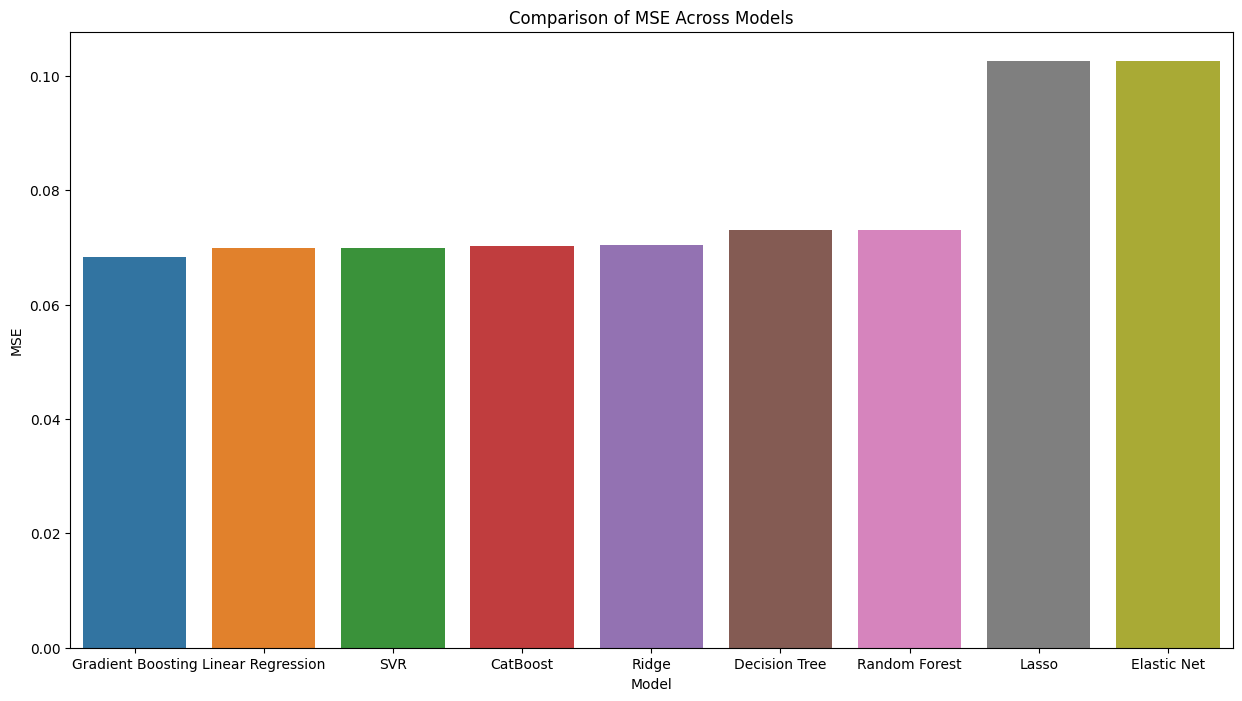

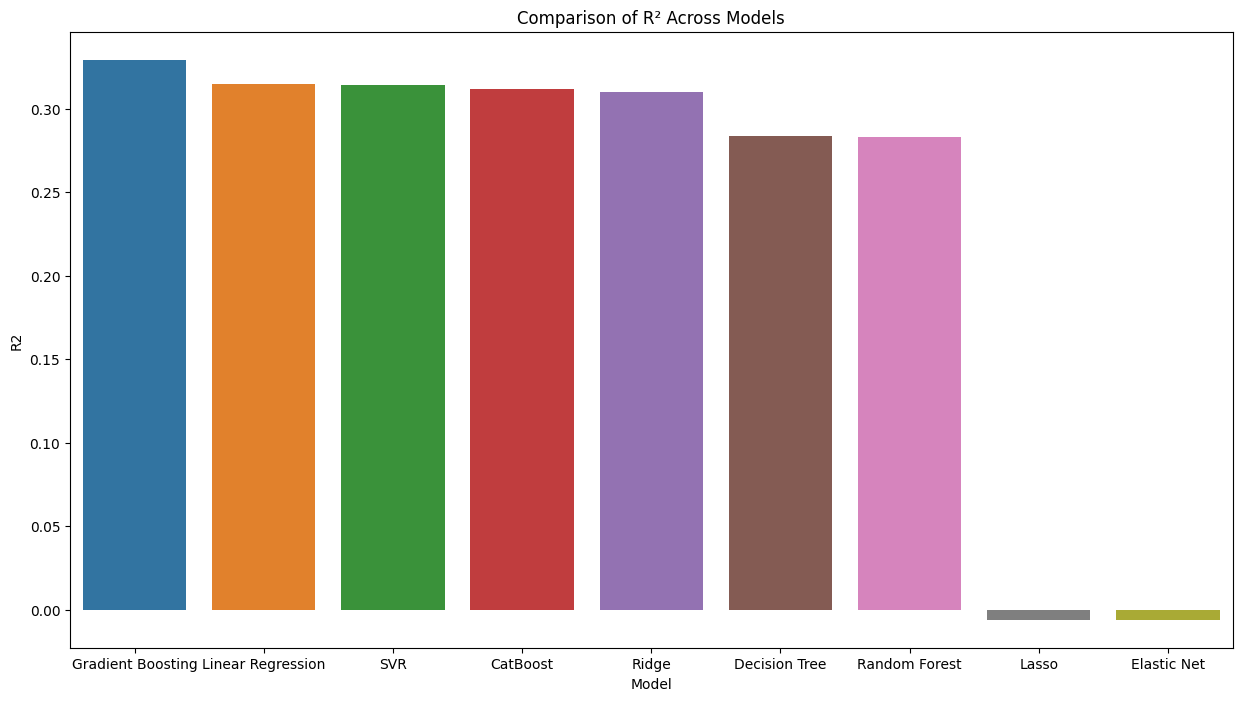

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

mse_df = pd.DataFrame(list(mse_results.items()), columns=['Model', 'MSE'])
r2_df = pd.DataFrame(list(r2_results.items()), columns=['Model', 'R2'])

plt.figure(figsize=(15, 8))
sns.barplot(x='Model', y='MSE', data=mse_df.sort_values('MSE'))
plt.title('Comparison of MSE Across Models')
plt.show()

plt.figure(figsize=(15, 8))
sns.barplot(x='Model', y='R2', data=r2_df.sort_values('R2', ascending=False))
plt.title('Comparison of R² Across Models')
plt.show()